### DSN AI Bootcamp Qualification Hackathon by Data Science Nigeria

In [1]:
#Importing all necessary libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold,train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, VotingClassifier

In [2]:
#loading in data sets
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submission = pd.read_csv('SampleSubmission.csv')

In [3]:
train.head()

Applicant_ID  form_field1  form_field2  form_field3  form_field4  \
0  Apcnt_1000000       3436.0      0.28505       1.6560          0.0   
1  Apcnt_1000004       3456.0      0.67400       0.2342          0.0   
2  Apcnt_1000008       3276.0      0.53845       3.1510          0.0   
3  Apcnt_1000012       3372.0      0.17005       0.5050          0.0   
4  Apcnt_1000016       3370.0      0.77270       1.1010          0.0   

   form_field5  form_field6  form_field7  form_field8  form_field9  ...  \
0        0.000          0.0   10689720.0     252072.0    4272776.0  ...   
1        0.000          0.0     898979.0     497531.0    9073814.0  ...   
2        6.282          NaN     956940.0          NaN     192944.0  ...   
3        0.000     192166.0    3044703.0     385499.0    3986472.0  ...   
4        0.000       1556.0     214728.0     214728.0    1284089.0  ...   

   form_field42  form_field43  form_field44  form_field45  form_field46  \
0      0.392854          2.02      0.711632           0.0           0.0   
1      0.314281          8.08      0.183584           NaN           0.0   
2      0.162965         18.18      0.791136           0.0           0.0   
3      0.488884          2.02      0.685168           NaN           0.0   
4      0.275000         12.12      0.438168           0.0           0.0   

   form_field47  form_field48  form_field49  form_field50  default_status  
0        charge           NaN      1.129518      0.044335              no  
1        charge    349.805730      1.620483      0.322436              no  
2        charge           NaN      1.513370      0.011640             yes  
3        charge     89.940100      0.664452      0.082729              no  
4        charge     97.887502      1.427891      0.045630              no  

[5 rows x 52 columns]

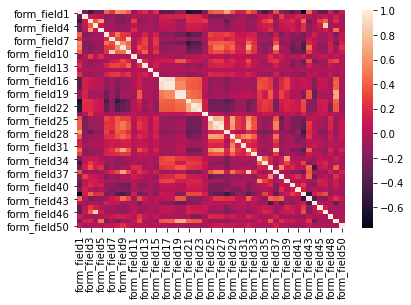

In [4]:
sns.heatmap(train.corr())

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Applicant_ID    56000 non-null  object 
 1   form_field1     53471 non-null  float64
 2   form_field2     52156 non-null  float64
 3   form_field3     55645 non-null  float64
 4   form_field4     55645 non-null  float64
 5   form_field5     55645 non-null  float64
 6   form_field6     42640 non-null  float64
 7   form_field7     50837 non-null  float64
 8   form_field8     42640 non-null  float64
 9   form_field9     47992 non-null  float64
 10  form_field10    55645 non-null  float64
 11  form_field11    24579 non-null  float64
 12  form_field12    46105 non-null  float64
 13  form_field13    50111 non-null  float64
 14  form_field14    56000 non-null  int64  
 15  form_field15    33525 non-null  float64
 16  form_field16    42964 non-null  float64
 17  form_field17    44849 non-null 

In [6]:
print(train.shape)
print(test.shape)

(56000, 52)
(24000, 51)


In [7]:
train.isna().sum()

Applicant_ID          0
form_field1        2529
form_field2        3844
form_field3         355
form_field4         355
form_field5         355
form_field6       13360
form_field7        5163
form_field8       13360
form_field9        8008
form_field10        355
form_field11      31421
form_field12       9895
form_field13       5889
form_field14          0
form_field15      22475
form_field16      13036
form_field17      11151
form_field18      10402
form_field19          4
form_field20        355
form_field21      15854
form_field22      20400
form_field23      28123
form_field24      13297
form_field25       5450
form_field26       7438
form_field27       9299
form_field28        355
form_field29        355
form_field30      25509
form_field31      39408
form_field32       5450
form_field33       1256
form_field34        355
form_field35      23148
form_field36       1995
form_field37       5450
form_field38        355
form_field39       4211
form_field40      43729
form_field41    

In [8]:
train['form_field47'].unique()

array(['charge', 'lending'], dtype=object)

In [9]:
#Encoding the categorical feature
lab = LabelEncoder()
lab.fit(train['form_field47'])
train['form_field47'] = lab.transform(train['form_field47'])
test['form_field47'] = lab.transform(test['form_field47'])

In [10]:
#Dropping features not needed
to_drop = []#columns for columns in train.columns[train.isnull().mean()>=0.7]]
to_drop.extend(['Applicant_ID'])
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
print(f'The following columns were dropped {to_drop}')

The following columns were dropped ['Applicant_ID']


In [11]:
# cat_feat = [col for col in train if train[col].dtypes == 'O']
# num_feat = [col for col in train if train[col].dtypes == 'float64']

#filling the remaining missing data
for col in test.columns:
    train[col].fillna(-1,inplace= True)
    test[col].fillna(-1,inplace= True)

In [12]:
#Function for Frequency encoding
def freq_encoding(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[str(i) + 'enc'] = data[i].map(encoding)
    return data

#Function for automating feature interactions between important features to generate more
#information for the model without repition.
def feature_interact(data, cols):
    for df in data:
        for i in cols:
            for j in cols:
                if j != i and i + 'div' + j not in df.columns :
                    df[i + 'div' + j] = df[i] / df[j] 

        for i in cols:
            for j in cols:
                for k in cols:
                    if j != i and j!=k and i!=k : 
                        df[i + 'pl' + j + 'div' + k] = (df[i] + df[j])/df[k]
                        df[i + 'pl' + j + 'div' + k] = (df[i] + df[j]) * df[k]
                        df[i + 'pl' + j + 'div' + k] = (df[i] + df[j])/df[k]


        for i in cols:
            for j in cols:
                if j != i and i + 'mul' + j not in df.columns:
                    df[i + 'mu' + j] = df[i] * df[j]
    return df

#Function for creating a dataframe based on order of importance of features
def feat_imp_sorter(model, x):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    feature_imp = pd.DataFrame(zip(model.feature_importances_,x.columns), columns=['Value','Features'])
    feature_imp.sort_values(by='Value',ignore_index=True, ascending=False, inplace = True)
    return feature_imp
    
#fUnction for ploting barplot for the feature importance of any model    
def feat_imp_ploter(model,x):
    sorted_feat = feat_imp_sorter(model,x)
    
    plt.figure(figsize=(15, 20))
    sns.barplot(x="Value", y="Features", data=sorted_feat)
    plt.title(str(model) +'Features_important')
    plt.tight_layout()
    
#Function to create a new dataset by dropping less important features   
def less_feat_drop(model,x,test,num=10):
    feat = feat_imp_sorter(model, x)
    un_imp = list(feat[-num:]['Features'])
    new_x = x.drop(un_imp, axis=1)
    new_test = test.drop(un_imp, axis=1)
    return new_x, new_test

#function for saving the submission file
def submit(pred,div = 1,name = ""):
    pred_mean = pred/div
    submission['default_status'] = pred_mean
    submission.to_csv(name,index=False)

#Function for grouping the features
def group_feat_eng(groups):
    train[str(groups) + 'tot'] = np.zeros(train.shape[0])
    test[str(groups) + 'tot'] = np.zeros(test.shape[0])
    
    for group in groups:
        train[str(groups) + 'tot'] +=(train[group]*0.001)
        test[str(groups) + 'tot'] +=(test[group]*0.001)
    

In [13]:
#Frequency encoding
freq_encoding(train,train.drop('default_status', axis=1))
freq_encoding(test,test)

form_field1  form_field2  form_field3  form_field4  form_field5  \
0           3236.0      0.34875      10.2006       0.0000       0.0000   
1           3284.0      1.27360       2.9606       9.0198       0.0000   
2             -1.0      0.27505       0.0600       0.0000       0.0000   
3           3232.0      0.28505       2.8032       0.0000       0.0000   
4           3466.0      2.09545       0.8318       2.5182       0.0000   
...            ...          ...          ...          ...          ...   
23995       3258.0      0.37925       0.5698       5.1282       0.0000   
23996       3514.0      0.95260       0.0000       0.0000       0.0000   
23997       3302.0      0.05755       4.2394       0.0000      25.4376   
23998       3334.0      0.75670       1.4428       0.0000       0.0000   
23999       3324.0      0.44840       2.3170       6.7176       0.0000   

       form_field6  form_field7  form_field8  form_field9  form_field10  ...  \
0         418564.0     418564.0     418564.0     540710.0           0.0  ...   
1              0.0    9858816.0      49014.0    1510098.0    18308285.0  ...   
2             -1.0         -1.0         -1.0         -1.0           0.0  ...   
3              0.0     473802.0     473802.0    1724437.0      493641.0  ...   
4          19839.0    1150662.0    1150662.0    7860523.0     5752921.0  ...   
...            ...          ...          ...          ...           ...  ...   
23995         -1.0    2280318.0         -1.0         -1.0     2280318.0  ...   
23996    1494538.0    4773419.0    4773419.0   89718571.0    12999991.0  ...   
23997         -1.0      49403.0         -1.0         -1.0       49403.0  ...   
23998          0.0    2513329.0      37733.0     393668.0     2551062.0  ...   
23999         -1.0    5305182.0         -1.0   18885950.0     5361587.0  ...   

       form_field41enc  form_field42enc  form_field43enc  form_field44enc  \
0             0.681208         0.010000         0.102292         0.116958   
1             0.000042         0.002458         0.073333         0.000042   
2             0.681208         0.024083         0.126292         0.098417   
3             0.681208         0.005750         0.087625         0.000042   
4             0.681208         0.000083         0.004458         0.000042   
...                ...              ...              ...              ...   
23995         0.000042         0.042708         0.126292         0.116958   
23996         0.000042         0.306000         0.026625         0.000042   
23997         0.681208         0.042708         0.102292         0.116958   
23998         0.000042         0.009917         0.087625         0.000083   
23999         0.000083         0.008000         0.080958         0.000042   

       form_field45enc  form_field46enc  form_field47enc  form_field48enc  \
0             0.564083         0.652125         0.644458         0.371750   
1             0.024125         0.652125         0.355542         0.371750   
2             0.564083         0.286875         0.644458         0.371750   
3             0.564083         0.286875         0.644458         0.000042   
4             0.409583         0.652125         0.355542         0.000042   
...                ...              ...              ...              ...   
23995         0.564083         0.053958         0.644458         0.371750   
23996         0.409583         0.652125         0.644458         0.000042   
23997         0.564083         0.652125         0.644458         0.371750   
23998         0.564083         0.652125         0.644458         0.000042   
23999         0.409583         0.053958         0.644458         0.371750   

       form_field49enc  form_field50enc  
0             0.532500         0.000042  
1             0.000042         0.000042  
2             0.532500         0.199875  
3             0.000042         0.000042  
4             0.000042         0.000042  
...                ...              ...  
23995        

In [14]:
#Performing Prinicipal Component Analysis on the data
pca =  PCA(2)
train_trans = pca.fit_transform(train.drop(['default_status'], axis = 1))
test_trans = pca.transform(test)

#Merging the reduced data to the real dataset
train = pd.merge(train, pd.DataFrame(train_trans, columns=['pca1','pca2']),left_index=True,right_index=True)
test = pd.merge(test, pd.DataFrame(test_trans,columns=['pca1','pca2']),left_index=True,right_index=True)

In [15]:
#Generating more features from imortant features
feature_interact(data= [train,test], cols = ['form_field1', 'form_field2', 'form_field1enc','form_field47',
                                           'form_field25','form_field8','form_field30'])

form_field1  form_field2  form_field3  form_field4  form_field5  \
0           3236.0      0.34875      10.2006       0.0000       0.0000   
1           3284.0      1.27360       2.9606       9.0198       0.0000   
2             -1.0      0.27505       0.0600       0.0000       0.0000   
3           3232.0      0.28505       2.8032       0.0000       0.0000   
4           3466.0      2.09545       0.8318       2.5182       0.0000   
...            ...          ...          ...          ...          ...   
23995       3258.0      0.37925       0.5698       5.1282       0.0000   
23996       3514.0      0.95260       0.0000       0.0000       0.0000   
23997       3302.0      0.05755       4.2394       0.0000      25.4376   
23998       3334.0      0.75670       1.4428       0.0000       0.0000   
23999       3324.0      0.44840       2.3170       6.7176       0.0000   

       form_field6  form_field7  form_field8  form_field9  form_field10  ...  \
0         418564.0     418564.0     418564.0     540710.0           0.0  ...   
1              0.0    9858816.0      49014.0    1510098.0    18308285.0  ...   
2             -1.0         -1.0         -1.0         -1.0           0.0  ...   
3              0.0     473802.0     473802.0    1724437.0      493641.0  ...   
4          19839.0    1150662.0    1150662.0    7860523.0     5752921.0  ...   
...            ...          ...          ...          ...           ...  ...   
23995         -1.0    2280318.0         -1.0         -1.0     2280318.0  ...   
23996    1494538.0    4773419.0    4773419.0   89718571.0    12999991.0  ...   
23997         -1.0      49403.0         -1.0         -1.0       49403.0  ...   
23998          0.0    2513329.0      37733.0     393668.0     2551062.0  ...   
23999         -1.0    5305182.0         -1.0   18885950.0     5361587.0  ...   

       form_field8muform_field1enc  form_field8muform_field47  \
0                       488.324667                        0.0   
1                       136.830750                    49014.0   
2                        -0.046250                       -0.0   
3                       868.637000                        0.0   
4                      4698.536500                  1150662.0   
...                            ...                        ...   
23995                    -0.001833                       -0.0   
23996                 21679.277958                        0.0   
23997                    -0.002417                       -0.0   
23998                    92.760292                        0.0   
23999                    -0.002250                       -0.0   

       form_field8muform_field25  form_field8muform_field30  \
0                   4.545605e+08               4.099416e+09   
1                   1.510857e+08               1.729214e+08   
2                   1.000000e+00               1.000000e+00   
3                   6.701929e+08              -4.738020e+05   
4                   3.134403e+09               6.788906e+09   
...                          ...                        ...   
23995              -5.475000e+02              -2.068000e+03   
23996               7.088527e+09               1.568545e+10   
23997              -2.304000e+03               1.000000e+00   
23998               2.665836e+07               8.723870e+07   
23999              -9.319500e+03              -9.672000e+03   

       form_field30muform_field1  form_field30muform_field2  \
0                     31693384.0                 3415.65750   
1                     11585952.0                 4493.26080   
2                            1.0                   -0.27505   
3                        -3232.0                   -0.28505   
4                     20449400.0                12363.15500   
...                          ...                        ...   
23995                  6737544.0                  784.28900   
23996                 11547004.0                 3130.24360   
23997                    -3302.0                   -

In [16]:
#Replacing all infinity in the dataset that mignt have been
#caused by the interactions
train.replace(np.inf, -999, inplace=True)
test.replace(np.inf, -999, inplace=True)

Text(0.5, 1.0, 'Imbalanced data')

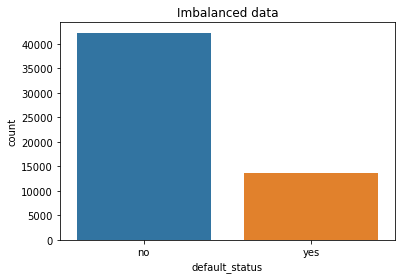

In [17]:
sns.countplot(x="default_status", data=train)
plt.title('Imbalanced data')

In [18]:
#Encoding the target
status = {'no':0,'yes':1}
train['default_status'] = train['default_status'].map(status)

In [19]:
print(train.shape)
print(test.shape)

(56000, 397)
(24000, 396)


## MODELLING

In [20]:
y= train['default_status']
X = train.drop('default_status',axis = 1)

In [21]:
skfold =StratifiedKFold(n_splits=10,random_state=43,shuffle=True)
scoreslgb = []
test_scoreslgb = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(skfold.split(X,y)):
    print("============================Fold{fold}================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    lgb = LGBMClassifier(n_estimators=500, learning_rate=0.1, subsample=0.5,
                           colsample_bytree=0.6, max_depth=3,random_state = 7,
                        min_child_weight = 12,silent = True, num_leaves = 32)#10,7
    lgb.fit(X_train,y_train)
    _ = lgb.predict_proba(X_test)[:,1]
    scoreslgb.append(roc_auc_score(y_test,_))
    test_scoreslgb += lgb.predict_proba(test)[:,1]

============================Fold0================================
============================Fold1================================
============================Fold2================================
============================Fold3================================
============================Fold4================================
============================Fold5================================
============================Fold6================================
============================Fold7================================
============================Fold8================================
============================Fold9================================


In [22]:
np.mean(scoreslgb)#2.561975077

0.8392347575834481

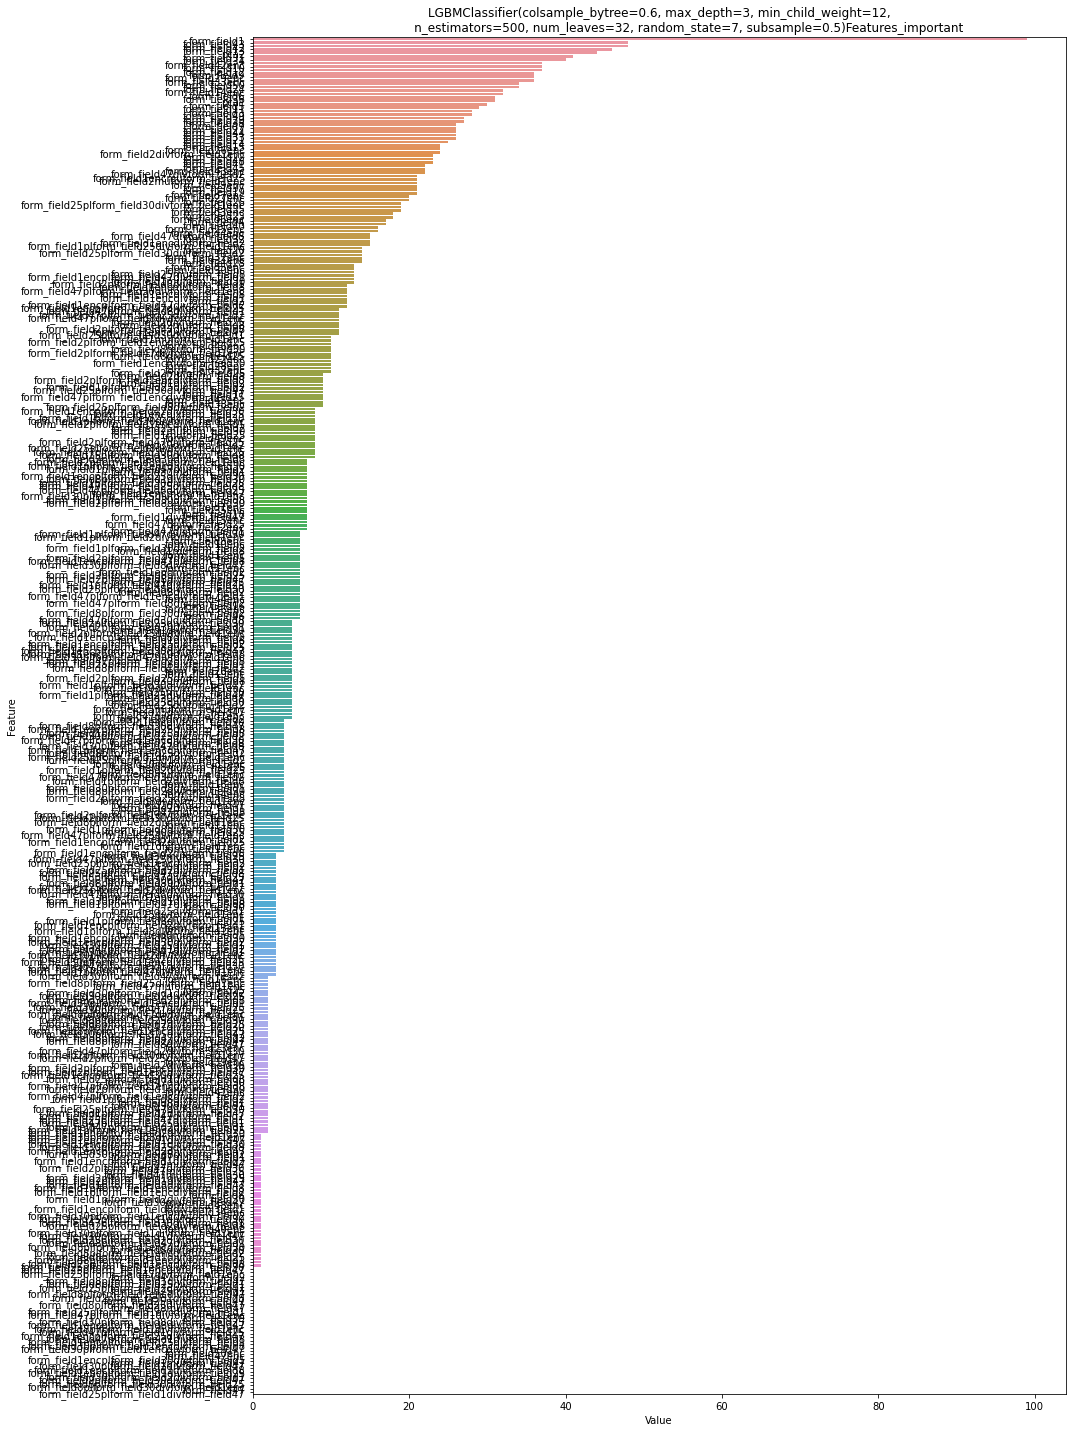

In [23]:
feat_imp_ploter(lgb,X)

In [24]:
#dropping less important features using LightGMB
new_train, new_test = less_feat_drop(lgb,num=250,x=X, test= test)

In [31]:
skfold =StratifiedKFold(n_splits=10,random_state=43,shuffle=True)
scoreslgb1 = []
test_scoreslgb1 = np.zeros(len(new_test))
for fold,(tr_in,te_in) in enumerate(skfold.split(new_train,y)):
    print("============================Fold{fold}================================".format(fold=fold))
    X_train,X_test = new_train.iloc[tr_in],new_train.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    lgb1= LGBMClassifier(n_estimators=5000, learning_rate=0.01, subsample=0.6,
                           colsample_bytree=0.5, max_depth=4,random_state = 7,
                        min_child_weight = 12,silent = True, num_leaves = 22)#10,7
    lgb1.fit(X_train,y_train)
    scoreslgb1.append(roc_auc_score(y_test,lgb1.predict_proba(X_test)[:,1]))
    print(roc_auc_score(y_test,lgb1.predict_proba(X_test)[:,1]))
    test_scoreslgb1 += lgb1.predict_proba(new_test)[:,1]

============================Fold0================================
0.8434211073241464
============================Fold1================================
0.8423509031367763
============================Fold2================================
0.8400835535401336
============================Fold3================================
0.8403132895558592
============================Fold4================================
0.8357399560776473
============================Fold5================================
0.8427235064859842
============================Fold6================================
0.8272944702952136
============================Fold7================================
0.8418136344955606
============================Fold8================================
0.8496711497141092
============================Fold9================================
0.8309136162912252


In [32]:
np.mean(scoreslgb1)#2.561975077

0.8394325186916657

In [34]:
test_scoreslgb/10

array([0.32271074, 0.38277244, 0.4008103 , ..., 0.24006407, 0.51184987,
       0.22772968])

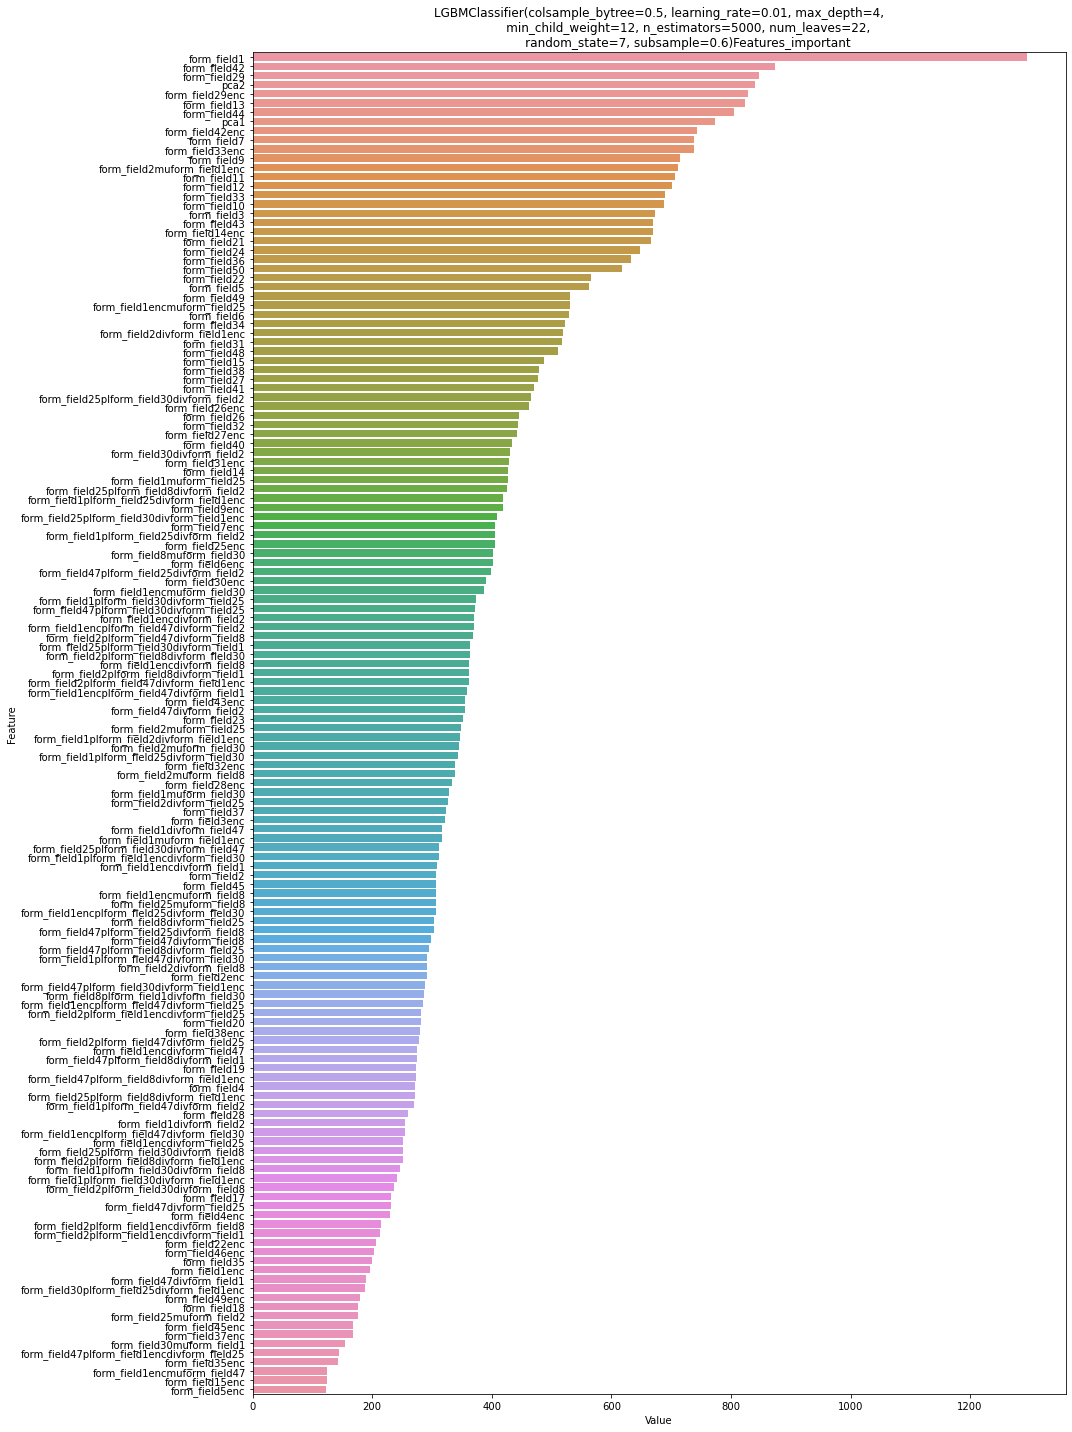

In [36]:
feat_imp_ploter(lgb1,new_train)

In [37]:
submit(test_scoreslgb1,10,'lgbmodel3new2')

In [41]:
kf = StratifiedKFold(n_splits=10,random_state=43,shuffle=True)
cat_scores = []
cat_pred = np.zeros(len(new_test))
for fold,(tr_in,te_in) in enumerate(kf.split(new_train,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = new_train.iloc[tr_in],new_train.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(iterations=5000, learning_rate=0.02, l2_leaf_reg=12, depth=7, loss_function= 'Logloss',
    border_count=100, eval_metric='AUC',use_best_model=True)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(roc_auc_score(y_test,cat.predict_proba(X_test)[:,1]))
    print(roc_auc_score(y_test,cat.predict(X_test)[:,1]))
#     print(np.sqrt(log_loss(y_test,cat.predict(X_test))))
    cat_pred += cat.predict_proba(new_test)[:,1]

================================Fold0====================================
0:	test: 0.8039434	test1: 0.7914835	best: 0.7914835 (0)	total: 422ms	remaining: 35m 7s
1:	test: 0.8113674	test1: 0.8047492	best: 0.8047492 (1)	total: 1.13s	remaining: 46m 53s
2:	test: 0.8178040	test1: 0.8103374	best: 0.8103374 (2)	total: 1.64s	remaining: 45m 37s
3:	test: 0.8193264	test1: 0.8138412	best: 0.8138412 (3)	total: 2.14s	remaining: 44m 37s
4:	test: 0.8203843	test1: 0.8159888	best: 0.8159888 (4)	total: 2.58s	remaining: 42m 53s
5:	test: 0.8210519	test1: 0.8177353	best: 0.8177353 (5)	total: 2.77s	remaining: 38m 26s
6:	test: 0.8210347	test1: 0.8179270	best: 0.8179270 (6)	total: 3.03s	remaining: 35m 58s
7:	test: 0.8215164	test1: 0.8180062	best: 0.8180062 (7)	total: 3.27s	remaining: 33m 58s
8:	test: 0.8214486	test1: 0.8181332	best: 0.8181332 (8)	total: 3.56s	remaining: 32m 51s
9:	test: 0.8217626	test1: 0.8183632	best: 0.8183632 (9)	total: 3.75s	remaining: 31m 11s
10:	test: 0.8216037	test1: 0.8180245	best: 0.81

91:	test: 0.8358206	test1: 0.8317270	best: 0.8317270 (91)	total: 36.1s	remaining: 32m 4s
92:	test: 0.8358534	test1: 0.8317834	best: 0.8317834 (92)	total: 36.8s	remaining: 32m 21s
93:	test: 0.8359729	test1: 0.8318303	best: 0.8318303 (93)	total: 37.5s	remaining: 32m 35s
94:	test: 0.8360449	test1: 0.8318545	best: 0.8318545 (94)	total: 37.9s	remaining: 32m 39s
95:	test: 0.8361806	test1: 0.8319229	best: 0.8319229 (95)	total: 38.4s	remaining: 32m 42s
96:	test: 0.8362772	test1: 0.8319572	best: 0.8319572 (96)	total: 38.8s	remaining: 32m 39s
97:	test: 0.8364033	test1: 0.8320840	best: 0.8320840 (97)	total: 38.9s	remaining: 32m 26s
98:	test: 0.8364868	test1: 0.8321273	best: 0.8321273 (98)	total: 39.1s	remaining: 32m 15s
99:	test: 0.8365811	test1: 0.8322123	best: 0.8322123 (99)	total: 39.3s	remaining: 32m 4s
100:	test: 0.8366751	test1: 0.8322570	best: 0.8322570 (100)	total: 39.5s	remaining: 31m 56s
101:	test: 0.8367602	test1: 0.8323522	best: 0.8323522 (101)	total: 39.7s	remaining: 31m 46s
102:	tes

181:	test: 0.8428258	test1: 0.8363505	best: 0.8363505 (181)	total: 1m 21s	remaining: 36m 3s
182:	test: 0.8428769	test1: 0.8364019	best: 0.8364019 (182)	total: 1m 22s	remaining: 36m 1s
183:	test: 0.8429277	test1: 0.8364650	best: 0.8364650 (183)	total: 1m 22s	remaining: 36m
184:	test: 0.8429833	test1: 0.8365135	best: 0.8365135 (184)	total: 1m 22s	remaining: 35m 58s
185:	test: 0.8430575	test1: 0.8365126	best: 0.8365135 (184)	total: 1m 23s	remaining: 36m 13s
186:	test: 0.8431284	test1: 0.8365189	best: 0.8365189 (186)	total: 1m 24s	remaining: 36m 19s
187:	test: 0.8431947	test1: 0.8365778	best: 0.8365778 (187)	total: 1m 25s	remaining: 36m 23s
188:	test: 0.8432664	test1: 0.8366439	best: 0.8366439 (188)	total: 1m 25s	remaining: 36m 22s
189:	test: 0.8433156	test1: 0.8366618	best: 0.8366618 (189)	total: 1m 26s	remaining: 36m 28s
190:	test: 0.8433719	test1: 0.8367084	best: 0.8367084 (190)	total: 1m 26s	remaining: 36m 30s
191:	test: 0.8434485	test1: 0.8367324	best: 0.8367324 (191)	total: 1m 27s	re

270:	test: 0.8477601	test1: 0.8385785	best: 0.8386034 (267)	total: 1m 58s	remaining: 34m 22s
271:	test: 0.8478030	test1: 0.8385879	best: 0.8386034 (267)	total: 1m 58s	remaining: 34m 20s
272:	test: 0.8478493	test1: 0.8386137	best: 0.8386137 (272)	total: 1m 58s	remaining: 34m 19s
273:	test: 0.8479128	test1: 0.8386398	best: 0.8386398 (273)	total: 1m 59s	remaining: 34m 17s
274:	test: 0.8479820	test1: 0.8386527	best: 0.8386527 (274)	total: 1m 59s	remaining: 34m 13s
275:	test: 0.8480228	test1: 0.8386618	best: 0.8386618 (275)	total: 1m 59s	remaining: 34m 9s
276:	test: 0.8480830	test1: 0.8386884	best: 0.8386884 (276)	total: 1m 59s	remaining: 34m 5s
277:	test: 0.8481195	test1: 0.8387077	best: 0.8387077 (277)	total: 2m	remaining: 34m 1s
278:	test: 0.8481917	test1: 0.8386913	best: 0.8387077 (277)	total: 2m	remaining: 33m 57s
279:	test: 0.8482433	test1: 0.8387158	best: 0.8387158 (279)	total: 2m	remaining: 33m 54s
280:	test: 0.8482949	test1: 0.8387681	best: 0.8387681 (280)	total: 2m	remaining: 33m 

359:	test: 0.8520168	test1: 0.8400166	best: 0.8400166 (359)	total: 2m 37s	remaining: 33m 48s
360:	test: 0.8520698	test1: 0.8400327	best: 0.8400327 (360)	total: 2m 37s	remaining: 33m 45s
361:	test: 0.8521351	test1: 0.8400672	best: 0.8400672 (361)	total: 2m 37s	remaining: 33m 42s
362:	test: 0.8521776	test1: 0.8400872	best: 0.8400872 (362)	total: 2m 38s	remaining: 33m 39s
363:	test: 0.8522177	test1: 0.8401003	best: 0.8401003 (363)	total: 2m 38s	remaining: 33m 36s
364:	test: 0.8522709	test1: 0.8401284	best: 0.8401284 (364)	total: 2m 38s	remaining: 33m 33s
365:	test: 0.8522967	test1: 0.8401412	best: 0.8401412 (365)	total: 2m 38s	remaining: 33m 30s
366:	test: 0.8523800	test1: 0.8401896	best: 0.8401896 (366)	total: 2m 39s	remaining: 33m 27s
367:	test: 0.8524146	test1: 0.8401958	best: 0.8401958 (367)	total: 2m 39s	remaining: 33m 26s
368:	test: 0.8524400	test1: 0.8402319	best: 0.8402319 (368)	total: 2m 39s	remaining: 33m 23s
369:	test: 0.8524913	test1: 0.8402207	best: 0.8402319 (368)	total: 2m 

448:	test: 0.8560005	test1: 0.8410872	best: 0.8410872 (448)	total: 3m 13s	remaining: 32m 40s
449:	test: 0.8560463	test1: 0.8410968	best: 0.8410968 (449)	total: 3m 13s	remaining: 32m 40s
450:	test: 0.8560787	test1: 0.8410986	best: 0.8410986 (450)	total: 3m 14s	remaining: 32m 39s
451:	test: 0.8561189	test1: 0.8410825	best: 0.8410986 (450)	total: 3m 14s	remaining: 32m 38s
452:	test: 0.8561618	test1: 0.8410874	best: 0.8410986 (450)	total: 3m 15s	remaining: 32m 39s
453:	test: 0.8562185	test1: 0.8411344	best: 0.8411344 (453)	total: 3m 15s	remaining: 32m 39s
454:	test: 0.8562497	test1: 0.8411394	best: 0.8411394 (454)	total: 3m 16s	remaining: 32m 37s
455:	test: 0.8562738	test1: 0.8411301	best: 0.8411394 (454)	total: 3m 16s	remaining: 32m 37s
456:	test: 0.8563200	test1: 0.8411593	best: 0.8411593 (456)	total: 3m 16s	remaining: 32m 36s
457:	test: 0.8563742	test1: 0.8412193	best: 0.8412193 (457)	total: 3m 17s	remaining: 32m 40s
458:	test: 0.8564352	test1: 0.8412284	best: 0.8412284 (458)	total: 3m 

538:	test: 0.8600381	test1: 0.8418143	best: 0.8418421 (535)	total: 3m 50s	remaining: 31m 47s
539:	test: 0.8600764	test1: 0.8418359	best: 0.8418421 (535)	total: 3m 50s	remaining: 31m 45s
540:	test: 0.8601267	test1: 0.8418140	best: 0.8418421 (535)	total: 3m 50s	remaining: 31m 43s
541:	test: 0.8602047	test1: 0.8418378	best: 0.8418421 (535)	total: 3m 51s	remaining: 31m 41s
542:	test: 0.8602230	test1: 0.8418409	best: 0.8418421 (535)	total: 3m 51s	remaining: 31m 39s
543:	test: 0.8602612	test1: 0.8418506	best: 0.8418506 (543)	total: 3m 51s	remaining: 31m 37s
544:	test: 0.8603026	test1: 0.8418318	best: 0.8418506 (543)	total: 3m 51s	remaining: 31m 35s
545:	test: 0.8603402	test1: 0.8418449	best: 0.8418506 (543)	total: 3m 52s	remaining: 31m 34s
546:	test: 0.8603989	test1: 0.8418376	best: 0.8418506 (543)	total: 3m 52s	remaining: 31m 33s
547:	test: 0.8604389	test1: 0.8418130	best: 0.8418506 (543)	total: 3m 53s	remaining: 31m 33s
548:	test: 0.8604708	test1: 0.8418067	best: 0.8418506 (543)	total: 3m 

628:	test: 0.8643448	test1: 0.8425148	best: 0.8425182 (621)	total: 4m 19s	remaining: 30m 4s
629:	test: 0.8643556	test1: 0.8425096	best: 0.8425182 (621)	total: 4m 19s	remaining: 30m 2s
630:	test: 0.8644136	test1: 0.8425246	best: 0.8425246 (630)	total: 4m 20s	remaining: 30m
631:	test: 0.8644775	test1: 0.8425242	best: 0.8425246 (630)	total: 4m 20s	remaining: 29m 58s
632:	test: 0.8645117	test1: 0.8425636	best: 0.8425636 (632)	total: 4m 20s	remaining: 29m 56s
633:	test: 0.8645811	test1: 0.8425868	best: 0.8425868 (633)	total: 4m 20s	remaining: 29m 54s
634:	test: 0.8646130	test1: 0.8426155	best: 0.8426155 (634)	total: 4m 20s	remaining: 29m 52s
635:	test: 0.8646349	test1: 0.8426129	best: 0.8426155 (634)	total: 4m 21s	remaining: 29m 50s
636:	test: 0.8646787	test1: 0.8426327	best: 0.8426327 (636)	total: 4m 21s	remaining: 29m 50s
637:	test: 0.8647030	test1: 0.8426270	best: 0.8426327 (636)	total: 4m 21s	remaining: 29m 49s
638:	test: 0.8647406	test1: 0.8426246	best: 0.8426327 (636)	total: 4m 22s	re

717:	test: 0.8690112	test1: 0.8434635	best: 0.8434635 (717)	total: 4m 52s	remaining: 29m 2s
718:	test: 0.8690759	test1: 0.8434701	best: 0.8434701 (718)	total: 4m 52s	remaining: 29m
719:	test: 0.8691305	test1: 0.8434811	best: 0.8434811 (719)	total: 4m 52s	remaining: 28m 58s
720:	test: 0.8691887	test1: 0.8434673	best: 0.8434811 (719)	total: 4m 52s	remaining: 28m 57s
721:	test: 0.8692548	test1: 0.8435070	best: 0.8435070 (721)	total: 4m 52s	remaining: 28m 55s
722:	test: 0.8693254	test1: 0.8435244	best: 0.8435244 (722)	total: 4m 53s	remaining: 28m 54s
723:	test: 0.8693513	test1: 0.8435232	best: 0.8435244 (722)	total: 4m 53s	remaining: 28m 53s
724:	test: 0.8693760	test1: 0.8435208	best: 0.8435244 (722)	total: 4m 53s	remaining: 28m 52s
725:	test: 0.8694269	test1: 0.8435175	best: 0.8435244 (722)	total: 4m 54s	remaining: 28m 51s
726:	test: 0.8694684	test1: 0.8435155	best: 0.8435244 (722)	total: 4m 54s	remaining: 28m 51s
727:	test: 0.8695260	test1: 0.8435123	best: 0.8435244 (722)	total: 4m 54s	r

807:	test: 0.8734946	test1: 0.8438038	best: 0.8438038 (807)	total: 5m 22s	remaining: 27m 54s
808:	test: 0.8735192	test1: 0.8438016	best: 0.8438038 (807)	total: 5m 22s	remaining: 27m 52s
809:	test: 0.8735235	test1: 0.8438035	best: 0.8438038 (807)	total: 5m 23s	remaining: 27m 51s
810:	test: 0.8735509	test1: 0.8438085	best: 0.8438085 (810)	total: 5m 23s	remaining: 27m 49s
811:	test: 0.8736311	test1: 0.8438104	best: 0.8438104 (811)	total: 5m 23s	remaining: 27m 49s
812:	test: 0.8736669	test1: 0.8438342	best: 0.8438342 (812)	total: 5m 23s	remaining: 27m 48s
813:	test: 0.8737161	test1: 0.8438247	best: 0.8438342 (812)	total: 5m 24s	remaining: 27m 48s
814:	test: 0.8737688	test1: 0.8438178	best: 0.8438342 (812)	total: 5m 24s	remaining: 27m 47s
815:	test: 0.8737978	test1: 0.8438330	best: 0.8438342 (812)	total: 5m 25s	remaining: 27m 47s
816:	test: 0.8738541	test1: 0.8438637	best: 0.8438637 (816)	total: 5m 25s	remaining: 27m 46s
817:	test: 0.8739005	test1: 0.8438623	best: 0.8438637 (816)	total: 5m 

896:	test: 0.8772554	test1: 0.8439744	best: 0.8439744 (896)	total: 5m 51s	remaining: 26m 45s
897:	test: 0.8772931	test1: 0.8439673	best: 0.8439744 (896)	total: 5m 51s	remaining: 26m 45s
898:	test: 0.8773043	test1: 0.8439661	best: 0.8439744 (896)	total: 5m 51s	remaining: 26m 44s
899:	test: 0.8773562	test1: 0.8439870	best: 0.8439870 (899)	total: 5m 52s	remaining: 26m 44s
900:	test: 0.8773889	test1: 0.8439963	best: 0.8439963 (900)	total: 5m 52s	remaining: 26m 43s
901:	test: 0.8774365	test1: 0.8439908	best: 0.8439963 (900)	total: 5m 52s	remaining: 26m 43s
902:	test: 0.8774847	test1: 0.8439825	best: 0.8439963 (900)	total: 5m 53s	remaining: 26m 43s
903:	test: 0.8775377	test1: 0.8439656	best: 0.8439963 (900)	total: 5m 53s	remaining: 26m 42s
904:	test: 0.8776001	test1: 0.8439653	best: 0.8439963 (900)	total: 5m 54s	remaining: 26m 42s
905:	test: 0.8776586	test1: 0.8439789	best: 0.8439963 (900)	total: 5m 54s	remaining: 26m 42s
906:	test: 0.8776943	test1: 0.8439915	best: 0.8439963 (900)	total: 5m 

985:	test: 0.8807109	test1: 0.8443426	best: 0.8443426 (985)	total: 6m 20s	remaining: 25m 47s
986:	test: 0.8807528	test1: 0.8443549	best: 0.8443549 (986)	total: 6m 20s	remaining: 25m 47s
987:	test: 0.8808042	test1: 0.8443300	best: 0.8443549 (986)	total: 6m 20s	remaining: 25m 47s
988:	test: 0.8808356	test1: 0.8443311	best: 0.8443549 (986)	total: 6m 21s	remaining: 25m 46s
989:	test: 0.8808772	test1: 0.8443354	best: 0.8443549 (986)	total: 6m 21s	remaining: 25m 46s
990:	test: 0.8808962	test1: 0.8443440	best: 0.8443549 (986)	total: 6m 22s	remaining: 25m 45s
991:	test: 0.8809199	test1: 0.8443442	best: 0.8443549 (986)	total: 6m 22s	remaining: 25m 45s
992:	test: 0.8809834	test1: 0.8443564	best: 0.8443564 (992)	total: 6m 22s	remaining: 25m 45s
993:	test: 0.8810426	test1: 0.8443676	best: 0.8443676 (993)	total: 6m 23s	remaining: 25m 44s
994:	test: 0.8810840	test1: 0.8443701	best: 0.8443701 (994)	total: 6m 24s	remaining: 25m 45s
995:	test: 0.8811324	test1: 0.8443568	best: 0.8443701 (994)	total: 6m 

1072:	test: 0.8842802	test1: 0.8445049	best: 0.8445536 (1067)	total: 6m 54s	remaining: 25m 15s
1073:	test: 0.8843129	test1: 0.8445065	best: 0.8445536 (1067)	total: 6m 54s	remaining: 25m 15s
1074:	test: 0.8843466	test1: 0.8445155	best: 0.8445536 (1067)	total: 6m 55s	remaining: 25m 15s
1075:	test: 0.8843600	test1: 0.8445156	best: 0.8445536 (1067)	total: 6m 55s	remaining: 25m 16s
1076:	test: 0.8844101	test1: 0.8445194	best: 0.8445536 (1067)	total: 6m 56s	remaining: 25m 17s
1077:	test: 0.8844427	test1: 0.8445365	best: 0.8445536 (1067)	total: 6m 57s	remaining: 25m 19s
1078:	test: 0.8844718	test1: 0.8445262	best: 0.8445536 (1067)	total: 6m 58s	remaining: 25m 19s
1079:	test: 0.8845002	test1: 0.8445455	best: 0.8445536 (1067)	total: 6m 58s	remaining: 25m 20s
1080:	test: 0.8845410	test1: 0.8445624	best: 0.8445624 (1080)	total: 6m 59s	remaining: 25m 21s
1081:	test: 0.8845989	test1: 0.8445563	best: 0.8445624 (1080)	total: 7m	remaining: 25m 22s
1082:	test: 0.8846393	test1: 0.8445553	best: 0.8445624

1160:	test: 0.8875998	test1: 0.8448285	best: 0.8448326 (1156)	total: 7m 40s	remaining: 25m 22s
1161:	test: 0.8876113	test1: 0.8448273	best: 0.8448326 (1156)	total: 7m 40s	remaining: 25m 21s
1162:	test: 0.8876431	test1: 0.8448263	best: 0.8448326 (1156)	total: 7m 41s	remaining: 25m 21s
1163:	test: 0.8876881	test1: 0.8448025	best: 0.8448326 (1156)	total: 7m 41s	remaining: 25m 20s
1164:	test: 0.8877585	test1: 0.8448245	best: 0.8448326 (1156)	total: 7m 42s	remaining: 25m 20s
1165:	test: 0.8878076	test1: 0.8448280	best: 0.8448326 (1156)	total: 7m 42s	remaining: 25m 21s
1166:	test: 0.8878459	test1: 0.8448018	best: 0.8448326 (1156)	total: 7m 43s	remaining: 25m 22s
1167:	test: 0.8878649	test1: 0.8447837	best: 0.8448326 (1156)	total: 7m 44s	remaining: 25m 23s
1168:	test: 0.8878992	test1: 0.8447876	best: 0.8448326 (1156)	total: 7m 44s	remaining: 25m 23s
1169:	test: 0.8879466	test1: 0.8447638	best: 0.8448326 (1156)	total: 7m 45s	remaining: 25m 24s
1170:	test: 0.8879904	test1: 0.8447407	best: 0.844

1247:	test: 0.8909189	test1: 0.8450617	best: 0.8450700 (1243)	total: 8m 14s	remaining: 24m 45s
1248:	test: 0.8909573	test1: 0.8450493	best: 0.8450700 (1243)	total: 8m 14s	remaining: 24m 45s
1249:	test: 0.8910132	test1: 0.8450408	best: 0.8450700 (1243)	total: 8m 14s	remaining: 24m 44s
1250:	test: 0.8910498	test1: 0.8450717	best: 0.8450717 (1250)	total: 8m 15s	remaining: 24m 44s
1251:	test: 0.8911063	test1: 0.8450565	best: 0.8450717 (1250)	total: 8m 15s	remaining: 24m 44s
1252:	test: 0.8911203	test1: 0.8450506	best: 0.8450717 (1250)	total: 8m 16s	remaining: 24m 43s
1253:	test: 0.8911629	test1: 0.8450377	best: 0.8450717 (1250)	total: 8m 16s	remaining: 24m 42s
1254:	test: 0.8911946	test1: 0.8450281	best: 0.8450717 (1250)	total: 8m 16s	remaining: 24m 41s
1255:	test: 0.8912346	test1: 0.8450065	best: 0.8450717 (1250)	total: 8m 16s	remaining: 24m 40s
1256:	test: 0.8912551	test1: 0.8450127	best: 0.8450717 (1250)	total: 8m 16s	remaining: 24m 39s
1257:	test: 0.8913002	test1: 0.8450324	best: 0.845

1334:	test: 0.8940557	test1: 0.8452614	best: 0.8452614 (1334)	total: 8m 44s	remaining: 24m 1s
1335:	test: 0.8940924	test1: 0.8452593	best: 0.8452614 (1334)	total: 8m 45s	remaining: 24m 1s
1336:	test: 0.8941231	test1: 0.8452700	best: 0.8452700 (1336)	total: 8m 46s	remaining: 24m 1s
1337:	test: 0.8941500	test1: 0.8452692	best: 0.8452700 (1336)	total: 8m 46s	remaining: 24m 1s
1338:	test: 0.8942041	test1: 0.8452819	best: 0.8452819 (1338)	total: 8m 47s	remaining: 24m 1s
1339:	test: 0.8942174	test1: 0.8452857	best: 0.8452857 (1339)	total: 8m 47s	remaining: 24m
1340:	test: 0.8942751	test1: 0.8452935	best: 0.8452935 (1340)	total: 8m 47s	remaining: 23m 59s
1341:	test: 0.8943376	test1: 0.8453007	best: 0.8453007 (1341)	total: 8m 47s	remaining: 23m 58s
1342:	test: 0.8943801	test1: 0.8453000	best: 0.8453007 (1341)	total: 8m 47s	remaining: 23m 57s
1343:	test: 0.8943946	test1: 0.8453025	best: 0.8453025 (1343)	total: 8m 48s	remaining: 23m 56s
1344:	test: 0.8944268	test1: 0.8453054	best: 0.8453054 (134

1421:	test: 0.8971933	test1: 0.8452809	best: 0.8453182 (1402)	total: 9m 14s	remaining: 23m 14s
1422:	test: 0.8972221	test1: 0.8452933	best: 0.8453182 (1402)	total: 9m 14s	remaining: 23m 13s
1423:	test: 0.8972698	test1: 0.8452918	best: 0.8453182 (1402)	total: 9m 14s	remaining: 23m 13s
1424:	test: 0.8973158	test1: 0.8452650	best: 0.8453182 (1402)	total: 9m 15s	remaining: 23m 12s
1425:	test: 0.8973586	test1: 0.8452587	best: 0.8453182 (1402)	total: 9m 15s	remaining: 23m 12s
1426:	test: 0.8973982	test1: 0.8452523	best: 0.8453182 (1402)	total: 9m 16s	remaining: 23m 12s
1427:	test: 0.8974323	test1: 0.8452431	best: 0.8453182 (1402)	total: 9m 16s	remaining: 23m 11s
1428:	test: 0.8974798	test1: 0.8452438	best: 0.8453182 (1402)	total: 9m 16s	remaining: 23m 11s
1429:	test: 0.8975175	test1: 0.8452480	best: 0.8453182 (1402)	total: 9m 16s	remaining: 23m 10s
1430:	test: 0.8975672	test1: 0.8452583	best: 0.8453182 (1402)	total: 9m 17s	remaining: 23m 9s
1431:	test: 0.8976067	test1: 0.8452580	best: 0.8453

1508:	test: 0.9002079	test1: 0.8453563	best: 0.8453744 (1506)	total: 9m 51s	remaining: 22m 48s
1509:	test: 0.9002379	test1: 0.8453664	best: 0.8453744 (1506)	total: 9m 52s	remaining: 22m 49s
1510:	test: 0.9002616	test1: 0.8453599	best: 0.8453744 (1506)	total: 9m 53s	remaining: 22m 50s
1511:	test: 0.9002997	test1: 0.8453721	best: 0.8453744 (1506)	total: 9m 53s	remaining: 22m 49s
1512:	test: 0.9003248	test1: 0.8453620	best: 0.8453744 (1506)	total: 9m 54s	remaining: 22m 49s
1513:	test: 0.9003582	test1: 0.8453182	best: 0.8453744 (1506)	total: 9m 54s	remaining: 22m 49s
1514:	test: 0.9004041	test1: 0.8453318	best: 0.8453744 (1506)	total: 9m 54s	remaining: 22m 48s
1515:	test: 0.9004157	test1: 0.8453526	best: 0.8453744 (1506)	total: 9m 55s	remaining: 22m 47s
1516:	test: 0.9004355	test1: 0.8453444	best: 0.8453744 (1506)	total: 9m 55s	remaining: 22m 46s
1517:	test: 0.9004536	test1: 0.8453364	best: 0.8453744 (1506)	total: 9m 55s	remaining: 22m 46s
1518:	test: 0.9004730	test1: 0.8453333	best: 0.845

1594:	test: 0.9028676	test1: 0.8453004	best: 0.8453820 (1547)	total: 10m 34s	remaining: 22m 34s
1595:	test: 0.9029170	test1: 0.8452959	best: 0.8453820 (1547)	total: 10m 35s	remaining: 22m 35s
1596:	test: 0.9029419	test1: 0.8452935	best: 0.8453820 (1547)	total: 10m 36s	remaining: 22m 35s
1597:	test: 0.9029625	test1: 0.8452830	best: 0.8453820 (1547)	total: 10m 36s	remaining: 22m 36s
1598:	test: 0.9029923	test1: 0.8452674	best: 0.8453820 (1547)	total: 10m 37s	remaining: 22m 36s
1599:	test: 0.9030191	test1: 0.8452616	best: 0.8453820 (1547)	total: 10m 38s	remaining: 22m 36s
1600:	test: 0.9030434	test1: 0.8452574	best: 0.8453820 (1547)	total: 10m 39s	remaining: 22m 36s
1601:	test: 0.9030556	test1: 0.8452569	best: 0.8453820 (1547)	total: 10m 39s	remaining: 22m 36s
1602:	test: 0.9031016	test1: 0.8452574	best: 0.8453820 (1547)	total: 10m 39s	remaining: 22m 36s
1603:	test: 0.9031246	test1: 0.8452419	best: 0.8453820 (1547)	total: 10m 40s	remaining: 22m 35s
1604:	test: 0.9031526	test1: 0.8452414	b

1680:	test: 0.9056045	test1: 0.8451948	best: 0.8453820 (1547)	total: 11m 26s	remaining: 22m 34s
1681:	test: 0.9056444	test1: 0.8451888	best: 0.8453820 (1547)	total: 11m 26s	remaining: 22m 34s
1682:	test: 0.9056627	test1: 0.8451819	best: 0.8453820 (1547)	total: 11m 27s	remaining: 22m 34s
1683:	test: 0.9057096	test1: 0.8451993	best: 0.8453820 (1547)	total: 11m 27s	remaining: 22m 34s
1684:	test: 0.9057301	test1: 0.8452083	best: 0.8453820 (1547)	total: 11m 28s	remaining: 22m 34s
1685:	test: 0.9057594	test1: 0.8452035	best: 0.8453820 (1547)	total: 11m 29s	remaining: 22m 34s
1686:	test: 0.9057824	test1: 0.8452223	best: 0.8453820 (1547)	total: 11m 29s	remaining: 22m 34s
1687:	test: 0.9057925	test1: 0.8452245	best: 0.8453820 (1547)	total: 11m 30s	remaining: 22m 34s
1688:	test: 0.9057932	test1: 0.8452242	best: 0.8453820 (1547)	total: 11m 30s	remaining: 22m 33s
1689:	test: 0.9058101	test1: 0.8452200	best: 0.8453820 (1547)	total: 11m 30s	remaining: 22m 33s
1690:	test: 0.9058444	test1: 0.8452317	b

1766:	test: 0.9079468	test1: 0.8452185	best: 0.8453820 (1547)	total: 12m 12s	remaining: 22m 20s
1767:	test: 0.9079891	test1: 0.8452411	best: 0.8453820 (1547)	total: 12m 13s	remaining: 22m 21s
1768:	test: 0.9080155	test1: 0.8452324	best: 0.8453820 (1547)	total: 12m 14s	remaining: 22m 21s
1769:	test: 0.9080641	test1: 0.8452305	best: 0.8453820 (1547)	total: 12m 14s	remaining: 22m 21s
1770:	test: 0.9080912	test1: 0.8452298	best: 0.8453820 (1547)	total: 12m 15s	remaining: 22m 21s
1771:	test: 0.9081383	test1: 0.8452293	best: 0.8453820 (1547)	total: 12m 16s	remaining: 22m 20s
1772:	test: 0.9081687	test1: 0.8452281	best: 0.8453820 (1547)	total: 12m 16s	remaining: 22m 20s
1773:	test: 0.9081951	test1: 0.8452198	best: 0.8453820 (1547)	total: 12m 16s	remaining: 22m 20s
1774:	test: 0.9082446	test1: 0.8452204	best: 0.8453820 (1547)	total: 12m 17s	remaining: 22m 20s
1775:	test: 0.9082723	test1: 0.8452309	best: 0.8453820 (1547)	total: 12m 18s	remaining: 22m 19s
1776:	test: 0.9082796	test1: 0.8452338	b

1852:	test: 0.9106207	test1: 0.8452200	best: 0.8453820 (1547)	total: 12m 49s	remaining: 21m 46s
1853:	test: 0.9106363	test1: 0.8452424	best: 0.8453820 (1547)	total: 12m 49s	remaining: 21m 46s
1854:	test: 0.9106742	test1: 0.8452500	best: 0.8453820 (1547)	total: 12m 50s	remaining: 21m 46s
1855:	test: 0.9107181	test1: 0.8452562	best: 0.8453820 (1547)	total: 12m 50s	remaining: 21m 45s
1856:	test: 0.9107434	test1: 0.8452568	best: 0.8453820 (1547)	total: 12m 51s	remaining: 21m 45s
1857:	test: 0.9107603	test1: 0.8452481	best: 0.8453820 (1547)	total: 12m 51s	remaining: 21m 44s
1858:	test: 0.9108039	test1: 0.8452319	best: 0.8453820 (1547)	total: 12m 51s	remaining: 21m 43s
1859:	test: 0.9108459	test1: 0.8452186	best: 0.8453820 (1547)	total: 12m 51s	remaining: 21m 42s
1860:	test: 0.9108646	test1: 0.8451986	best: 0.8453820 (1547)	total: 12m 51s	remaining: 21m 41s
1861:	test: 0.9108830	test1: 0.8451978	best: 0.8453820 (1547)	total: 12m 52s	remaining: 21m 41s
1862:	test: 0.9109328	test1: 0.8451974	b

1938:	test: 0.9132735	test1: 0.8450475	best: 0.8453820 (1547)	total: 13m 18s	remaining: 21m 1s
1939:	test: 0.9133074	test1: 0.8450482	best: 0.8453820 (1547)	total: 13m 19s	remaining: 21m
1940:	test: 0.9133390	test1: 0.8450051	best: 0.8453820 (1547)	total: 13m 19s	remaining: 20m 59s
1941:	test: 0.9133727	test1: 0.8450386	best: 0.8453820 (1547)	total: 13m 19s	remaining: 20m 59s
1942:	test: 0.9134066	test1: 0.8450419	best: 0.8453820 (1547)	total: 13m 19s	remaining: 20m 58s
1943:	test: 0.9134239	test1: 0.8450453	best: 0.8453820 (1547)	total: 13m 20s	remaining: 20m 57s
1944:	test: 0.9134557	test1: 0.8450387	best: 0.8453820 (1547)	total: 13m 20s	remaining: 20m 57s
1945:	test: 0.9134918	test1: 0.8450337	best: 0.8453820 (1547)	total: 13m 20s	remaining: 20m 56s
1946:	test: 0.9135358	test1: 0.8450444	best: 0.8453820 (1547)	total: 13m 21s	remaining: 20m 56s
1947:	test: 0.9135566	test1: 0.8450462	best: 0.8453820 (1547)	total: 13m 21s	remaining: 20m 55s
1948:	test: 0.9135985	test1: 0.8450294	best: 

2024:	test: 0.9159028	test1: 0.8449240	best: 0.8453820 (1547)	total: 13m 49s	remaining: 20m 18s
2025:	test: 0.9159262	test1: 0.8449516	best: 0.8453820 (1547)	total: 13m 49s	remaining: 20m 18s
2026:	test: 0.9159559	test1: 0.8449599	best: 0.8453820 (1547)	total: 13m 50s	remaining: 20m 18s
2027:	test: 0.9159823	test1: 0.8449796	best: 0.8453820 (1547)	total: 13m 51s	remaining: 20m 18s
2028:	test: 0.9160075	test1: 0.8449649	best: 0.8453820 (1547)	total: 13m 52s	remaining: 20m 19s
2029:	test: 0.9160340	test1: 0.8449618	best: 0.8453820 (1547)	total: 13m 52s	remaining: 20m 18s
2030:	test: 0.9160503	test1: 0.8449539	best: 0.8453820 (1547)	total: 13m 53s	remaining: 20m 17s
2031:	test: 0.9160759	test1: 0.8449699	best: 0.8453820 (1547)	total: 13m 53s	remaining: 20m 17s
2032:	test: 0.9161217	test1: 0.8449748	best: 0.8453820 (1547)	total: 13m 54s	remaining: 20m 17s
2033:	test: 0.9161498	test1: 0.8449741	best: 0.8453820 (1547)	total: 13m 54s	remaining: 20m 17s
2034:	test: 0.9161763	test1: 0.8449644	b

64:	test: 0.8324276	test1: 0.8334257	best: 0.8334257 (64)	total: 24.5s	remaining: 30m 57s
65:	test: 0.8326044	test1: 0.8335920	best: 0.8335920 (65)	total: 25s	remaining: 31m 5s
66:	test: 0.8326879	test1: 0.8336772	best: 0.8336772 (66)	total: 25.4s	remaining: 31m 7s
67:	test: 0.8328547	test1: 0.8337582	best: 0.8337582 (67)	total: 25.8s	remaining: 31m 8s
68:	test: 0.8329549	test1: 0.8339076	best: 0.8339076 (68)	total: 26.2s	remaining: 31m 10s
69:	test: 0.8330725	test1: 0.8339840	best: 0.8339840 (69)	total: 26.6s	remaining: 31m 13s
70:	test: 0.8332034	test1: 0.8340947	best: 0.8340947 (70)	total: 27s	remaining: 31m 14s
71:	test: 0.8332878	test1: 0.8341468	best: 0.8341468 (71)	total: 27.4s	remaining: 31m 14s
72:	test: 0.8333613	test1: 0.8342363	best: 0.8342363 (72)	total: 27.5s	remaining: 30m 58s
73:	test: 0.8334092	test1: 0.8343138	best: 0.8343138 (73)	total: 27.7s	remaining: 30m 43s
74:	test: 0.8335726	test1: 0.8343483	best: 0.8343483 (74)	total: 27.9s	remaining: 30m 29s
75:	test: 0.83373

155:	test: 0.8407104	test1: 0.8391278	best: 0.8391278 (155)	total: 56.4s	remaining: 29m 10s
156:	test: 0.8407834	test1: 0.8391975	best: 0.8391975 (156)	total: 56.6s	remaining: 29m 5s
157:	test: 0.8408726	test1: 0.8392715	best: 0.8392715 (157)	total: 56.8s	remaining: 29m
158:	test: 0.8409456	test1: 0.8393555	best: 0.8393555 (158)	total: 57s	remaining: 28m 54s
159:	test: 0.8409935	test1: 0.8393492	best: 0.8393555 (158)	total: 57.2s	remaining: 28m 50s
160:	test: 0.8410708	test1: 0.8393772	best: 0.8393772 (160)	total: 57.4s	remaining: 28m 46s
161:	test: 0.8411553	test1: 0.8394486	best: 0.8394486 (161)	total: 57.8s	remaining: 28m 44s
162:	test: 0.8412186	test1: 0.8394714	best: 0.8394714 (162)	total: 58.2s	remaining: 28m 48s
163:	test: 0.8413042	test1: 0.8395319	best: 0.8395319 (163)	total: 58.7s	remaining: 28m 50s
164:	test: 0.8413530	test1: 0.8395441	best: 0.8395441 (164)	total: 59s	remaining: 28m 50s
165:	test: 0.8414071	test1: 0.8395450	best: 0.8395450 (165)	total: 59.5s	remaining: 28m 5

244:	test: 0.8460233	test1: 0.8413186	best: 0.8413209 (242)	total: 1m 26s	remaining: 28m 4s
245:	test: 0.8460993	test1: 0.8413621	best: 0.8413621 (245)	total: 1m 27s	remaining: 28m 6s
246:	test: 0.8461351	test1: 0.8414013	best: 0.8414013 (246)	total: 1m 27s	remaining: 28m 6s
247:	test: 0.8461861	test1: 0.8414401	best: 0.8414401 (247)	total: 1m 28s	remaining: 28m 8s
248:	test: 0.8462577	test1: 0.8414570	best: 0.8414570 (248)	total: 1m 28s	remaining: 28m 10s
249:	test: 0.8463083	test1: 0.8414780	best: 0.8414780 (249)	total: 1m 28s	remaining: 28m 10s
250:	test: 0.8463596	test1: 0.8414725	best: 0.8414780 (249)	total: 1m 29s	remaining: 28m 11s
251:	test: 0.8464354	test1: 0.8415261	best: 0.8415261 (251)	total: 1m 29s	remaining: 28m 12s
252:	test: 0.8464816	test1: 0.8415499	best: 0.8415499 (252)	total: 1m 30s	remaining: 28m 12s
253:	test: 0.8465257	test1: 0.8415853	best: 0.8415853 (253)	total: 1m 30s	remaining: 28m 13s
254:	test: 0.8465554	test1: 0.8415962	best: 0.8415962 (254)	total: 1m 30s	

333:	test: 0.8504008	test1: 0.8427976	best: 0.8428104 (331)	total: 1m 57s	remaining: 27m 19s
334:	test: 0.8504423	test1: 0.8428026	best: 0.8428104 (331)	total: 1m 57s	remaining: 27m 19s
335:	test: 0.8505028	test1: 0.8427912	best: 0.8428104 (331)	total: 1m 58s	remaining: 27m 21s
336:	test: 0.8505394	test1: 0.8427576	best: 0.8428104 (331)	total: 1m 58s	remaining: 27m 21s
337:	test: 0.8505785	test1: 0.8427750	best: 0.8428104 (331)	total: 1m 59s	remaining: 27m 22s
338:	test: 0.8506188	test1: 0.8427842	best: 0.8428104 (331)	total: 1m 59s	remaining: 27m 22s
339:	test: 0.8506620	test1: 0.8427738	best: 0.8428104 (331)	total: 1m 59s	remaining: 27m 22s
340:	test: 0.8506888	test1: 0.8427821	best: 0.8428104 (331)	total: 2m	remaining: 27m 22s
341:	test: 0.8507398	test1: 0.8427685	best: 0.8428104 (331)	total: 2m	remaining: 27m 22s
342:	test: 0.8507797	test1: 0.8427579	best: 0.8428104 (331)	total: 2m	remaining: 27m 21s
343:	test: 0.8508103	test1: 0.8427550	best: 0.8428104 (331)	total: 2m 1s	remaining

422:	test: 0.8543278	test1: 0.8434701	best: 0.8434701 (422)	total: 2m 28s	remaining: 26m 46s
423:	test: 0.8543821	test1: 0.8434815	best: 0.8434815 (423)	total: 2m 28s	remaining: 26m 44s
424:	test: 0.8544253	test1: 0.8434770	best: 0.8434815 (423)	total: 2m 28s	remaining: 26m 43s
425:	test: 0.8544690	test1: 0.8434791	best: 0.8434815 (423)	total: 2m 29s	remaining: 26m 41s
426:	test: 0.8545201	test1: 0.8434811	best: 0.8434815 (423)	total: 2m 29s	remaining: 26m 39s
427:	test: 0.8545680	test1: 0.8434873	best: 0.8434873 (427)	total: 2m 29s	remaining: 26m 37s
428:	test: 0.8546038	test1: 0.8434904	best: 0.8434904 (428)	total: 2m 29s	remaining: 26m 35s
429:	test: 0.8546366	test1: 0.8434994	best: 0.8434994 (429)	total: 2m 30s	remaining: 26m 34s
430:	test: 0.8546609	test1: 0.8434944	best: 0.8434994 (429)	total: 2m 30s	remaining: 26m 32s
431:	test: 0.8547131	test1: 0.8434948	best: 0.8434994 (429)	total: 2m 30s	remaining: 26m 30s
432:	test: 0.8547586	test1: 0.8435063	best: 0.8435063 (432)	total: 2m 

511:	test: 0.8582397	test1: 0.8441836	best: 0.8441836 (511)	total: 2m 59s	remaining: 26m 12s
512:	test: 0.8582845	test1: 0.8441684	best: 0.8441836 (511)	total: 2m 59s	remaining: 26m 10s
513:	test: 0.8583257	test1: 0.8441700	best: 0.8441836 (511)	total: 2m 59s	remaining: 26m 9s
514:	test: 0.8583667	test1: 0.8441621	best: 0.8441836 (511)	total: 2m 59s	remaining: 26m 7s
515:	test: 0.8584304	test1: 0.8441545	best: 0.8441836 (511)	total: 3m	remaining: 26m 6s
516:	test: 0.8584569	test1: 0.8441312	best: 0.8441836 (511)	total: 3m	remaining: 26m 4s
517:	test: 0.8585114	test1: 0.8441615	best: 0.8441836 (511)	total: 3m	remaining: 26m 3s
518:	test: 0.8585580	test1: 0.8441893	best: 0.8441893 (518)	total: 3m	remaining: 26m 1s
519:	test: 0.8585988	test1: 0.8441843	best: 0.8441893 (518)	total: 3m 1s	remaining: 26m
520:	test: 0.8586413	test1: 0.8442079	best: 0.8442079 (520)	total: 3m 1s	remaining: 26m
521:	test: 0.8586931	test1: 0.8441916	best: 0.8442079 (520)	total: 3m 1s	remaining: 26m
522:	test: 0.8

601:	test: 0.8623584	test1: 0.8444915	best: 0.8445619 (580)	total: 3m 28s	remaining: 25m 22s
602:	test: 0.8624111	test1: 0.8444661	best: 0.8445619 (580)	total: 3m 28s	remaining: 25m 21s
603:	test: 0.8624507	test1: 0.8444842	best: 0.8445619 (580)	total: 3m 29s	remaining: 25m 21s
604:	test: 0.8625032	test1: 0.8444841	best: 0.8445619 (580)	total: 3m 29s	remaining: 25m 21s
605:	test: 0.8625428	test1: 0.8444767	best: 0.8445619 (580)	total: 3m 29s	remaining: 25m 21s
606:	test: 0.8626060	test1: 0.8444637	best: 0.8445619 (580)	total: 3m 30s	remaining: 25m 21s
607:	test: 0.8626788	test1: 0.8444773	best: 0.8445619 (580)	total: 3m 30s	remaining: 25m 21s
608:	test: 0.8627340	test1: 0.8444591	best: 0.8445619 (580)	total: 3m 31s	remaining: 25m 21s
609:	test: 0.8627684	test1: 0.8444491	best: 0.8445619 (580)	total: 3m 31s	remaining: 25m 21s
610:	test: 0.8627708	test1: 0.8444501	best: 0.8445619 (580)	total: 3m 31s	remaining: 25m 21s
611:	test: 0.8628204	test1: 0.8444611	best: 0.8445619 (580)	total: 3m 

691:	test: 0.8664427	test1: 0.8444006	best: 0.8445619 (580)	total: 3m 59s	remaining: 24m 51s
692:	test: 0.8665078	test1: 0.8444059	best: 0.8445619 (580)	total: 4m	remaining: 24m 52s
693:	test: 0.8665638	test1: 0.8443902	best: 0.8445619 (580)	total: 4m	remaining: 24m 51s
694:	test: 0.8666191	test1: 0.8443839	best: 0.8445619 (580)	total: 4m	remaining: 24m 51s
695:	test: 0.8666632	test1: 0.8443977	best: 0.8445619 (580)	total: 4m 1s	remaining: 24m 51s
696:	test: 0.8667420	test1: 0.8444292	best: 0.8445619 (580)	total: 4m 1s	remaining: 24m 51s
697:	test: 0.8668182	test1: 0.8444221	best: 0.8445619 (580)	total: 4m 2s	remaining: 24m 51s
698:	test: 0.8668621	test1: 0.8444372	best: 0.8445619 (580)	total: 4m 2s	remaining: 24m 51s
699:	test: 0.8669103	test1: 0.8444021	best: 0.8445619 (580)	total: 4m 2s	remaining: 24m 51s
700:	test: 0.8669156	test1: 0.8444042	best: 0.8445619 (580)	total: 4m 3s	remaining: 24m 51s
701:	test: 0.8669772	test1: 0.8444001	best: 0.8445619 (580)	total: 4m 3s	remaining: 24m 

780:	test: 0.8708443	test1: 0.8444977	best: 0.8445748 (760)	total: 4m 30s	remaining: 24m 22s
781:	test: 0.8708507	test1: 0.8444994	best: 0.8445748 (760)	total: 4m 31s	remaining: 24m 21s
782:	test: 0.8708865	test1: 0.8445120	best: 0.8445748 (760)	total: 4m 31s	remaining: 24m 21s
783:	test: 0.8709231	test1: 0.8445042	best: 0.8445748 (760)	total: 4m 31s	remaining: 24m 21s
784:	test: 0.8709515	test1: 0.8445030	best: 0.8445748 (760)	total: 4m 32s	remaining: 24m 20s
785:	test: 0.8709885	test1: 0.8445075	best: 0.8445748 (760)	total: 4m 32s	remaining: 24m 20s
786:	test: 0.8710491	test1: 0.8444948	best: 0.8445748 (760)	total: 4m 32s	remaining: 24m 18s
787:	test: 0.8710937	test1: 0.8444999	best: 0.8445748 (760)	total: 4m 32s	remaining: 24m 17s
788:	test: 0.8711680	test1: 0.8445310	best: 0.8445748 (760)	total: 4m 32s	remaining: 24m 16s
789:	test: 0.8712013	test1: 0.8445058	best: 0.8445748 (760)	total: 4m 33s	remaining: 24m 15s
790:	test: 0.8712417	test1: 0.8445053	best: 0.8445748 (760)	total: 4m 

869:	test: 0.8744340	test1: 0.8443416	best: 0.8445748 (760)	total: 5m 1s	remaining: 23m 52s
870:	test: 0.8744901	test1: 0.8443382	best: 0.8445748 (760)	total: 5m 2s	remaining: 23m 51s
871:	test: 0.8745201	test1: 0.8443532	best: 0.8445748 (760)	total: 5m 2s	remaining: 23m 50s
872:	test: 0.8745562	test1: 0.8443421	best: 0.8445748 (760)	total: 5m 2s	remaining: 23m 50s
873:	test: 0.8746119	test1: 0.8443202	best: 0.8445748 (760)	total: 5m 2s	remaining: 23m 49s
874:	test: 0.8746684	test1: 0.8443128	best: 0.8445748 (760)	total: 5m 3s	remaining: 23m 48s
875:	test: 0.8747165	test1: 0.8443021	best: 0.8445748 (760)	total: 5m 3s	remaining: 23m 47s
876:	test: 0.8747889	test1: 0.8443066	best: 0.8445748 (760)	total: 5m 3s	remaining: 23m 46s
877:	test: 0.8748385	test1: 0.8443033	best: 0.8445748 (760)	total: 5m 3s	remaining: 23m 45s
878:	test: 0.8748772	test1: 0.8442937	best: 0.8445748 (760)	total: 5m 3s	remaining: 23m 44s
879:	test: 0.8749031	test1: 0.8442831	best: 0.8445748 (760)	total: 5m 4s	remaini

958:	test: 0.8783127	test1: 0.8444587	best: 0.8445748 (760)	total: 5m 30s	remaining: 23m 13s
959:	test: 0.8783402	test1: 0.8444547	best: 0.8445748 (760)	total: 5m 31s	remaining: 23m 13s
960:	test: 0.8783821	test1: 0.8444580	best: 0.8445748 (760)	total: 5m 31s	remaining: 23m 13s
961:	test: 0.8784304	test1: 0.8444442	best: 0.8445748 (760)	total: 5m 31s	remaining: 23m 12s
962:	test: 0.8784792	test1: 0.8444603	best: 0.8445748 (760)	total: 5m 32s	remaining: 23m 11s
963:	test: 0.8785385	test1: 0.8444666	best: 0.8445748 (760)	total: 5m 32s	remaining: 23m 10s
964:	test: 0.8785392	test1: 0.8444644	best: 0.8445748 (760)	total: 5m 32s	remaining: 23m 9s
965:	test: 0.8785740	test1: 0.8444658	best: 0.8445748 (760)	total: 5m 32s	remaining: 23m 8s
966:	test: 0.8786101	test1: 0.8444573	best: 0.8445748 (760)	total: 5m 32s	remaining: 23m 7s
967:	test: 0.8786782	test1: 0.8444528	best: 0.8445748 (760)	total: 5m 33s	remaining: 23m 7s
968:	test: 0.8787400	test1: 0.8444487	best: 0.8445748 (760)	total: 5m 33s	

1046:	test: 0.8819938	test1: 0.8443913	best: 0.8445748 (760)	total: 5m 59s	remaining: 22m 38s
1047:	test: 0.8820331	test1: 0.8444130	best: 0.8445748 (760)	total: 6m	remaining: 22m 37s
1048:	test: 0.8820601	test1: 0.8444089	best: 0.8445748 (760)	total: 6m	remaining: 22m 37s
1049:	test: 0.8821095	test1: 0.8444132	best: 0.8445748 (760)	total: 6m	remaining: 22m 36s
1050:	test: 0.8821678	test1: 0.8444223	best: 0.8445748 (760)	total: 6m	remaining: 22m 35s
1051:	test: 0.8821778	test1: 0.8444289	best: 0.8445748 (760)	total: 6m	remaining: 22m 34s
1052:	test: 0.8822329	test1: 0.8444108	best: 0.8445748 (760)	total: 6m 1s	remaining: 22m 33s
1053:	test: 0.8822860	test1: 0.8443947	best: 0.8445748 (760)	total: 6m 1s	remaining: 22m 32s
1054:	test: 0.8823321	test1: 0.8444075	best: 0.8445748 (760)	total: 6m 1s	remaining: 22m 32s
1055:	test: 0.8823623	test1: 0.8444187	best: 0.8445748 (760)	total: 6m 1s	remaining: 22m 31s
1056:	test: 0.8824042	test1: 0.8443787	best: 0.8445748 (760)	total: 6m 2s	remaining:

1134:	test: 0.8854662	test1: 0.8444806	best: 0.8445748 (760)	total: 6m 30s	remaining: 22m 10s
1135:	test: 0.8855173	test1: 0.8444770	best: 0.8445748 (760)	total: 6m 30s	remaining: 22m 9s
1136:	test: 0.8855474	test1: 0.8444904	best: 0.8445748 (760)	total: 6m 30s	remaining: 22m 8s
1137:	test: 0.8855935	test1: 0.8444701	best: 0.8445748 (760)	total: 6m 31s	remaining: 22m 7s
1138:	test: 0.8856425	test1: 0.8444858	best: 0.8445748 (760)	total: 6m 31s	remaining: 22m 6s
1139:	test: 0.8856819	test1: 0.8444868	best: 0.8445748 (760)	total: 6m 31s	remaining: 22m 5s
1140:	test: 0.8857266	test1: 0.8444953	best: 0.8445748 (760)	total: 6m 31s	remaining: 22m 4s
1141:	test: 0.8857550	test1: 0.8444898	best: 0.8445748 (760)	total: 6m 32s	remaining: 22m 4s
1142:	test: 0.8858001	test1: 0.8444466	best: 0.8445748 (760)	total: 6m 32s	remaining: 22m 4s
1143:	test: 0.8858567	test1: 0.8444466	best: 0.8445748 (760)	total: 6m 32s	remaining: 22m 4s
1144:	test: 0.8859140	test1: 0.8444346	best: 0.8445748 (760)	total: 6

1222:	test: 0.8889347	test1: 0.8444477	best: 0.8445748 (760)	total: 7m 2s	remaining: 21m 44s
1223:	test: 0.8889643	test1: 0.8444623	best: 0.8445748 (760)	total: 7m 2s	remaining: 21m 43s
1224:	test: 0.8890198	test1: 0.8444703	best: 0.8445748 (760)	total: 7m 2s	remaining: 21m 42s
1225:	test: 0.8890605	test1: 0.8444404	best: 0.8445748 (760)	total: 7m 2s	remaining: 21m 41s
1226:	test: 0.8890875	test1: 0.8444625	best: 0.8445748 (760)	total: 7m 3s	remaining: 21m 41s
1227:	test: 0.8891165	test1: 0.8444625	best: 0.8445748 (760)	total: 7m 3s	remaining: 21m 41s
1228:	test: 0.8891540	test1: 0.8444380	best: 0.8445748 (760)	total: 7m 4s	remaining: 21m 40s
1229:	test: 0.8891618	test1: 0.8444372	best: 0.8445748 (760)	total: 7m 4s	remaining: 21m 40s
1230:	test: 0.8891996	test1: 0.8444528	best: 0.8445748 (760)	total: 7m 4s	remaining: 21m 40s
1231:	test: 0.8892297	test1: 0.8444296	best: 0.8445748 (760)	total: 7m 5s	remaining: 21m 40s
1232:	test: 0.8892301	test1: 0.8444287	best: 0.8445748 (760)	total: 7m

49:	test: 0.8306433	test1: 0.8249029	best: 0.8249029 (49)	total: 18.5s	remaining: 30m 27s
50:	test: 0.8307899	test1: 0.8250962	best: 0.8250962 (50)	total: 18.7s	remaining: 30m 16s
51:	test: 0.8309278	test1: 0.8252111	best: 0.8252111 (51)	total: 19s	remaining: 30m 6s
52:	test: 0.8310858	test1: 0.8253585	best: 0.8253585 (52)	total: 19.3s	remaining: 30m
53:	test: 0.8313204	test1: 0.8256116	best: 0.8256116 (53)	total: 19.6s	remaining: 29m 52s
54:	test: 0.8315441	test1: 0.8258073	best: 0.8258073 (54)	total: 19.9s	remaining: 29m 44s
55:	test: 0.8317169	test1: 0.8259086	best: 0.8259086 (55)	total: 20.1s	remaining: 29m 36s
56:	test: 0.8318407	test1: 0.8260785	best: 0.8260785 (56)	total: 20.4s	remaining: 29m 28s
57:	test: 0.8319648	test1: 0.8262463	best: 0.8262463 (57)	total: 20.7s	remaining: 29m 21s
58:	test: 0.8320802	test1: 0.8263813	best: 0.8263813 (58)	total: 21s	remaining: 29m 16s
59:	test: 0.8323096	test1: 0.8266657	best: 0.8266657 (59)	total: 21.2s	remaining: 29m 9s
60:	test: 0.8325289	

140:	test: 0.8404752	test1: 0.8320611	best: 0.8320611 (140)	total: 49.8s	remaining: 28m 35s
141:	test: 0.8405736	test1: 0.8321440	best: 0.8321440 (141)	total: 50.2s	remaining: 28m 37s
142:	test: 0.8406526	test1: 0.8321413	best: 0.8321440 (141)	total: 50.6s	remaining: 28m 38s
143:	test: 0.8407388	test1: 0.8322596	best: 0.8322596 (143)	total: 51s	remaining: 28m 39s
144:	test: 0.8408230	test1: 0.8322862	best: 0.8322862 (144)	total: 51.4s	remaining: 28m 40s
145:	test: 0.8408707	test1: 0.8323227	best: 0.8323227 (145)	total: 51.8s	remaining: 28m 41s
146:	test: 0.8409535	test1: 0.8323903	best: 0.8323903 (146)	total: 52.2s	remaining: 28m 42s
147:	test: 0.8410170	test1: 0.8324433	best: 0.8324433 (147)	total: 52.6s	remaining: 28m 42s
148:	test: 0.8410677	test1: 0.8324597	best: 0.8324597 (148)	total: 52.8s	remaining: 28m 37s
149:	test: 0.8411508	test1: 0.8325337	best: 0.8325337 (149)	total: 53s	remaining: 28m 34s
150:	test: 0.8412147	test1: 0.8326484	best: 0.8326484 (150)	total: 53.2s	remaining: 

230:	test: 0.8460420	test1: 0.8349664	best: 0.8349788 (229)	total: 1m 20s	remaining: 27m 44s
231:	test: 0.8460806	test1: 0.8350073	best: 0.8350073 (231)	total: 1m 21s	remaining: 27m 50s
232:	test: 0.8461614	test1: 0.8350323	best: 0.8350323 (232)	total: 1m 21s	remaining: 27m 52s
233:	test: 0.8462074	test1: 0.8350487	best: 0.8350487 (233)	total: 1m 22s	remaining: 27m 53s
234:	test: 0.8462602	test1: 0.8350780	best: 0.8350780 (234)	total: 1m 22s	remaining: 27m 53s
235:	test: 0.8462966	test1: 0.8350778	best: 0.8350780 (234)	total: 1m 22s	remaining: 27m 54s
236:	test: 0.8463536	test1: 0.8350866	best: 0.8350866 (236)	total: 1m 23s	remaining: 27m 56s
237:	test: 0.8464175	test1: 0.8351327	best: 0.8351327 (237)	total: 1m 23s	remaining: 27m 56s
238:	test: 0.8464742	test1: 0.8351351	best: 0.8351351 (238)	total: 1m 23s	remaining: 27m 52s
239:	test: 0.8465400	test1: 0.8351930	best: 0.8351930 (239)	total: 1m 24s	remaining: 27m 48s
240:	test: 0.8466183	test1: 0.8352134	best: 0.8352134 (240)	total: 1m 

319:	test: 0.8507671	test1: 0.8370989	best: 0.8370989 (319)	total: 1m 52s	remaining: 27m 20s
320:	test: 0.8508139	test1: 0.8371213	best: 0.8371213 (320)	total: 1m 52s	remaining: 27m 17s
321:	test: 0.8508860	test1: 0.8371442	best: 0.8371442 (321)	total: 1m 52s	remaining: 27m 15s
322:	test: 0.8509210	test1: 0.8371656	best: 0.8371656 (322)	total: 1m 52s	remaining: 27m 12s
323:	test: 0.8509512	test1: 0.8371636	best: 0.8371656 (322)	total: 1m 53s	remaining: 27m 11s
324:	test: 0.8510151	test1: 0.8372020	best: 0.8372020 (324)	total: 1m 53s	remaining: 27m 11s
325:	test: 0.8510490	test1: 0.8372141	best: 0.8372141 (325)	total: 1m 53s	remaining: 27m 13s
326:	test: 0.8510877	test1: 0.8372296	best: 0.8372296 (326)	total: 1m 54s	remaining: 27m 13s
327:	test: 0.8511229	test1: 0.8372476	best: 0.8372476 (327)	total: 1m 54s	remaining: 27m 13s
328:	test: 0.8511809	test1: 0.8373045	best: 0.8373045 (328)	total: 1m 55s	remaining: 27m 14s
329:	test: 0.8512247	test1: 0.8373150	best: 0.8373150 (329)	total: 1m 

408:	test: 0.8545730	test1: 0.8384973	best: 0.8384973 (408)	total: 2m 22s	remaining: 26m 36s
409:	test: 0.8546164	test1: 0.8385113	best: 0.8385113 (409)	total: 2m 22s	remaining: 26m 36s
410:	test: 0.8546580	test1: 0.8385315	best: 0.8385315 (410)	total: 2m 22s	remaining: 26m 36s
411:	test: 0.8546990	test1: 0.8385209	best: 0.8385315 (410)	total: 2m 23s	remaining: 26m 37s
412:	test: 0.8547325	test1: 0.8385363	best: 0.8385363 (412)	total: 2m 23s	remaining: 26m 38s
413:	test: 0.8547746	test1: 0.8385556	best: 0.8385556 (413)	total: 2m 24s	remaining: 26m 38s
414:	test: 0.8548172	test1: 0.8385561	best: 0.8385561 (414)	total: 2m 24s	remaining: 26m 38s
415:	test: 0.8548819	test1: 0.8385451	best: 0.8385561 (414)	total: 2m 25s	remaining: 26m 37s
416:	test: 0.8549292	test1: 0.8385827	best: 0.8385827 (416)	total: 2m 25s	remaining: 26m 35s
417:	test: 0.8549698	test1: 0.8385799	best: 0.8385827 (416)	total: 2m 25s	remaining: 26m 33s
418:	test: 0.8550276	test1: 0.8385799	best: 0.8385827 (416)	total: 2m 

497:	test: 0.8582506	test1: 0.8393909	best: 0.8393909 (497)	total: 2m 52s	remaining: 26m
498:	test: 0.8583142	test1: 0.8394183	best: 0.8394183 (498)	total: 2m 53s	remaining: 26m 1s
499:	test: 0.8583546	test1: 0.8394176	best: 0.8394183 (498)	total: 2m 53s	remaining: 26m 2s
500:	test: 0.8583914	test1: 0.8394323	best: 0.8394323 (500)	total: 2m 54s	remaining: 26m 2s
501:	test: 0.8584372	test1: 0.8394247	best: 0.8394323 (500)	total: 2m 54s	remaining: 26m 2s
502:	test: 0.8584728	test1: 0.8394359	best: 0.8394359 (502)	total: 2m 54s	remaining: 26m 2s
503:	test: 0.8585379	test1: 0.8394332	best: 0.8394359 (502)	total: 2m 55s	remaining: 26m 3s
504:	test: 0.8585798	test1: 0.8394613	best: 0.8394613 (504)	total: 2m 55s	remaining: 26m 3s
505:	test: 0.8586239	test1: 0.8394701	best: 0.8394701 (505)	total: 2m 56s	remaining: 26m 3s
506:	test: 0.8586789	test1: 0.8394839	best: 0.8394839 (506)	total: 2m 56s	remaining: 26m 4s
507:	test: 0.8587228	test1: 0.8395189	best: 0.8395189 (507)	total: 2m 56s	remaining

586:	test: 0.8624572	test1: 0.8401030	best: 0.8401030 (586)	total: 3m 24s	remaining: 25m 35s
587:	test: 0.8624985	test1: 0.8401310	best: 0.8401310 (587)	total: 3m 24s	remaining: 25m 35s
588:	test: 0.8625362	test1: 0.8401339	best: 0.8401339 (588)	total: 3m 25s	remaining: 25m 36s
589:	test: 0.8625696	test1: 0.8401717	best: 0.8401717 (589)	total: 3m 25s	remaining: 25m 37s
590:	test: 0.8626098	test1: 0.8401751	best: 0.8401751 (590)	total: 3m 26s	remaining: 25m 37s
591:	test: 0.8626418	test1: 0.8401986	best: 0.8401986 (591)	total: 3m 26s	remaining: 25m 39s
592:	test: 0.8626914	test1: 0.8401819	best: 0.8401986 (591)	total: 3m 27s	remaining: 25m 39s
593:	test: 0.8627579	test1: 0.8401889	best: 0.8401986 (591)	total: 3m 27s	remaining: 25m 40s
594:	test: 0.8627906	test1: 0.8401908	best: 0.8401986 (591)	total: 3m 27s	remaining: 25m 39s
595:	test: 0.8628347	test1: 0.8401965	best: 0.8401986 (591)	total: 3m 28s	remaining: 25m 39s
596:	test: 0.8628787	test1: 0.8402100	best: 0.8402100 (596)	total: 3m 

675:	test: 0.8665943	test1: 0.8405437	best: 0.8405796 (667)	total: 3m 54s	remaining: 24m 58s
676:	test: 0.8666278	test1: 0.8405337	best: 0.8405796 (667)	total: 3m 54s	remaining: 24m 56s
677:	test: 0.8666622	test1: 0.8405351	best: 0.8405796 (667)	total: 3m 54s	remaining: 24m 55s
678:	test: 0.8667337	test1: 0.8405334	best: 0.8405796 (667)	total: 3m 54s	remaining: 24m 54s
679:	test: 0.8667799	test1: 0.8405254	best: 0.8405796 (667)	total: 3m 55s	remaining: 24m 53s
680:	test: 0.8668189	test1: 0.8405303	best: 0.8405796 (667)	total: 3m 55s	remaining: 24m 52s
681:	test: 0.8668992	test1: 0.8405246	best: 0.8405796 (667)	total: 3m 55s	remaining: 24m 53s
682:	test: 0.8669543	test1: 0.8405151	best: 0.8405796 (667)	total: 3m 56s	remaining: 24m 53s
683:	test: 0.8670110	test1: 0.8405096	best: 0.8405796 (667)	total: 3m 56s	remaining: 24m 53s
684:	test: 0.8670408	test1: 0.8405111	best: 0.8405796 (667)	total: 3m 57s	remaining: 24m 53s
685:	test: 0.8670821	test1: 0.8405223	best: 0.8405796 (667)	total: 3m 

764:	test: 0.8707858	test1: 0.8406905	best: 0.8407191 (761)	total: 4m 23s	remaining: 24m 20s
765:	test: 0.8708371	test1: 0.8407122	best: 0.8407191 (761)	total: 4m 24s	remaining: 24m 20s
766:	test: 0.8708993	test1: 0.8407184	best: 0.8407191 (761)	total: 4m 24s	remaining: 24m 20s
767:	test: 0.8709568	test1: 0.8406967	best: 0.8407191 (761)	total: 4m 24s	remaining: 24m 20s
768:	test: 0.8710006	test1: 0.8406696	best: 0.8407191 (761)	total: 4m 25s	remaining: 24m 20s
769:	test: 0.8710426	test1: 0.8406415	best: 0.8407191 (761)	total: 4m 25s	remaining: 24m 19s
770:	test: 0.8710854	test1: 0.8406231	best: 0.8407191 (761)	total: 4m 26s	remaining: 24m 19s
771:	test: 0.8711187	test1: 0.8406255	best: 0.8407191 (761)	total: 4m 26s	remaining: 24m 19s
772:	test: 0.8711565	test1: 0.8406212	best: 0.8407191 (761)	total: 4m 26s	remaining: 24m 19s
773:	test: 0.8711896	test1: 0.8406049	best: 0.8407191 (761)	total: 4m 27s	remaining: 24m 19s
774:	test: 0.8712361	test1: 0.8406310	best: 0.8407191 (761)	total: 4m 

853:	test: 0.8749111	test1: 0.8409499	best: 0.8409544 (852)	total: 4m 53s	remaining: 23m 46s
854:	test: 0.8749482	test1: 0.8409426	best: 0.8409544 (852)	total: 4m 54s	remaining: 23m 46s
855:	test: 0.8749741	test1: 0.8409359	best: 0.8409544 (852)	total: 4m 54s	remaining: 23m 46s
856:	test: 0.8750045	test1: 0.8409228	best: 0.8409544 (852)	total: 4m 55s	remaining: 23m 46s
857:	test: 0.8750531	test1: 0.8409138	best: 0.8409544 (852)	total: 4m 55s	remaining: 23m 46s
858:	test: 0.8750978	test1: 0.8409220	best: 0.8409544 (852)	total: 4m 55s	remaining: 23m 45s
859:	test: 0.8751317	test1: 0.8409325	best: 0.8409544 (852)	total: 4m 56s	remaining: 23m 45s
860:	test: 0.8751628	test1: 0.8409376	best: 0.8409544 (852)	total: 4m 56s	remaining: 23m 45s
861:	test: 0.8751840	test1: 0.8409261	best: 0.8409544 (852)	total: 4m 56s	remaining: 23m 44s
862:	test: 0.8752252	test1: 0.8409013	best: 0.8409544 (852)	total: 4m 56s	remaining: 23m 43s
863:	test: 0.8752659	test1: 0.8409028	best: 0.8409544 (852)	total: 4m 

942:	test: 0.8787944	test1: 0.8411001	best: 0.8411629 (924)	total: 5m 22s	remaining: 23m 9s
943:	test: 0.8788426	test1: 0.8411282	best: 0.8411629 (924)	total: 5m 23s	remaining: 23m 9s
944:	test: 0.8789038	test1: 0.8411324	best: 0.8411629 (924)	total: 5m 23s	remaining: 23m 9s
945:	test: 0.8789298	test1: 0.8411408	best: 0.8411629 (924)	total: 5m 24s	remaining: 23m 9s
946:	test: 0.8789800	test1: 0.8411144	best: 0.8411629 (924)	total: 5m 24s	remaining: 23m 8s
947:	test: 0.8790440	test1: 0.8411682	best: 0.8411682 (947)	total: 5m 24s	remaining: 23m 8s
948:	test: 0.8790698	test1: 0.8411543	best: 0.8411682 (947)	total: 5m 25s	remaining: 23m 10s
949:	test: 0.8791032	test1: 0.8411617	best: 0.8411682 (947)	total: 5m 26s	remaining: 23m 10s
950:	test: 0.8791638	test1: 0.8411510	best: 0.8411682 (947)	total: 5m 26s	remaining: 23m 11s
951:	test: 0.8791957	test1: 0.8411470	best: 0.8411682 (947)	total: 5m 27s	remaining: 23m 11s
952:	test: 0.8792421	test1: 0.8411512	best: 0.8411682 (947)	total: 5m 27s	re

1031:	test: 0.8825389	test1: 0.8412502	best: 0.8413126 (1026)	total: 5m 52s	remaining: 22m 37s
1032:	test: 0.8825648	test1: 0.8412441	best: 0.8413126 (1026)	total: 5m 53s	remaining: 22m 36s
1033:	test: 0.8825913	test1: 0.8412476	best: 0.8413126 (1026)	total: 5m 53s	remaining: 22m 35s
1034:	test: 0.8826238	test1: 0.8412697	best: 0.8413126 (1026)	total: 5m 53s	remaining: 22m 34s
1035:	test: 0.8826688	test1: 0.8412960	best: 0.8413126 (1026)	total: 5m 53s	remaining: 22m 33s
1036:	test: 0.8827108	test1: 0.8413011	best: 0.8413126 (1026)	total: 5m 53s	remaining: 22m 32s
1037:	test: 0.8827486	test1: 0.8413062	best: 0.8413126 (1026)	total: 5m 54s	remaining: 22m 31s
1038:	test: 0.8827732	test1: 0.8412924	best: 0.8413126 (1026)	total: 5m 54s	remaining: 22m 30s
1039:	test: 0.8828229	test1: 0.8412850	best: 0.8413126 (1026)	total: 5m 54s	remaining: 22m 29s
1040:	test: 0.8828525	test1: 0.8413090	best: 0.8413126 (1026)	total: 5m 54s	remaining: 22m 29s
1041:	test: 0.8828928	test1: 0.8413236	best: 0.841

1118:	test: 0.8861869	test1: 0.8414154	best: 0.8414715 (1089)	total: 6m 22s	remaining: 22m 6s
1119:	test: 0.8862172	test1: 0.8414106	best: 0.8414715 (1089)	total: 6m 22s	remaining: 22m 6s
1120:	test: 0.8862537	test1: 0.8414216	best: 0.8414715 (1089)	total: 6m 23s	remaining: 22m 6s
1121:	test: 0.8863026	test1: 0.8414347	best: 0.8414715 (1089)	total: 6m 23s	remaining: 22m 6s
1122:	test: 0.8863264	test1: 0.8414178	best: 0.8414715 (1089)	total: 6m 24s	remaining: 22m 6s
1123:	test: 0.8863763	test1: 0.8414285	best: 0.8414715 (1089)	total: 6m 24s	remaining: 22m 6s
1124:	test: 0.8863978	test1: 0.8414259	best: 0.8414715 (1089)	total: 6m 24s	remaining: 22m 6s
1125:	test: 0.8864431	test1: 0.8414464	best: 0.8414715 (1089)	total: 6m 25s	remaining: 22m 5s
1126:	test: 0.8864781	test1: 0.8414425	best: 0.8414715 (1089)	total: 6m 25s	remaining: 22m 4s
1127:	test: 0.8865095	test1: 0.8414565	best: 0.8414715 (1089)	total: 6m 25s	remaining: 22m 3s
1128:	test: 0.8865477	test1: 0.8414861	best: 0.8414861 (1128

1205:	test: 0.8895170	test1: 0.8416907	best: 0.8417127 (1197)	total: 6m 50s	remaining: 21m 32s
1206:	test: 0.8895654	test1: 0.8416822	best: 0.8417127 (1197)	total: 6m 51s	remaining: 21m 32s
1207:	test: 0.8896024	test1: 0.8416839	best: 0.8417127 (1197)	total: 6m 51s	remaining: 21m 31s
1208:	test: 0.8896313	test1: 0.8416789	best: 0.8417127 (1197)	total: 6m 51s	remaining: 21m 31s
1209:	test: 0.8896658	test1: 0.8416819	best: 0.8417127 (1197)	total: 6m 52s	remaining: 21m 31s
1210:	test: 0.8897200	test1: 0.8416858	best: 0.8417127 (1197)	total: 6m 52s	remaining: 21m 31s
1211:	test: 0.8897630	test1: 0.8416758	best: 0.8417127 (1197)	total: 6m 53s	remaining: 21m 31s
1212:	test: 0.8898091	test1: 0.8416857	best: 0.8417127 (1197)	total: 6m 53s	remaining: 21m 31s
1213:	test: 0.8898332	test1: 0.8416876	best: 0.8417127 (1197)	total: 6m 53s	remaining: 21m 31s
1214:	test: 0.8898818	test1: 0.8416933	best: 0.8417127 (1197)	total: 6m 54s	remaining: 21m 30s
1215:	test: 0.8899177	test1: 0.8416857	best: 0.841

1293:	test: 0.8927239	test1: 0.8418466	best: 0.8418947 (1277)	total: 7m 21s	remaining: 21m 3s
1294:	test: 0.8927645	test1: 0.8418790	best: 0.8418947 (1277)	total: 7m 21s	remaining: 21m 2s
1295:	test: 0.8928100	test1: 0.8418621	best: 0.8418947 (1277)	total: 7m 21s	remaining: 21m 1s
1296:	test: 0.8928553	test1: 0.8418966	best: 0.8418966 (1296)	total: 7m 21s	remaining: 21m 1s
1297:	test: 0.8929087	test1: 0.8419066	best: 0.8419066 (1297)	total: 7m 22s	remaining: 21m
1298:	test: 0.8929572	test1: 0.8418854	best: 0.8419066 (1297)	total: 7m 22s	remaining: 21m
1299:	test: 0.8929841	test1: 0.8418845	best: 0.8419066 (1297)	total: 7m 22s	remaining: 20m 59s
1300:	test: 0.8930149	test1: 0.8418961	best: 0.8419066 (1297)	total: 7m 22s	remaining: 20m 59s
1301:	test: 0.8930655	test1: 0.8419025	best: 0.8419066 (1297)	total: 7m 23s	remaining: 20m 58s
1302:	test: 0.8930893	test1: 0.8419047	best: 0.8419066 (1297)	total: 7m 23s	remaining: 20m 57s
1303:	test: 0.8931341	test1: 0.8419095	best: 0.8419095 (1303)	

1381:	test: 0.8958402	test1: 0.8419204	best: 0.8419530 (1349)	total: 7m 48s	remaining: 20m 27s
1382:	test: 0.8958899	test1: 0.8419245	best: 0.8419530 (1349)	total: 7m 49s	remaining: 20m 27s
1383:	test: 0.8959343	test1: 0.8419252	best: 0.8419530 (1349)	total: 7m 49s	remaining: 20m 26s
1384:	test: 0.8959738	test1: 0.8419295	best: 0.8419530 (1349)	total: 7m 49s	remaining: 20m 26s
1385:	test: 0.8960115	test1: 0.8419282	best: 0.8419530 (1349)	total: 7m 50s	remaining: 20m 26s
1386:	test: 0.8960371	test1: 0.8419044	best: 0.8419530 (1349)	total: 7m 50s	remaining: 20m 26s
1387:	test: 0.8960649	test1: 0.8419047	best: 0.8419530 (1349)	total: 7m 51s	remaining: 20m 26s
1388:	test: 0.8961191	test1: 0.8418982	best: 0.8419530 (1349)	total: 7m 51s	remaining: 20m 26s
1389:	test: 0.8961567	test1: 0.8418895	best: 0.8419530 (1349)	total: 7m 52s	remaining: 20m 26s
1390:	test: 0.8961864	test1: 0.8419111	best: 0.8419530 (1349)	total: 7m 52s	remaining: 20m 25s
1391:	test: 0.8962311	test1: 0.8419101	best: 0.841

1468:	test: 0.8985600	test1: 0.8419835	best: 0.8420730 (1429)	total: 8m 16s	remaining: 19m 53s
1469:	test: 0.8985853	test1: 0.8419732	best: 0.8420730 (1429)	total: 8m 16s	remaining: 19m 52s
1470:	test: 0.8986116	test1: 0.8419613	best: 0.8420730 (1429)	total: 8m 16s	remaining: 19m 51s
1471:	test: 0.8986636	test1: 0.8419570	best: 0.8420730 (1429)	total: 8m 17s	remaining: 19m 51s
1472:	test: 0.8986637	test1: 0.8419570	best: 0.8420730 (1429)	total: 8m 17s	remaining: 19m 50s
1473:	test: 0.8986844	test1: 0.8419532	best: 0.8420730 (1429)	total: 8m 17s	remaining: 19m 50s
1474:	test: 0.8987196	test1: 0.8419516	best: 0.8420730 (1429)	total: 8m 17s	remaining: 19m 49s
1475:	test: 0.8987595	test1: 0.8419446	best: 0.8420730 (1429)	total: 8m 17s	remaining: 19m 48s
1476:	test: 0.8987948	test1: 0.8419080	best: 0.8420730 (1429)	total: 8m 18s	remaining: 19m 48s
1477:	test: 0.8988229	test1: 0.8419259	best: 0.8420730 (1429)	total: 8m 18s	remaining: 19m 47s
1478:	test: 0.8988428	test1: 0.8419380	best: 0.842

1555:	test: 0.9013536	test1: 0.8420796	best: 0.8421146 (1554)	total: 8m 42s	remaining: 19m 17s
1556:	test: 0.9013758	test1: 0.8420844	best: 0.8421146 (1554)	total: 8m 43s	remaining: 19m 17s
1557:	test: 0.9014029	test1: 0.8420743	best: 0.8421146 (1554)	total: 8m 43s	remaining: 19m 17s
1558:	test: 0.9014343	test1: 0.8420651	best: 0.8421146 (1554)	total: 8m 44s	remaining: 19m 16s
1559:	test: 0.9014649	test1: 0.8420689	best: 0.8421146 (1554)	total: 8m 44s	remaining: 19m 16s
1560:	test: 0.9014917	test1: 0.8420620	best: 0.8421146 (1554)	total: 8m 44s	remaining: 19m 16s
1561:	test: 0.9015242	test1: 0.8420756	best: 0.8421146 (1554)	total: 8m 45s	remaining: 19m 16s
1562:	test: 0.9015478	test1: 0.8420644	best: 0.8421146 (1554)	total: 8m 45s	remaining: 19m 15s
1563:	test: 0.9015820	test1: 0.8420739	best: 0.8421146 (1554)	total: 8m 45s	remaining: 19m 14s
1564:	test: 0.9016097	test1: 0.8420611	best: 0.8421146 (1554)	total: 8m 45s	remaining: 19m 14s
1565:	test: 0.9016678	test1: 0.8420820	best: 0.842

1643:	test: 0.9040635	test1: 0.8420808	best: 0.8421881 (1605)	total: 9m 12s	remaining: 18m 47s
1644:	test: 0.9040993	test1: 0.8420965	best: 0.8421881 (1605)	total: 9m 12s	remaining: 18m 47s
1645:	test: 0.9041273	test1: 0.8420756	best: 0.8421881 (1605)	total: 9m 13s	remaining: 18m 47s
1646:	test: 0.9041274	test1: 0.8420756	best: 0.8421881 (1605)	total: 9m 13s	remaining: 18m 46s
1647:	test: 0.9041531	test1: 0.8420730	best: 0.8421881 (1605)	total: 9m 13s	remaining: 18m 46s
1648:	test: 0.9041800	test1: 0.8420865	best: 0.8421881 (1605)	total: 9m 14s	remaining: 18m 46s
1649:	test: 0.9042065	test1: 0.8420832	best: 0.8421881 (1605)	total: 9m 14s	remaining: 18m 46s
1650:	test: 0.9042066	test1: 0.8420832	best: 0.8421881 (1605)	total: 9m 15s	remaining: 18m 46s
1651:	test: 0.9042483	test1: 0.8420868	best: 0.8421881 (1605)	total: 9m 16s	remaining: 18m 47s
1652:	test: 0.9042870	test1: 0.8421010	best: 0.8421881 (1605)	total: 9m 16s	remaining: 18m 47s
1653:	test: 0.9042871	test1: 0.8421010	best: 0.842

1730:	test: 0.9066682	test1: 0.8420158	best: 0.8421881 (1605)	total: 9m 43s	remaining: 18m 22s
1731:	test: 0.9067002	test1: 0.8420320	best: 0.8421881 (1605)	total: 9m 44s	remaining: 18m 22s
1732:	test: 0.9067183	test1: 0.8420367	best: 0.8421881 (1605)	total: 9m 44s	remaining: 18m 22s
1733:	test: 0.9067447	test1: 0.8420442	best: 0.8421881 (1605)	total: 9m 45s	remaining: 18m 22s
1734:	test: 0.9067794	test1: 0.8420449	best: 0.8421881 (1605)	total: 9m 45s	remaining: 18m 21s
1735:	test: 0.9068000	test1: 0.8420530	best: 0.8421881 (1605)	total: 9m 45s	remaining: 18m 21s
1736:	test: 0.9068362	test1: 0.8420589	best: 0.8421881 (1605)	total: 9m 46s	remaining: 18m 21s
1737:	test: 0.9068868	test1: 0.8420606	best: 0.8421881 (1605)	total: 9m 46s	remaining: 18m 21s
1738:	test: 0.9069277	test1: 0.8420644	best: 0.8421881 (1605)	total: 9m 47s	remaining: 18m 21s
1739:	test: 0.9069525	test1: 0.8420849	best: 0.8421881 (1605)	total: 9m 47s	remaining: 18m 20s
1740:	test: 0.9069840	test1: 0.8420872	best: 0.842

1817:	test: 0.9092351	test1: 0.8423747	best: 0.8423747 (1817)	total: 10m 14s	remaining: 17m 54s
1818:	test: 0.9092698	test1: 0.8423633	best: 0.8423747 (1817)	total: 10m 14s	remaining: 17m 54s
1819:	test: 0.9093109	test1: 0.8423685	best: 0.8423747 (1817)	total: 10m 14s	remaining: 17m 54s
1820:	test: 0.9093413	test1: 0.8423504	best: 0.8423747 (1817)	total: 10m 15s	remaining: 17m 54s
1821:	test: 0.9093570	test1: 0.8423561	best: 0.8423747 (1817)	total: 10m 15s	remaining: 17m 53s
1822:	test: 0.9093827	test1: 0.8423554	best: 0.8423747 (1817)	total: 10m 16s	remaining: 17m 53s
1823:	test: 0.9094036	test1: 0.8423540	best: 0.8423747 (1817)	total: 10m 16s	remaining: 17m 53s
1824:	test: 0.9094160	test1: 0.8423497	best: 0.8423747 (1817)	total: 10m 16s	remaining: 17m 52s
1825:	test: 0.9094511	test1: 0.8423297	best: 0.8423747 (1817)	total: 10m 17s	remaining: 17m 52s
1826:	test: 0.9094763	test1: 0.8423181	best: 0.8423747 (1817)	total: 10m 17s	remaining: 17m 52s
1827:	test: 0.9095116	test1: 0.8422943	b

1903:	test: 0.9117375	test1: 0.8423119	best: 0.8423747 (1817)	total: 10m 42s	remaining: 17m 25s
1904:	test: 0.9117686	test1: 0.8423269	best: 0.8423747 (1817)	total: 10m 42s	remaining: 17m 24s
1905:	test: 0.9118082	test1: 0.8423306	best: 0.8423747 (1817)	total: 10m 43s	remaining: 17m 24s
1906:	test: 0.9118508	test1: 0.8423454	best: 0.8423747 (1817)	total: 10m 43s	remaining: 17m 24s
1907:	test: 0.9118750	test1: 0.8423412	best: 0.8423747 (1817)	total: 10m 44s	remaining: 17m 23s
1908:	test: 0.9118916	test1: 0.8423278	best: 0.8423747 (1817)	total: 10m 44s	remaining: 17m 23s
1909:	test: 0.9119319	test1: 0.8423376	best: 0.8423747 (1817)	total: 10m 44s	remaining: 17m 23s
1910:	test: 0.9119536	test1: 0.8423338	best: 0.8423747 (1817)	total: 10m 45s	remaining: 17m 23s
1911:	test: 0.9119748	test1: 0.8423212	best: 0.8423747 (1817)	total: 10m 45s	remaining: 17m 22s
1912:	test: 0.9120178	test1: 0.8423468	best: 0.8423747 (1817)	total: 10m 46s	remaining: 17m 22s
1913:	test: 0.9120571	test1: 0.8423385	b

1990:	test: 0.9140343	test1: 0.8422635	best: 0.8423747 (1817)	total: 11m 12s	remaining: 16m 55s
1991:	test: 0.9140722	test1: 0.8422645	best: 0.8423747 (1817)	total: 11m 12s	remaining: 16m 55s
1992:	test: 0.9141168	test1: 0.8422654	best: 0.8423747 (1817)	total: 11m 13s	remaining: 16m 55s
1993:	test: 0.9141541	test1: 0.8422455	best: 0.8423747 (1817)	total: 11m 13s	remaining: 16m 55s
1994:	test: 0.9141856	test1: 0.8422545	best: 0.8423747 (1817)	total: 11m 13s	remaining: 16m 55s
1995:	test: 0.9141857	test1: 0.8422545	best: 0.8423747 (1817)	total: 11m 14s	remaining: 16m 54s
1996:	test: 0.9142234	test1: 0.8422798	best: 0.8423747 (1817)	total: 11m 15s	remaining: 16m 55s
1997:	test: 0.9142737	test1: 0.8422859	best: 0.8423747 (1817)	total: 11m 15s	remaining: 16m 54s
1998:	test: 0.9143051	test1: 0.8423054	best: 0.8423747 (1817)	total: 11m 15s	remaining: 16m 54s
1999:	test: 0.9143506	test1: 0.8423299	best: 0.8423747 (1817)	total: 11m 15s	remaining: 16m 53s
2000:	test: 0.9143744	test1: 0.8423285	b

2076:	test: 0.9164916	test1: 0.8421741	best: 0.8423940 (2030)	total: 11m 42s	remaining: 16m 28s
2077:	test: 0.9165053	test1: 0.8421783	best: 0.8423940 (2030)	total: 11m 43s	remaining: 16m 28s
2078:	test: 0.9165147	test1: 0.8421639	best: 0.8423940 (2030)	total: 11m 43s	remaining: 16m 28s
2079:	test: 0.9165357	test1: 0.8421786	best: 0.8423940 (2030)	total: 11m 43s	remaining: 16m 28s
2080:	test: 0.9165556	test1: 0.8421705	best: 0.8423940 (2030)	total: 11m 44s	remaining: 16m 27s
2081:	test: 0.9165734	test1: 0.8421546	best: 0.8423940 (2030)	total: 11m 44s	remaining: 16m 27s
2082:	test: 0.9166111	test1: 0.8421253	best: 0.8423940 (2030)	total: 11m 44s	remaining: 16m 27s
2083:	test: 0.9166327	test1: 0.8421514	best: 0.8423940 (2030)	total: 11m 45s	remaining: 16m 26s
2084:	test: 0.9166645	test1: 0.8421455	best: 0.8423940 (2030)	total: 11m 45s	remaining: 16m 26s
2085:	test: 0.9167191	test1: 0.8421574	best: 0.8423940 (2030)	total: 11m 46s	remaining: 16m 26s
2086:	test: 0.9167430	test1: 0.8421796	b

2163:	test: 0.9188097	test1: 0.8422209	best: 0.8423940 (2030)	total: 12m 12s	remaining: 15m 59s
2164:	test: 0.9188318	test1: 0.8422169	best: 0.8423940 (2030)	total: 12m 12s	remaining: 15m 59s
2165:	test: 0.9188696	test1: 0.8422014	best: 0.8423940 (2030)	total: 12m 12s	remaining: 15m 58s
2166:	test: 0.9188820	test1: 0.8422095	best: 0.8423940 (2030)	total: 12m 13s	remaining: 15m 58s
2167:	test: 0.9189089	test1: 0.8422224	best: 0.8423940 (2030)	total: 12m 13s	remaining: 15m 58s
2168:	test: 0.9189367	test1: 0.8422119	best: 0.8423940 (2030)	total: 12m 13s	remaining: 15m 57s
2169:	test: 0.9189642	test1: 0.8422088	best: 0.8423940 (2030)	total: 12m 13s	remaining: 15m 57s
2170:	test: 0.9189845	test1: 0.8422064	best: 0.8423940 (2030)	total: 12m 14s	remaining: 15m 56s
2171:	test: 0.9190010	test1: 0.8422031	best: 0.8423940 (2030)	total: 12m 14s	remaining: 15m 56s
2172:	test: 0.9190540	test1: 0.8421996	best: 0.8423940 (2030)	total: 12m 14s	remaining: 15m 55s
2173:	test: 0.9190983	test1: 0.8422176	b

2249:	test: 0.9211694	test1: 0.8422269	best: 0.8423940 (2030)	total: 12m 41s	remaining: 15m 30s
2250:	test: 0.9211962	test1: 0.8422212	best: 0.8423940 (2030)	total: 12m 41s	remaining: 15m 29s
2251:	test: 0.9212249	test1: 0.8422103	best: 0.8423940 (2030)	total: 12m 41s	remaining: 15m 29s
2252:	test: 0.9212307	test1: 0.8422050	best: 0.8423940 (2030)	total: 12m 42s	remaining: 15m 29s
2253:	test: 0.9212645	test1: 0.8422112	best: 0.8423940 (2030)	total: 12m 42s	remaining: 15m 29s
2254:	test: 0.9212914	test1: 0.8421993	best: 0.8423940 (2030)	total: 12m 42s	remaining: 15m 28s
2255:	test: 0.9213001	test1: 0.8421991	best: 0.8423940 (2030)	total: 12m 42s	remaining: 15m 27s
2256:	test: 0.9213288	test1: 0.8422060	best: 0.8423940 (2030)	total: 12m 43s	remaining: 15m 27s
2257:	test: 0.9213530	test1: 0.8421946	best: 0.8423940 (2030)	total: 12m 43s	remaining: 15m 26s
2258:	test: 0.9213868	test1: 0.8421895	best: 0.8423940 (2030)	total: 12m 43s	remaining: 15m 26s
2259:	test: 0.9214191	test1: 0.8421884	b

2335:	test: 0.9233064	test1: 0.8421258	best: 0.8423940 (2030)	total: 13m 10s	remaining: 15m 1s
2336:	test: 0.9233338	test1: 0.8421198	best: 0.8423940 (2030)	total: 13m 10s	remaining: 15m
2337:	test: 0.9233676	test1: 0.8421343	best: 0.8423940 (2030)	total: 13m 11s	remaining: 15m
2338:	test: 0.9234050	test1: 0.8421484	best: 0.8423940 (2030)	total: 13m 11s	remaining: 15m
2339:	test: 0.9234328	test1: 0.8421303	best: 0.8423940 (2030)	total: 13m 11s	remaining: 15m
2340:	test: 0.9234568	test1: 0.8421332	best: 0.8423940 (2030)	total: 13m 11s	remaining: 14m 59s
2341:	test: 0.9234829	test1: 0.8421453	best: 0.8423940 (2030)	total: 13m 12s	remaining: 14m 58s
2342:	test: 0.9235114	test1: 0.8421281	best: 0.8423940 (2030)	total: 13m 12s	remaining: 14m 58s
2343:	test: 0.9235336	test1: 0.8421286	best: 0.8423940 (2030)	total: 13m 12s	remaining: 14m 57s
2344:	test: 0.9235485	test1: 0.8421291	best: 0.8423940 (2030)	total: 13m 12s	remaining: 14m 57s
2345:	test: 0.9235929	test1: 0.8421227	best: 0.8423940 (2

2421:	test: 0.9255033	test1: 0.8420996	best: 0.8423940 (2030)	total: 13m 39s	remaining: 14m 32s
2422:	test: 0.9255220	test1: 0.8420963	best: 0.8423940 (2030)	total: 13m 40s	remaining: 14m 32s
2423:	test: 0.9255443	test1: 0.8421062	best: 0.8423940 (2030)	total: 13m 40s	remaining: 14m 31s
2424:	test: 0.9255540	test1: 0.8421020	best: 0.8423940 (2030)	total: 13m 40s	remaining: 14m 31s
2425:	test: 0.9255855	test1: 0.8421120	best: 0.8423940 (2030)	total: 13m 40s	remaining: 14m 31s
2426:	test: 0.9256136	test1: 0.8421281	best: 0.8423940 (2030)	total: 13m 41s	remaining: 14m 30s
2427:	test: 0.9256216	test1: 0.8421243	best: 0.8423940 (2030)	total: 13m 41s	remaining: 14m 30s
2428:	test: 0.9256352	test1: 0.8421250	best: 0.8423940 (2030)	total: 13m 41s	remaining: 14m 29s
2429:	test: 0.9256420	test1: 0.8421163	best: 0.8423940 (2030)	total: 13m 42s	remaining: 14m 29s
2430:	test: 0.9256421	test1: 0.8421165	best: 0.8423940 (2030)	total: 13m 42s	remaining: 14m 28s
2431:	test: 0.9256628	test1: 0.8421050	b

2507:	test: 0.9274346	test1: 0.8418330	best: 0.8423940 (2030)	total: 14m 7s	remaining: 14m 2s
2508:	test: 0.9274664	test1: 0.8418147	best: 0.8423940 (2030)	total: 14m 8s	remaining: 14m 2s
2509:	test: 0.9274907	test1: 0.8418276	best: 0.8423940 (2030)	total: 14m 8s	remaining: 14m 1s
2510:	test: 0.9275096	test1: 0.8418016	best: 0.8423940 (2030)	total: 14m 9s	remaining: 14m 1s
2511:	test: 0.9275316	test1: 0.8418185	best: 0.8423940 (2030)	total: 14m 9s	remaining: 14m 1s
2512:	test: 0.9275717	test1: 0.8418185	best: 0.8423940 (2030)	total: 14m 9s	remaining: 14m 1s
2513:	test: 0.9275939	test1: 0.8418207	best: 0.8423940 (2030)	total: 14m 10s	remaining: 14m
2514:	test: 0.9276285	test1: 0.8418197	best: 0.8423940 (2030)	total: 14m 10s	remaining: 14m
2515:	test: 0.9276564	test1: 0.8418142	best: 0.8423940 (2030)	total: 14m 10s	remaining: 14m
2516:	test: 0.9276689	test1: 0.8418147	best: 0.8423940 (2030)	total: 14m 11s	remaining: 13m 59s
2517:	test: 0.9277025	test1: 0.8418088	best: 0.8423940 (2030)	to

64:	test: 0.8328386	test1: 0.8286904	best: 0.8286904 (64)	total: 22.4s	remaining: 28m 19s
65:	test: 0.8329651	test1: 0.8288612	best: 0.8288612 (65)	total: 22.8s	remaining: 28m 23s
66:	test: 0.8330864	test1: 0.8290016	best: 0.8290016 (66)	total: 23.2s	remaining: 28m 28s
67:	test: 0.8332429	test1: 0.8291740	best: 0.8291740 (67)	total: 23.6s	remaining: 28m 30s
68:	test: 0.8333811	test1: 0.8292932	best: 0.8292932 (68)	total: 24s	remaining: 28m 35s
69:	test: 0.8334966	test1: 0.8292946	best: 0.8292946 (69)	total: 24.4s	remaining: 28m 41s
70:	test: 0.8336273	test1: 0.8294314	best: 0.8294314 (70)	total: 24.9s	remaining: 28m 45s
71:	test: 0.8337541	test1: 0.8295479	best: 0.8295479 (71)	total: 25.2s	remaining: 28m 48s
72:	test: 0.8338502	test1: 0.8296928	best: 0.8296928 (72)	total: 25.6s	remaining: 28m 50s
73:	test: 0.8339784	test1: 0.8298927	best: 0.8298927 (73)	total: 26s	remaining: 28m 53s
74:	test: 0.8341035	test1: 0.8300004	best: 0.8300004 (74)	total: 26.4s	remaining: 28m 56s
75:	test: 0.83

155:	test: 0.8413272	test1: 0.8355896	best: 0.8355896 (155)	total: 54.9s	remaining: 28m 24s
156:	test: 0.8413911	test1: 0.8356120	best: 0.8356120 (156)	total: 55.1s	remaining: 28m 20s
157:	test: 0.8414910	test1: 0.8356798	best: 0.8356798 (157)	total: 55.5s	remaining: 28m 19s
158:	test: 0.8415530	test1: 0.8357149	best: 0.8357149 (158)	total: 56.2s	remaining: 28m 30s
159:	test: 0.8416043	test1: 0.8357793	best: 0.8357793 (159)	total: 56.6s	remaining: 28m 33s
160:	test: 0.8416738	test1: 0.8358681	best: 0.8358681 (160)	total: 57.2s	remaining: 28m 38s
161:	test: 0.8417598	test1: 0.8358755	best: 0.8358755 (161)	total: 57.9s	remaining: 28m 50s
162:	test: 0.8418173	test1: 0.8359026	best: 0.8359026 (162)	total: 58.6s	remaining: 28m 58s
163:	test: 0.8419133	test1: 0.8359217	best: 0.8359217 (163)	total: 59s	remaining: 29m
164:	test: 0.8420004	test1: 0.8359685	best: 0.8359685 (164)	total: 59.4s	remaining: 29m 1s
165:	test: 0.8420767	test1: 0.8359949	best: 0.8359949 (165)	total: 59.9s	remaining: 29m

244:	test: 0.8467162	test1: 0.8375716	best: 0.8375716 (244)	total: 1m 25s	remaining: 27m 45s
245:	test: 0.8467755	test1: 0.8375808	best: 0.8375808 (245)	total: 1m 26s	remaining: 27m 43s
246:	test: 0.8468216	test1: 0.8376034	best: 0.8376034 (246)	total: 1m 26s	remaining: 27m 40s
247:	test: 0.8468525	test1: 0.8376132	best: 0.8376132 (247)	total: 1m 26s	remaining: 27m 37s
248:	test: 0.8469344	test1: 0.8376510	best: 0.8376510 (248)	total: 1m 26s	remaining: 27m 38s
249:	test: 0.8469649	test1: 0.8376660	best: 0.8376660 (249)	total: 1m 27s	remaining: 27m 39s
250:	test: 0.8469999	test1: 0.8376570	best: 0.8376660 (249)	total: 1m 27s	remaining: 27m 39s
251:	test: 0.8470646	test1: 0.8377200	best: 0.8377200 (251)	total: 1m 28s	remaining: 27m 40s
252:	test: 0.8471067	test1: 0.8377353	best: 0.8377353 (252)	total: 1m 28s	remaining: 27m 40s
253:	test: 0.8471804	test1: 0.8377355	best: 0.8377355 (253)	total: 1m 28s	remaining: 27m 41s
254:	test: 0.8472188	test1: 0.8377600	best: 0.8377600 (254)	total: 1m 

333:	test: 0.8511586	test1: 0.8391932	best: 0.8391932 (333)	total: 1m 57s	remaining: 27m 21s
334:	test: 0.8511933	test1: 0.8391972	best: 0.8391972 (334)	total: 1m 57s	remaining: 27m 22s
335:	test: 0.8512476	test1: 0.8391781	best: 0.8391972 (334)	total: 1m 58s	remaining: 27m 22s
336:	test: 0.8512992	test1: 0.8391877	best: 0.8391972 (334)	total: 1m 58s	remaining: 27m 22s
337:	test: 0.8513254	test1: 0.8391986	best: 0.8391986 (337)	total: 1m 59s	remaining: 27m 23s
338:	test: 0.8513678	test1: 0.8392119	best: 0.8392119 (338)	total: 1m 59s	remaining: 27m 23s
339:	test: 0.8514134	test1: 0.8392305	best: 0.8392305 (339)	total: 1m 59s	remaining: 27m 21s
340:	test: 0.8514515	test1: 0.8392403	best: 0.8392403 (340)	total: 1m 59s	remaining: 27m 18s
341:	test: 0.8514841	test1: 0.8392383	best: 0.8392403 (340)	total: 2m	remaining: 27m 15s
342:	test: 0.8515213	test1: 0.8392303	best: 0.8392403 (340)	total: 2m	remaining: 27m 13s
343:	test: 0.8515505	test1: 0.8392174	best: 0.8392403 (340)	total: 2m	remainin

422:	test: 0.8551334	test1: 0.8397262	best: 0.8397262 (422)	total: 2m 28s	remaining: 26m 49s
423:	test: 0.8552043	test1: 0.8397715	best: 0.8397715 (423)	total: 2m 28s	remaining: 26m 47s
424:	test: 0.8552482	test1: 0.8397921	best: 0.8397921 (424)	total: 2m 29s	remaining: 26m 44s
425:	test: 0.8552748	test1: 0.8398047	best: 0.8398047 (425)	total: 2m 29s	remaining: 26m 42s
426:	test: 0.8553401	test1: 0.8398581	best: 0.8398581 (426)	total: 2m 29s	remaining: 26m 40s
427:	test: 0.8553920	test1: 0.8398466	best: 0.8398581 (426)	total: 2m 29s	remaining: 26m 38s
428:	test: 0.8554219	test1: 0.8398526	best: 0.8398581 (426)	total: 2m 29s	remaining: 26m 37s
429:	test: 0.8554567	test1: 0.8398564	best: 0.8398581 (426)	total: 2m 30s	remaining: 26m 38s
430:	test: 0.8554911	test1: 0.8398676	best: 0.8398676 (430)	total: 2m 30s	remaining: 26m 38s
431:	test: 0.8555415	test1: 0.8398981	best: 0.8398981 (431)	total: 2m 31s	remaining: 26m 39s
432:	test: 0.8555559	test1: 0.8399095	best: 0.8399095 (432)	total: 2m 

511:	test: 0.8588779	test1: 0.8401472	best: 0.8401926 (508)	total: 3m	remaining: 26m 18s
512:	test: 0.8588991	test1: 0.8401491	best: 0.8401926 (508)	total: 3m	remaining: 26m 16s
513:	test: 0.8589476	test1: 0.8401574	best: 0.8401926 (508)	total: 3m	remaining: 26m 15s
514:	test: 0.8589634	test1: 0.8401674	best: 0.8401926 (508)	total: 3m	remaining: 26m 14s
515:	test: 0.8590014	test1: 0.8401620	best: 0.8401926 (508)	total: 3m 1s	remaining: 26m 13s
516:	test: 0.8590275	test1: 0.8401469	best: 0.8401926 (508)	total: 3m 1s	remaining: 26m 12s
517:	test: 0.8590846	test1: 0.8401572	best: 0.8401926 (508)	total: 3m 1s	remaining: 26m 13s
518:	test: 0.8591400	test1: 0.8401538	best: 0.8401926 (508)	total: 3m 2s	remaining: 26m 15s
519:	test: 0.8591834	test1: 0.8401624	best: 0.8401926 (508)	total: 3m 3s	remaining: 26m 16s
520:	test: 0.8592162	test1: 0.8401641	best: 0.8401926 (508)	total: 3m 3s	remaining: 26m 17s
521:	test: 0.8592343	test1: 0.8401612	best: 0.8401926 (508)	total: 3m 4s	remaining: 26m 19s


600:	test: 0.8627294	test1: 0.8407709	best: 0.8407709 (600)	total: 3m 31s	remaining: 25m 46s
601:	test: 0.8627690	test1: 0.8407774	best: 0.8407774 (601)	total: 3m 31s	remaining: 25m 46s
602:	test: 0.8627966	test1: 0.8407747	best: 0.8407774 (601)	total: 3m 32s	remaining: 25m 45s
603:	test: 0.8628396	test1: 0.8407622	best: 0.8407774 (601)	total: 3m 32s	remaining: 25m 45s
604:	test: 0.8628933	test1: 0.8407781	best: 0.8407781 (604)	total: 3m 32s	remaining: 25m 45s
605:	test: 0.8629579	test1: 0.8407891	best: 0.8407891 (605)	total: 3m 33s	remaining: 25m 45s
606:	test: 0.8630174	test1: 0.8407857	best: 0.8407891 (605)	total: 3m 33s	remaining: 25m 45s
607:	test: 0.8631027	test1: 0.8408266	best: 0.8408266 (607)	total: 3m 34s	remaining: 25m 46s
608:	test: 0.8631449	test1: 0.8408283	best: 0.8408283 (608)	total: 3m 34s	remaining: 25m 45s
609:	test: 0.8632013	test1: 0.8408261	best: 0.8408283 (608)	total: 3m 34s	remaining: 25m 46s
610:	test: 0.8632294	test1: 0.8408192	best: 0.8408283 (608)	total: 3m 

690:	test: 0.8669776	test1: 0.8410084	best: 0.8410084 (690)	total: 4m 1s	remaining: 25m 5s
691:	test: 0.8670331	test1: 0.8410184	best: 0.8410184 (691)	total: 4m 1s	remaining: 25m 3s
692:	test: 0.8670888	test1: 0.8410420	best: 0.8410420 (692)	total: 4m 1s	remaining: 25m 2s
693:	test: 0.8671088	test1: 0.8410380	best: 0.8410420 (692)	total: 4m 1s	remaining: 25m 1s
694:	test: 0.8671994	test1: 0.8410418	best: 0.8410420 (692)	total: 4m 2s	remaining: 25m
695:	test: 0.8672624	test1: 0.8410235	best: 0.8410420 (692)	total: 4m 2s	remaining: 25m
696:	test: 0.8673441	test1: 0.8410489	best: 0.8410489 (696)	total: 4m 3s	remaining: 25m
697:	test: 0.8673878	test1: 0.8410465	best: 0.8410489 (696)	total: 4m 3s	remaining: 25m
698:	test: 0.8674315	test1: 0.8410630	best: 0.8410630 (698)	total: 4m 3s	remaining: 25m
699:	test: 0.8674809	test1: 0.8410567	best: 0.8410630 (698)	total: 4m 4s	remaining: 25m
700:	test: 0.8675418	test1: 0.8410572	best: 0.8410630 (698)	total: 4m 4s	remaining: 25m
701:	test: 0.8675829

780:	test: 0.8715020	test1: 0.8412334	best: 0.8412334 (780)	total: 4m 31s	remaining: 24m 26s
781:	test: 0.8715571	test1: 0.8412572	best: 0.8412572 (781)	total: 4m 31s	remaining: 24m 26s
782:	test: 0.8716196	test1: 0.8412873	best: 0.8412873 (782)	total: 4m 32s	remaining: 24m 26s
783:	test: 0.8716834	test1: 0.8413067	best: 0.8413067 (783)	total: 4m 32s	remaining: 24m 26s
784:	test: 0.8716948	test1: 0.8413098	best: 0.8413098 (784)	total: 4m 33s	remaining: 24m 26s
785:	test: 0.8717325	test1: 0.8413369	best: 0.8413369 (785)	total: 4m 33s	remaining: 24m 26s
786:	test: 0.8717391	test1: 0.8413324	best: 0.8413369 (785)	total: 4m 33s	remaining: 24m 26s
787:	test: 0.8718065	test1: 0.8413293	best: 0.8413369 (785)	total: 4m 34s	remaining: 24m 26s
788:	test: 0.8718630	test1: 0.8413537	best: 0.8413537 (788)	total: 4m 34s	remaining: 24m 26s
789:	test: 0.8718964	test1: 0.8413647	best: 0.8413647 (789)	total: 4m 35s	remaining: 24m 26s
790:	test: 0.8719302	test1: 0.8413521	best: 0.8413647 (789)	total: 4m 

869:	test: 0.8757101	test1: 0.8417300	best: 0.8417300 (869)	total: 5m 20s	remaining: 25m 19s
870:	test: 0.8757591	test1: 0.8417343	best: 0.8417343 (870)	total: 5m 20s	remaining: 25m 20s
871:	test: 0.8757937	test1: 0.8417295	best: 0.8417343 (870)	total: 5m 21s	remaining: 25m 20s
872:	test: 0.8758281	test1: 0.8417233	best: 0.8417343 (870)	total: 5m 21s	remaining: 25m 20s
873:	test: 0.8758902	test1: 0.8417250	best: 0.8417343 (870)	total: 5m 22s	remaining: 25m 21s
874:	test: 0.8759242	test1: 0.8417345	best: 0.8417345 (874)	total: 5m 22s	remaining: 25m 20s
875:	test: 0.8759677	test1: 0.8417181	best: 0.8417345 (874)	total: 5m 23s	remaining: 25m 20s
876:	test: 0.8760140	test1: 0.8417421	best: 0.8417421 (876)	total: 5m 23s	remaining: 25m 21s
877:	test: 0.8760717	test1: 0.8417203	best: 0.8417421 (876)	total: 5m 23s	remaining: 25m 20s
878:	test: 0.8761195	test1: 0.8417031	best: 0.8417421 (876)	total: 5m 24s	remaining: 25m 20s
879:	test: 0.8761624	test1: 0.8417155	best: 0.8417421 (876)	total: 5m 

958:	test: 0.8796967	test1: 0.8416570	best: 0.8417745 (886)	total: 5m 54s	remaining: 24m 55s
959:	test: 0.8797406	test1: 0.8416620	best: 0.8417745 (886)	total: 5m 55s	remaining: 24m 55s
960:	test: 0.8798048	test1: 0.8416563	best: 0.8417745 (886)	total: 5m 55s	remaining: 24m 55s
961:	test: 0.8798518	test1: 0.8416426	best: 0.8417745 (886)	total: 5m 56s	remaining: 24m 55s
962:	test: 0.8798961	test1: 0.8416650	best: 0.8417745 (886)	total: 5m 56s	remaining: 24m 55s
963:	test: 0.8799182	test1: 0.8416681	best: 0.8417745 (886)	total: 5m 57s	remaining: 24m 54s
964:	test: 0.8799626	test1: 0.8416372	best: 0.8417745 (886)	total: 5m 57s	remaining: 24m 54s
965:	test: 0.8800242	test1: 0.8416872	best: 0.8417745 (886)	total: 5m 57s	remaining: 24m 54s
966:	test: 0.8800619	test1: 0.8416586	best: 0.8417745 (886)	total: 5m 58s	remaining: 24m 53s
967:	test: 0.8801153	test1: 0.8416434	best: 0.8417745 (886)	total: 5m 58s	remaining: 24m 53s
968:	test: 0.8801604	test1: 0.8416517	best: 0.8417745 (886)	total: 5m 

1048:	test: 0.8834563	test1: 0.8416050	best: 0.8417745 (886)	total: 6m 25s	remaining: 24m 11s
1049:	test: 0.8834922	test1: 0.8416172	best: 0.8417745 (886)	total: 6m 25s	remaining: 24m 10s
1050:	test: 0.8835239	test1: 0.8415844	best: 0.8417745 (886)	total: 6m 25s	remaining: 24m 9s
1051:	test: 0.8835657	test1: 0.8415937	best: 0.8417745 (886)	total: 6m 25s	remaining: 24m 8s
1052:	test: 0.8835824	test1: 0.8415884	best: 0.8417745 (886)	total: 6m 26s	remaining: 24m 7s
1053:	test: 0.8836167	test1: 0.8415675	best: 0.8417745 (886)	total: 6m 26s	remaining: 24m 7s
1054:	test: 0.8836562	test1: 0.8415563	best: 0.8417745 (886)	total: 6m 27s	remaining: 24m 7s
1055:	test: 0.8837088	test1: 0.8415454	best: 0.8417745 (886)	total: 6m 27s	remaining: 24m 6s
1056:	test: 0.8837569	test1: 0.8415767	best: 0.8417745 (886)	total: 6m 27s	remaining: 24m 6s
1057:	test: 0.8837874	test1: 0.8415794	best: 0.8417745 (886)	total: 6m 28s	remaining: 24m 6s
1058:	test: 0.8838232	test1: 0.8415905	best: 0.8417745 (886)	total: 

1136:	test: 0.8869402	test1: 0.8416896	best: 0.8417745 (886)	total: 6m 54s	remaining: 23m 26s
1137:	test: 0.8869868	test1: 0.8416757	best: 0.8417745 (886)	total: 6m 54s	remaining: 23m 26s
1138:	test: 0.8870275	test1: 0.8416631	best: 0.8417745 (886)	total: 6m 54s	remaining: 23m 26s
1139:	test: 0.8870760	test1: 0.8416443	best: 0.8417745 (886)	total: 6m 55s	remaining: 23m 25s
1140:	test: 0.8871130	test1: 0.8416617	best: 0.8417745 (886)	total: 6m 55s	remaining: 23m 24s
1141:	test: 0.8871494	test1: 0.8416417	best: 0.8417745 (886)	total: 6m 55s	remaining: 23m 24s
1142:	test: 0.8871821	test1: 0.8416615	best: 0.8417745 (886)	total: 6m 56s	remaining: 23m 24s
1143:	test: 0.8872104	test1: 0.8416455	best: 0.8417745 (886)	total: 6m 56s	remaining: 23m 24s
1144:	test: 0.8872491	test1: 0.8416458	best: 0.8417745 (886)	total: 6m 56s	remaining: 23m 23s
1145:	test: 0.8872917	test1: 0.8416632	best: 0.8417745 (886)	total: 6m 57s	remaining: 23m 23s
1146:	test: 0.8873449	test1: 0.8416570	best: 0.8417745 (886)

1224:	test: 0.8901022	test1: 0.8416236	best: 0.8417745 (886)	total: 7m 25s	remaining: 22m 52s
1225:	test: 0.8901120	test1: 0.8416217	best: 0.8417745 (886)	total: 7m 25s	remaining: 22m 52s
1226:	test: 0.8901458	test1: 0.8416344	best: 0.8417745 (886)	total: 7m 26s	remaining: 22m 51s
1227:	test: 0.8901751	test1: 0.8416253	best: 0.8417745 (886)	total: 7m 26s	remaining: 22m 51s
1228:	test: 0.8901835	test1: 0.8416174	best: 0.8417745 (886)	total: 7m 26s	remaining: 22m 51s
1229:	test: 0.8902133	test1: 0.8416110	best: 0.8417745 (886)	total: 7m 27s	remaining: 22m 50s
1230:	test: 0.8902526	test1: 0.8416224	best: 0.8417745 (886)	total: 7m 27s	remaining: 22m 49s
1231:	test: 0.8902766	test1: 0.8416110	best: 0.8417745 (886)	total: 7m 27s	remaining: 22m 48s
1232:	test: 0.8903079	test1: 0.8416082	best: 0.8417745 (886)	total: 7m 27s	remaining: 22m 47s
1233:	test: 0.8903471	test1: 0.8416355	best: 0.8417745 (886)	total: 7m 27s	remaining: 22m 46s
1234:	test: 0.8903666	test1: 0.8416400	best: 0.8417745 (886)

1312:	test: 0.8931531	test1: 0.8416551	best: 0.8417745 (886)	total: 8m	remaining: 22m 28s
1313:	test: 0.8931883	test1: 0.8416384	best: 0.8417745 (886)	total: 8m 1s	remaining: 22m 29s
1314:	test: 0.8932336	test1: 0.8416660	best: 0.8417745 (886)	total: 8m 1s	remaining: 22m 29s
1315:	test: 0.8932690	test1: 0.8416936	best: 0.8417745 (886)	total: 8m 1s	remaining: 22m 29s
1316:	test: 0.8933201	test1: 0.8416846	best: 0.8417745 (886)	total: 8m 2s	remaining: 22m 29s
1317:	test: 0.8933668	test1: 0.8416874	best: 0.8417745 (886)	total: 8m 2s	remaining: 22m 28s
1318:	test: 0.8934193	test1: 0.8416619	best: 0.8417745 (886)	total: 8m 3s	remaining: 22m 28s
1319:	test: 0.8934664	test1: 0.8416505	best: 0.8417745 (886)	total: 8m 3s	remaining: 22m 28s
1320:	test: 0.8935062	test1: 0.8416426	best: 0.8417745 (886)	total: 8m 4s	remaining: 22m 28s
1321:	test: 0.8935625	test1: 0.8416507	best: 0.8417745 (886)	total: 8m 4s	remaining: 22m 27s
1322:	test: 0.8935891	test1: 0.8416424	best: 0.8417745 (886)	total: 8m 4s

11:	test: 0.8219989	test1: 0.8142637	best: 0.8144137 (5)	total: 4.2s	remaining: 29m 4s
12:	test: 0.8219928	test1: 0.8142493	best: 0.8144137 (5)	total: 5.12s	remaining: 32m 43s
13:	test: 0.8218554	test1: 0.8140488	best: 0.8144137 (5)	total: 5.78s	remaining: 34m 17s
14:	test: 0.8218739	test1: 0.8137082	best: 0.8144137 (5)	total: 6.6s	remaining: 36m 34s
15:	test: 0.8222030	test1: 0.8138849	best: 0.8144137 (5)	total: 7.16s	remaining: 37m 11s
16:	test: 0.8226384	test1: 0.8144259	best: 0.8144259 (16)	total: 7.75s	remaining: 37m 50s
17:	test: 0.8229139	test1: 0.8146575	best: 0.8146575 (17)	total: 8.32s	remaining: 38m 21s
18:	test: 0.8234731	test1: 0.8149664	best: 0.8149664 (18)	total: 9.03s	remaining: 39m 28s
19:	test: 0.8237591	test1: 0.8153025	best: 0.8153025 (19)	total: 9.66s	remaining: 40m 6s
20:	test: 0.8238358	test1: 0.8154225	best: 0.8154225 (20)	total: 9.82s	remaining: 38m 48s
21:	test: 0.8239182	test1: 0.8154344	best: 0.8154344 (21)	total: 10s	remaining: 37m 42s
22:	test: 0.8244644	t

103:	test: 0.8376380	test1: 0.8277208	best: 0.8277208 (103)	total: 39.5s	remaining: 30m 59s
104:	test: 0.8377552	test1: 0.8277849	best: 0.8277849 (104)	total: 39.9s	remaining: 31m 1s
105:	test: 0.8378193	test1: 0.8278577	best: 0.8278577 (105)	total: 40.3s	remaining: 31m 1s
106:	test: 0.8378840	test1: 0.8278889	best: 0.8278889 (106)	total: 40.8s	remaining: 31m 6s
107:	test: 0.8380069	test1: 0.8279855	best: 0.8279855 (107)	total: 41.3s	remaining: 31m 9s
108:	test: 0.8380885	test1: 0.8280624	best: 0.8280624 (108)	total: 41.7s	remaining: 31m 9s
109:	test: 0.8381850	test1: 0.8281783	best: 0.8281783 (109)	total: 42.1s	remaining: 31m 10s
110:	test: 0.8382559	test1: 0.8282509	best: 0.8282509 (110)	total: 42.5s	remaining: 31m 11s
111:	test: 0.8383309	test1: 0.8283527	best: 0.8283527 (111)	total: 42.9s	remaining: 31m 10s
112:	test: 0.8384164	test1: 0.8283844	best: 0.8283844 (112)	total: 43.1s	remaining: 31m 2s
113:	test: 0.8384955	test1: 0.8284295	best: 0.8284295 (113)	total: 43.3s	remaining: 30

193:	test: 0.8442113	test1: 0.8316793	best: 0.8316793 (193)	total: 1m 8s	remaining: 28m 29s
194:	test: 0.8442774	test1: 0.8317021	best: 0.8317021 (194)	total: 1m 9s	remaining: 28m 29s
195:	test: 0.8443564	test1: 0.8317243	best: 0.8317243 (195)	total: 1m 9s	remaining: 28m 31s
196:	test: 0.8444141	test1: 0.8316853	best: 0.8317243 (195)	total: 1m 10s	remaining: 28m 32s
197:	test: 0.8444681	test1: 0.8317070	best: 0.8317243 (195)	total: 1m 10s	remaining: 28m 35s
198:	test: 0.8445459	test1: 0.8317299	best: 0.8317299 (198)	total: 1m 10s	remaining: 28m 32s
199:	test: 0.8446179	test1: 0.8317820	best: 0.8317820 (199)	total: 1m 11s	remaining: 28m 26s
200:	test: 0.8446917	test1: 0.8318570	best: 0.8318570 (200)	total: 1m 11s	remaining: 28m 22s
201:	test: 0.8447387	test1: 0.8318977	best: 0.8318977 (201)	total: 1m 11s	remaining: 28m 17s
202:	test: 0.8447957	test1: 0.8319355	best: 0.8319355 (202)	total: 1m 11s	remaining: 28m 13s
203:	test: 0.8448648	test1: 0.8319883	best: 0.8319883 (203)	total: 1m 11s

282:	test: 0.8490885	test1: 0.8334133	best: 0.8334226 (281)	total: 1m 39s	remaining: 27m 34s
283:	test: 0.8491453	test1: 0.8334367	best: 0.8334367 (283)	total: 1m 39s	remaining: 27m 34s
284:	test: 0.8491735	test1: 0.8334348	best: 0.8334367 (283)	total: 1m 40s	remaining: 27m 35s
285:	test: 0.8492278	test1: 0.8334309	best: 0.8334367 (283)	total: 1m 40s	remaining: 27m 37s
286:	test: 0.8492603	test1: 0.8334621	best: 0.8334621 (286)	total: 1m 40s	remaining: 27m 38s
287:	test: 0.8492907	test1: 0.8334616	best: 0.8334621 (286)	total: 1m 41s	remaining: 27m 38s
288:	test: 0.8493572	test1: 0.8334968	best: 0.8334968 (288)	total: 1m 41s	remaining: 27m 39s
289:	test: 0.8494206	test1: 0.8335237	best: 0.8335237 (289)	total: 1m 42s	remaining: 27m 40s
290:	test: 0.8494711	test1: 0.8335237	best: 0.8335237 (289)	total: 1m 42s	remaining: 27m 40s
291:	test: 0.8495129	test1: 0.8335049	best: 0.8335237 (289)	total: 1m 42s	remaining: 27m 40s
292:	test: 0.8495689	test1: 0.8335040	best: 0.8335237 (289)	total: 1m 

371:	test: 0.8532858	test1: 0.8346089	best: 0.8346297 (366)	total: 2m 16s	remaining: 28m 19s
372:	test: 0.8533281	test1: 0.8346292	best: 0.8346297 (366)	total: 2m 17s	remaining: 28m 20s
373:	test: 0.8533716	test1: 0.8346268	best: 0.8346297 (366)	total: 2m 17s	remaining: 28m 20s
374:	test: 0.8534223	test1: 0.8346563	best: 0.8346563 (374)	total: 2m 17s	remaining: 28m 19s
375:	test: 0.8534754	test1: 0.8346523	best: 0.8346563 (374)	total: 2m 18s	remaining: 28m 17s
376:	test: 0.8535405	test1: 0.8346723	best: 0.8346723 (376)	total: 2m 18s	remaining: 28m 15s
377:	test: 0.8535690	test1: 0.8346608	best: 0.8346723 (376)	total: 2m 18s	remaining: 28m 14s
378:	test: 0.8536378	test1: 0.8346782	best: 0.8346782 (378)	total: 2m 18s	remaining: 28m 12s
379:	test: 0.8536985	test1: 0.8346437	best: 0.8346782 (378)	total: 2m 19s	remaining: 28m 11s
380:	test: 0.8537798	test1: 0.8346589	best: 0.8346782 (378)	total: 2m 19s	remaining: 28m 9s
381:	test: 0.8538224	test1: 0.8346889	best: 0.8346889 (381)	total: 2m 1

460:	test: 0.8572246	test1: 0.8352588	best: 0.8352784 (459)	total: 2m 49s	remaining: 27m 45s
461:	test: 0.8572843	test1: 0.8352769	best: 0.8352784 (459)	total: 2m 49s	remaining: 27m 44s
462:	test: 0.8573165	test1: 0.8352788	best: 0.8352788 (462)	total: 2m 49s	remaining: 27m 43s
463:	test: 0.8573836	test1: 0.8353096	best: 0.8353096 (463)	total: 2m 50s	remaining: 27m 42s
464:	test: 0.8574159	test1: 0.8352893	best: 0.8353096 (463)	total: 2m 50s	remaining: 27m 41s
465:	test: 0.8574705	test1: 0.8353003	best: 0.8353096 (463)	total: 2m 50s	remaining: 27m 40s
466:	test: 0.8575100	test1: 0.8353045	best: 0.8353096 (463)	total: 2m 51s	remaining: 27m 39s
467:	test: 0.8575544	test1: 0.8352896	best: 0.8353096 (463)	total: 2m 51s	remaining: 27m 39s
468:	test: 0.8575967	test1: 0.8352601	best: 0.8353096 (463)	total: 2m 51s	remaining: 27m 37s
469:	test: 0.8576325	test1: 0.8352539	best: 0.8353096 (463)	total: 2m 51s	remaining: 27m 37s
470:	test: 0.8576709	test1: 0.8352732	best: 0.8353096 (463)	total: 2m 

549:	test: 0.8612948	test1: 0.8358960	best: 0.8358962 (547)	total: 4m 23s	remaining: 35m 32s
550:	test: 0.8613703	test1: 0.8359035	best: 0.8359035 (550)	total: 4m 25s	remaining: 35m 42s
551:	test: 0.8614077	test1: 0.8359040	best: 0.8359040 (551)	total: 4m 27s	remaining: 35m 52s
552:	test: 0.8614620	test1: 0.8359290	best: 0.8359290 (552)	total: 4m 28s	remaining: 36m 1s
553:	test: 0.8615016	test1: 0.8359176	best: 0.8359290 (552)	total: 4m 30s	remaining: 36m 11s
554:	test: 0.8615334	test1: 0.8359169	best: 0.8359290 (552)	total: 4m 31s	remaining: 36m 11s
555:	test: 0.8615745	test1: 0.8359186	best: 0.8359290 (552)	total: 4m 31s	remaining: 36m 13s
556:	test: 0.8616286	test1: 0.8359219	best: 0.8359290 (552)	total: 4m 33s	remaining: 36m 20s
557:	test: 0.8616661	test1: 0.8359311	best: 0.8359311 (557)	total: 4m 35s	remaining: 36m 29s
558:	test: 0.8616948	test1: 0.8359367	best: 0.8359367 (558)	total: 4m 36s	remaining: 36m 35s
559:	test: 0.8617484	test1: 0.8359330	best: 0.8359367 (558)	total: 4m 3

638:	test: 0.8657044	test1: 0.8363740	best: 0.8363892 (629)	total: 6m 29s	remaining: 44m 15s
639:	test: 0.8657063	test1: 0.8363728	best: 0.8363892 (629)	total: 6m 30s	remaining: 44m 20s
640:	test: 0.8657526	test1: 0.8364000	best: 0.8364000 (640)	total: 6m 32s	remaining: 44m 30s
641:	test: 0.8657931	test1: 0.8364047	best: 0.8364047 (641)	total: 6m 34s	remaining: 44m 36s
642:	test: 0.8658263	test1: 0.8364092	best: 0.8364092 (642)	total: 6m 36s	remaining: 44m 47s
643:	test: 0.8658639	test1: 0.8364155	best: 0.8364155 (643)	total: 6m 38s	remaining: 44m 55s
644:	test: 0.8659095	test1: 0.8364328	best: 0.8364328 (644)	total: 6m 40s	remaining: 45m 2s
645:	test: 0.8659334	test1: 0.8364364	best: 0.8364364 (645)	total: 6m 42s	remaining: 45m 10s
646:	test: 0.8659766	test1: 0.8364424	best: 0.8364424 (646)	total: 6m 42s	remaining: 45m 10s
647:	test: 0.8660131	test1: 0.8364511	best: 0.8364511 (647)	total: 6m 44s	remaining: 45m 17s
648:	test: 0.8660531	test1: 0.8364343	best: 0.8364511 (647)	total: 6m 4

727:	test: 0.8694871	test1: 0.8366801	best: 0.8366917 (726)	total: 8m 9s	remaining: 47m 52s
728:	test: 0.8694885	test1: 0.8366794	best: 0.8366917 (726)	total: 8m 9s	remaining: 47m 49s
729:	test: 0.8694903	test1: 0.8366799	best: 0.8366917 (726)	total: 8m 9s	remaining: 47m 45s
730:	test: 0.8694912	test1: 0.8366801	best: 0.8366917 (726)	total: 8m 10s	remaining: 47m 42s
731:	test: 0.8694935	test1: 0.8366763	best: 0.8366917 (726)	total: 8m 10s	remaining: 47m 38s
732:	test: 0.8695491	test1: 0.8366953	best: 0.8366953 (732)	total: 8m 10s	remaining: 47m 35s
733:	test: 0.8696073	test1: 0.8367205	best: 0.8367205 (733)	total: 8m 10s	remaining: 47m 32s
734:	test: 0.8696485	test1: 0.8367320	best: 0.8367320 (734)	total: 8m 11s	remaining: 47m 31s
735:	test: 0.8697333	test1: 0.8367489	best: 0.8367489 (735)	total: 8m 12s	remaining: 47m 30s
736:	test: 0.8698134	test1: 0.8367375	best: 0.8367489 (735)	total: 8m 12s	remaining: 47m 29s
737:	test: 0.8698706	test1: 0.8367256	best: 0.8367489 (735)	total: 8m 13s

816:	test: 0.8731806	test1: 0.8369090	best: 0.8369992 (806)	total: 8m 47s	remaining: 45m 2s
817:	test: 0.8732125	test1: 0.8369004	best: 0.8369992 (806)	total: 8m 48s	remaining: 45m 1s
818:	test: 0.8732173	test1: 0.8369064	best: 0.8369992 (806)	total: 8m 48s	remaining: 44m 59s
819:	test: 0.8732520	test1: 0.8368911	best: 0.8369992 (806)	total: 8m 49s	remaining: 44m 58s
820:	test: 0.8732953	test1: 0.8368974	best: 0.8369992 (806)	total: 8m 49s	remaining: 44m 57s
821:	test: 0.8733342	test1: 0.8369245	best: 0.8369992 (806)	total: 8m 50s	remaining: 44m 56s
822:	test: 0.8733746	test1: 0.8369419	best: 0.8369992 (806)	total: 8m 50s	remaining: 44m 54s
823:	test: 0.8734501	test1: 0.8369293	best: 0.8369992 (806)	total: 8m 51s	remaining: 44m 51s
824:	test: 0.8734923	test1: 0.8369155	best: 0.8369992 (806)	total: 8m 51s	remaining: 44m 48s
825:	test: 0.8734927	test1: 0.8369154	best: 0.8369992 (806)	total: 8m 51s	remaining: 44m 45s
826:	test: 0.8735312	test1: 0.8369136	best: 0.8369992 (806)	total: 8m 51

905:	test: 0.8767448	test1: 0.8370740	best: 0.8371161 (883)	total: 9m 25s	remaining: 42m 35s
906:	test: 0.8767932	test1: 0.8370766	best: 0.8371161 (883)	total: 9m 26s	remaining: 42m 34s
907:	test: 0.8768554	test1: 0.8370584	best: 0.8371161 (883)	total: 9m 26s	remaining: 42m 33s
908:	test: 0.8769020	test1: 0.8370882	best: 0.8371161 (883)	total: 9m 27s	remaining: 42m 32s
909:	test: 0.8769062	test1: 0.8370899	best: 0.8371161 (883)	total: 9m 27s	remaining: 42m 30s
910:	test: 0.8769334	test1: 0.8370775	best: 0.8371161 (883)	total: 9m 27s	remaining: 42m 28s
911:	test: 0.8769705	test1: 0.8370720	best: 0.8371161 (883)	total: 9m 27s	remaining: 42m 25s
912:	test: 0.8770128	test1: 0.8370828	best: 0.8371161 (883)	total: 9m 28s	remaining: 42m 23s
913:	test: 0.8770514	test1: 0.8371010	best: 0.8371161 (883)	total: 9m 28s	remaining: 42m 21s
914:	test: 0.8770916	test1: 0.8370946	best: 0.8371161 (883)	total: 9m 28s	remaining: 42m 19s
915:	test: 0.8771565	test1: 0.8370711	best: 0.8371161 (883)	total: 9m 

994:	test: 0.8798211	test1: 0.8370892	best: 0.8371418 (937)	total: 10m 3s	remaining: 40m 27s
995:	test: 0.8798562	test1: 0.8370808	best: 0.8371418 (937)	total: 10m 3s	remaining: 40m 25s
996:	test: 0.8798958	test1: 0.8370878	best: 0.8371418 (937)	total: 10m 3s	remaining: 40m 23s
997:	test: 0.8799415	test1: 0.8370666	best: 0.8371418 (937)	total: 10m 3s	remaining: 40m 22s
998:	test: 0.8799759	test1: 0.8370682	best: 0.8371418 (937)	total: 10m 4s	remaining: 40m 20s
999:	test: 0.8800027	test1: 0.8370715	best: 0.8371418 (937)	total: 10m 4s	remaining: 40m 18s
1000:	test: 0.8800610	test1: 0.8370813	best: 0.8371418 (937)	total: 10m 4s	remaining: 40m 16s
1001:	test: 0.8800930	test1: 0.8370720	best: 0.8371418 (937)	total: 10m 5s	remaining: 40m 14s
1002:	test: 0.8801282	test1: 0.8370758	best: 0.8371418 (937)	total: 10m 5s	remaining: 40m 12s
1003:	test: 0.8801930	test1: 0.8370842	best: 0.8371418 (937)	total: 10m 5s	remaining: 40m 10s
1004:	test: 0.8802242	test1: 0.8370925	best: 0.8371418 (937)	total

1081:	test: 0.8828124	test1: 0.8370872	best: 0.8371418 (937)	total: 10m 38s	remaining: 38m 30s
1082:	test: 0.8828127	test1: 0.8370875	best: 0.8371418 (937)	total: 10m 38s	remaining: 38m 29s
1083:	test: 0.8828662	test1: 0.8370608	best: 0.8371418 (937)	total: 10m 39s	remaining: 38m 28s
1084:	test: 0.8828956	test1: 0.8370727	best: 0.8371418 (937)	total: 10m 39s	remaining: 38m 28s
1085:	test: 0.8829610	test1: 0.8370601	best: 0.8371418 (937)	total: 10m 40s	remaining: 38m 27s
1086:	test: 0.8830135	test1: 0.8370577	best: 0.8371418 (937)	total: 10m 40s	remaining: 38m 27s
1087:	test: 0.8830634	test1: 0.8370677	best: 0.8371418 (937)	total: 10m 41s	remaining: 38m 26s
1088:	test: 0.8831185	test1: 0.8370597	best: 0.8371418 (937)	total: 10m 41s	remaining: 38m 25s
1089:	test: 0.8831853	test1: 0.8370064	best: 0.8371418 (937)	total: 10m 42s	remaining: 38m 24s
1090:	test: 0.8832378	test1: 0.8369766	best: 0.8371418 (937)	total: 10m 42s	remaining: 38m 23s
1091:	test: 0.8832936	test1: 0.8369914	best: 0.837

1168:	test: 0.8860532	test1: 0.8368607	best: 0.8371418 (937)	total: 11m 18s	remaining: 37m 2s
1169:	test: 0.8860534	test1: 0.8368605	best: 0.8371418 (937)	total: 11m 18s	remaining: 37m 1s
1170:	test: 0.8860854	test1: 0.8368531	best: 0.8371418 (937)	total: 11m 19s	remaining: 37m 1s
1171:	test: 0.8861370	test1: 0.8368486	best: 0.8371418 (937)	total: 11m 19s	remaining: 37m
1172:	test: 0.8861652	test1: 0.8368417	best: 0.8371418 (937)	total: 11m 20s	remaining: 36m 59s
1173:	test: 0.8861679	test1: 0.8368359	best: 0.8371418 (937)	total: 11m 20s	remaining: 36m 58s
1174:	test: 0.8861937	test1: 0.8368243	best: 0.8371418 (937)	total: 11m 21s	remaining: 36m 58s
1175:	test: 0.8861960	test1: 0.8368209	best: 0.8371418 (937)	total: 11m 21s	remaining: 36m 56s
1176:	test: 0.8862299	test1: 0.8368481	best: 0.8371418 (937)	total: 11m 21s	remaining: 36m 54s
1177:	test: 0.8862473	test1: 0.8368574	best: 0.8371418 (937)	total: 11m 22s	remaining: 36m 52s
1178:	test: 0.8862985	test1: 0.8368788	best: 0.8371418 (9

1255:	test: 0.8890310	test1: 0.8368441	best: 0.8371418 (937)	total: 11m 58s	remaining: 35m 41s
1256:	test: 0.8890744	test1: 0.8368519	best: 0.8371418 (937)	total: 11m 59s	remaining: 35m 41s
1257:	test: 0.8891374	test1: 0.8368598	best: 0.8371418 (937)	total: 11m 59s	remaining: 35m 40s
1258:	test: 0.8891376	test1: 0.8368593	best: 0.8371418 (937)	total: 12m	remaining: 35m 39s
1259:	test: 0.8891546	test1: 0.8368510	best: 0.8371418 (937)	total: 12m	remaining: 35m 38s
1260:	test: 0.8892086	test1: 0.8368395	best: 0.8371418 (937)	total: 12m	remaining: 35m 37s
1261:	test: 0.8892347	test1: 0.8368376	best: 0.8371418 (937)	total: 12m 1s	remaining: 35m 35s
1262:	test: 0.8892734	test1: 0.8368255	best: 0.8371418 (937)	total: 12m 1s	remaining: 35m 34s
1263:	test: 0.8892929	test1: 0.8368148	best: 0.8371418 (937)	total: 12m 1s	remaining: 35m 32s
1264:	test: 0.8893501	test1: 0.8368345	best: 0.8371418 (937)	total: 12m 1s	remaining: 35m 31s
1265:	test: 0.8893847	test1: 0.8368300	best: 0.8371418 (937)	total

1342:	test: 0.8917567	test1: 0.8368688	best: 0.8371418 (937)	total: 12m 37s	remaining: 34m 23s
1343:	test: 0.8917991	test1: 0.8368771	best: 0.8371418 (937)	total: 12m 38s	remaining: 34m 23s
1344:	test: 0.8918076	test1: 0.8368826	best: 0.8371418 (937)	total: 12m 38s	remaining: 34m 22s
1345:	test: 0.8918506	test1: 0.8368857	best: 0.8371418 (937)	total: 12m 39s	remaining: 34m 21s
1346:	test: 0.8919072	test1: 0.8368760	best: 0.8371418 (937)	total: 12m 39s	remaining: 34m 19s
1347:	test: 0.8919543	test1: 0.8368788	best: 0.8371418 (937)	total: 12m 39s	remaining: 34m 18s
1348:	test: 0.8919544	test1: 0.8368786	best: 0.8371418 (937)	total: 12m 39s	remaining: 34m 16s
1349:	test: 0.8919775	test1: 0.8368947	best: 0.8371418 (937)	total: 12m 40s	remaining: 34m 15s
1350:	test: 0.8920370	test1: 0.8369280	best: 0.8371418 (937)	total: 12m 40s	remaining: 34m 13s
1351:	test: 0.8920720	test1: 0.8369209	best: 0.8371418 (937)	total: 12m 40s	remaining: 34m 12s
1352:	test: 0.8920964	test1: 0.8369264	best: 0.837

1429:	test: 0.8948759	test1: 0.8368676	best: 0.8371418 (937)	total: 13m 16s	remaining: 33m 8s
1430:	test: 0.8949188	test1: 0.8368607	best: 0.8371418 (937)	total: 13m 16s	remaining: 33m 7s
1431:	test: 0.8949435	test1: 0.8368338	best: 0.8371418 (937)	total: 13m 17s	remaining: 33m 6s
1432:	test: 0.8949686	test1: 0.8368233	best: 0.8371418 (937)	total: 13m 18s	remaining: 33m 6s
1433:	test: 0.8950052	test1: 0.8367988	best: 0.8371418 (937)	total: 13m 18s	remaining: 33m 5s
1434:	test: 0.8950585	test1: 0.8367843	best: 0.8371418 (937)	total: 13m 19s	remaining: 33m 5s
1435:	test: 0.8950873	test1: 0.8367984	best: 0.8371418 (937)	total: 13m 19s	remaining: 33m 5s
1436:	test: 0.8951304	test1: 0.8367734	best: 0.8371418 (937)	total: 13m 20s	remaining: 33m 4s
1437:	test: 0.8951633	test1: 0.8367586	best: 0.8371418 (937)	total: 13m 20s	remaining: 33m 3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8371418287
bestIteration = 937

Shrink model to first 938 iterations.
0.6831025365995

80:	test: 0.8349205	test1: 0.8333503	best: 0.8333503 (80)	total: 37.8s	remaining: 38m 17s
81:	test: 0.8350769	test1: 0.8333995	best: 0.8333995 (81)	total: 38.2s	remaining: 38m 13s
82:	test: 0.8352199	test1: 0.8334867	best: 0.8334867 (82)	total: 38.7s	remaining: 38m 14s
83:	test: 0.8352899	test1: 0.8335627	best: 0.8335627 (83)	total: 39.3s	remaining: 38m 17s
84:	test: 0.8353640	test1: 0.8336829	best: 0.8336829 (84)	total: 39.8s	remaining: 38m 23s
85:	test: 0.8354470	test1: 0.8336660	best: 0.8336829 (84)	total: 40.4s	remaining: 38m 27s
86:	test: 0.8355737	test1: 0.8337606	best: 0.8337606 (86)	total: 41s	remaining: 38m 33s
87:	test: 0.8356525	test1: 0.8338535	best: 0.8338535 (87)	total: 41.6s	remaining: 38m 42s
88:	test: 0.8357807	test1: 0.8340223	best: 0.8340223 (88)	total: 42.2s	remaining: 38m 46s
89:	test: 0.8358889	test1: 0.8341090	best: 0.8341090 (89)	total: 42.8s	remaining: 38m 54s
90:	test: 0.8359715	test1: 0.8342399	best: 0.8342399 (90)	total: 43.3s	remaining: 38m 58s
91:	test: 0.

171:	test: 0.8424590	test1: 0.8375284	best: 0.8375284 (171)	total: 1m 19s	remaining: 37m 15s
172:	test: 0.8425347	test1: 0.8375704	best: 0.8375704 (172)	total: 1m 19s	remaining: 37m 10s
173:	test: 0.8425965	test1: 0.8376235	best: 0.8376235 (173)	total: 1m 20s	remaining: 37m 4s
174:	test: 0.8426855	test1: 0.8376706	best: 0.8376706 (174)	total: 1m 20s	remaining: 37m 6s
175:	test: 0.8427283	test1: 0.8377020	best: 0.8377020 (175)	total: 1m 21s	remaining: 37m 7s
176:	test: 0.8427943	test1: 0.8377444	best: 0.8377444 (176)	total: 1m 21s	remaining: 37m 10s
177:	test: 0.8428197	test1: 0.8377732	best: 0.8377732 (177)	total: 1m 22s	remaining: 37m 12s
178:	test: 0.8428969	test1: 0.8378380	best: 0.8378380 (178)	total: 1m 23s	remaining: 37m 15s
179:	test: 0.8429665	test1: 0.8378695	best: 0.8378695 (179)	total: 1m 23s	remaining: 37m 19s
180:	test: 0.8430035	test1: 0.8378997	best: 0.8378997 (180)	total: 1m 24s	remaining: 37m 20s
181:	test: 0.8430467	test1: 0.8378802	best: 0.8378997 (180)	total: 1m 24s

260:	test: 0.8475185	test1: 0.8395724	best: 0.8395724 (260)	total: 2m	remaining: 36m 19s
261:	test: 0.8475486	test1: 0.8395989	best: 0.8395989 (261)	total: 2m	remaining: 36m 14s
262:	test: 0.8475808	test1: 0.8396029	best: 0.8396029 (262)	total: 2m	remaining: 36m 14s
263:	test: 0.8476298	test1: 0.8396131	best: 0.8396131 (263)	total: 2m 1s	remaining: 36m 15s
264:	test: 0.8476779	test1: 0.8396264	best: 0.8396264 (264)	total: 2m 1s	remaining: 36m 17s
265:	test: 0.8477162	test1: 0.8396270	best: 0.8396270 (265)	total: 2m 2s	remaining: 36m 18s
266:	test: 0.8477670	test1: 0.8396319	best: 0.8396319 (266)	total: 2m 2s	remaining: 36m 20s
267:	test: 0.8478288	test1: 0.8396631	best: 0.8396631 (267)	total: 2m 3s	remaining: 36m 21s
268:	test: 0.8478804	test1: 0.8396829	best: 0.8396829 (268)	total: 2m 4s	remaining: 36m 23s
269:	test: 0.8479371	test1: 0.8396829	best: 0.8396829 (268)	total: 2m 4s	remaining: 36m 23s
270:	test: 0.8479848	test1: 0.8397174	best: 0.8397174 (270)	total: 2m 5s	remaining: 36m 2

349:	test: 0.8518224	test1: 0.8409577	best: 0.8409577 (349)	total: 2m 40s	remaining: 35m 35s
350:	test: 0.8518619	test1: 0.8409594	best: 0.8409594 (350)	total: 2m 41s	remaining: 35m 32s
351:	test: 0.8518916	test1: 0.8409744	best: 0.8409744 (351)	total: 2m 41s	remaining: 35m 29s
352:	test: 0.8519271	test1: 0.8410274	best: 0.8410274 (352)	total: 2m 41s	remaining: 35m 26s
353:	test: 0.8519646	test1: 0.8410406	best: 0.8410406 (353)	total: 2m 42s	remaining: 35m 27s
354:	test: 0.8520098	test1: 0.8410512	best: 0.8410512 (354)	total: 2m 42s	remaining: 35m 30s
355:	test: 0.8520424	test1: 0.8410424	best: 0.8410512 (354)	total: 2m 43s	remaining: 35m 30s
356:	test: 0.8520955	test1: 0.8410543	best: 0.8410543 (356)	total: 2m 43s	remaining: 35m 32s
357:	test: 0.8521404	test1: 0.8410368	best: 0.8410543 (356)	total: 2m 44s	remaining: 35m 33s
358:	test: 0.8521623	test1: 0.8410310	best: 0.8410543 (356)	total: 2m 45s	remaining: 35m 33s
359:	test: 0.8521883	test1: 0.8410206	best: 0.8410543 (356)	total: 2m 

438:	test: 0.8556688	test1: 0.8418416	best: 0.8418416 (438)	total: 3m 28s	remaining: 36m 9s
439:	test: 0.8556905	test1: 0.8418428	best: 0.8418428 (439)	total: 3m 29s	remaining: 36m 7s
440:	test: 0.8557163	test1: 0.8418340	best: 0.8418428 (439)	total: 3m 29s	remaining: 36m 5s
441:	test: 0.8557463	test1: 0.8418364	best: 0.8418428 (439)	total: 3m 29s	remaining: 36m 2s
442:	test: 0.8557828	test1: 0.8418512	best: 0.8418512 (442)	total: 3m 30s	remaining: 36m
443:	test: 0.8558212	test1: 0.8418414	best: 0.8418512 (442)	total: 3m 30s	remaining: 35m 58s
444:	test: 0.8558600	test1: 0.8418698	best: 0.8418698 (444)	total: 3m 30s	remaining: 35m 55s
445:	test: 0.8558981	test1: 0.8418490	best: 0.8418698 (444)	total: 3m 30s	remaining: 35m 53s
446:	test: 0.8559293	test1: 0.8418543	best: 0.8418698 (444)	total: 3m 31s	remaining: 35m 51s
447:	test: 0.8559650	test1: 0.8418753	best: 0.8418753 (447)	total: 3m 31s	remaining: 35m 49s
448:	test: 0.8560001	test1: 0.8418969	best: 0.8418969 (448)	total: 3m 31s	rema

527:	test: 0.8594207	test1: 0.8427761	best: 0.8427761 (527)	total: 4m 8s	remaining: 35m 6s
528:	test: 0.8594569	test1: 0.8427866	best: 0.8427866 (528)	total: 4m 9s	remaining: 35m 6s
529:	test: 0.8595105	test1: 0.8428061	best: 0.8428061 (529)	total: 4m 9s	remaining: 35m 6s
530:	test: 0.8595542	test1: 0.8428144	best: 0.8428144 (530)	total: 4m 10s	remaining: 35m 7s
531:	test: 0.8595829	test1: 0.8428257	best: 0.8428257 (531)	total: 4m 11s	remaining: 35m 8s
532:	test: 0.8596182	test1: 0.8428228	best: 0.8428257 (531)	total: 4m 11s	remaining: 35m 8s
533:	test: 0.8596707	test1: 0.8428319	best: 0.8428319 (533)	total: 4m 12s	remaining: 35m 8s
534:	test: 0.8596922	test1: 0.8428492	best: 0.8428492 (534)	total: 4m 12s	remaining: 35m 7s
535:	test: 0.8597220	test1: 0.8428606	best: 0.8428606 (535)	total: 4m 13s	remaining: 35m 8s
536:	test: 0.8597500	test1: 0.8428731	best: 0.8428731 (536)	total: 4m 13s	remaining: 35m 8s
537:	test: 0.8597727	test1: 0.8428661	best: 0.8428731 (536)	total: 4m 14s	remaining

616:	test: 0.8635675	test1: 0.8434408	best: 0.8434408 (616)	total: 4m 48s	remaining: 34m 10s
617:	test: 0.8636200	test1: 0.8434406	best: 0.8434408 (616)	total: 4m 48s	remaining: 34m 8s
618:	test: 0.8636707	test1: 0.8434631	best: 0.8434631 (618)	total: 4m 49s	remaining: 34m 6s
619:	test: 0.8637242	test1: 0.8434700	best: 0.8434700 (619)	total: 4m 49s	remaining: 34m 4s
620:	test: 0.8637807	test1: 0.8434658	best: 0.8434700 (619)	total: 4m 49s	remaining: 34m 4s
621:	test: 0.8638101	test1: 0.8434572	best: 0.8434700 (619)	total: 4m 50s	remaining: 34m 4s
622:	test: 0.8638454	test1: 0.8434601	best: 0.8434700 (619)	total: 4m 51s	remaining: 34m 4s
623:	test: 0.8638844	test1: 0.8434631	best: 0.8434700 (619)	total: 4m 51s	remaining: 34m 5s
624:	test: 0.8639240	test1: 0.8434513	best: 0.8434700 (619)	total: 4m 52s	remaining: 34m 5s
625:	test: 0.8639584	test1: 0.8434691	best: 0.8434700 (619)	total: 4m 52s	remaining: 34m 5s
626:	test: 0.8639987	test1: 0.8434655	best: 0.8434700 (619)	total: 4m 53s	remai

705:	test: 0.8677098	test1: 0.8438540	best: 0.8438540 (705)	total: 5m 28s	remaining: 33m 20s
706:	test: 0.8677924	test1: 0.8438387	best: 0.8438540 (705)	total: 5m 29s	remaining: 33m 18s
707:	test: 0.8678291	test1: 0.8438459	best: 0.8438540 (705)	total: 5m 29s	remaining: 33m 17s
708:	test: 0.8678723	test1: 0.8438589	best: 0.8438589 (708)	total: 5m 29s	remaining: 33m 16s
709:	test: 0.8679228	test1: 0.8438904	best: 0.8438904 (709)	total: 5m 30s	remaining: 33m 17s
710:	test: 0.8679830	test1: 0.8439385	best: 0.8439385 (710)	total: 5m 31s	remaining: 33m 17s
711:	test: 0.8680173	test1: 0.8439309	best: 0.8439385 (710)	total: 5m 31s	remaining: 33m 17s
712:	test: 0.8680474	test1: 0.8439292	best: 0.8439385 (710)	total: 5m 32s	remaining: 33m 17s
713:	test: 0.8681070	test1: 0.8439442	best: 0.8439442 (713)	total: 5m 32s	remaining: 33m 17s
714:	test: 0.8681087	test1: 0.8439425	best: 0.8439442 (713)	total: 5m 33s	remaining: 33m 17s
715:	test: 0.8681677	test1: 0.8439783	best: 0.8439783 (715)	total: 5m 

794:	test: 0.8716533	test1: 0.8441792	best: 0.8441805 (773)	total: 6m 6s	remaining: 32m 19s
795:	test: 0.8716831	test1: 0.8442048	best: 0.8442048 (795)	total: 6m 7s	remaining: 32m 19s
796:	test: 0.8717160	test1: 0.8442019	best: 0.8442048 (795)	total: 6m 7s	remaining: 32m 19s
797:	test: 0.8717783	test1: 0.8441988	best: 0.8442048 (795)	total: 6m 8s	remaining: 32m 19s
798:	test: 0.8718366	test1: 0.8442069	best: 0.8442069 (798)	total: 6m 8s	remaining: 32m 19s
799:	test: 0.8718757	test1: 0.8442055	best: 0.8442069 (798)	total: 6m 9s	remaining: 32m 19s
800:	test: 0.8719050	test1: 0.8441976	best: 0.8442069 (798)	total: 6m 10s	remaining: 32m 20s
801:	test: 0.8719633	test1: 0.8441900	best: 0.8442069 (798)	total: 6m 10s	remaining: 32m 20s
802:	test: 0.8720097	test1: 0.8441854	best: 0.8442069 (798)	total: 6m 11s	remaining: 32m 20s
803:	test: 0.8720615	test1: 0.8441642	best: 0.8442069 (798)	total: 6m 11s	remaining: 32m 20s
804:	test: 0.8720959	test1: 0.8441642	best: 0.8442069 (798)	total: 6m 12s	re

883:	test: 0.8756264	test1: 0.8441785	best: 0.8442193 (852)	total: 6m 47s	remaining: 31m 37s
884:	test: 0.8756951	test1: 0.8441755	best: 0.8442193 (852)	total: 6m 48s	remaining: 31m 37s
885:	test: 0.8757297	test1: 0.8441597	best: 0.8442193 (852)	total: 6m 48s	remaining: 31m 37s
886:	test: 0.8758155	test1: 0.8441524	best: 0.8442193 (852)	total: 6m 49s	remaining: 31m 37s
887:	test: 0.8758547	test1: 0.8441592	best: 0.8442193 (852)	total: 6m 49s	remaining: 31m 37s
888:	test: 0.8758928	test1: 0.8441712	best: 0.8442193 (852)	total: 6m 50s	remaining: 31m 37s
889:	test: 0.8759282	test1: 0.8441574	best: 0.8442193 (852)	total: 6m 50s	remaining: 31m 36s
890:	test: 0.8759670	test1: 0.8441845	best: 0.8442193 (852)	total: 6m 51s	remaining: 31m 38s
891:	test: 0.8760028	test1: 0.8442004	best: 0.8442193 (852)	total: 6m 52s	remaining: 31m 38s
892:	test: 0.8760653	test1: 0.8442155	best: 0.8442193 (852)	total: 6m 52s	remaining: 31m 38s
893:	test: 0.8761347	test1: 0.8442124	best: 0.8442193 (852)	total: 6m 

972:	test: 0.8795960	test1: 0.8445410	best: 0.8445486 (970)	total: 7m 28s	remaining: 30m 57s
973:	test: 0.8796534	test1: 0.8445629	best: 0.8445629 (973)	total: 7m 29s	remaining: 30m 57s
974:	test: 0.8796648	test1: 0.8445639	best: 0.8445639 (974)	total: 7m 29s	remaining: 30m 57s
975:	test: 0.8797179	test1: 0.8445464	best: 0.8445639 (974)	total: 7m 30s	remaining: 30m 57s
976:	test: 0.8797636	test1: 0.8445179	best: 0.8445639 (974)	total: 7m 31s	remaining: 30m 57s
977:	test: 0.8798055	test1: 0.8445041	best: 0.8445639 (974)	total: 7m 31s	remaining: 30m 57s
978:	test: 0.8798682	test1: 0.8445041	best: 0.8445639 (974)	total: 7m 32s	remaining: 30m 57s
979:	test: 0.8799249	test1: 0.8445077	best: 0.8445639 (974)	total: 7m 32s	remaining: 30m 57s
980:	test: 0.8799599	test1: 0.8445202	best: 0.8445639 (974)	total: 7m 33s	remaining: 30m 57s
981:	test: 0.8800168	test1: 0.8445429	best: 0.8445639 (974)	total: 7m 33s	remaining: 30m 57s
982:	test: 0.8800666	test1: 0.8445503	best: 0.8445639 (974)	total: 7m 

1060:	test: 0.8833652	test1: 0.8445255	best: 0.8446127 (1007)	total: 8m 12s	remaining: 30m 27s
1061:	test: 0.8834094	test1: 0.8445484	best: 0.8446127 (1007)	total: 8m 12s	remaining: 30m 27s
1062:	test: 0.8834507	test1: 0.8445691	best: 0.8446127 (1007)	total: 8m 13s	remaining: 30m 26s
1063:	test: 0.8834897	test1: 0.8445900	best: 0.8446127 (1007)	total: 8m 13s	remaining: 30m 27s
1064:	test: 0.8835311	test1: 0.8445867	best: 0.8446127 (1007)	total: 8m 14s	remaining: 30m 26s
1065:	test: 0.8835635	test1: 0.8446007	best: 0.8446127 (1007)	total: 8m 14s	remaining: 30m 26s
1066:	test: 0.8836014	test1: 0.8445922	best: 0.8446127 (1007)	total: 8m 15s	remaining: 30m 26s
1067:	test: 0.8836380	test1: 0.8446036	best: 0.8446127 (1007)	total: 8m 15s	remaining: 30m 24s
1068:	test: 0.8836638	test1: 0.8445945	best: 0.8446127 (1007)	total: 8m 15s	remaining: 30m 23s
1069:	test: 0.8837156	test1: 0.8445919	best: 0.8446127 (1007)	total: 8m 15s	remaining: 30m 21s
1070:	test: 0.8837666	test1: 0.8446200	best: 0.844

1147:	test: 0.8868186	test1: 0.8446250	best: 0.8446620 (1137)	total: 8m 53s	remaining: 29m 48s
1148:	test: 0.8868545	test1: 0.8446375	best: 0.8446620 (1137)	total: 8m 53s	remaining: 29m 48s
1149:	test: 0.8869098	test1: 0.8446275	best: 0.8446620 (1137)	total: 8m 54s	remaining: 29m 49s
1150:	test: 0.8869457	test1: 0.8446146	best: 0.8446620 (1137)	total: 8m 55s	remaining: 29m 49s
1151:	test: 0.8870059	test1: 0.8446079	best: 0.8446620 (1137)	total: 8m 55s	remaining: 29m 49s
1152:	test: 0.8870448	test1: 0.8446246	best: 0.8446620 (1137)	total: 8m 56s	remaining: 29m 49s
1153:	test: 0.8870811	test1: 0.8446103	best: 0.8446620 (1137)	total: 8m 56s	remaining: 29m 48s
1154:	test: 0.8870958	test1: 0.8446022	best: 0.8446620 (1137)	total: 8m 56s	remaining: 29m 46s
1155:	test: 0.8871225	test1: 0.8445920	best: 0.8446620 (1137)	total: 8m 56s	remaining: 29m 45s
1156:	test: 0.8871329	test1: 0.8445941	best: 0.8446620 (1137)	total: 8m 57s	remaining: 29m 44s
1157:	test: 0.8871819	test1: 0.8446238	best: 0.844

1234:	test: 0.8902042	test1: 0.8444929	best: 0.8446781 (1185)	total: 9m 31s	remaining: 29m 2s
1235:	test: 0.8902386	test1: 0.8444731	best: 0.8446781 (1185)	total: 9m 32s	remaining: 29m 1s
1236:	test: 0.8902788	test1: 0.8444883	best: 0.8446781 (1185)	total: 9m 32s	remaining: 29m 1s
1237:	test: 0.8903283	test1: 0.8445062	best: 0.8446781 (1185)	total: 9m 33s	remaining: 29m 1s
1238:	test: 0.8903821	test1: 0.8445222	best: 0.8446781 (1185)	total: 9m 33s	remaining: 29m 1s
1239:	test: 0.8904283	test1: 0.8445003	best: 0.8446781 (1185)	total: 9m 34s	remaining: 29m 1s
1240:	test: 0.8904542	test1: 0.8444874	best: 0.8446781 (1185)	total: 9m 34s	remaining: 29m 1s
1241:	test: 0.8904855	test1: 0.8445120	best: 0.8446781 (1185)	total: 9m 34s	remaining: 28m 59s
1242:	test: 0.8905081	test1: 0.8444936	best: 0.8446781 (1185)	total: 9m 35s	remaining: 28m 58s
1243:	test: 0.8905482	test1: 0.8444812	best: 0.8446781 (1185)	total: 9m 35s	remaining: 28m 57s
1244:	test: 0.8905794	test1: 0.8444934	best: 0.8446781 (1

1321:	test: 0.8935647	test1: 0.8444536	best: 0.8446781 (1185)	total: 10m 13s	remaining: 28m 26s
1322:	test: 0.8936131	test1: 0.8444508	best: 0.8446781 (1185)	total: 10m 13s	remaining: 28m 25s
1323:	test: 0.8936581	test1: 0.8444802	best: 0.8446781 (1185)	total: 10m 13s	remaining: 28m 24s
1324:	test: 0.8936971	test1: 0.8444727	best: 0.8446781 (1185)	total: 10m 14s	remaining: 28m 23s
1325:	test: 0.8937456	test1: 0.8444738	best: 0.8446781 (1185)	total: 10m 14s	remaining: 28m 21s
1326:	test: 0.8937909	test1: 0.8444902	best: 0.8446781 (1185)	total: 10m 14s	remaining: 28m 20s
1327:	test: 0.8938156	test1: 0.8444757	best: 0.8446781 (1185)	total: 10m 14s	remaining: 28m 19s
1328:	test: 0.8938418	test1: 0.8444633	best: 0.8446781 (1185)	total: 10m 15s	remaining: 28m 19s
1329:	test: 0.8938514	test1: 0.8444691	best: 0.8446781 (1185)	total: 10m 15s	remaining: 28m 18s
1330:	test: 0.8938791	test1: 0.8444819	best: 0.8446781 (1185)	total: 10m 16s	remaining: 28m 18s
1331:	test: 0.8938983	test1: 0.8444855	b

1407:	test: 0.8966759	test1: 0.8446058	best: 0.8446781 (1185)	total: 10m 52s	remaining: 27m 45s
1408:	test: 0.8967262	test1: 0.8445831	best: 0.8446781 (1185)	total: 10m 53s	remaining: 27m 44s
1409:	test: 0.8967662	test1: 0.8445989	best: 0.8446781 (1185)	total: 10m 53s	remaining: 27m 44s
1410:	test: 0.8968012	test1: 0.8445957	best: 0.8446781 (1185)	total: 10m 54s	remaining: 27m 44s
1411:	test: 0.8968424	test1: 0.8445912	best: 0.8446781 (1185)	total: 10m 54s	remaining: 27m 43s
1412:	test: 0.8968748	test1: 0.8445874	best: 0.8446781 (1185)	total: 10m 54s	remaining: 27m 42s
1413:	test: 0.8968996	test1: 0.8446001	best: 0.8446781 (1185)	total: 10m 55s	remaining: 27m 41s
1414:	test: 0.8969282	test1: 0.8445927	best: 0.8446781 (1185)	total: 10m 55s	remaining: 27m 40s
1415:	test: 0.8969571	test1: 0.8445996	best: 0.8446781 (1185)	total: 10m 55s	remaining: 27m 39s
1416:	test: 0.8969749	test1: 0.8445950	best: 0.8446781 (1185)	total: 10m 56s	remaining: 27m 38s
1417:	test: 0.8970093	test1: 0.8446063	b

1493:	test: 0.8997931	test1: 0.8445446	best: 0.8447100 (1439)	total: 11m 31s	remaining: 27m 1s
1494:	test: 0.8997970	test1: 0.8445448	best: 0.8447100 (1439)	total: 11m 31s	remaining: 27m 1s
1495:	test: 0.8998043	test1: 0.8445567	best: 0.8447100 (1439)	total: 11m 32s	remaining: 27m 1s
1496:	test: 0.8998470	test1: 0.8445674	best: 0.8447100 (1439)	total: 11m 32s	remaining: 27m
1497:	test: 0.8998810	test1: 0.8445660	best: 0.8447100 (1439)	total: 11m 33s	remaining: 27m
1498:	test: 0.8999202	test1: 0.8445422	best: 0.8447100 (1439)	total: 11m 33s	remaining: 27m
1499:	test: 0.8999615	test1: 0.8445229	best: 0.8447100 (1439)	total: 11m 34s	remaining: 27m
1500:	test: 0.8999928	test1: 0.8444967	best: 0.8447100 (1439)	total: 11m 34s	remaining: 26m 59s
1501:	test: 0.9000364	test1: 0.8445062	best: 0.8447100 (1439)	total: 11m 35s	remaining: 26m 58s
1502:	test: 0.9000822	test1: 0.8445072	best: 0.8447100 (1439)	total: 11m 35s	remaining: 26m 57s
1503:	test: 0.9001251	test1: 0.8444983	best: 0.8447100 (143

1579:	test: 0.9027503	test1: 0.8442571	best: 0.8447100 (1439)	total: 12m 9s	remaining: 26m 19s
1580:	test: 0.9027922	test1: 0.8442679	best: 0.8447100 (1439)	total: 12m 10s	remaining: 26m 19s
1581:	test: 0.9028477	test1: 0.8442550	best: 0.8447100 (1439)	total: 12m 10s	remaining: 26m 19s
1582:	test: 0.9028778	test1: 0.8442674	best: 0.8447100 (1439)	total: 12m 11s	remaining: 26m 18s
1583:	test: 0.9029087	test1: 0.8442723	best: 0.8447100 (1439)	total: 12m 11s	remaining: 26m 18s
1584:	test: 0.9029395	test1: 0.8442597	best: 0.8447100 (1439)	total: 12m 12s	remaining: 26m 18s
1585:	test: 0.9029833	test1: 0.8442710	best: 0.8447100 (1439)	total: 12m 13s	remaining: 26m 17s
1586:	test: 0.9030098	test1: 0.8442576	best: 0.8447100 (1439)	total: 12m 13s	remaining: 26m 17s
1587:	test: 0.9030516	test1: 0.8442593	best: 0.8447100 (1439)	total: 12m 14s	remaining: 26m 17s
1588:	test: 0.9030759	test1: 0.8442555	best: 0.8447100 (1439)	total: 12m 14s	remaining: 26m 17s
1589:	test: 0.9031005	test1: 0.8442579	be

1665:	test: 0.9055992	test1: 0.8442673	best: 0.8447100 (1439)	total: 12m 49s	remaining: 25m 40s
1666:	test: 0.9056173	test1: 0.8442998	best: 0.8447100 (1439)	total: 12m 50s	remaining: 25m 39s
1667:	test: 0.9056625	test1: 0.8442976	best: 0.8447100 (1439)	total: 12m 50s	remaining: 25m 39s
1668:	test: 0.9056867	test1: 0.8443198	best: 0.8447100 (1439)	total: 12m 51s	remaining: 25m 38s
1669:	test: 0.9057245	test1: 0.8443214	best: 0.8447100 (1439)	total: 12m 51s	remaining: 25m 38s
1670:	test: 0.9057744	test1: 0.8443214	best: 0.8447100 (1439)	total: 12m 51s	remaining: 25m 37s
1671:	test: 0.9058204	test1: 0.8443078	best: 0.8447100 (1439)	total: 12m 51s	remaining: 25m 36s
1672:	test: 0.9058465	test1: 0.8442964	best: 0.8447100 (1439)	total: 12m 52s	remaining: 25m 35s
1673:	test: 0.9058739	test1: 0.8442978	best: 0.8447100 (1439)	total: 12m 52s	remaining: 25m 34s
1674:	test: 0.9059012	test1: 0.8443078	best: 0.8447100 (1439)	total: 12m 52s	remaining: 25m 33s
1675:	test: 0.9059390	test1: 0.8443290	b

1752:	test: 0.9080864	test1: 0.8441704	best: 0.8447100 (1439)	total: 13m 21s	remaining: 24m 44s
1753:	test: 0.9081483	test1: 0.8441623	best: 0.8447100 (1439)	total: 13m 21s	remaining: 24m 43s
1754:	test: 0.9081900	test1: 0.8442004	best: 0.8447100 (1439)	total: 13m 22s	remaining: 24m 43s
1755:	test: 0.9082432	test1: 0.8441961	best: 0.8447100 (1439)	total: 13m 22s	remaining: 24m 43s
1756:	test: 0.9082775	test1: 0.8441992	best: 0.8447100 (1439)	total: 13m 23s	remaining: 24m 42s
1757:	test: 0.9083265	test1: 0.8442185	best: 0.8447100 (1439)	total: 13m 23s	remaining: 24m 42s
1758:	test: 0.9083637	test1: 0.8442167	best: 0.8447100 (1439)	total: 13m 24s	remaining: 24m 41s
1759:	test: 0.9083941	test1: 0.8442243	best: 0.8447100 (1439)	total: 13m 24s	remaining: 24m 41s
1760:	test: 0.9084209	test1: 0.8442183	best: 0.8447100 (1439)	total: 13m 25s	remaining: 24m 40s
1761:	test: 0.9084559	test1: 0.8442323	best: 0.8447100 (1439)	total: 13m 25s	remaining: 24m 40s
1762:	test: 0.9084889	test1: 0.8442219	b

1838:	test: 0.9108275	test1: 0.8441807	best: 0.8447100 (1439)	total: 13m 54s	remaining: 23m 54s
1839:	test: 0.9108680	test1: 0.8441693	best: 0.8447100 (1439)	total: 13m 54s	remaining: 23m 53s
1840:	test: 0.9109049	test1: 0.8441766	best: 0.8447100 (1439)	total: 13m 55s	remaining: 23m 53s
1841:	test: 0.9109300	test1: 0.8441678	best: 0.8447100 (1439)	total: 13m 55s	remaining: 23m 52s
1842:	test: 0.9109657	test1: 0.8441647	best: 0.8447100 (1439)	total: 13m 56s	remaining: 23m 52s
1843:	test: 0.9109943	test1: 0.8441600	best: 0.8447100 (1439)	total: 13m 56s	remaining: 23m 51s
1844:	test: 0.9110259	test1: 0.8441750	best: 0.8447100 (1439)	total: 13m 57s	remaining: 23m 51s
1845:	test: 0.9110697	test1: 0.8441547	best: 0.8447100 (1439)	total: 13m 57s	remaining: 23m 50s
1846:	test: 0.9111027	test1: 0.8441528	best: 0.8447100 (1439)	total: 13m 58s	remaining: 23m 50s
1847:	test: 0.9111415	test1: 0.8441381	best: 0.8447100 (1439)	total: 13m 58s	remaining: 23m 50s
1848:	test: 0.9111490	test1: 0.8441409	b

1925:	test: 0.9134798	test1: 0.8443128	best: 0.8447100 (1439)	total: 14m 27s	remaining: 23m 4s
1926:	test: 0.9135264	test1: 0.8443214	best: 0.8447100 (1439)	total: 14m 27s	remaining: 23m 3s
1927:	test: 0.9135590	test1: 0.8443462	best: 0.8447100 (1439)	total: 14m 28s	remaining: 23m 3s
1928:	test: 0.9135998	test1: 0.8443335	best: 0.8447100 (1439)	total: 14m 28s	remaining: 23m 2s
1929:	test: 0.9136206	test1: 0.8443383	best: 0.8447100 (1439)	total: 14m 28s	remaining: 23m 1s
1930:	test: 0.9136459	test1: 0.8443443	best: 0.8447100 (1439)	total: 14m 28s	remaining: 23m
1931:	test: 0.9136460	test1: 0.8443443	best: 0.8447100 (1439)	total: 14m 28s	remaining: 22m 59s
1932:	test: 0.9136984	test1: 0.8443202	best: 0.8447100 (1439)	total: 14m 29s	remaining: 22m 59s
1933:	test: 0.9137264	test1: 0.8443300	best: 0.8447100 (1439)	total: 14m 29s	remaining: 22m 58s
1934:	test: 0.9137624	test1: 0.8443336	best: 0.8447100 (1439)	total: 14m 30s	remaining: 22m 58s
1935:	test: 0.9137626	test1: 0.8443333	best: 0.84

73:	test: 0.8352489	test1: 0.8168427	best: 0.8168427 (73)	total: 30.6s	remaining: 33m 59s
74:	test: 0.8353698	test1: 0.8169395	best: 0.8169395 (74)	total: 30.9s	remaining: 33m 50s
75:	test: 0.8354462	test1: 0.8169959	best: 0.8169959 (75)	total: 31.2s	remaining: 33m 40s
76:	test: 0.8354809	test1: 0.8169876	best: 0.8169959 (75)	total: 31.5s	remaining: 33m 31s
77:	test: 0.8356019	test1: 0.8170044	best: 0.8170044 (77)	total: 31.8s	remaining: 33m 26s
78:	test: 0.8357321	test1: 0.8171650	best: 0.8171650 (78)	total: 32s	remaining: 33m 11s
79:	test: 0.8358343	test1: 0.8172771	best: 0.8172771 (79)	total: 32.2s	remaining: 33m
80:	test: 0.8359755	test1: 0.8174462	best: 0.8174462 (80)	total: 32.4s	remaining: 32m 50s
81:	test: 0.8361072	test1: 0.8175938	best: 0.8175938 (81)	total: 32.7s	remaining: 32m 42s
82:	test: 0.8362302	test1: 0.8176824	best: 0.8176824 (82)	total: 33.1s	remaining: 32m 40s
83:	test: 0.8363402	test1: 0.8178387	best: 0.8178387 (83)	total: 33.5s	remaining: 32m 41s
84:	test: 0.8364

164:	test: 0.8432409	test1: 0.8226131	best: 0.8226131 (164)	total: 1m 6s	remaining: 32m 21s
165:	test: 0.8433192	test1: 0.8226427	best: 0.8226427 (165)	total: 1m 6s	remaining: 32m 21s
166:	test: 0.8433796	test1: 0.8226751	best: 0.8226751 (166)	total: 1m 7s	remaining: 32m 23s
167:	test: 0.8434408	test1: 0.8227346	best: 0.8227346 (167)	total: 1m 7s	remaining: 32m 24s
168:	test: 0.8435123	test1: 0.8227708	best: 0.8227708 (168)	total: 1m 8s	remaining: 32m 25s
169:	test: 0.8435679	test1: 0.8228273	best: 0.8228273 (169)	total: 1m 8s	remaining: 32m 25s
170:	test: 0.8436154	test1: 0.8228718	best: 0.8228718 (170)	total: 1m 8s	remaining: 32m 27s
171:	test: 0.8436483	test1: 0.8228910	best: 0.8228910 (171)	total: 1m 9s	remaining: 32m 26s
172:	test: 0.8437349	test1: 0.8229709	best: 0.8229709 (172)	total: 1m 9s	remaining: 32m 28s
173:	test: 0.8437976	test1: 0.8230006	best: 0.8230006 (173)	total: 1m 10s	remaining: 32m 29s
174:	test: 0.8438614	test1: 0.8230544	best: 0.8230544 (174)	total: 1m 10s	remai

253:	test: 0.8486126	test1: 0.8248052	best: 0.8248136 (252)	total: 1m 41s	remaining: 31m 30s
254:	test: 0.8486387	test1: 0.8248093	best: 0.8248136 (252)	total: 1m 41s	remaining: 31m 31s
255:	test: 0.8486787	test1: 0.8248355	best: 0.8248355 (255)	total: 1m 42s	remaining: 31m 31s
256:	test: 0.8487560	test1: 0.8248617	best: 0.8248617 (256)	total: 1m 42s	remaining: 31m 32s
257:	test: 0.8488070	test1: 0.8248436	best: 0.8248617 (256)	total: 1m 43s	remaining: 31m 34s
258:	test: 0.8488648	test1: 0.8248517	best: 0.8248617 (256)	total: 1m 43s	remaining: 31m 34s
259:	test: 0.8489199	test1: 0.8248264	best: 0.8248617 (256)	total: 1m 43s	remaining: 31m 35s
260:	test: 0.8489776	test1: 0.8248367	best: 0.8248617 (256)	total: 1m 44s	remaining: 31m 33s
261:	test: 0.8490252	test1: 0.8248726	best: 0.8248726 (261)	total: 1m 44s	remaining: 31m 30s
262:	test: 0.8490875	test1: 0.8249019	best: 0.8249019 (262)	total: 1m 44s	remaining: 31m 27s
263:	test: 0.8491300	test1: 0.8249093	best: 0.8249093 (263)	total: 1m 

342:	test: 0.8529629	test1: 0.8259424	best: 0.8259428 (341)	total: 2m 16s	remaining: 30m 48s
343:	test: 0.8530181	test1: 0.8259436	best: 0.8259436 (343)	total: 2m 16s	remaining: 30m 49s
344:	test: 0.8530558	test1: 0.8259543	best: 0.8259543 (344)	total: 2m 17s	remaining: 30m 56s
345:	test: 0.8530938	test1: 0.8259543	best: 0.8259543 (344)	total: 2m 18s	remaining: 30m 56s
346:	test: 0.8531402	test1: 0.8259622	best: 0.8259622 (346)	total: 2m 18s	remaining: 31m 1s
347:	test: 0.8531935	test1: 0.8260112	best: 0.8260112 (347)	total: 2m 19s	remaining: 31m 2s
348:	test: 0.8532416	test1: 0.8260136	best: 0.8260136 (348)	total: 2m 19s	remaining: 31m 2s
349:	test: 0.8533001	test1: 0.8260409	best: 0.8260409 (349)	total: 2m 20s	remaining: 31m 3s
350:	test: 0.8533344	test1: 0.8260431	best: 0.8260431 (350)	total: 2m 20s	remaining: 30m 59s
351:	test: 0.8533709	test1: 0.8260603	best: 0.8260603 (351)	total: 2m 20s	remaining: 30m 56s
352:	test: 0.8533989	test1: 0.8260783	best: 0.8260783 (352)	total: 2m 20s	

431:	test: 0.8570154	test1: 0.8267228	best: 0.8267235 (430)	total: 3m	remaining: 31m 48s
432:	test: 0.8570630	test1: 0.8267409	best: 0.8267409 (432)	total: 3m 1s	remaining: 31m 51s
433:	test: 0.8571079	test1: 0.8267466	best: 0.8267466 (433)	total: 3m 1s	remaining: 31m 52s
434:	test: 0.8571630	test1: 0.8267670	best: 0.8267670 (434)	total: 3m 2s	remaining: 31m 54s
435:	test: 0.8571946	test1: 0.8267763	best: 0.8267763 (435)	total: 3m 2s	remaining: 31m 54s
436:	test: 0.8572362	test1: 0.8268118	best: 0.8268118 (436)	total: 3m 3s	remaining: 31m 55s
437:	test: 0.8572598	test1: 0.8268137	best: 0.8268137 (437)	total: 3m 4s	remaining: 31m 56s
438:	test: 0.8573222	test1: 0.8268278	best: 0.8268278 (438)	total: 3m 4s	remaining: 31m 57s
439:	test: 0.8573383	test1: 0.8268352	best: 0.8268352 (439)	total: 3m 4s	remaining: 31m 57s
440:	test: 0.8573699	test1: 0.8268433	best: 0.8268433 (440)	total: 3m 5s	remaining: 31m 59s
441:	test: 0.8574148	test1: 0.8268573	best: 0.8268573 (441)	total: 3m 6s	remaining:

520:	test: 0.8607792	test1: 0.8273383	best: 0.8273383 (520)	total: 3m 47s	remaining: 32m 34s
521:	test: 0.8608338	test1: 0.8273645	best: 0.8273645 (521)	total: 3m 47s	remaining: 32m 35s
522:	test: 0.8608741	test1: 0.8273560	best: 0.8273645 (521)	total: 3m 48s	remaining: 32m 35s
523:	test: 0.8609388	test1: 0.8273669	best: 0.8273669 (523)	total: 3m 48s	remaining: 32m 35s
524:	test: 0.8609770	test1: 0.8273843	best: 0.8273843 (524)	total: 3m 49s	remaining: 32m 35s
525:	test: 0.8610433	test1: 0.8273839	best: 0.8273843 (524)	total: 3m 50s	remaining: 32m 36s
526:	test: 0.8610823	test1: 0.8273874	best: 0.8273874 (526)	total: 3m 50s	remaining: 32m 37s
527:	test: 0.8611468	test1: 0.8274101	best: 0.8274101 (527)	total: 3m 51s	remaining: 32m 38s
528:	test: 0.8611899	test1: 0.8274257	best: 0.8274257 (528)	total: 3m 51s	remaining: 32m 38s
529:	test: 0.8612386	test1: 0.8274327	best: 0.8274327 (529)	total: 3m 52s	remaining: 32m 40s
530:	test: 0.8613197	test1: 0.8274472	best: 0.8274472 (530)	total: 3m 

609:	test: 0.8651728	test1: 0.8278932	best: 0.8279083 (608)	total: 4m 31s	remaining: 32m 31s
610:	test: 0.8652482	test1: 0.8278901	best: 0.8279083 (608)	total: 4m 31s	remaining: 32m 30s
611:	test: 0.8652995	test1: 0.8278873	best: 0.8279083 (608)	total: 4m 32s	remaining: 32m 30s
612:	test: 0.8653376	test1: 0.8279009	best: 0.8279083 (608)	total: 4m 32s	remaining: 32m 29s
613:	test: 0.8653827	test1: 0.8278997	best: 0.8279083 (608)	total: 4m 32s	remaining: 32m 29s
614:	test: 0.8654328	test1: 0.8279190	best: 0.8279190 (614)	total: 4m 33s	remaining: 32m 28s
615:	test: 0.8654646	test1: 0.8279265	best: 0.8279265 (615)	total: 4m 33s	remaining: 32m 28s
616:	test: 0.8654984	test1: 0.8279321	best: 0.8279321 (616)	total: 4m 34s	remaining: 32m 27s
617:	test: 0.8655267	test1: 0.8279196	best: 0.8279321 (616)	total: 4m 34s	remaining: 32m 27s
618:	test: 0.8655611	test1: 0.8279047	best: 0.8279321 (616)	total: 4m 35s	remaining: 32m 26s
619:	test: 0.8656238	test1: 0.8279109	best: 0.8279321 (616)	total: 4m 

698:	test: 0.8696260	test1: 0.8281273	best: 0.8281926 (655)	total: 5m 4s	remaining: 31m 10s
699:	test: 0.8696766	test1: 0.8281226	best: 0.8281926 (655)	total: 5m 4s	remaining: 31m 10s
700:	test: 0.8697265	test1: 0.8281309	best: 0.8281926 (655)	total: 5m 4s	remaining: 31m 10s
701:	test: 0.8697840	test1: 0.8281490	best: 0.8281926 (655)	total: 5m 5s	remaining: 31m 9s
702:	test: 0.8698411	test1: 0.8281804	best: 0.8281926 (655)	total: 5m 5s	remaining: 31m 9s
703:	test: 0.8698807	test1: 0.8281923	best: 0.8281926 (655)	total: 5m 6s	remaining: 31m 9s
704:	test: 0.8699356	test1: 0.8281899	best: 0.8281926 (655)	total: 5m 6s	remaining: 31m 8s
705:	test: 0.8699789	test1: 0.8282031	best: 0.8282031 (705)	total: 5m 7s	remaining: 31m 8s
706:	test: 0.8700086	test1: 0.8281916	best: 0.8282031 (705)	total: 5m 7s	remaining: 31m 7s
707:	test: 0.8700467	test1: 0.8281992	best: 0.8282031 (705)	total: 5m 8s	remaining: 31m 7s
708:	test: 0.8701080	test1: 0.8281802	best: 0.8282031 (705)	total: 5m 8s	remaining: 31m

787:	test: 0.8740553	test1: 0.8281159	best: 0.8282074 (715)	total: 5m 37s	remaining: 30m 5s
788:	test: 0.8740817	test1: 0.8281368	best: 0.8282074 (715)	total: 5m 38s	remaining: 30m 5s
789:	test: 0.8741183	test1: 0.8281490	best: 0.8282074 (715)	total: 5m 38s	remaining: 30m 4s
790:	test: 0.8741557	test1: 0.8281737	best: 0.8282074 (715)	total: 5m 39s	remaining: 30m 4s
791:	test: 0.8741862	test1: 0.8281607	best: 0.8282074 (715)	total: 5m 39s	remaining: 30m 3s
792:	test: 0.8742110	test1: 0.8281759	best: 0.8282074 (715)	total: 5m 39s	remaining: 30m 3s
793:	test: 0.8742774	test1: 0.8281790	best: 0.8282074 (715)	total: 5m 40s	remaining: 30m 3s
794:	test: 0.8743087	test1: 0.8281969	best: 0.8282074 (715)	total: 5m 40s	remaining: 30m 2s
795:	test: 0.8743436	test1: 0.8281930	best: 0.8282074 (715)	total: 5m 41s	remaining: 30m 2s
796:	test: 0.8743481	test1: 0.8281945	best: 0.8282074 (715)	total: 5m 41s	remaining: 30m 1s
797:	test: 0.8743940	test1: 0.8282364	best: 0.8282364 (797)	total: 5m 42s	remain

876:	test: 0.8779628	test1: 0.8282190	best: 0.8283264 (822)	total: 6m 10s	remaining: 29m
877:	test: 0.8780264	test1: 0.8282312	best: 0.8283264 (822)	total: 6m 10s	remaining: 29m
878:	test: 0.8781083	test1: 0.8282407	best: 0.8283264 (822)	total: 6m 11s	remaining: 29m
879:	test: 0.8781605	test1: 0.8282557	best: 0.8283264 (822)	total: 6m 11s	remaining: 29m
880:	test: 0.8782003	test1: 0.8282388	best: 0.8283264 (822)	total: 6m 12s	remaining: 29m
881:	test: 0.8782630	test1: 0.8282607	best: 0.8283264 (822)	total: 6m 12s	remaining: 29m
882:	test: 0.8783000	test1: 0.8282462	best: 0.8283264 (822)	total: 6m 13s	remaining: 28m 59s
883:	test: 0.8783549	test1: 0.8282626	best: 0.8283264 (822)	total: 6m 13s	remaining: 28m 59s
884:	test: 0.8783900	test1: 0.8282673	best: 0.8283264 (822)	total: 6m 14s	remaining: 28m 59s
885:	test: 0.8784291	test1: 0.8282642	best: 0.8283264 (822)	total: 6m 14s	remaining: 28m 58s
886:	test: 0.8784573	test1: 0.8282712	best: 0.8283264 (822)	total: 6m 14s	remaining: 28m 56s
8

965:	test: 0.8818402	test1: 0.8283142	best: 0.8284217 (948)	total: 6m 48s	remaining: 28m 26s
966:	test: 0.8818753	test1: 0.8283085	best: 0.8284217 (948)	total: 6m 49s	remaining: 28m 26s
967:	test: 0.8819195	test1: 0.8283040	best: 0.8284217 (948)	total: 6m 49s	remaining: 28m 26s
968:	test: 0.8819563	test1: 0.8283069	best: 0.8284217 (948)	total: 6m 50s	remaining: 28m 26s
969:	test: 0.8820187	test1: 0.8282862	best: 0.8284217 (948)	total: 6m 50s	remaining: 28m 26s
970:	test: 0.8820496	test1: 0.8282809	best: 0.8284217 (948)	total: 6m 51s	remaining: 28m 25s
971:	test: 0.8820987	test1: 0.8282762	best: 0.8284217 (948)	total: 6m 51s	remaining: 28m 25s
972:	test: 0.8821399	test1: 0.8282645	best: 0.8284217 (948)	total: 6m 51s	remaining: 28m 23s
973:	test: 0.8821889	test1: 0.8282738	best: 0.8284217 (948)	total: 6m 51s	remaining: 28m 22s
974:	test: 0.8822339	test1: 0.8282667	best: 0.8284217 (948)	total: 6m 52s	remaining: 28m 20s
975:	test: 0.8822870	test1: 0.8282838	best: 0.8284217 (948)	total: 6m 

1054:	test: 0.8854645	test1: 0.8281942	best: 0.8284217 (948)	total: 7m 21s	remaining: 27m 30s
1055:	test: 0.8854934	test1: 0.8281937	best: 0.8284217 (948)	total: 7m 21s	remaining: 27m 29s
1056:	test: 0.8855368	test1: 0.8281937	best: 0.8284217 (948)	total: 7m 22s	remaining: 27m 29s
1057:	test: 0.8855614	test1: 0.8281935	best: 0.8284217 (948)	total: 7m 22s	remaining: 27m 29s
1058:	test: 0.8856036	test1: 0.8281919	best: 0.8284217 (948)	total: 7m 23s	remaining: 27m 28s
1059:	test: 0.8856192	test1: 0.8281897	best: 0.8284217 (948)	total: 7m 23s	remaining: 27m 28s
1060:	test: 0.8856583	test1: 0.8281918	best: 0.8284217 (948)	total: 7m 23s	remaining: 27m 28s
1061:	test: 0.8856929	test1: 0.8282216	best: 0.8284217 (948)	total: 7m 24s	remaining: 27m 27s
1062:	test: 0.8857373	test1: 0.8282195	best: 0.8284217 (948)	total: 7m 24s	remaining: 27m 27s
1063:	test: 0.8857866	test1: 0.8282209	best: 0.8284217 (948)	total: 7m 25s	remaining: 27m 27s
1064:	test: 0.8858258	test1: 0.8282185	best: 0.8284217 (948)

1142:	test: 0.8889666	test1: 0.8284248	best: 0.8285629 (1133)	total: 7m 54s	remaining: 26m 41s
1143:	test: 0.8890213	test1: 0.8284283	best: 0.8285629 (1133)	total: 7m 54s	remaining: 26m 40s
1144:	test: 0.8890476	test1: 0.8284374	best: 0.8285629 (1133)	total: 7m 55s	remaining: 26m 40s
1145:	test: 0.8890882	test1: 0.8284472	best: 0.8285629 (1133)	total: 7m 55s	remaining: 26m 39s
1146:	test: 0.8891368	test1: 0.8284407	best: 0.8285629 (1133)	total: 7m 56s	remaining: 26m 39s
1147:	test: 0.8891610	test1: 0.8284240	best: 0.8285629 (1133)	total: 7m 56s	remaining: 26m 39s
1148:	test: 0.8892066	test1: 0.8284331	best: 0.8285629 (1133)	total: 7m 57s	remaining: 26m 38s
1149:	test: 0.8892353	test1: 0.8284214	best: 0.8285629 (1133)	total: 7m 57s	remaining: 26m 38s
1150:	test: 0.8892725	test1: 0.8284083	best: 0.8285629 (1133)	total: 7m 57s	remaining: 26m 38s
1151:	test: 0.8893116	test1: 0.8284205	best: 0.8285629 (1133)	total: 7m 58s	remaining: 26m 38s
1152:	test: 0.8893451	test1: 0.8284247	best: 0.828

1229:	test: 0.8921797	test1: 0.8284176	best: 0.8285629 (1133)	total: 8m 28s	remaining: 25m 57s
1230:	test: 0.8922300	test1: 0.8284038	best: 0.8285629 (1133)	total: 8m 28s	remaining: 25m 57s
1231:	test: 0.8922638	test1: 0.8284060	best: 0.8285629 (1133)	total: 8m 29s	remaining: 25m 57s
1232:	test: 0.8922984	test1: 0.8283960	best: 0.8285629 (1133)	total: 8m 29s	remaining: 25m 57s
1233:	test: 0.8923297	test1: 0.8283790	best: 0.8285629 (1133)	total: 8m 30s	remaining: 25m 56s
1234:	test: 0.8923751	test1: 0.8283719	best: 0.8285629 (1133)	total: 8m 30s	remaining: 25m 55s
1235:	test: 0.8924322	test1: 0.8283754	best: 0.8285629 (1133)	total: 8m 30s	remaining: 25m 54s
1236:	test: 0.8924808	test1: 0.8283779	best: 0.8285629 (1133)	total: 8m 30s	remaining: 25m 54s
1237:	test: 0.8925297	test1: 0.8283743	best: 0.8285629 (1133)	total: 8m 31s	remaining: 25m 53s
1238:	test: 0.8925639	test1: 0.8283707	best: 0.8285629 (1133)	total: 8m 31s	remaining: 25m 52s
1239:	test: 0.8925888	test1: 0.8283650	best: 0.828

1316:	test: 0.8952542	test1: 0.8281802	best: 0.8285629 (1133)	total: 9m	remaining: 25m 12s
1317:	test: 0.8952929	test1: 0.8281823	best: 0.8285629 (1133)	total: 9m 1s	remaining: 25m 12s
1318:	test: 0.8953225	test1: 0.8281900	best: 0.8285629 (1133)	total: 9m 1s	remaining: 25m 12s
1319:	test: 0.8953713	test1: 0.8281868	best: 0.8285629 (1133)	total: 9m 2s	remaining: 25m 12s
1320:	test: 0.8953996	test1: 0.8281874	best: 0.8285629 (1133)	total: 9m 2s	remaining: 25m 11s
1321:	test: 0.8954215	test1: 0.8281793	best: 0.8285629 (1133)	total: 9m 3s	remaining: 25m 11s
1322:	test: 0.8954541	test1: 0.8282033	best: 0.8285629 (1133)	total: 9m 3s	remaining: 25m 11s
1323:	test: 0.8955086	test1: 0.8282081	best: 0.8285629 (1133)	total: 9m 4s	remaining: 25m 11s
1324:	test: 0.8955330	test1: 0.8282038	best: 0.8285629 (1133)	total: 9m 4s	remaining: 25m 10s
1325:	test: 0.8955802	test1: 0.8282137	best: 0.8285629 (1133)	total: 9m 5s	remaining: 25m 10s
1326:	test: 0.8956185	test1: 0.8282409	best: 0.8285629 (1133)	t

1403:	test: 0.8983322	test1: 0.8283519	best: 0.8285629 (1133)	total: 9m 33s	remaining: 24m 27s
1404:	test: 0.8983517	test1: 0.8283529	best: 0.8285629 (1133)	total: 9m 33s	remaining: 24m 27s
1405:	test: 0.8983883	test1: 0.8283557	best: 0.8285629 (1133)	total: 9m 34s	remaining: 24m 27s
1406:	test: 0.8984253	test1: 0.8283517	best: 0.8285629 (1133)	total: 9m 34s	remaining: 24m 26s
1407:	test: 0.8984585	test1: 0.8283305	best: 0.8285629 (1133)	total: 9m 34s	remaining: 24m 26s
1408:	test: 0.8984817	test1: 0.8283100	best: 0.8285629 (1133)	total: 9m 35s	remaining: 24m 26s
1409:	test: 0.8985157	test1: 0.8282961	best: 0.8285629 (1133)	total: 9m 35s	remaining: 24m 26s
1410:	test: 0.8985395	test1: 0.8283017	best: 0.8285629 (1133)	total: 9m 36s	remaining: 24m 25s
1411:	test: 0.8985637	test1: 0.8282885	best: 0.8285629 (1133)	total: 9m 36s	remaining: 24m 24s
1412:	test: 0.8985986	test1: 0.8282552	best: 0.8285629 (1133)	total: 9m 36s	remaining: 24m 23s
1413:	test: 0.8986272	test1: 0.8282569	best: 0.828

1490:	test: 0.9010712	test1: 0.8281471	best: 0.8285629 (1133)	total: 10m 5s	remaining: 23m 44s
1491:	test: 0.9011096	test1: 0.8281830	best: 0.8285629 (1133)	total: 10m 5s	remaining: 23m 43s
1492:	test: 0.9011480	test1: 0.8282000	best: 0.8285629 (1133)	total: 10m 5s	remaining: 23m 42s
1493:	test: 0.9012019	test1: 0.8281976	best: 0.8285629 (1133)	total: 10m 5s	remaining: 23m 41s
1494:	test: 0.9012169	test1: 0.8281956	best: 0.8285629 (1133)	total: 10m 6s	remaining: 23m 40s
1495:	test: 0.9012625	test1: 0.8282037	best: 0.8285629 (1133)	total: 10m 6s	remaining: 23m 39s
1496:	test: 0.9012905	test1: 0.8282014	best: 0.8285629 (1133)	total: 10m 6s	remaining: 23m 39s
1497:	test: 0.9013118	test1: 0.8281856	best: 0.8285629 (1133)	total: 10m 7s	remaining: 23m 39s
1498:	test: 0.9013448	test1: 0.8281890	best: 0.8285629 (1133)	total: 10m 7s	remaining: 23m 39s
1499:	test: 0.9013677	test1: 0.8281845	best: 0.8285629 (1133)	total: 10m 8s	remaining: 23m 38s
1500:	test: 0.9013949	test1: 0.8282004	best: 0.828

1576:	test: 0.9039104	test1: 0.8278227	best: 0.8285629 (1133)	total: 10m 36s	remaining: 23m 2s
1577:	test: 0.9039412	test1: 0.8278325	best: 0.8285629 (1133)	total: 10m 37s	remaining: 23m 1s
1578:	test: 0.9039592	test1: 0.8278342	best: 0.8285629 (1133)	total: 10m 37s	remaining: 23m 1s
1579:	test: 0.9039888	test1: 0.8278185	best: 0.8285629 (1133)	total: 10m 38s	remaining: 23m 1s
1580:	test: 0.9040195	test1: 0.8278063	best: 0.8285629 (1133)	total: 10m 38s	remaining: 23m
1581:	test: 0.9040846	test1: 0.8277756	best: 0.8285629 (1133)	total: 10m 39s	remaining: 23m
1582:	test: 0.9041027	test1: 0.8277673	best: 0.8285629 (1133)	total: 10m 39s	remaining: 23m
1583:	test: 0.9041208	test1: 0.8277585	best: 0.8285629 (1133)	total: 10m 39s	remaining: 23m
1584:	test: 0.9041820	test1: 0.8277506	best: 0.8285629 (1133)	total: 10m 40s	remaining: 22m 59s
1585:	test: 0.9042214	test1: 0.8277479	best: 0.8285629 (1133)	total: 10m 40s	remaining: 22m 59s
1586:	test: 0.9042391	test1: 0.8277466	best: 0.8285629 (1133

27:	test: 0.8253266	test1: 0.8228007	best: 0.8228797 (26)	total: 14.8s	remaining: 43m 44s
28:	test: 0.8256742	test1: 0.8231648	best: 0.8231648 (28)	total: 15.3s	remaining: 43m 41s
29:	test: 0.8257861	test1: 0.8233994	best: 0.8233994 (29)	total: 15.8s	remaining: 43m 36s
30:	test: 0.8261882	test1: 0.8238013	best: 0.8238013 (30)	total: 16.2s	remaining: 43m 24s
31:	test: 0.8261789	test1: 0.8237125	best: 0.8238013 (30)	total: 16.8s	remaining: 43m 21s
32:	test: 0.8264337	test1: 0.8238474	best: 0.8238474 (32)	total: 17.2s	remaining: 43m 16s
33:	test: 0.8265347	test1: 0.8240117	best: 0.8240117 (33)	total: 17.7s	remaining: 43m 4s
34:	test: 0.8267842	test1: 0.8241295	best: 0.8241295 (34)	total: 18.2s	remaining: 42m 58s
35:	test: 0.8269834	test1: 0.8242795	best: 0.8242795 (35)	total: 18.7s	remaining: 42m 56s
36:	test: 0.8272374	test1: 0.8245137	best: 0.8245137 (36)	total: 19.1s	remaining: 42m 35s
37:	test: 0.8273164	test1: 0.8246115	best: 0.8246115 (37)	total: 19.2s	remaining: 41m 46s
38:	test: 0

118:	test: 0.8381353	test1: 0.8331130	best: 0.8331130 (118)	total: 50.6s	remaining: 34m 34s
119:	test: 0.8382269	test1: 0.8331974	best: 0.8331974 (119)	total: 50.8s	remaining: 34m 24s
120:	test: 0.8383132	test1: 0.8331842	best: 0.8331974 (119)	total: 51s	remaining: 34m 17s
121:	test: 0.8384286	test1: 0.8332683	best: 0.8332683 (121)	total: 51.4s	remaining: 34m 14s
122:	test: 0.8385091	test1: 0.8332850	best: 0.8332850 (122)	total: 51.8s	remaining: 34m 14s
123:	test: 0.8386082	test1: 0.8333936	best: 0.8333936 (123)	total: 52.2s	remaining: 34m 14s
124:	test: 0.8386913	test1: 0.8334159	best: 0.8334159 (124)	total: 52.8s	remaining: 34m 17s
125:	test: 0.8388026	test1: 0.8335265	best: 0.8335265 (125)	total: 53.2s	remaining: 34m 18s
126:	test: 0.8388861	test1: 0.8336256	best: 0.8336256 (126)	total: 53.7s	remaining: 34m 19s
127:	test: 0.8389529	test1: 0.8336486	best: 0.8336486 (127)	total: 54.2s	remaining: 34m 22s
128:	test: 0.8390416	test1: 0.8336968	best: 0.8336968 (128)	total: 54.6s	remaining

208:	test: 0.8443502	test1: 0.8364446	best: 0.8364446 (208)	total: 1m 22s	remaining: 31m 35s
209:	test: 0.8444351	test1: 0.8364883	best: 0.8364883 (209)	total: 1m 23s	remaining: 31m 36s
210:	test: 0.8445136	test1: 0.8365468	best: 0.8365468 (210)	total: 1m 23s	remaining: 31m 37s
211:	test: 0.8445913	test1: 0.8365802	best: 0.8365802 (211)	total: 1m 24s	remaining: 31m 39s
212:	test: 0.8446387	test1: 0.8365528	best: 0.8365802 (211)	total: 1m 24s	remaining: 31m 40s
213:	test: 0.8447108	test1: 0.8365964	best: 0.8365964 (213)	total: 1m 25s	remaining: 31m 41s
214:	test: 0.8447574	test1: 0.8365892	best: 0.8365964 (213)	total: 1m 25s	remaining: 31m 45s
215:	test: 0.8448159	test1: 0.8366376	best: 0.8366376 (215)	total: 1m 26s	remaining: 31m 45s
216:	test: 0.8448513	test1: 0.8366650	best: 0.8366650 (216)	total: 1m 26s	remaining: 31m 45s
217:	test: 0.8448955	test1: 0.8366904	best: 0.8366904 (217)	total: 1m 26s	remaining: 31m 47s
218:	test: 0.8449703	test1: 0.8367162	best: 0.8367162 (218)	total: 1m 

297:	test: 0.8492140	test1: 0.8386241	best: 0.8386241 (297)	total: 1m 56s	remaining: 30m 44s
298:	test: 0.8492898	test1: 0.8386610	best: 0.8386610 (298)	total: 1m 57s	remaining: 30m 45s
299:	test: 0.8493344	test1: 0.8386725	best: 0.8386725 (299)	total: 1m 57s	remaining: 30m 46s
300:	test: 0.8494174	test1: 0.8386715	best: 0.8386725 (299)	total: 1m 58s	remaining: 30m 48s
301:	test: 0.8494702	test1: 0.8386960	best: 0.8386960 (301)	total: 1m 58s	remaining: 30m 49s
302:	test: 0.8495143	test1: 0.8386979	best: 0.8386979 (302)	total: 1m 59s	remaining: 30m 49s
303:	test: 0.8495597	test1: 0.8387134	best: 0.8387134 (303)	total: 1m 59s	remaining: 30m 49s
304:	test: 0.8496090	test1: 0.8387198	best: 0.8387198 (304)	total: 2m	remaining: 30m 50s
305:	test: 0.8496453	test1: 0.8387582	best: 0.8387582 (305)	total: 2m	remaining: 30m 49s
306:	test: 0.8496963	test1: 0.8387896	best: 0.8387896 (306)	total: 2m 1s	remaining: 30m 50s
307:	test: 0.8497270	test1: 0.8387877	best: 0.8387896 (306)	total: 2m 1s	remain

386:	test: 0.8534688	test1: 0.8398143	best: 0.8398341 (384)	total: 2m 31s	remaining: 30m 8s
387:	test: 0.8535053	test1: 0.8398167	best: 0.8398341 (384)	total: 2m 32s	remaining: 30m 9s
388:	test: 0.8535756	test1: 0.8398253	best: 0.8398341 (384)	total: 2m 32s	remaining: 30m 10s
389:	test: 0.8536170	test1: 0.8398396	best: 0.8398396 (389)	total: 2m 33s	remaining: 30m 10s
390:	test: 0.8536670	test1: 0.8398243	best: 0.8398396 (389)	total: 2m 33s	remaining: 30m 11s
391:	test: 0.8537048	test1: 0.8398584	best: 0.8398584 (391)	total: 2m 34s	remaining: 30m 12s
392:	test: 0.8537289	test1: 0.8398653	best: 0.8398653 (392)	total: 2m 34s	remaining: 30m 11s
393:	test: 0.8537693	test1: 0.8398798	best: 0.8398798 (393)	total: 2m 34s	remaining: 30m 11s
394:	test: 0.8538226	test1: 0.8399041	best: 0.8399041 (394)	total: 2m 35s	remaining: 30m 12s
395:	test: 0.8538764	test1: 0.8399406	best: 0.8399406 (395)	total: 2m 35s	remaining: 30m 11s
396:	test: 0.8539381	test1: 0.8399408	best: 0.8399408 (396)	total: 2m 36

475:	test: 0.8573060	test1: 0.8408214	best: 0.8408214 (475)	total: 3m 5s	remaining: 29m 19s
476:	test: 0.8573321	test1: 0.8408343	best: 0.8408343 (476)	total: 3m 5s	remaining: 29m 18s
477:	test: 0.8573741	test1: 0.8408039	best: 0.8408343 (476)	total: 3m 5s	remaining: 29m 16s
478:	test: 0.8574271	test1: 0.8408139	best: 0.8408343 (476)	total: 3m 6s	remaining: 29m 18s
479:	test: 0.8574800	test1: 0.8408427	best: 0.8408427 (479)	total: 3m 6s	remaining: 29m 19s
480:	test: 0.8575183	test1: 0.8408541	best: 0.8408541 (480)	total: 3m 7s	remaining: 29m 19s
481:	test: 0.8575782	test1: 0.8408633	best: 0.8408633 (481)	total: 3m 7s	remaining: 29m 20s
482:	test: 0.8576105	test1: 0.8408751	best: 0.8408751 (482)	total: 3m 8s	remaining: 29m 20s
483:	test: 0.8576827	test1: 0.8408843	best: 0.8408843 (483)	total: 3m 8s	remaining: 29m 21s
484:	test: 0.8577296	test1: 0.8408957	best: 0.8408957 (484)	total: 3m 9s	remaining: 29m 21s
485:	test: 0.8577602	test1: 0.8409069	best: 0.8409069 (485)	total: 3m 9s	remaini

564:	test: 0.8612050	test1: 0.8413718	best: 0.8414097 (560)	total: 3m 39s	remaining: 28m 43s
565:	test: 0.8612349	test1: 0.8413851	best: 0.8414097 (560)	total: 3m 40s	remaining: 28m 43s
566:	test: 0.8612683	test1: 0.8413687	best: 0.8414097 (560)	total: 3m 40s	remaining: 28m 43s
567:	test: 0.8613288	test1: 0.8413665	best: 0.8414097 (560)	total: 3m 40s	remaining: 28m 44s
568:	test: 0.8613758	test1: 0.8414004	best: 0.8414097 (560)	total: 3m 41s	remaining: 28m 43s
569:	test: 0.8614235	test1: 0.8413982	best: 0.8414097 (560)	total: 3m 41s	remaining: 28m 43s
570:	test: 0.8614476	test1: 0.8414104	best: 0.8414104 (570)	total: 3m 42s	remaining: 28m 42s
571:	test: 0.8614969	test1: 0.8414099	best: 0.8414104 (570)	total: 3m 42s	remaining: 28m 40s
572:	test: 0.8615490	test1: 0.8414170	best: 0.8414170 (572)	total: 3m 42s	remaining: 28m 39s
573:	test: 0.8616140	test1: 0.8414327	best: 0.8414327 (573)	total: 3m 42s	remaining: 28m 38s
574:	test: 0.8616749	test1: 0.8414394	best: 0.8414394 (574)	total: 3m 

653:	test: 0.8652165	test1: 0.8417738	best: 0.8417738 (653)	total: 4m 12s	remaining: 27m 55s
654:	test: 0.8652763	test1: 0.8417978	best: 0.8417978 (654)	total: 4m 12s	remaining: 27m 54s
655:	test: 0.8653382	test1: 0.8418271	best: 0.8418271 (655)	total: 4m 12s	remaining: 27m 54s
656:	test: 0.8653886	test1: 0.8418074	best: 0.8418271 (655)	total: 4m 13s	remaining: 27m 54s
657:	test: 0.8654193	test1: 0.8418098	best: 0.8418271 (655)	total: 4m 13s	remaining: 27m 54s
658:	test: 0.8654275	test1: 0.8418062	best: 0.8418271 (655)	total: 4m 14s	remaining: 27m 54s
659:	test: 0.8654677	test1: 0.8418257	best: 0.8418271 (655)	total: 4m 14s	remaining: 27m 54s
660:	test: 0.8655033	test1: 0.8418391	best: 0.8418391 (660)	total: 4m 15s	remaining: 27m 54s
661:	test: 0.8655435	test1: 0.8418247	best: 0.8418391 (660)	total: 4m 15s	remaining: 27m 54s
662:	test: 0.8655719	test1: 0.8418321	best: 0.8418391 (660)	total: 4m 15s	remaining: 27m 54s
663:	test: 0.8656488	test1: 0.8418431	best: 0.8418431 (663)	total: 4m 

742:	test: 0.8695816	test1: 0.8420600	best: 0.8421126 (703)	total: 4m 50s	remaining: 27m 44s
743:	test: 0.8696504	test1: 0.8420519	best: 0.8421126 (703)	total: 4m 50s	remaining: 27m 42s
744:	test: 0.8696837	test1: 0.8420702	best: 0.8421126 (703)	total: 4m 50s	remaining: 27m 41s
745:	test: 0.8697271	test1: 0.8420703	best: 0.8421126 (703)	total: 4m 51s	remaining: 27m 40s
746:	test: 0.8697863	test1: 0.8420829	best: 0.8421126 (703)	total: 4m 51s	remaining: 27m 39s
747:	test: 0.8698709	test1: 0.8420996	best: 0.8421126 (703)	total: 4m 51s	remaining: 27m 38s
748:	test: 0.8699133	test1: 0.8421048	best: 0.8421126 (703)	total: 4m 51s	remaining: 27m 37s
749:	test: 0.8699543	test1: 0.8420993	best: 0.8421126 (703)	total: 4m 52s	remaining: 27m 35s
750:	test: 0.8699928	test1: 0.8420977	best: 0.8421126 (703)	total: 4m 52s	remaining: 27m 34s
751:	test: 0.8700352	test1: 0.8421051	best: 0.8421126 (703)	total: 4m 52s	remaining: 27m 33s
752:	test: 0.8700779	test1: 0.8421060	best: 0.8421126 (703)	total: 4m 

831:	test: 0.8737940	test1: 0.8423730	best: 0.8423730 (831)	total: 5m 23s	remaining: 27m 1s
832:	test: 0.8738339	test1: 0.8423823	best: 0.8423823 (832)	total: 5m 23s	remaining: 27m
833:	test: 0.8738625	test1: 0.8424051	best: 0.8424051 (833)	total: 5m 24s	remaining: 26m 59s
834:	test: 0.8739256	test1: 0.8424327	best: 0.8424327 (834)	total: 5m 24s	remaining: 26m 58s
835:	test: 0.8739591	test1: 0.8424539	best: 0.8424539 (835)	total: 5m 24s	remaining: 26m 57s
836:	test: 0.8740060	test1: 0.8424470	best: 0.8424539 (835)	total: 5m 25s	remaining: 26m 56s
837:	test: 0.8740592	test1: 0.8424466	best: 0.8424539 (835)	total: 5m 25s	remaining: 26m 56s
838:	test: 0.8740991	test1: 0.8424144	best: 0.8424539 (835)	total: 5m 25s	remaining: 26m 56s
839:	test: 0.8741541	test1: 0.8424161	best: 0.8424539 (835)	total: 5m 26s	remaining: 26m 56s
840:	test: 0.8741983	test1: 0.8424151	best: 0.8424539 (835)	total: 5m 26s	remaining: 26m 56s
841:	test: 0.8742308	test1: 0.8424068	best: 0.8424539 (835)	total: 5m 27s	r

920:	test: 0.8778596	test1: 0.8425110	best: 0.8425147 (909)	total: 5m 56s	remaining: 26m 17s
921:	test: 0.8779202	test1: 0.8425232	best: 0.8425232 (921)	total: 5m 56s	remaining: 26m 17s
922:	test: 0.8779554	test1: 0.8425261	best: 0.8425261 (922)	total: 5m 57s	remaining: 26m 17s
923:	test: 0.8780054	test1: 0.8425484	best: 0.8425484 (923)	total: 5m 57s	remaining: 26m 17s
924:	test: 0.8780393	test1: 0.8425561	best: 0.8425561 (924)	total: 5m 58s	remaining: 26m 17s
925:	test: 0.8780739	test1: 0.8425477	best: 0.8425561 (924)	total: 5m 58s	remaining: 26m 17s
926:	test: 0.8781104	test1: 0.8425522	best: 0.8425561 (924)	total: 5m 58s	remaining: 26m 17s
927:	test: 0.8781421	test1: 0.8425728	best: 0.8425728 (927)	total: 5m 59s	remaining: 26m 17s
928:	test: 0.8781974	test1: 0.8425508	best: 0.8425728 (927)	total: 5m 59s	remaining: 26m 16s
929:	test: 0.8782207	test1: 0.8425647	best: 0.8425728 (927)	total: 6m	remaining: 26m 16s
930:	test: 0.8782530	test1: 0.8425597	best: 0.8425728 (927)	total: 6m	rema

1010:	test: 0.8817509	test1: 0.8426025	best: 0.8426204 (999)	total: 6m 30s	remaining: 25m 40s
1011:	test: 0.8817815	test1: 0.8426213	best: 0.8426213 (1011)	total: 6m 30s	remaining: 25m 39s
1012:	test: 0.8818156	test1: 0.8426261	best: 0.8426261 (1012)	total: 6m 31s	remaining: 25m 39s
1013:	test: 0.8818616	test1: 0.8426263	best: 0.8426263 (1013)	total: 6m 31s	remaining: 25m 39s
1014:	test: 0.8818936	test1: 0.8426090	best: 0.8426263 (1013)	total: 6m 32s	remaining: 25m 39s
1015:	test: 0.8819321	test1: 0.8426204	best: 0.8426263 (1013)	total: 6m 32s	remaining: 25m 39s
1016:	test: 0.8819759	test1: 0.8426204	best: 0.8426263 (1013)	total: 6m 33s	remaining: 25m 39s
1017:	test: 0.8820046	test1: 0.8426258	best: 0.8426263 (1013)	total: 6m 33s	remaining: 25m 39s
1018:	test: 0.8820331	test1: 0.8426439	best: 0.8426439 (1018)	total: 6m 33s	remaining: 25m 38s
1019:	test: 0.8820669	test1: 0.8426478	best: 0.8426478 (1019)	total: 6m 34s	remaining: 25m 38s
1020:	test: 0.8821170	test1: 0.8426694	best: 0.8426

1098:	test: 0.8852552	test1: 0.8425761	best: 0.8427051 (1031)	total: 7m 4s	remaining: 25m 6s
1099:	test: 0.8853060	test1: 0.8425666	best: 0.8427051 (1031)	total: 7m 4s	remaining: 25m 5s
1100:	test: 0.8853393	test1: 0.8425640	best: 0.8427051 (1031)	total: 7m 4s	remaining: 25m 4s
1101:	test: 0.8853914	test1: 0.8425692	best: 0.8427051 (1031)	total: 7m 5s	remaining: 25m 4s
1102:	test: 0.8854416	test1: 0.8426085	best: 0.8427051 (1031)	total: 7m 5s	remaining: 25m 4s
1103:	test: 0.8854740	test1: 0.8425890	best: 0.8427051 (1031)	total: 7m 6s	remaining: 25m 4s
1104:	test: 0.8855070	test1: 0.8426108	best: 0.8427051 (1031)	total: 7m 6s	remaining: 25m 3s
1105:	test: 0.8855273	test1: 0.8426311	best: 0.8427051 (1031)	total: 7m 7s	remaining: 25m 3s
1106:	test: 0.8855535	test1: 0.8426066	best: 0.8427051 (1031)	total: 7m 7s	remaining: 25m 3s
1107:	test: 0.8855828	test1: 0.8426163	best: 0.8427051 (1031)	total: 7m 7s	remaining: 25m 3s
1108:	test: 0.8856155	test1: 0.8426199	best: 0.8427051 (1031)	total: 7

1185:	test: 0.8886705	test1: 0.8428661	best: 0.8428897 (1180)	total: 7m 38s	remaining: 24m 34s
1186:	test: 0.8887051	test1: 0.8428781	best: 0.8428897 (1180)	total: 7m 38s	remaining: 24m 34s
1187:	test: 0.8887485	test1: 0.8428935	best: 0.8428935 (1187)	total: 7m 39s	remaining: 24m 33s
1188:	test: 0.8887881	test1: 0.8428976	best: 0.8428976 (1188)	total: 7m 39s	remaining: 24m 32s
1189:	test: 0.8888310	test1: 0.8429093	best: 0.8429093 (1189)	total: 7m 39s	remaining: 24m 31s
1190:	test: 0.8888574	test1: 0.8429033	best: 0.8429093 (1189)	total: 7m 39s	remaining: 24m 30s
1191:	test: 0.8888922	test1: 0.8428974	best: 0.8429093 (1189)	total: 7m 40s	remaining: 24m 29s
1192:	test: 0.8889272	test1: 0.8429333	best: 0.8429333 (1192)	total: 7m 40s	remaining: 24m 28s
1193:	test: 0.8889665	test1: 0.8429433	best: 0.8429433 (1193)	total: 7m 40s	remaining: 24m 28s
1194:	test: 0.8890149	test1: 0.8429343	best: 0.8429433 (1193)	total: 7m 41s	remaining: 24m 28s
1195:	test: 0.8890421	test1: 0.8429130	best: 0.842

1272:	test: 0.8918925	test1: 0.8430345	best: 0.8430778 (1250)	total: 8m 11s	remaining: 23m 58s
1273:	test: 0.8919336	test1: 0.8430460	best: 0.8430778 (1250)	total: 8m 11s	remaining: 23m 58s
1274:	test: 0.8919575	test1: 0.8430324	best: 0.8430778 (1250)	total: 8m 12s	remaining: 23m 57s
1275:	test: 0.8919988	test1: 0.8430211	best: 0.8430778 (1250)	total: 8m 12s	remaining: 23m 57s
1276:	test: 0.8920373	test1: 0.8430512	best: 0.8430778 (1250)	total: 8m 13s	remaining: 23m 57s
1277:	test: 0.8920575	test1: 0.8430585	best: 0.8430778 (1250)	total: 8m 13s	remaining: 23m 56s
1278:	test: 0.8921014	test1: 0.8430690	best: 0.8430778 (1250)	total: 8m 13s	remaining: 23m 55s
1279:	test: 0.8921427	test1: 0.8430659	best: 0.8430778 (1250)	total: 8m 13s	remaining: 23m 54s
1280:	test: 0.8921753	test1: 0.8430576	best: 0.8430778 (1250)	total: 8m 13s	remaining: 23m 53s
1281:	test: 0.8922153	test1: 0.8430636	best: 0.8430778 (1250)	total: 8m 14s	remaining: 23m 53s
1282:	test: 0.8922645	test1: 0.8430781	best: 0.843

1359:	test: 0.8950710	test1: 0.8430152	best: 0.8430910 (1286)	total: 8m 44s	remaining: 23m 23s
1360:	test: 0.8951193	test1: 0.8430254	best: 0.8430910 (1286)	total: 8m 44s	remaining: 23m 22s
1361:	test: 0.8951496	test1: 0.8430335	best: 0.8430910 (1286)	total: 8m 44s	remaining: 23m 21s
1362:	test: 0.8951829	test1: 0.8430410	best: 0.8430910 (1286)	total: 8m 44s	remaining: 23m 20s
1363:	test: 0.8952223	test1: 0.8430383	best: 0.8430910 (1286)	total: 8m 44s	remaining: 23m 19s
1364:	test: 0.8952646	test1: 0.8430536	best: 0.8430910 (1286)	total: 8m 45s	remaining: 23m 18s
1365:	test: 0.8952994	test1: 0.8430512	best: 0.8430910 (1286)	total: 8m 45s	remaining: 23m 18s
1366:	test: 0.8953321	test1: 0.8430436	best: 0.8430910 (1286)	total: 8m 45s	remaining: 23m 17s
1367:	test: 0.8953679	test1: 0.8430407	best: 0.8430910 (1286)	total: 8m 46s	remaining: 23m 17s
1368:	test: 0.8954171	test1: 0.8430471	best: 0.8430910 (1286)	total: 8m 46s	remaining: 23m 17s
1369:	test: 0.8954499	test1: 0.8430331	best: 0.843

1447:	test: 0.8981274	test1: 0.8431741	best: 0.8431741 (1447)	total: 9m 19s	remaining: 22m 52s
1448:	test: 0.8981594	test1: 0.8431769	best: 0.8431769 (1448)	total: 9m 20s	remaining: 22m 52s
1449:	test: 0.8981982	test1: 0.8431636	best: 0.8431769 (1448)	total: 9m 20s	remaining: 22m 52s
1450:	test: 0.8982513	test1: 0.8431445	best: 0.8431769 (1448)	total: 9m 21s	remaining: 22m 52s
1451:	test: 0.8982913	test1: 0.8431619	best: 0.8431769 (1448)	total: 9m 21s	remaining: 22m 52s
1452:	test: 0.8983049	test1: 0.8431619	best: 0.8431769 (1448)	total: 9m 21s	remaining: 22m 51s
1453:	test: 0.8983346	test1: 0.8431712	best: 0.8431769 (1448)	total: 9m 22s	remaining: 22m 51s
1454:	test: 0.8983776	test1: 0.8431548	best: 0.8431769 (1448)	total: 9m 22s	remaining: 22m 51s
1455:	test: 0.8984175	test1: 0.8431552	best: 0.8431769 (1448)	total: 9m 23s	remaining: 22m 51s
1456:	test: 0.8984546	test1: 0.8431774	best: 0.8431774 (1456)	total: 9m 23s	remaining: 22m 50s
1457:	test: 0.8984826	test1: 0.8431859	best: 0.843

1534:	test: 0.9009492	test1: 0.8432245	best: 0.8432348 (1502)	total: 9m 50s	remaining: 22m 13s
1535:	test: 0.9009785	test1: 0.8432312	best: 0.8432348 (1502)	total: 9m 51s	remaining: 22m 13s
1536:	test: 0.9010079	test1: 0.8432222	best: 0.8432348 (1502)	total: 9m 51s	remaining: 22m 13s
1537:	test: 0.9010419	test1: 0.8432190	best: 0.8432348 (1502)	total: 9m 52s	remaining: 22m 13s
1538:	test: 0.9010829	test1: 0.8432329	best: 0.8432348 (1502)	total: 9m 52s	remaining: 22m 13s
1539:	test: 0.9011150	test1: 0.8432365	best: 0.8432365 (1539)	total: 9m 53s	remaining: 22m 13s
1540:	test: 0.9011617	test1: 0.8432346	best: 0.8432365 (1539)	total: 9m 53s	remaining: 22m 13s
1541:	test: 0.9011619	test1: 0.8432346	best: 0.8432365 (1539)	total: 9m 54s	remaining: 22m 12s
1542:	test: 0.9012079	test1: 0.8432589	best: 0.8432589 (1542)	total: 9m 54s	remaining: 22m 12s
1543:	test: 0.9012211	test1: 0.8432605	best: 0.8432605 (1543)	total: 9m 55s	remaining: 22m 12s
1544:	test: 0.9012853	test1: 0.8432803	best: 0.843

1621:	test: 0.9036066	test1: 0.8433812	best: 0.8433812 (1621)	total: 10m 23s	remaining: 21m 38s
1622:	test: 0.9036321	test1: 0.8433862	best: 0.8433862 (1622)	total: 10m 23s	remaining: 21m 37s
1623:	test: 0.9036658	test1: 0.8433576	best: 0.8433862 (1622)	total: 10m 24s	remaining: 21m 37s
1624:	test: 0.9037007	test1: 0.8433782	best: 0.8433862 (1622)	total: 10m 24s	remaining: 21m 37s
1625:	test: 0.9037525	test1: 0.8433569	best: 0.8433862 (1622)	total: 10m 25s	remaining: 21m 37s
1626:	test: 0.9037717	test1: 0.8433605	best: 0.8433862 (1622)	total: 10m 25s	remaining: 21m 36s
1627:	test: 0.9038070	test1: 0.8433636	best: 0.8433862 (1622)	total: 10m 25s	remaining: 21m 36s
1628:	test: 0.9038384	test1: 0.8433808	best: 0.8433862 (1622)	total: 10m 26s	remaining: 21m 35s
1629:	test: 0.9038791	test1: 0.8433708	best: 0.8433862 (1622)	total: 10m 26s	remaining: 21m 35s
1630:	test: 0.9039126	test1: 0.8433824	best: 0.8433862 (1622)	total: 10m 26s	remaining: 21m 34s
1631:	test: 0.9039492	test1: 0.8433703	b

1707:	test: 0.9060395	test1: 0.8433531	best: 0.8434372 (1656)	total: 10m 54s	remaining: 21m 1s
1708:	test: 0.9060656	test1: 0.8433551	best: 0.8434372 (1656)	total: 10m 54s	remaining: 21m 1s
1709:	test: 0.9060904	test1: 0.8433638	best: 0.8434372 (1656)	total: 10m 55s	remaining: 21m
1710:	test: 0.9061249	test1: 0.8433632	best: 0.8434372 (1656)	total: 10m 55s	remaining: 21m
1711:	test: 0.9061485	test1: 0.8433567	best: 0.8434372 (1656)	total: 10m 56s	remaining: 21m
1712:	test: 0.9061694	test1: 0.8433617	best: 0.8434372 (1656)	total: 10m 56s	remaining: 20m 59s
1713:	test: 0.9061993	test1: 0.8433865	best: 0.8434372 (1656)	total: 10m 57s	remaining: 20m 59s
1714:	test: 0.9062198	test1: 0.8433998	best: 0.8434372 (1656)	total: 10m 57s	remaining: 20m 59s
1715:	test: 0.9062598	test1: 0.8433726	best: 0.8434372 (1656)	total: 10m 57s	remaining: 20m 59s
1716:	test: 0.9062846	test1: 0.8433598	best: 0.8434372 (1656)	total: 10m 58s	remaining: 20m 58s
1717:	test: 0.9063226	test1: 0.8433643	best: 0.8434372

1793:	test: 0.9085573	test1: 0.8434146	best: 0.8434691 (1780)	total: 11m 26s	remaining: 20m 27s
1794:	test: 0.9085845	test1: 0.8434110	best: 0.8434691 (1780)	total: 11m 27s	remaining: 20m 26s
1795:	test: 0.9086035	test1: 0.8434070	best: 0.8434691 (1780)	total: 11m 27s	remaining: 20m 26s
1796:	test: 0.9086345	test1: 0.8433934	best: 0.8434691 (1780)	total: 11m 27s	remaining: 20m 25s
1797:	test: 0.9086533	test1: 0.8433941	best: 0.8434691 (1780)	total: 11m 27s	remaining: 20m 24s
1798:	test: 0.9086809	test1: 0.8433960	best: 0.8434691 (1780)	total: 11m 28s	remaining: 20m 24s
1799:	test: 0.9087161	test1: 0.8433744	best: 0.8434691 (1780)	total: 11m 28s	remaining: 20m 24s
1800:	test: 0.9087234	test1: 0.8433712	best: 0.8434691 (1780)	total: 11m 29s	remaining: 20m 23s
1801:	test: 0.9087705	test1: 0.8433867	best: 0.8434691 (1780)	total: 11m 29s	remaining: 20m 23s
1802:	test: 0.9088020	test1: 0.8433660	best: 0.8434691 (1780)	total: 11m 30s	remaining: 20m 23s
1803:	test: 0.9088393	test1: 0.8433805	b

1879:	test: 0.9109314	test1: 0.8433674	best: 0.8434691 (1780)	total: 11m 59s	remaining: 19m 53s
1880:	test: 0.9109525	test1: 0.8433738	best: 0.8434691 (1780)	total: 11m 59s	remaining: 19m 53s
1881:	test: 0.9109953	test1: 0.8433838	best: 0.8434691 (1780)	total: 12m	remaining: 19m 52s
1882:	test: 0.9110232	test1: 0.8434005	best: 0.8434691 (1780)	total: 12m	remaining: 19m 52s
1883:	test: 0.9110509	test1: 0.8434094	best: 0.8434691 (1780)	total: 12m	remaining: 19m 52s
1884:	test: 0.9110672	test1: 0.8433981	best: 0.8434691 (1780)	total: 12m 1s	remaining: 19m 52s
1885:	test: 0.9110961	test1: 0.8433927	best: 0.8434691 (1780)	total: 12m 1s	remaining: 19m 51s
1886:	test: 0.9111354	test1: 0.8433938	best: 0.8434691 (1780)	total: 12m 2s	remaining: 19m 51s
1887:	test: 0.9111513	test1: 0.8434017	best: 0.8434691 (1780)	total: 12m 2s	remaining: 19m 51s
1888:	test: 0.9111687	test1: 0.8434032	best: 0.8434691 (1780)	total: 12m 3s	remaining: 19m 51s
1889:	test: 0.9111942	test1: 0.8434027	best: 0.8434691 (1

1966:	test: 0.9132675	test1: 0.8435227	best: 0.8435582 (1960)	total: 12m 33s	remaining: 19m 21s
1967:	test: 0.9133180	test1: 0.8435280	best: 0.8435582 (1960)	total: 12m 33s	remaining: 19m 20s
1968:	test: 0.9133586	test1: 0.8435168	best: 0.8435582 (1960)	total: 12m 33s	remaining: 19m 20s
1969:	test: 0.9133842	test1: 0.8435320	best: 0.8435582 (1960)	total: 12m 34s	remaining: 19m 20s
1970:	test: 0.9134211	test1: 0.8435325	best: 0.8435582 (1960)	total: 12m 34s	remaining: 19m 19s
1971:	test: 0.9134302	test1: 0.8435318	best: 0.8435582 (1960)	total: 12m 35s	remaining: 19m 19s
1972:	test: 0.9134544	test1: 0.8435306	best: 0.8435582 (1960)	total: 12m 35s	remaining: 19m 19s
1973:	test: 0.9134716	test1: 0.8435222	best: 0.8435582 (1960)	total: 12m 36s	remaining: 19m 18s
1974:	test: 0.9134999	test1: 0.8435418	best: 0.8435582 (1960)	total: 12m 36s	remaining: 19m 18s
1975:	test: 0.9135155	test1: 0.8435636	best: 0.8435636 (1975)	total: 12m 36s	remaining: 19m 18s
1976:	test: 0.9135277	test1: 0.8435687	b

2052:	test: 0.9155530	test1: 0.8435880	best: 0.8435994 (2045)	total: 13m 5s	remaining: 18m 46s
2053:	test: 0.9155828	test1: 0.8435858	best: 0.8435994 (2045)	total: 13m 5s	remaining: 18m 46s
2054:	test: 0.9156151	test1: 0.8435837	best: 0.8435994 (2045)	total: 13m 5s	remaining: 18m 46s
2055:	test: 0.9156536	test1: 0.8435923	best: 0.8435994 (2045)	total: 13m 6s	remaining: 18m 46s
2056:	test: 0.9156721	test1: 0.8435982	best: 0.8435994 (2045)	total: 13m 7s	remaining: 18m 46s
2057:	test: 0.9157010	test1: 0.8435827	best: 0.8435994 (2045)	total: 13m 7s	remaining: 18m 45s
2058:	test: 0.9157378	test1: 0.8435941	best: 0.8435994 (2045)	total: 13m 7s	remaining: 18m 45s
2059:	test: 0.9157703	test1: 0.8435906	best: 0.8435994 (2045)	total: 13m 8s	remaining: 18m 45s
2060:	test: 0.9158052	test1: 0.8435829	best: 0.8435994 (2045)	total: 13m 8s	remaining: 18m 44s
2061:	test: 0.9158672	test1: 0.8436022	best: 0.8436022 (2061)	total: 13m 9s	remaining: 18m 44s
2062:	test: 0.9158944	test1: 0.8435825	best: 0.843

2138:	test: 0.9178515	test1: 0.8436256	best: 0.8436975 (2123)	total: 13m 42s	remaining: 18m 20s
2139:	test: 0.9178516	test1: 0.8436256	best: 0.8436975 (2123)	total: 13m 42s	remaining: 18m 19s
2140:	test: 0.9178607	test1: 0.8436317	best: 0.8436975 (2123)	total: 13m 43s	remaining: 18m 19s
2141:	test: 0.9178802	test1: 0.8436111	best: 0.8436975 (2123)	total: 13m 43s	remaining: 18m 18s
2142:	test: 0.9179070	test1: 0.8436170	best: 0.8436975 (2123)	total: 13m 43s	remaining: 18m 18s
2143:	test: 0.9179477	test1: 0.8436344	best: 0.8436975 (2123)	total: 13m 44s	remaining: 18m 17s
2144:	test: 0.9179785	test1: 0.8436532	best: 0.8436975 (2123)	total: 13m 44s	remaining: 18m 17s
2145:	test: 0.9180209	test1: 0.8436591	best: 0.8436975 (2123)	total: 13m 44s	remaining: 18m 16s
2146:	test: 0.9180399	test1: 0.8436396	best: 0.8436975 (2123)	total: 13m 44s	remaining: 18m 15s
2147:	test: 0.9180737	test1: 0.8436270	best: 0.8436975 (2123)	total: 13m 44s	remaining: 18m 15s
2148:	test: 0.9181031	test1: 0.8436379	b

2225:	test: 0.9200859	test1: 0.8435506	best: 0.8436975 (2123)	total: 14m 15s	remaining: 17m 45s
2226:	test: 0.9200997	test1: 0.8435515	best: 0.8436975 (2123)	total: 14m 15s	remaining: 17m 45s
2227:	test: 0.9201234	test1: 0.8435551	best: 0.8436975 (2123)	total: 14m 16s	remaining: 17m 45s
2228:	test: 0.9201720	test1: 0.8435498	best: 0.8436975 (2123)	total: 14m 16s	remaining: 17m 45s
2229:	test: 0.9201998	test1: 0.8435539	best: 0.8436975 (2123)	total: 14m 17s	remaining: 17m 44s
2230:	test: 0.9202153	test1: 0.8435517	best: 0.8436975 (2123)	total: 14m 17s	remaining: 17m 44s
2231:	test: 0.9202501	test1: 0.8435324	best: 0.8436975 (2123)	total: 14m 18s	remaining: 17m 44s
2232:	test: 0.9202870	test1: 0.8435530	best: 0.8436975 (2123)	total: 14m 18s	remaining: 17m 43s
2233:	test: 0.9203138	test1: 0.8435506	best: 0.8436975 (2123)	total: 14m 19s	remaining: 17m 43s
2234:	test: 0.9203402	test1: 0.8435551	best: 0.8436975 (2123)	total: 14m 19s	remaining: 17m 43s
2235:	test: 0.9203679	test1: 0.8435393	b

2311:	test: 0.9222236	test1: 0.8433903	best: 0.8436975 (2123)	total: 14m 45s	remaining: 17m 10s
2312:	test: 0.9222388	test1: 0.8433863	best: 0.8436975 (2123)	total: 14m 46s	remaining: 17m 9s
2313:	test: 0.9222692	test1: 0.8433801	best: 0.8436975 (2123)	total: 14m 46s	remaining: 17m 9s
2314:	test: 0.9223108	test1: 0.8433834	best: 0.8436975 (2123)	total: 14m 47s	remaining: 17m 9s
2315:	test: 0.9223350	test1: 0.8433776	best: 0.8436975 (2123)	total: 14m 47s	remaining: 17m 8s
2316:	test: 0.9223504	test1: 0.8433748	best: 0.8436975 (2123)	total: 14m 48s	remaining: 17m 8s
2317:	test: 0.9223505	test1: 0.8433748	best: 0.8436975 (2123)	total: 14m 48s	remaining: 17m 8s
2318:	test: 0.9223646	test1: 0.8433713	best: 0.8436975 (2123)	total: 14m 49s	remaining: 17m 7s
2319:	test: 0.9223942	test1: 0.8433858	best: 0.8436975 (2123)	total: 14m 49s	remaining: 17m 7s
2320:	test: 0.9224333	test1: 0.8433872	best: 0.8436975 (2123)	total: 14m 49s	remaining: 17m 7s
2321:	test: 0.9224534	test1: 0.8433829	best: 0.84

2397:	test: 0.9244175	test1: 0.8432865	best: 0.8436975 (2123)	total: 15m 18s	remaining: 16m 36s
2398:	test: 0.9244336	test1: 0.8432684	best: 0.8436975 (2123)	total: 15m 18s	remaining: 16m 36s
2399:	test: 0.9244685	test1: 0.8432558	best: 0.8436975 (2123)	total: 15m 19s	remaining: 16m 35s
2400:	test: 0.9244911	test1: 0.8432436	best: 0.8436975 (2123)	total: 15m 19s	remaining: 16m 35s
2401:	test: 0.9245200	test1: 0.8432355	best: 0.8436975 (2123)	total: 15m 20s	remaining: 16m 35s
2402:	test: 0.9245201	test1: 0.8432355	best: 0.8436975 (2123)	total: 15m 20s	remaining: 16m 34s
2403:	test: 0.9245450	test1: 0.8432176	best: 0.8436975 (2123)	total: 15m 20s	remaining: 16m 34s
2404:	test: 0.9245644	test1: 0.8432140	best: 0.8436975 (2123)	total: 15m 21s	remaining: 16m 34s
2405:	test: 0.9245816	test1: 0.8431960	best: 0.8436975 (2123)	total: 15m 21s	remaining: 16m 33s
2406:	test: 0.9245924	test1: 0.8431993	best: 0.8436975 (2123)	total: 15m 21s	remaining: 16m 33s
2407:	test: 0.9245988	test1: 0.8431995	b

2483:	test: 0.9265530	test1: 0.8431584	best: 0.8436975 (2123)	total: 15m 51s	remaining: 16m 3s
2484:	test: 0.9265730	test1: 0.8431564	best: 0.8436975 (2123)	total: 15m 51s	remaining: 16m 3s
2485:	test: 0.9265931	test1: 0.8431445	best: 0.8436975 (2123)	total: 15m 52s	remaining: 16m 2s
2486:	test: 0.9266119	test1: 0.8431293	best: 0.8436975 (2123)	total: 15m 52s	remaining: 16m 2s
2487:	test: 0.9266274	test1: 0.8431264	best: 0.8436975 (2123)	total: 15m 52s	remaining: 16m 2s
2488:	test: 0.9266582	test1: 0.8430988	best: 0.8436975 (2123)	total: 15m 53s	remaining: 16m 1s
2489:	test: 0.9266835	test1: 0.8431148	best: 0.8436975 (2123)	total: 15m 53s	remaining: 16m 1s
2490:	test: 0.9266962	test1: 0.8431040	best: 0.8436975 (2123)	total: 15m 54s	remaining: 16m 1s
2491:	test: 0.9267056	test1: 0.8431072	best: 0.8436975 (2123)	total: 15m 54s	remaining: 16m
2492:	test: 0.9267234	test1: 0.8431047	best: 0.8436975 (2123)	total: 15m 55s	remaining: 16m
2493:	test: 0.9267345	test1: 0.8431057	best: 0.8436975 (

2569:	test: 0.9285426	test1: 0.8432122	best: 0.8436975 (2123)	total: 16m 22s	remaining: 15m 29s
2570:	test: 0.9285645	test1: 0.8432155	best: 0.8436975 (2123)	total: 16m 23s	remaining: 15m 28s
2571:	test: 0.9285865	test1: 0.8432109	best: 0.8436975 (2123)	total: 16m 23s	remaining: 15m 28s
2572:	test: 0.9286264	test1: 0.8432027	best: 0.8436975 (2123)	total: 16m 24s	remaining: 15m 28s
2573:	test: 0.9286498	test1: 0.8431909	best: 0.8436975 (2123)	total: 16m 24s	remaining: 15m 27s
2574:	test: 0.9286742	test1: 0.8431822	best: 0.8436975 (2123)	total: 16m 25s	remaining: 15m 27s
2575:	test: 0.9286956	test1: 0.8431928	best: 0.8436975 (2123)	total: 16m 25s	remaining: 15m 27s
2576:	test: 0.9287159	test1: 0.8432050	best: 0.8436975 (2123)	total: 16m 26s	remaining: 15m 27s
2577:	test: 0.9287376	test1: 0.8432098	best: 0.8436975 (2123)	total: 16m 26s	remaining: 15m 26s
2578:	test: 0.9287804	test1: 0.8432121	best: 0.8436975 (2123)	total: 16m 26s	remaining: 15m 26s
2579:	test: 0.9288107	test1: 0.8432110	b

31:	test: 0.8251833	test1: 0.8319874	best: 0.8320669 (30)	total: 14.8s	remaining: 38m 10s
32:	test: 0.8254513	test1: 0.8323171	best: 0.8323171 (32)	total: 14.9s	remaining: 37m 28s
33:	test: 0.8255519	test1: 0.8324151	best: 0.8324151 (33)	total: 15.2s	remaining: 37m
34:	test: 0.8257288	test1: 0.8325956	best: 0.8325956 (34)	total: 15.6s	remaining: 36m 48s
35:	test: 0.8260133	test1: 0.8328174	best: 0.8328174 (35)	total: 16.1s	remaining: 36m 56s
36:	test: 0.8262894	test1: 0.8329891	best: 0.8329891 (36)	total: 16.5s	remaining: 36m 59s
37:	test: 0.8263531	test1: 0.8330865	best: 0.8330865 (37)	total: 17s	remaining: 36m 59s
38:	test: 0.8266106	test1: 0.8331212	best: 0.8331212 (38)	total: 17.5s	remaining: 37m 6s
39:	test: 0.8267373	test1: 0.8332075	best: 0.8332075 (39)	total: 18s	remaining: 37m 12s
40:	test: 0.8269846	test1: 0.8336090	best: 0.8336090 (40)	total: 18.5s	remaining: 37m 12s
41:	test: 0.8272362	test1: 0.8337435	best: 0.8337435 (41)	total: 19s	remaining: 37m 24s
42:	test: 0.8274609	t

122:	test: 0.8379824	test1: 0.8421881	best: 0.8421881 (122)	total: 49.9s	remaining: 33m
123:	test: 0.8380379	test1: 0.8422175	best: 0.8422175 (123)	total: 50.2s	remaining: 32m 53s
124:	test: 0.8381023	test1: 0.8422448	best: 0.8422448 (124)	total: 50.4s	remaining: 32m 46s
125:	test: 0.8382044	test1: 0.8422536	best: 0.8422536 (125)	total: 50.7s	remaining: 32m 41s
126:	test: 0.8382879	test1: 0.8422367	best: 0.8422536 (125)	total: 50.9s	remaining: 32m 34s
127:	test: 0.8383652	test1: 0.8422881	best: 0.8422881 (127)	total: 51.1s	remaining: 32m 26s
128:	test: 0.8384297	test1: 0.8423244	best: 0.8423244 (128)	total: 51.4s	remaining: 32m 21s
129:	test: 0.8385228	test1: 0.8423789	best: 0.8423789 (129)	total: 51.8s	remaining: 32m 21s
130:	test: 0.8385521	test1: 0.8424351	best: 0.8424351 (130)	total: 52.3s	remaining: 32m 22s
131:	test: 0.8386398	test1: 0.8424799	best: 0.8424799 (131)	total: 52.7s	remaining: 32m 23s
132:	test: 0.8387193	test1: 0.8425092	best: 0.8425092 (132)	total: 53.2s	remaining: 

211:	test: 0.8438405	test1: 0.8452247	best: 0.8452247 (211)	total: 1m 32s	remaining: 34m 52s
212:	test: 0.8438998	test1: 0.8452349	best: 0.8452349 (212)	total: 1m 32s	remaining: 34m 47s
213:	test: 0.8439717	test1: 0.8452892	best: 0.8452892 (213)	total: 1m 33s	remaining: 34m 44s
214:	test: 0.8440466	test1: 0.8453200	best: 0.8453200 (214)	total: 1m 33s	remaining: 34m 39s
215:	test: 0.8441027	test1: 0.8453169	best: 0.8453200 (214)	total: 1m 33s	remaining: 34m 38s
216:	test: 0.8441334	test1: 0.8453554	best: 0.8453554 (216)	total: 1m 34s	remaining: 34m 34s
217:	test: 0.8442048	test1: 0.8453423	best: 0.8453554 (216)	total: 1m 34s	remaining: 34m 29s
218:	test: 0.8442407	test1: 0.8453799	best: 0.8453799 (218)	total: 1m 34s	remaining: 34m 24s
219:	test: 0.8443187	test1: 0.8454035	best: 0.8454035 (219)	total: 1m 34s	remaining: 34m 20s
220:	test: 0.8443567	test1: 0.8454176	best: 0.8454176 (220)	total: 1m 35s	remaining: 34m 15s
221:	test: 0.8443938	test1: 0.8454530	best: 0.8454530 (221)	total: 1m 

300:	test: 0.8484477	test1: 0.8468552	best: 0.8468552 (300)	total: 2m 21s	remaining: 36m 56s
301:	test: 0.8485059	test1: 0.8468476	best: 0.8468552 (300)	total: 2m 22s	remaining: 36m 53s
302:	test: 0.8485474	test1: 0.8468800	best: 0.8468800 (302)	total: 2m 22s	remaining: 36m 48s
303:	test: 0.8485818	test1: 0.8469191	best: 0.8469191 (303)	total: 2m 22s	remaining: 36m 44s
304:	test: 0.8486258	test1: 0.8469489	best: 0.8469489 (304)	total: 2m 23s	remaining: 36m 41s
305:	test: 0.8487067	test1: 0.8469412	best: 0.8469489 (304)	total: 2m 23s	remaining: 36m 37s
306:	test: 0.8487673	test1: 0.8469524	best: 0.8469524 (306)	total: 2m 23s	remaining: 36m 33s
307:	test: 0.8488165	test1: 0.8469598	best: 0.8469598 (307)	total: 2m 23s	remaining: 36m 30s
308:	test: 0.8488648	test1: 0.8469741	best: 0.8469741 (308)	total: 2m 24s	remaining: 36m 26s
309:	test: 0.8489268	test1: 0.8469781	best: 0.8469781 (309)	total: 2m 24s	remaining: 36m 29s
310:	test: 0.8489602	test1: 0.8469974	best: 0.8469974 (310)	total: 2m 

389:	test: 0.8525911	test1: 0.8477952	best: 0.8477952 (389)	total: 3m 6s	remaining: 36m 41s
390:	test: 0.8526396	test1: 0.8478268	best: 0.8478268 (390)	total: 3m 6s	remaining: 36m 39s
391:	test: 0.8526997	test1: 0.8478552	best: 0.8478552 (391)	total: 3m 6s	remaining: 36m 36s
392:	test: 0.8527417	test1: 0.8478811	best: 0.8478811 (392)	total: 3m 7s	remaining: 36m 32s
393:	test: 0.8527741	test1: 0.8478898	best: 0.8478898 (393)	total: 3m 7s	remaining: 36m 29s
394:	test: 0.8528177	test1: 0.8479083	best: 0.8479083 (394)	total: 3m 7s	remaining: 36m 26s
395:	test: 0.8528773	test1: 0.8478986	best: 0.8479083 (394)	total: 3m 7s	remaining: 36m 23s
396:	test: 0.8529078	test1: 0.8478942	best: 0.8479083 (394)	total: 3m 8s	remaining: 36m 20s
397:	test: 0.8529555	test1: 0.8479173	best: 0.8479173 (397)	total: 3m 8s	remaining: 36m 17s
398:	test: 0.8529964	test1: 0.8478973	best: 0.8479173 (397)	total: 3m 8s	remaining: 36m 19s
399:	test: 0.8530216	test1: 0.8478776	best: 0.8479173 (397)	total: 3m 9s	remaini

478:	test: 0.8565029	test1: 0.8487451	best: 0.8487451 (478)	total: 3m 40s	remaining: 34m 41s
479:	test: 0.8565420	test1: 0.8487354	best: 0.8487451 (478)	total: 3m 40s	remaining: 34m 40s
480:	test: 0.8565725	test1: 0.8487470	best: 0.8487470 (480)	total: 3m 41s	remaining: 34m 40s
481:	test: 0.8566500	test1: 0.8487473	best: 0.8487473 (481)	total: 3m 41s	remaining: 34m 40s
482:	test: 0.8566867	test1: 0.8487687	best: 0.8487687 (482)	total: 3m 42s	remaining: 34m 39s
483:	test: 0.8567637	test1: 0.8487777	best: 0.8487777 (483)	total: 3m 42s	remaining: 34m 39s
484:	test: 0.8568013	test1: 0.8487859	best: 0.8487859 (484)	total: 3m 43s	remaining: 34m 39s
485:	test: 0.8568309	test1: 0.8488133	best: 0.8488133 (485)	total: 3m 43s	remaining: 34m 37s
486:	test: 0.8568590	test1: 0.8488258	best: 0.8488258 (486)	total: 3m 43s	remaining: 34m 34s
487:	test: 0.8568847	test1: 0.8488454	best: 0.8488454 (487)	total: 3m 44s	remaining: 34m 32s
488:	test: 0.8569419	test1: 0.8488202	best: 0.8488454 (487)	total: 3m 

567:	test: 0.8605139	test1: 0.8494714	best: 0.8494765 (566)	total: 4m 16s	remaining: 33m 22s
568:	test: 0.8605725	test1: 0.8494753	best: 0.8494765 (566)	total: 4m 16s	remaining: 33m 20s
569:	test: 0.8606091	test1: 0.8494855	best: 0.8494855 (569)	total: 4m 17s	remaining: 33m 17s
570:	test: 0.8606699	test1: 0.8494958	best: 0.8494958 (570)	total: 4m 17s	remaining: 33m 14s
571:	test: 0.8607243	test1: 0.8495108	best: 0.8495108 (571)	total: 4m 17s	remaining: 33m 12s
572:	test: 0.8607612	test1: 0.8495057	best: 0.8495108 (571)	total: 4m 17s	remaining: 33m 10s
573:	test: 0.8607975	test1: 0.8495288	best: 0.8495288 (573)	total: 4m 17s	remaining: 33m 8s
574:	test: 0.8608472	test1: 0.8495258	best: 0.8495288 (573)	total: 4m 18s	remaining: 33m 8s
575:	test: 0.8608827	test1: 0.8495217	best: 0.8495288 (573)	total: 4m 18s	remaining: 33m 7s
576:	test: 0.8609477	test1: 0.8495289	best: 0.8495289 (576)	total: 4m 19s	remaining: 33m 7s
577:	test: 0.8609928	test1: 0.8495425	best: 0.8495425 (577)	total: 4m 19s	

656:	test: 0.8649065	test1: 0.8501321	best: 0.8501694 (652)	total: 4m 54s	remaining: 32m 24s
657:	test: 0.8649621	test1: 0.8501350	best: 0.8501694 (652)	total: 4m 54s	remaining: 32m 24s
658:	test: 0.8650194	test1: 0.8501438	best: 0.8501694 (652)	total: 4m 55s	remaining: 32m 25s
659:	test: 0.8650700	test1: 0.8501435	best: 0.8501694 (652)	total: 4m 55s	remaining: 32m 25s
660:	test: 0.8651196	test1: 0.8501564	best: 0.8501694 (652)	total: 4m 56s	remaining: 32m 25s
661:	test: 0.8651589	test1: 0.8501499	best: 0.8501694 (652)	total: 4m 56s	remaining: 32m 25s
662:	test: 0.8652008	test1: 0.8501561	best: 0.8501694 (652)	total: 4m 57s	remaining: 32m 25s
663:	test: 0.8652555	test1: 0.8501771	best: 0.8501771 (663)	total: 4m 58s	remaining: 32m 26s
664:	test: 0.8652904	test1: 0.8501835	best: 0.8501835 (664)	total: 4m 58s	remaining: 32m 23s
665:	test: 0.8653206	test1: 0.8501904	best: 0.8501904 (665)	total: 4m 58s	remaining: 32m 21s
666:	test: 0.8653756	test1: 0.8502238	best: 0.8502238 (666)	total: 4m 

745:	test: 0.8692941	test1: 0.8506107	best: 0.8506457 (742)	total: 5m 36s	remaining: 31m 56s
746:	test: 0.8693376	test1: 0.8506283	best: 0.8506457 (742)	total: 5m 36s	remaining: 31m 54s
747:	test: 0.8693716	test1: 0.8506364	best: 0.8506457 (742)	total: 5m 36s	remaining: 31m 52s
748:	test: 0.8694402	test1: 0.8506550	best: 0.8506550 (748)	total: 5m 36s	remaining: 31m 51s
749:	test: 0.8695045	test1: 0.8506460	best: 0.8506550 (748)	total: 5m 37s	remaining: 31m 49s
750:	test: 0.8695722	test1: 0.8506567	best: 0.8506567 (750)	total: 5m 37s	remaining: 31m 48s
751:	test: 0.8696146	test1: 0.8506695	best: 0.8506695 (751)	total: 5m 37s	remaining: 31m 46s
752:	test: 0.8696587	test1: 0.8506691	best: 0.8506695 (751)	total: 5m 37s	remaining: 31m 45s
753:	test: 0.8696798	test1: 0.8506579	best: 0.8506695 (751)	total: 5m 38s	remaining: 31m 43s
754:	test: 0.8697345	test1: 0.8506596	best: 0.8506695 (751)	total: 5m 38s	remaining: 31m 41s
755:	test: 0.8698031	test1: 0.8506638	best: 0.8506695 (751)	total: 5m 

834:	test: 0.8734819	test1: 0.8508727	best: 0.8508789 (828)	total: 6m 12s	remaining: 30m 57s
835:	test: 0.8735415	test1: 0.8508789	best: 0.8508789 (828)	total: 6m 12s	remaining: 30m 57s
836:	test: 0.8735926	test1: 0.8508634	best: 0.8508789 (828)	total: 6m 13s	remaining: 30m 56s
837:	test: 0.8736542	test1: 0.8508596	best: 0.8508789 (828)	total: 6m 13s	remaining: 30m 56s
838:	test: 0.8736879	test1: 0.8508651	best: 0.8508789 (828)	total: 6m 14s	remaining: 30m 56s
839:	test: 0.8737199	test1: 0.8508744	best: 0.8508789 (828)	total: 6m 14s	remaining: 30m 56s
840:	test: 0.8737600	test1: 0.8508796	best: 0.8508796 (840)	total: 6m 15s	remaining: 30m 57s
841:	test: 0.8738233	test1: 0.8509032	best: 0.8509032 (841)	total: 6m 16s	remaining: 30m 59s
842:	test: 0.8738681	test1: 0.8508908	best: 0.8509032 (841)	total: 6m 17s	remaining: 30m 59s
843:	test: 0.8739363	test1: 0.8508993	best: 0.8509032 (841)	total: 6m 17s	remaining: 31m 1s
844:	test: 0.8739873	test1: 0.8508993	best: 0.8509032 (841)	total: 6m 1

923:	test: 0.8774457	test1: 0.8511665	best: 0.8511770 (914)	total: 7m	remaining: 30m 55s
924:	test: 0.8774956	test1: 0.8511835	best: 0.8511835 (924)	total: 7m 1s	remaining: 30m 55s
925:	test: 0.8775347	test1: 0.8511852	best: 0.8511852 (925)	total: 7m 1s	remaining: 30m 55s
926:	test: 0.8775718	test1: 0.8511713	best: 0.8511852 (925)	total: 7m 2s	remaining: 30m 54s
927:	test: 0.8776102	test1: 0.8511596	best: 0.8511852 (925)	total: 7m 2s	remaining: 30m 53s
928:	test: 0.8776231	test1: 0.8511652	best: 0.8511852 (925)	total: 7m 2s	remaining: 30m 52s
929:	test: 0.8776799	test1: 0.8511471	best: 0.8511852 (925)	total: 7m 3s	remaining: 30m 52s
930:	test: 0.8777366	test1: 0.8511571	best: 0.8511852 (925)	total: 7m 4s	remaining: 30m 53s
931:	test: 0.8777929	test1: 0.8511137	best: 0.8511852 (925)	total: 7m 5s	remaining: 30m 55s
932:	test: 0.8778352	test1: 0.8511109	best: 0.8511852 (925)	total: 7m 5s	remaining: 30m 55s
933:	test: 0.8778783	test1: 0.8510999	best: 0.8511852 (925)	total: 7m 6s	remaining:

1012:	test: 0.8812748	test1: 0.8512287	best: 0.8512957 (985)	total: 7m 39s	remaining: 30m 9s
1013:	test: 0.8813186	test1: 0.8512244	best: 0.8512957 (985)	total: 7m 40s	remaining: 30m 8s
1014:	test: 0.8813509	test1: 0.8512354	best: 0.8512957 (985)	total: 7m 40s	remaining: 30m 9s
1015:	test: 0.8813996	test1: 0.8511911	best: 0.8512957 (985)	total: 7m 41s	remaining: 30m 9s
1016:	test: 0.8814295	test1: 0.8511916	best: 0.8512957 (985)	total: 7m 42s	remaining: 30m 9s
1017:	test: 0.8814598	test1: 0.8512180	best: 0.8512957 (985)	total: 7m 42s	remaining: 30m 10s
1018:	test: 0.8814800	test1: 0.8512152	best: 0.8512957 (985)	total: 7m 43s	remaining: 30m 10s
1019:	test: 0.8815068	test1: 0.8512261	best: 0.8512957 (985)	total: 7m 43s	remaining: 30m 9s
1020:	test: 0.8815527	test1: 0.8512408	best: 0.8512957 (985)	total: 7m 44s	remaining: 30m 8s
1021:	test: 0.8815915	test1: 0.8512589	best: 0.8512957 (985)	total: 7m 44s	remaining: 30m 7s
1022:	test: 0.8816347	test1: 0.8512530	best: 0.8512957 (985)	total: 

1100:	test: 0.8846067	test1: 0.8512292	best: 0.8513047 (1080)	total: 8m 17s	remaining: 29m 23s
1101:	test: 0.8846353	test1: 0.8512445	best: 0.8513047 (1080)	total: 8m 18s	remaining: 29m 22s
1102:	test: 0.8846869	test1: 0.8512158	best: 0.8513047 (1080)	total: 8m 18s	remaining: 29m 21s
1103:	test: 0.8847225	test1: 0.8512278	best: 0.8513047 (1080)	total: 8m 18s	remaining: 29m 20s
1104:	test: 0.8847657	test1: 0.8512149	best: 0.8513047 (1080)	total: 8m 19s	remaining: 29m 19s
1105:	test: 0.8847989	test1: 0.8512102	best: 0.8513047 (1080)	total: 8m 19s	remaining: 29m 18s
1106:	test: 0.8848265	test1: 0.8511989	best: 0.8513047 (1080)	total: 8m 19s	remaining: 29m 18s
1107:	test: 0.8848574	test1: 0.8512083	best: 0.8513047 (1080)	total: 8m 20s	remaining: 29m 17s
1108:	test: 0.8848950	test1: 0.8512046	best: 0.8513047 (1080)	total: 8m 20s	remaining: 29m 16s
1109:	test: 0.8849623	test1: 0.8512278	best: 0.8513047 (1080)	total: 8m 21s	remaining: 29m 16s
1110:	test: 0.8849830	test1: 0.8512209	best: 0.851

1187:	test: 0.8880936	test1: 0.8513318	best: 0.8513369 (1185)	total: 8m 55s	remaining: 28m 39s
1188:	test: 0.8881137	test1: 0.8513342	best: 0.8513369 (1185)	total: 8m 56s	remaining: 28m 39s
1189:	test: 0.8881551	test1: 0.8513230	best: 0.8513369 (1185)	total: 8m 56s	remaining: 28m 39s
1190:	test: 0.8881763	test1: 0.8513180	best: 0.8513369 (1185)	total: 8m 57s	remaining: 28m 38s
1191:	test: 0.8882251	test1: 0.8513075	best: 0.8513369 (1185)	total: 8m 57s	remaining: 28m 37s
1192:	test: 0.8882770	test1: 0.8513125	best: 0.8513369 (1185)	total: 8m 57s	remaining: 28m 36s
1193:	test: 0.8883199	test1: 0.8513332	best: 0.8513369 (1185)	total: 8m 58s	remaining: 28m 35s
1194:	test: 0.8883438	test1: 0.8513099	best: 0.8513369 (1185)	total: 8m 58s	remaining: 28m 34s
1195:	test: 0.8883690	test1: 0.8513114	best: 0.8513369 (1185)	total: 8m 58s	remaining: 28m 32s
1196:	test: 0.8884391	test1: 0.8513182	best: 0.8513369 (1185)	total: 8m 58s	remaining: 28m 31s
1197:	test: 0.8884740	test1: 0.8513104	best: 0.851

1274:	test: 0.8913723	test1: 0.8510922	best: 0.8513775 (1222)	total: 9m 22s	remaining: 27m 23s
1275:	test: 0.8914314	test1: 0.8510865	best: 0.8513775 (1222)	total: 9m 22s	remaining: 27m 22s
1276:	test: 0.8914533	test1: 0.8510858	best: 0.8513775 (1222)	total: 9m 22s	remaining: 27m 21s
1277:	test: 0.8915036	test1: 0.8510691	best: 0.8513775 (1222)	total: 9m 23s	remaining: 27m 19s
1278:	test: 0.8915419	test1: 0.8510466	best: 0.8513775 (1222)	total: 9m 23s	remaining: 27m 18s
1279:	test: 0.8915616	test1: 0.8510661	best: 0.8513775 (1222)	total: 9m 23s	remaining: 27m 17s
1280:	test: 0.8916052	test1: 0.8510654	best: 0.8513775 (1222)	total: 9m 23s	remaining: 27m 16s
1281:	test: 0.8916523	test1: 0.8510484	best: 0.8513775 (1222)	total: 9m 24s	remaining: 27m 16s
1282:	test: 0.8916799	test1: 0.8510341	best: 0.8513775 (1222)	total: 9m 24s	remaining: 27m 15s
1283:	test: 0.8917168	test1: 0.8510477	best: 0.8513775 (1222)	total: 9m 24s	remaining: 27m 15s
1284:	test: 0.8917661	test1: 0.8510172	best: 0.851

1361:	test: 0.8945698	test1: 0.8508672	best: 0.8513775 (1222)	total: 9m 46s	remaining: 26m 6s
1362:	test: 0.8946129	test1: 0.8508849	best: 0.8513775 (1222)	total: 9m 46s	remaining: 26m 5s
1363:	test: 0.8946316	test1: 0.8508820	best: 0.8513775 (1222)	total: 9m 47s	remaining: 26m 4s
1364:	test: 0.8946563	test1: 0.8508720	best: 0.8513775 (1222)	total: 9m 47s	remaining: 26m 4s
1365:	test: 0.8946901	test1: 0.8508667	best: 0.8513775 (1222)	total: 9m 47s	remaining: 26m 3s
1366:	test: 0.8947088	test1: 0.8508693	best: 0.8513775 (1222)	total: 9m 48s	remaining: 26m 2s
1367:	test: 0.8947287	test1: 0.8508663	best: 0.8513775 (1222)	total: 9m 48s	remaining: 26m 2s
1368:	test: 0.8947906	test1: 0.8508658	best: 0.8513775 (1222)	total: 9m 48s	remaining: 26m 2s
1369:	test: 0.8948513	test1: 0.8508660	best: 0.8513775 (1222)	total: 9m 49s	remaining: 26m 1s
1370:	test: 0.8948887	test1: 0.8508841	best: 0.8513775 (1222)	total: 9m 49s	remaining: 26m 1s
1371:	test: 0.8949161	test1: 0.8508756	best: 0.8513775 (1222

1448:	test: 0.8976436	test1: 0.8508555	best: 0.8513775 (1222)	total: 10m 14s	remaining: 25m 4s
1449:	test: 0.8976760	test1: 0.8508574	best: 0.8513775 (1222)	total: 10m 14s	remaining: 25m 4s
1450:	test: 0.8977057	test1: 0.8508474	best: 0.8513775 (1222)	total: 10m 14s	remaining: 25m 3s
1451:	test: 0.8977423	test1: 0.8508401	best: 0.8513775 (1222)	total: 10m 14s	remaining: 25m 2s
1452:	test: 0.8977430	test1: 0.8508412	best: 0.8513775 (1222)	total: 10m 15s	remaining: 25m 1s
1453:	test: 0.8977748	test1: 0.8508368	best: 0.8513775 (1222)	total: 10m 15s	remaining: 25m
1454:	test: 0.8977983	test1: 0.8508282	best: 0.8513775 (1222)	total: 10m 15s	remaining: 24m 59s
1455:	test: 0.8978365	test1: 0.8508522	best: 0.8513775 (1222)	total: 10m 15s	remaining: 24m 58s
1456:	test: 0.8978604	test1: 0.8508660	best: 0.8513775 (1222)	total: 10m 15s	remaining: 24m 57s
1457:	test: 0.8978893	test1: 0.8508644	best: 0.8513775 (1222)	total: 10m 15s	remaining: 24m 56s
1458:	test: 0.8979179	test1: 0.8508805	best: 0.85

1534:	test: 0.9002857	test1: 0.8508451	best: 0.8513775 (1222)	total: 10m 38s	remaining: 24m 2s
1535:	test: 0.9003246	test1: 0.8508486	best: 0.8513775 (1222)	total: 10m 39s	remaining: 24m 1s
1536:	test: 0.9003532	test1: 0.8508524	best: 0.8513775 (1222)	total: 10m 39s	remaining: 24m 1s
1537:	test: 0.9003535	test1: 0.8508525	best: 0.8513775 (1222)	total: 10m 40s	remaining: 24m
1538:	test: 0.9003805	test1: 0.8508463	best: 0.8513775 (1222)	total: 10m 40s	remaining: 24m
1539:	test: 0.9004286	test1: 0.8508332	best: 0.8513775 (1222)	total: 10m 40s	remaining: 23m 59s
1540:	test: 0.9004576	test1: 0.8508348	best: 0.8513775 (1222)	total: 10m 41s	remaining: 23m 59s
1541:	test: 0.9005293	test1: 0.8508265	best: 0.8513775 (1222)	total: 10m 41s	remaining: 23m 58s
1542:	test: 0.9005707	test1: 0.8508196	best: 0.8513775 (1222)	total: 10m 41s	remaining: 23m 58s
1543:	test: 0.9005887	test1: 0.8508251	best: 0.8513775 (1222)	total: 10m 42s	remaining: 23m 57s
1544:	test: 0.9006170	test1: 0.8508155	best: 0.8513

1620:	test: 0.9030089	test1: 0.8505702	best: 0.8513775 (1222)	total: 11m 7s	remaining: 23m 12s
1621:	test: 0.9030435	test1: 0.8505603	best: 0.8513775 (1222)	total: 11m 8s	remaining: 23m 11s
1622:	test: 0.9030758	test1: 0.8505815	best: 0.8513775 (1222)	total: 11m 8s	remaining: 23m 10s
1623:	test: 0.9031196	test1: 0.8505848	best: 0.8513775 (1222)	total: 11m 8s	remaining: 23m 9s
1624:	test: 0.9031459	test1: 0.8505795	best: 0.8513775 (1222)	total: 11m 8s	remaining: 23m 8s
1625:	test: 0.9031718	test1: 0.8505855	best: 0.8513775 (1222)	total: 11m 8s	remaining: 23m 7s
1626:	test: 0.9032025	test1: 0.8505629	best: 0.8513775 (1222)	total: 11m 8s	remaining: 23m 6s
1627:	test: 0.9032422	test1: 0.8505686	best: 0.8513775 (1222)	total: 11m 9s	remaining: 23m 6s
1628:	test: 0.9032808	test1: 0.8505860	best: 0.8513775 (1222)	total: 11m 9s	remaining: 23m 5s
1629:	test: 0.9033206	test1: 0.8505741	best: 0.8513775 (1222)	total: 11m 10s	remaining: 23m 5s
1630:	test: 0.9033722	test1: 0.8505781	best: 0.8513775 (

1706:	test: 0.9057886	test1: 0.8505021	best: 0.8513775 (1222)	total: 11m 55s	remaining: 22m 59s
1707:	test: 0.9058191	test1: 0.8505098	best: 0.8513775 (1222)	total: 11m 55s	remaining: 22m 59s
1708:	test: 0.9058655	test1: 0.8505112	best: 0.8513775 (1222)	total: 11m 56s	remaining: 22m 59s
1709:	test: 0.9059127	test1: 0.8505184	best: 0.8513775 (1222)	total: 11m 56s	remaining: 22m 59s
1710:	test: 0.9059423	test1: 0.8505005	best: 0.8513775 (1222)	total: 11m 57s	remaining: 22m 58s
1711:	test: 0.9059659	test1: 0.8505150	best: 0.8513775 (1222)	total: 11m 57s	remaining: 22m 58s
1712:	test: 0.9060116	test1: 0.8505462	best: 0.8513775 (1222)	total: 11m 58s	remaining: 22m 57s
1713:	test: 0.9060489	test1: 0.8505476	best: 0.8513775 (1222)	total: 11m 58s	remaining: 22m 57s
1714:	test: 0.9060781	test1: 0.8505491	best: 0.8513775 (1222)	total: 11m 58s	remaining: 22m 56s
1715:	test: 0.9060993	test1: 0.8505390	best: 0.8513775 (1222)	total: 11m 59s	remaining: 22m 56s
1716:	test: 0.9061094	test1: 0.8505267	b

71:	test: 0.8343222	test1: 0.8241497	best: 0.8241497 (71)	total: 29.5s	remaining: 33m 40s
72:	test: 0.8344087	test1: 0.8242761	best: 0.8242761 (72)	total: 29.7s	remaining: 33m 27s
73:	test: 0.8345375	test1: 0.8242714	best: 0.8242761 (72)	total: 30.1s	remaining: 33m 24s
74:	test: 0.8346370	test1: 0.8242609	best: 0.8242761 (72)	total: 30.5s	remaining: 33m 24s
75:	test: 0.8347466	test1: 0.8243514	best: 0.8243514 (75)	total: 30.9s	remaining: 33m 22s
76:	test: 0.8348706	test1: 0.8244866	best: 0.8244866 (76)	total: 31.3s	remaining: 33m 21s
77:	test: 0.8349929	test1: 0.8245083	best: 0.8245083 (77)	total: 31.7s	remaining: 33m 19s
78:	test: 0.8351299	test1: 0.8246279	best: 0.8246279 (78)	total: 32.1s	remaining: 33m 17s
79:	test: 0.8352080	test1: 0.8246638	best: 0.8246638 (79)	total: 32.4s	remaining: 33m 13s
80:	test: 0.8353136	test1: 0.8247241	best: 0.8247241 (80)	total: 32.8s	remaining: 33m 11s
81:	test: 0.8354639	test1: 0.8248608	best: 0.8248608 (81)	total: 33.2s	remaining: 33m 9s
82:	test: 0

162:	test: 0.8425278	test1: 0.8286567	best: 0.8286567 (162)	total: 1m 2s	remaining: 31m 7s
163:	test: 0.8425997	test1: 0.8286796	best: 0.8286796 (163)	total: 1m 3s	remaining: 31m 5s
164:	test: 0.8426590	test1: 0.8287236	best: 0.8287236 (164)	total: 1m 3s	remaining: 31m 6s
165:	test: 0.8427171	test1: 0.8287746	best: 0.8287746 (165)	total: 1m 4s	remaining: 31m 5s
166:	test: 0.8428074	test1: 0.8287693	best: 0.8287746 (165)	total: 1m 4s	remaining: 31m 4s
167:	test: 0.8428777	test1: 0.8287844	best: 0.8287844 (167)	total: 1m 4s	remaining: 31m 5s
168:	test: 0.8429294	test1: 0.8288001	best: 0.8288001 (168)	total: 1m 5s	remaining: 31m 4s
169:	test: 0.8429862	test1: 0.8288477	best: 0.8288477 (169)	total: 1m 5s	remaining: 31m 3s
170:	test: 0.8430464	test1: 0.8288844	best: 0.8288844 (170)	total: 1m 5s	remaining: 31m 1s
171:	test: 0.8430817	test1: 0.8289127	best: 0.8289127 (171)	total: 1m 6s	remaining: 30m 56s
172:	test: 0.8431633	test1: 0.8289818	best: 0.8289818 (172)	total: 1m 6s	remaining: 30m 5

251:	test: 0.8477693	test1: 0.8310119	best: 0.8310119 (251)	total: 1m 29s	remaining: 28m 14s
252:	test: 0.8478143	test1: 0.8310193	best: 0.8310193 (252)	total: 1m 30s	remaining: 28m 13s
253:	test: 0.8478660	test1: 0.8310519	best: 0.8310519 (253)	total: 1m 30s	remaining: 28m 13s
254:	test: 0.8478918	test1: 0.8310633	best: 0.8310633 (254)	total: 1m 30s	remaining: 28m 13s
255:	test: 0.8479560	test1: 0.8310841	best: 0.8310841 (255)	total: 1m 31s	remaining: 28m 13s
256:	test: 0.8479898	test1: 0.8310993	best: 0.8310993 (256)	total: 1m 31s	remaining: 28m 12s
257:	test: 0.8480263	test1: 0.8311013	best: 0.8311013 (257)	total: 1m 32s	remaining: 28m 12s
258:	test: 0.8480699	test1: 0.8311070	best: 0.8311070 (258)	total: 1m 32s	remaining: 28m 12s
259:	test: 0.8481061	test1: 0.8311284	best: 0.8311284 (259)	total: 1m 32s	remaining: 28m 12s
260:	test: 0.8481398	test1: 0.8311272	best: 0.8311284 (259)	total: 1m 33s	remaining: 28m 12s
261:	test: 0.8481854	test1: 0.8311541	best: 0.8311541 (261)	total: 1m 

340:	test: 0.8520269	test1: 0.8320340	best: 0.8320362 (335)	total: 1m 56s	remaining: 26m 29s
341:	test: 0.8520480	test1: 0.8320335	best: 0.8320362 (335)	total: 1m 56s	remaining: 26m 29s
342:	test: 0.8521061	test1: 0.8320428	best: 0.8320428 (342)	total: 1m 57s	remaining: 26m 31s
343:	test: 0.8521401	test1: 0.8320783	best: 0.8320783 (343)	total: 1m 57s	remaining: 26m 31s
344:	test: 0.8521794	test1: 0.8320759	best: 0.8320783 (343)	total: 1m 57s	remaining: 26m 31s
345:	test: 0.8522613	test1: 0.8320566	best: 0.8320783 (343)	total: 1m 58s	remaining: 26m 29s
346:	test: 0.8523039	test1: 0.8320733	best: 0.8320783 (343)	total: 1m 58s	remaining: 26m 26s
347:	test: 0.8523663	test1: 0.8320772	best: 0.8320783 (343)	total: 1m 58s	remaining: 26m 24s
348:	test: 0.8524399	test1: 0.8320626	best: 0.8320783 (343)	total: 1m 58s	remaining: 26m 21s
349:	test: 0.8524786	test1: 0.8320905	best: 0.8320905 (349)	total: 1m 58s	remaining: 26m 19s
350:	test: 0.8524976	test1: 0.8321043	best: 0.8321043 (350)	total: 1m 

430:	test: 0.8560745	test1: 0.8327234	best: 0.8327234 (430)	total: 2m 23s	remaining: 25m 16s
431:	test: 0.8561262	test1: 0.8327182	best: 0.8327234 (430)	total: 2m 23s	remaining: 25m 14s
432:	test: 0.8561504	test1: 0.8327294	best: 0.8327294 (432)	total: 2m 23s	remaining: 25m 13s
433:	test: 0.8561745	test1: 0.8327373	best: 0.8327373 (433)	total: 2m 23s	remaining: 25m 11s
434:	test: 0.8562157	test1: 0.8327534	best: 0.8327534 (434)	total: 2m 23s	remaining: 25m 9s
435:	test: 0.8562534	test1: 0.8327663	best: 0.8327663 (435)	total: 2m 24s	remaining: 25m 7s
436:	test: 0.8562896	test1: 0.8327747	best: 0.8327747 (436)	total: 2m 24s	remaining: 25m 6s
437:	test: 0.8563271	test1: 0.8327940	best: 0.8327940 (437)	total: 2m 24s	remaining: 25m 4s
438:	test: 0.8563779	test1: 0.8328047	best: 0.8328047 (438)	total: 2m 24s	remaining: 25m 3s
439:	test: 0.8563983	test1: 0.8328013	best: 0.8328047 (438)	total: 2m 24s	remaining: 25m 1s
440:	test: 0.8564220	test1: 0.8328223	best: 0.8328223 (440)	total: 2m 25s	re

519:	test: 0.8598743	test1: 0.8330566	best: 0.8330981 (511)	total: 2m 49s	remaining: 24m 19s
520:	test: 0.8599165	test1: 0.8330592	best: 0.8330981 (511)	total: 2m 49s	remaining: 24m 19s
521:	test: 0.8599607	test1: 0.8330516	best: 0.8330981 (511)	total: 2m 50s	remaining: 24m 19s
522:	test: 0.8600182	test1: 0.8330233	best: 0.8330981 (511)	total: 2m 50s	remaining: 24m 18s
523:	test: 0.8600750	test1: 0.8330547	best: 0.8330981 (511)	total: 2m 50s	remaining: 24m 16s
524:	test: 0.8601113	test1: 0.8330697	best: 0.8330981 (511)	total: 2m 50s	remaining: 24m 14s
525:	test: 0.8601464	test1: 0.8330656	best: 0.8330981 (511)	total: 2m 50s	remaining: 24m 13s
526:	test: 0.8601886	test1: 0.8330395	best: 0.8330981 (511)	total: 2m 51s	remaining: 24m 11s
527:	test: 0.8602390	test1: 0.8330723	best: 0.8330981 (511)	total: 2m 51s	remaining: 24m 10s
528:	test: 0.8603127	test1: 0.8330683	best: 0.8330981 (511)	total: 2m 51s	remaining: 24m 11s
529:	test: 0.8603451	test1: 0.8330625	best: 0.8330981 (511)	total: 2m 

608:	test: 0.8641933	test1: 0.8332429	best: 0.8332695 (605)	total: 3m 15s	remaining: 23m 27s
609:	test: 0.8642563	test1: 0.8332510	best: 0.8332695 (605)	total: 3m 15s	remaining: 23m 26s
610:	test: 0.8643078	test1: 0.8332383	best: 0.8332695 (605)	total: 3m 15s	remaining: 23m 26s
611:	test: 0.8643641	test1: 0.8332454	best: 0.8332695 (605)	total: 3m 16s	remaining: 23m 26s
612:	test: 0.8644204	test1: 0.8332647	best: 0.8332695 (605)	total: 3m 16s	remaining: 23m 26s
613:	test: 0.8644616	test1: 0.8332697	best: 0.8332697 (613)	total: 3m 16s	remaining: 23m 26s
614:	test: 0.8644848	test1: 0.8332660	best: 0.8332697 (613)	total: 3m 17s	remaining: 23m 26s
615:	test: 0.8645226	test1: 0.8332790	best: 0.8332790 (615)	total: 3m 17s	remaining: 23m 26s
616:	test: 0.8645588	test1: 0.8332909	best: 0.8332909 (616)	total: 3m 17s	remaining: 23m 26s
617:	test: 0.8646208	test1: 0.8332841	best: 0.8332909 (616)	total: 3m 18s	remaining: 23m 26s
618:	test: 0.8646640	test1: 0.8332862	best: 0.8332909 (616)	total: 3m 

698:	test: 0.8687262	test1: 0.8335919	best: 0.8336355 (689)	total: 3m 45s	remaining: 23m 9s
699:	test: 0.8687543	test1: 0.8336055	best: 0.8336355 (689)	total: 3m 46s	remaining: 23m 8s
700:	test: 0.8687673	test1: 0.8335991	best: 0.8336355 (689)	total: 3m 46s	remaining: 23m 7s
701:	test: 0.8688228	test1: 0.8336172	best: 0.8336355 (689)	total: 3m 46s	remaining: 23m 6s
702:	test: 0.8688739	test1: 0.8336389	best: 0.8336389 (702)	total: 3m 46s	remaining: 23m 6s
703:	test: 0.8689101	test1: 0.8336565	best: 0.8336565 (703)	total: 3m 47s	remaining: 23m 6s
704:	test: 0.8689574	test1: 0.8336753	best: 0.8336753 (704)	total: 3m 47s	remaining: 23m 6s
705:	test: 0.8690095	test1: 0.8336967	best: 0.8336967 (705)	total: 3m 48s	remaining: 23m 7s
706:	test: 0.8690554	test1: 0.8336831	best: 0.8336967 (705)	total: 3m 48s	remaining: 23m 7s
707:	test: 0.8691027	test1: 0.8336667	best: 0.8336967 (705)	total: 3m 48s	remaining: 23m 7s
708:	test: 0.8691196	test1: 0.8336639	best: 0.8336967 (705)	total: 3m 49s	remain

787:	test: 0.8726660	test1: 0.8339447	best: 0.8339547 (768)	total: 4m 22s	remaining: 23m 24s
788:	test: 0.8727251	test1: 0.8339497	best: 0.8339547 (768)	total: 4m 23s	remaining: 23m 24s
789:	test: 0.8727434	test1: 0.8339594	best: 0.8339594 (789)	total: 4m 23s	remaining: 23m 23s
790:	test: 0.8728039	test1: 0.8339658	best: 0.8339658 (790)	total: 4m 23s	remaining: 23m 23s
791:	test: 0.8728332	test1: 0.8339466	best: 0.8339658 (790)	total: 4m 24s	remaining: 23m 23s
792:	test: 0.8729015	test1: 0.8339678	best: 0.8339678 (792)	total: 4m 24s	remaining: 23m 23s
793:	test: 0.8729677	test1: 0.8339768	best: 0.8339768 (793)	total: 4m 24s	remaining: 23m 23s
794:	test: 0.8730197	test1: 0.8340066	best: 0.8340066 (794)	total: 4m 25s	remaining: 23m 23s
795:	test: 0.8730863	test1: 0.8339856	best: 0.8340066 (794)	total: 4m 25s	remaining: 23m 23s
796:	test: 0.8731139	test1: 0.8339723	best: 0.8340066 (794)	total: 4m 26s	remaining: 23m 22s
797:	test: 0.8731625	test1: 0.8339756	best: 0.8340066 (794)	total: 4m 

876:	test: 0.8767764	test1: 0.8341049	best: 0.8341509 (870)	total: 4m 51s	remaining: 22m 49s
877:	test: 0.8768206	test1: 0.8341061	best: 0.8341509 (870)	total: 4m 51s	remaining: 22m 49s
878:	test: 0.8768848	test1: 0.8341133	best: 0.8341509 (870)	total: 4m 51s	remaining: 22m 48s
879:	test: 0.8769299	test1: 0.8341078	best: 0.8341509 (870)	total: 4m 52s	remaining: 22m 47s
880:	test: 0.8769829	test1: 0.8341149	best: 0.8341509 (870)	total: 4m 52s	remaining: 22m 46s
881:	test: 0.8770273	test1: 0.8341280	best: 0.8341509 (870)	total: 4m 52s	remaining: 22m 45s
882:	test: 0.8770602	test1: 0.8341337	best: 0.8341509 (870)	total: 4m 52s	remaining: 22m 43s
883:	test: 0.8770961	test1: 0.8341385	best: 0.8341509 (870)	total: 4m 52s	remaining: 22m 42s
884:	test: 0.8771526	test1: 0.8341390	best: 0.8341509 (870)	total: 4m 53s	remaining: 22m 42s
885:	test: 0.8771947	test1: 0.8341447	best: 0.8341509 (870)	total: 4m 53s	remaining: 22m 42s
886:	test: 0.8772524	test1: 0.8341268	best: 0.8341509 (870)	total: 4m 

965:	test: 0.8806498	test1: 0.8341252	best: 0.8341509 (870)	total: 5m 18s	remaining: 22m 11s
966:	test: 0.8806871	test1: 0.8341263	best: 0.8341509 (870)	total: 5m 19s	remaining: 22m 10s
967:	test: 0.8807148	test1: 0.8341247	best: 0.8341509 (870)	total: 5m 19s	remaining: 22m 9s
968:	test: 0.8807422	test1: 0.8341208	best: 0.8341509 (870)	total: 5m 19s	remaining: 22m 8s
969:	test: 0.8807913	test1: 0.8341416	best: 0.8341509 (870)	total: 5m 19s	remaining: 22m 7s
970:	test: 0.8808283	test1: 0.8341333	best: 0.8341509 (870)	total: 5m 19s	remaining: 22m 7s
971:	test: 0.8808729	test1: 0.8340994	best: 0.8341509 (870)	total: 5m 20s	remaining: 22m 6s
972:	test: 0.8809156	test1: 0.8340663	best: 0.8341509 (870)	total: 5m 20s	remaining: 22m 5s
973:	test: 0.8809823	test1: 0.8340539	best: 0.8341509 (870)	total: 5m 20s	remaining: 22m 4s
974:	test: 0.8810362	test1: 0.8340420	best: 0.8341509 (870)	total: 5m 20s	remaining: 22m 3s
975:	test: 0.8810890	test1: 0.8340809	best: 0.8341509 (870)	total: 5m 20s	rema

1053:	test: 0.8842927	test1: 0.8340939	best: 0.8341509 (870)	total: 5m 44s	remaining: 21m 31s
1054:	test: 0.8843313	test1: 0.8340708	best: 0.8341509 (870)	total: 5m 45s	remaining: 21m 31s
1055:	test: 0.8843588	test1: 0.8340868	best: 0.8341509 (870)	total: 5m 45s	remaining: 21m 30s
1056:	test: 0.8844005	test1: 0.8341009	best: 0.8341509 (870)	total: 5m 45s	remaining: 21m 30s
1057:	test: 0.8844617	test1: 0.8340985	best: 0.8341509 (870)	total: 5m 46s	remaining: 21m 30s
1058:	test: 0.8845165	test1: 0.8340858	best: 0.8341509 (870)	total: 5m 46s	remaining: 21m 30s
1059:	test: 0.8845524	test1: 0.8340859	best: 0.8341509 (870)	total: 5m 47s	remaining: 21m 30s
1060:	test: 0.8846036	test1: 0.8340842	best: 0.8341509 (870)	total: 5m 47s	remaining: 21m 30s
1061:	test: 0.8846403	test1: 0.8341006	best: 0.8341509 (870)	total: 5m 47s	remaining: 21m 29s
1062:	test: 0.8846730	test1: 0.8341202	best: 0.8341509 (870)	total: 5m 48s	remaining: 21m 29s
1063:	test: 0.8847329	test1: 0.8341121	best: 0.8341509 (870)

1141:	test: 0.8875361	test1: 0.8340646	best: 0.8341582 (1114)	total: 6m 10s	remaining: 20m 51s
1142:	test: 0.8876021	test1: 0.8340821	best: 0.8341582 (1114)	total: 6m 10s	remaining: 20m 50s
1143:	test: 0.8876300	test1: 0.8340814	best: 0.8341582 (1114)	total: 6m 10s	remaining: 20m 49s
1144:	test: 0.8876702	test1: 0.8340873	best: 0.8341582 (1114)	total: 6m 11s	remaining: 20m 49s
1145:	test: 0.8877193	test1: 0.8341030	best: 0.8341582 (1114)	total: 6m 11s	remaining: 20m 49s
1146:	test: 0.8877637	test1: 0.8341083	best: 0.8341582 (1114)	total: 6m 11s	remaining: 20m 49s
1147:	test: 0.8877935	test1: 0.8341032	best: 0.8341582 (1114)	total: 6m 12s	remaining: 20m 48s
1148:	test: 0.8878476	test1: 0.8340958	best: 0.8341582 (1114)	total: 6m 12s	remaining: 20m 48s
1149:	test: 0.8879038	test1: 0.8340858	best: 0.8341582 (1114)	total: 6m 13s	remaining: 20m 48s
1150:	test: 0.8879514	test1: 0.8340502	best: 0.8341582 (1114)	total: 6m 13s	remaining: 20m 48s
1151:	test: 0.8879977	test1: 0.8340378	best: 0.834

1229:	test: 0.8908723	test1: 0.8341497	best: 0.8341582 (1114)	total: 6m 35s	remaining: 20m 13s
1230:	test: 0.8909090	test1: 0.8341713	best: 0.8341713 (1230)	total: 6m 36s	remaining: 20m 13s
1231:	test: 0.8909479	test1: 0.8341735	best: 0.8341735 (1231)	total: 6m 36s	remaining: 20m 13s
1232:	test: 0.8909835	test1: 0.8341638	best: 0.8341735 (1231)	total: 6m 37s	remaining: 20m 12s
1233:	test: 0.8910122	test1: 0.8341497	best: 0.8341735 (1231)	total: 6m 37s	remaining: 20m 12s
1234:	test: 0.8910438	test1: 0.8341395	best: 0.8341735 (1231)	total: 6m 37s	remaining: 20m 12s
1235:	test: 0.8910784	test1: 0.8341504	best: 0.8341735 (1231)	total: 6m 38s	remaining: 20m 12s
1236:	test: 0.8911206	test1: 0.8341520	best: 0.8341735 (1231)	total: 6m 38s	remaining: 20m 12s
1237:	test: 0.8911367	test1: 0.8341547	best: 0.8341735 (1231)	total: 6m 38s	remaining: 20m 12s
1238:	test: 0.8911718	test1: 0.8341444	best: 0.8341735 (1231)	total: 6m 39s	remaining: 20m 11s
1239:	test: 0.8912238	test1: 0.8341420	best: 0.834

1316:	test: 0.8939431	test1: 0.8340752	best: 0.8341735 (1231)	total: 7m 3s	remaining: 19m 43s
1317:	test: 0.8939802	test1: 0.8340609	best: 0.8341735 (1231)	total: 7m 3s	remaining: 19m 43s
1318:	test: 0.8940024	test1: 0.8340747	best: 0.8341735 (1231)	total: 7m 3s	remaining: 19m 42s
1319:	test: 0.8940695	test1: 0.8340566	best: 0.8341735 (1231)	total: 7m 4s	remaining: 19m 42s
1320:	test: 0.8941037	test1: 0.8340699	best: 0.8341735 (1231)	total: 7m 4s	remaining: 19m 41s
1321:	test: 0.8941457	test1: 0.8340468	best: 0.8341735 (1231)	total: 7m 4s	remaining: 19m 41s
1322:	test: 0.8941799	test1: 0.8340589	best: 0.8341735 (1231)	total: 7m 4s	remaining: 19m 41s
1323:	test: 0.8942327	test1: 0.8340559	best: 0.8341735 (1231)	total: 7m 5s	remaining: 19m 40s
1324:	test: 0.8942728	test1: 0.8340592	best: 0.8341735 (1231)	total: 7m 5s	remaining: 19m 40s
1325:	test: 0.8943095	test1: 0.8340618	best: 0.8341735 (1231)	total: 7m 5s	remaining: 19m 39s
1326:	test: 0.8943606	test1: 0.8340289	best: 0.8341735 (1231

1403:	test: 0.8970882	test1: 0.8340656	best: 0.8341735 (1231)	total: 7m 29s	remaining: 19m 10s
1404:	test: 0.8971311	test1: 0.8340830	best: 0.8341735 (1231)	total: 7m 29s	remaining: 19m 10s
1405:	test: 0.8971638	test1: 0.8340777	best: 0.8341735 (1231)	total: 7m 30s	remaining: 19m 10s
1406:	test: 0.8971933	test1: 0.8340785	best: 0.8341735 (1231)	total: 7m 30s	remaining: 19m 10s
1407:	test: 0.8972436	test1: 0.8340868	best: 0.8341735 (1231)	total: 7m 30s	remaining: 19m 10s
1408:	test: 0.8972706	test1: 0.8340835	best: 0.8341735 (1231)	total: 7m 31s	remaining: 19m 9s
1409:	test: 0.8973088	test1: 0.8340799	best: 0.8341735 (1231)	total: 7m 31s	remaining: 19m 9s
1410:	test: 0.8973254	test1: 0.8340773	best: 0.8341735 (1231)	total: 7m 31s	remaining: 19m 9s
1411:	test: 0.8973681	test1: 0.8340916	best: 0.8341735 (1231)	total: 7m 32s	remaining: 19m 9s
1412:	test: 0.8974063	test1: 0.8340940	best: 0.8341735 (1231)	total: 7m 32s	remaining: 19m 9s
1413:	test: 0.8974568	test1: 0.8340885	best: 0.8341735 

1490:	test: 0.9001006	test1: 0.8341147	best: 0.8341792 (1445)	total: 7m 56s	remaining: 18m 41s
1491:	test: 0.9001219	test1: 0.8341039	best: 0.8341792 (1445)	total: 7m 57s	remaining: 18m 41s
1492:	test: 0.9001375	test1: 0.8340804	best: 0.8341792 (1445)	total: 7m 57s	remaining: 18m 41s
1493:	test: 0.9001380	test1: 0.8340809	best: 0.8341792 (1445)	total: 7m 57s	remaining: 18m 41s
1494:	test: 0.9001574	test1: 0.8340680	best: 0.8341792 (1445)	total: 7m 58s	remaining: 18m 41s
1495:	test: 0.9002108	test1: 0.8341351	best: 0.8341792 (1445)	total: 7m 58s	remaining: 18m 40s
1496:	test: 0.9002393	test1: 0.8341251	best: 0.8341792 (1445)	total: 7m 58s	remaining: 18m 39s
1497:	test: 0.9002874	test1: 0.8341283	best: 0.8341792 (1445)	total: 7m 58s	remaining: 18m 39s
1498:	test: 0.9003288	test1: 0.8341302	best: 0.8341792 (1445)	total: 7m 58s	remaining: 18m 38s
1499:	test: 0.9003474	test1: 0.8341333	best: 0.8341792 (1445)	total: 7m 59s	remaining: 18m 37s
1500:	test: 0.9003648	test1: 0.8341440	best: 0.834

1577:	test: 0.9026369	test1: 0.8341611	best: 0.8341849 (1572)	total: 8m 24s	remaining: 18m 14s
1578:	test: 0.9026653	test1: 0.8341675	best: 0.8341849 (1572)	total: 8m 25s	remaining: 18m 14s
1579:	test: 0.9027027	test1: 0.8341649	best: 0.8341849 (1572)	total: 8m 25s	remaining: 18m 14s
1580:	test: 0.9027419	test1: 0.8341607	best: 0.8341849 (1572)	total: 8m 25s	remaining: 18m 14s
1581:	test: 0.9027704	test1: 0.8341692	best: 0.8341849 (1572)	total: 8m 26s	remaining: 18m 13s
1582:	test: 0.9028113	test1: 0.8341480	best: 0.8341849 (1572)	total: 8m 26s	remaining: 18m 13s
1583:	test: 0.9028400	test1: 0.8341628	best: 0.8341849 (1572)	total: 8m 27s	remaining: 18m 13s
1584:	test: 0.9028695	test1: 0.8341661	best: 0.8341849 (1572)	total: 8m 27s	remaining: 18m 13s
1585:	test: 0.9029032	test1: 0.8341726	best: 0.8341849 (1572)	total: 8m 27s	remaining: 18m 13s
1586:	test: 0.9029449	test1: 0.8341644	best: 0.8341849 (1572)	total: 8m 28s	remaining: 18m 13s
1587:	test: 0.9029456	test1: 0.8341644	best: 0.834

1664:	test: 0.9053341	test1: 0.8341492	best: 0.8342028 (1617)	total: 8m 53s	remaining: 17m 49s
1665:	test: 0.9053820	test1: 0.8341376	best: 0.8342028 (1617)	total: 8m 54s	remaining: 17m 49s
1666:	test: 0.9054180	test1: 0.8341232	best: 0.8342028 (1617)	total: 8m 54s	remaining: 17m 49s
1667:	test: 0.9054461	test1: 0.8341170	best: 0.8342028 (1617)	total: 8m 55s	remaining: 17m 49s
1668:	test: 0.9054815	test1: 0.8341259	best: 0.8342028 (1617)	total: 8m 55s	remaining: 17m 48s
1669:	test: 0.9055010	test1: 0.8341290	best: 0.8342028 (1617)	total: 8m 55s	remaining: 17m 48s
1670:	test: 0.9055380	test1: 0.8341225	best: 0.8342028 (1617)	total: 8m 55s	remaining: 17m 47s
1671:	test: 0.9055675	test1: 0.8341213	best: 0.8342028 (1617)	total: 8m 56s	remaining: 17m 46s
1672:	test: 0.9056140	test1: 0.8341249	best: 0.8342028 (1617)	total: 8m 56s	remaining: 17m 46s
1673:	test: 0.9056416	test1: 0.8341301	best: 0.8342028 (1617)	total: 8m 56s	remaining: 17m 45s
1674:	test: 0.9056787	test1: 0.8341340	best: 0.834

1751:	test: 0.9081559	test1: 0.8340347	best: 0.8342059 (1707)	total: 9m 21s	remaining: 17m 20s
1752:	test: 0.9081800	test1: 0.8340263	best: 0.8342059 (1707)	total: 9m 21s	remaining: 17m 20s
1753:	test: 0.9082174	test1: 0.8340435	best: 0.8342059 (1707)	total: 9m 22s	remaining: 17m 20s
1754:	test: 0.9082511	test1: 0.8340430	best: 0.8342059 (1707)	total: 9m 22s	remaining: 17m 20s
1755:	test: 0.9082923	test1: 0.8340439	best: 0.8342059 (1707)	total: 9m 22s	remaining: 17m 19s
1756:	test: 0.9083041	test1: 0.8340433	best: 0.8342059 (1707)	total: 9m 23s	remaining: 17m 19s
1757:	test: 0.9083415	test1: 0.8340520	best: 0.8342059 (1707)	total: 9m 23s	remaining: 17m 19s
1758:	test: 0.9084005	test1: 0.8340489	best: 0.8342059 (1707)	total: 9m 24s	remaining: 17m 19s
1759:	test: 0.9084310	test1: 0.8340506	best: 0.8342059 (1707)	total: 9m 24s	remaining: 17m 19s
1760:	test: 0.9084751	test1: 0.8340335	best: 0.8342059 (1707)	total: 9m 24s	remaining: 17m 19s
1761:	test: 0.9084978	test1: 0.8340409	best: 0.834

1838:	test: 0.9108423	test1: 0.8338803	best: 0.8342059 (1707)	total: 9m 48s	remaining: 16m 50s
1839:	test: 0.9108687	test1: 0.8338558	best: 0.8342059 (1707)	total: 9m 48s	remaining: 16m 50s
1840:	test: 0.9109110	test1: 0.8338718	best: 0.8342059 (1707)	total: 9m 48s	remaining: 16m 50s
1841:	test: 0.9109399	test1: 0.8338680	best: 0.8342059 (1707)	total: 9m 49s	remaining: 16m 50s
1842:	test: 0.9109448	test1: 0.8338770	best: 0.8342059 (1707)	total: 9m 49s	remaining: 16m 49s
1843:	test: 0.9109765	test1: 0.8338951	best: 0.8342059 (1707)	total: 9m 49s	remaining: 16m 49s
1844:	test: 0.9110001	test1: 0.8339130	best: 0.8342059 (1707)	total: 9m 50s	remaining: 16m 49s
1845:	test: 0.9110241	test1: 0.8338973	best: 0.8342059 (1707)	total: 9m 50s	remaining: 16m 49s
1846:	test: 0.9110545	test1: 0.8339042	best: 0.8342059 (1707)	total: 9m 51s	remaining: 16m 49s
1847:	test: 0.9110923	test1: 0.8339132	best: 0.8342059 (1707)	total: 9m 51s	remaining: 16m 48s
1848:	test: 0.9111335	test1: 0.8339189	best: 0.834

1925:	test: 0.9134317	test1: 0.8337867	best: 0.8342059 (1707)	total: 10m 15s	remaining: 16m 22s
1926:	test: 0.9134452	test1: 0.8337777	best: 0.8342059 (1707)	total: 10m 15s	remaining: 16m 21s
1927:	test: 0.9134641	test1: 0.8337801	best: 0.8342059 (1707)	total: 10m 15s	remaining: 16m 21s
1928:	test: 0.9134997	test1: 0.8337561	best: 0.8342059 (1707)	total: 10m 16s	remaining: 16m 21s
1929:	test: 0.9135178	test1: 0.8337468	best: 0.8342059 (1707)	total: 10m 16s	remaining: 16m 20s
1930:	test: 0.9135378	test1: 0.8337458	best: 0.8342059 (1707)	total: 10m 16s	remaining: 16m 20s
1931:	test: 0.9135387	test1: 0.8337448	best: 0.8342059 (1707)	total: 10m 17s	remaining: 16m 20s
1932:	test: 0.9135615	test1: 0.8337689	best: 0.8342059 (1707)	total: 10m 17s	remaining: 16m 20s
1933:	test: 0.9135956	test1: 0.8337515	best: 0.8342059 (1707)	total: 10m 18s	remaining: 16m 19s
1934:	test: 0.9136299	test1: 0.8337255	best: 0.8342059 (1707)	total: 10m 18s	remaining: 16m 19s
1935:	test: 0.9136330	test1: 0.8337284	b

2011:	test: 0.9157908	test1: 0.8336565	best: 0.8342059 (1707)	total: 10m 43s	remaining: 15m 55s
2012:	test: 0.9158058	test1: 0.8336631	best: 0.8342059 (1707)	total: 10m 43s	remaining: 15m 54s
2013:	test: 0.9158340	test1: 0.8336696	best: 0.8342059 (1707)	total: 10m 43s	remaining: 15m 54s
2014:	test: 0.9158731	test1: 0.8336741	best: 0.8342059 (1707)	total: 10m 44s	remaining: 15m 54s
2015:	test: 0.9158940	test1: 0.8336656	best: 0.8342059 (1707)	total: 10m 44s	remaining: 15m 54s
2016:	test: 0.9159347	test1: 0.8336736	best: 0.8342059 (1707)	total: 10m 44s	remaining: 15m 53s
2017:	test: 0.9159831	test1: 0.8336577	best: 0.8342059 (1707)	total: 10m 45s	remaining: 15m 53s
2018:	test: 0.9160057	test1: 0.8336219	best: 0.8342059 (1707)	total: 10m 45s	remaining: 15m 52s
2019:	test: 0.9160396	test1: 0.8336017	best: 0.8342059 (1707)	total: 10m 45s	remaining: 15m 52s
2020:	test: 0.9160499	test1: 0.8335912	best: 0.8342059 (1707)	total: 10m 45s	remaining: 15m 51s
2021:	test: 0.9160922	test1: 0.8336256	b

2097:	test: 0.9181822	test1: 0.8334308	best: 0.8342059 (1707)	total: 11m 9s	remaining: 15m 25s
2098:	test: 0.9181958	test1: 0.8334283	best: 0.8342059 (1707)	total: 11m 9s	remaining: 15m 24s
2099:	test: 0.9182382	test1: 0.8334033	best: 0.8342059 (1707)	total: 11m 9s	remaining: 15m 24s
2100:	test: 0.9182617	test1: 0.8334074	best: 0.8342059 (1707)	total: 11m 9s	remaining: 15m 23s
2101:	test: 0.9183048	test1: 0.8333791	best: 0.8342059 (1707)	total: 11m 9s	remaining: 15m 23s
2102:	test: 0.9183276	test1: 0.8333791	best: 0.8342059 (1707)	total: 11m 10s	remaining: 15m 22s
2103:	test: 0.9183571	test1: 0.8333809	best: 0.8342059 (1707)	total: 11m 10s	remaining: 15m 22s
2104:	test: 0.9183987	test1: 0.8333845	best: 0.8342059 (1707)	total: 11m 10s	remaining: 15m 22s
2105:	test: 0.9184244	test1: 0.8333752	best: 0.8342059 (1707)	total: 11m 11s	remaining: 15m 22s
2106:	test: 0.9184408	test1: 0.8333817	best: 0.8342059 (1707)	total: 11m 11s	remaining: 15m 22s
2107:	test: 0.9184802	test1: 0.8333712	best: 

2183:	test: 0.9206486	test1: 0.8333019	best: 0.8342059 (1707)	total: 11m 35s	remaining: 14m 56s
2184:	test: 0.9206701	test1: 0.8333136	best: 0.8342059 (1707)	total: 11m 35s	remaining: 14m 56s
2185:	test: 0.9206966	test1: 0.8333250	best: 0.8342059 (1707)	total: 11m 35s	remaining: 14m 55s
2186:	test: 0.9207289	test1: 0.8333040	best: 0.8342059 (1707)	total: 11m 36s	remaining: 14m 55s
2187:	test: 0.9207530	test1: 0.8333091	best: 0.8342059 (1707)	total: 11m 36s	remaining: 14m 55s
2188:	test: 0.9207867	test1: 0.8332979	best: 0.8342059 (1707)	total: 11m 36s	remaining: 14m 54s
2189:	test: 0.9208241	test1: 0.8332948	best: 0.8342059 (1707)	total: 11m 36s	remaining: 14m 54s
2190:	test: 0.9208683	test1: 0.8332971	best: 0.8342059 (1707)	total: 11m 37s	remaining: 14m 53s
2191:	test: 0.9209012	test1: 0.8332738	best: 0.8342059 (1707)	total: 11m 37s	remaining: 14m 53s
2192:	test: 0.9209250	test1: 0.8332655	best: 0.8342059 (1707)	total: 11m 37s	remaining: 14m 52s
2193:	test: 0.9209567	test1: 0.8332652	b

In [43]:
submit(cat_pred,10,'catnew')

In [ ]:
submit(cat_pred,10,'catdrop250modelnew8')

In [44]:
cat_pred/10

array([0.31802232, 0.34576945, 0.38359471, ..., 0.24900724, 0.57032415,
       0.2397996 ])

In [115]:
#dropping less important features using LightGMB
new_train2  = less_feat_drop(lgb,num=320,x=X)

In [83]:
kf = StratifiedKFold(n_splits=10,random_state=43,shuffle=True)
scores1 = []
test_scores1 = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat1 = CatBoostClassifier(iterations=5000, learning_rate=0.02, l2_leaf_reg=12, depth=7, loss_function= 'Logloss',
    border_count=100, eval_metric='AUC',use_best_model=True, verbose=100)
    cat1.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=100,use_best_model=True)
    __ = cat1.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test,__))
    print(roc_auc_score(y_test,cat1.predict_proba(X_test)[:,1]))
#     print(np.sqrt(log_loss(y_test,cat.predict(X_test))))
    test_scores1 += cat1.predict_proba(test)[:,1]

================================Fold0====================================
0:	test: 0.8005180	test1: 0.8001809	best: 0.8001809 (0)	total: 549ms	remaining: 45m 43s
100:	test: 0.8362745	test1: 0.8324117	best: 0.8324117 (100)	total: 1m 7s	remaining: 54m 33s
200:	test: 0.8435854	test1: 0.8368464	best: 0.8368464 (200)	total: 2m 13s	remaining: 53m 12s
300:	test: 0.8488831	test1: 0.8386256	best: 0.8386399 (296)	total: 3m 20s	remaining: 52m 8s
400:	test: 0.8532422	test1: 0.8397222	best: 0.8397302 (399)	total: 4m 24s	remaining: 50m 31s
500:	test: 0.8576412	test1: 0.8405046	best: 0.8405046 (500)	total: 5m 31s	remaining: 49m 35s
600:	test: 0.8624985	test1: 0.8412395	best: 0.8412395 (600)	total: 6m 37s	remaining: 48m 26s
700:	test: 0.8679020	test1: 0.8420887	best: 0.8420887 (700)	total: 7m 44s	remaining: 47m 25s
800:	test: 0.8731374	test1: 0.8426972	best: 0.8426972 (800)	total: 8m 50s	remaining: 46m 21s
900:	test: 0.8776625	test1: 0.8428814	best: 0.8429899 (895)	total: 9m 57s	remaining: 45m 19s
100

1400:	test: 0.8960133	test1: 0.8447679	best: 0.8449079 (1358)	total: 17m 48s	remaining: 45m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8449078543
bestIteration = 1358

Shrink model to first 1359 iterations.
0.844907854343251
================================Fold6====================================
0:	test: 0.8085902	test1: 0.7887055	best: 0.7887055 (0)	total: 640ms	remaining: 53m 17s
100:	test: 0.8371623	test1: 0.8194390	best: 0.8194390 (100)	total: 1m 21s	remaining: 1h 6m 9s
200:	test: 0.8448550	test1: 0.8239684	best: 0.8239684 (200)	total: 2m 34s	remaining: 1h 1m 27s
300:	test: 0.8500969	test1: 0.8258162	best: 0.8258162 (300)	total: 3m 54s	remaining: 1h 1m 7s
400:	test: 0.8547828	test1: 0.8270214	best: 0.8270381 (398)	total: 5m 19s	remaining: 1h 1m 3s
500:	test: 0.8591025	test1: 0.8277744	best: 0.8277941 (499)	total: 6m 39s	remaining: 59m 44s
600:	test: 0.8638127	test1: 0.8282961	best: 0.8283609 (591)	total: 7m 55s	remaining: 58m 1s
700:	test: 0.8688846	

In [91]:
np.mean(scores[10:])

0.8408304068149158

In [42]:
kf = StratifiedKFold(n_splits=10,random_state=43,shuffle=True)
scores = []
test_scores = np.zeros(len(new_test))
for fold,(tr_in,te_in) in enumerate(kf.split(new_train,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = new_train.iloc[tr_in],new_train.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(iterations=5000, reg_lambda=2, bagging_temperature=0.015, depth=7, loss_function= 'Logloss',
                             bootstrap_type='Bayesian', od_wait=50, eval_metric='AUC',use_best_model=True, verbose= 100)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=100,use_best_model=True)
    __ = cat.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test,__))
    print(roc_auc_score(y_test,cat.predict_proba(X_test)[:,1]))
#     print(np.sqrt(log_loss(y_test,cat.predict(X_test))))
    test_scores += cat.predict_proba(new_test)[:,1]

================================Fold0====================================
0:	test: 0.8052084	test1: 0.7993342	best: 0.7993342 (0)	total: 617ms	remaining: 51m 23s
100:	test: 0.8420224	test1: 0.8361585	best: 0.8361585 (100)	total: 41.4s	remaining: 33m 26s
200:	test: 0.8513986	test1: 0.8396882	best: 0.8396882 (200)	total: 1m 20s	remaining: 32m 3s
300:	test: 0.8590542	test1: 0.8415580	best: 0.8415580 (300)	total: 2m 5s	remaining: 32m 35s
400:	test: 0.8670008	test1: 0.8425822	best: 0.8426531 (395)	total: 2m 46s	remaining: 31m 53s
500:	test: 0.8757867	test1: 0.8432393	best: 0.8432681 (495)	total: 3m 25s	remaining: 30m 49s
600:	test: 0.8838554	test1: 0.8437369	best: 0.8438161 (570)	total: 4m 8s	remaining: 30m 19s
700:	test: 0.8912128	test1: 0.8442883	best: 0.8443214 (691)	total: 4m 49s	remaining: 29m 36s
800:	test: 0.8979693	test1: 0.8442059	best: 0.8444711 (751)	total: 5m 29s	remaining: 28m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.844471132
bestIteration = 751

500:	test: 0.8749283	test1: 0.8494002	best: 0.8494226 (487)	total: 3m 37s	remaining: 32m 37s
600:	test: 0.8828170	test1: 0.8496006	best: 0.8496006 (600)	total: 4m 20s	remaining: 31m 44s
700:	test: 0.8901673	test1: 0.8493888	best: 0.8496851 (632)	total: 5m 5s	remaining: 31m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8496851133
bestIteration = 632

Shrink model to first 633 iterations.
0.8496851132668231
================================Fold9====================================
0:	test: 0.8056318	test1: 0.7942348	best: 0.7942348 (0)	total: 332ms	remaining: 27m 40s
100:	test: 0.8429274	test1: 0.8286229	best: 0.8286229 (100)	total: 44.2s	remaining: 35m 42s
200:	test: 0.8520769	test1: 0.8319200	best: 0.8319428 (198)	total: 1m 29s	remaining: 35m 48s
300:	test: 0.8599410	test1: 0.8332791	best: 0.8332835 (284)	total: 2m 10s	remaining: 34m 1s
400:	test: 0.8680324	test1: 0.8335172	best: 0.8336398 (358)	total: 2m 53s	remaining: 33m 5s
500:	test: 0.8769684	test1: 0.834

In [43]:
np.mean(scores)

0.8409967155150554

In [44]:
submit(test_scores,10,'catnew2')

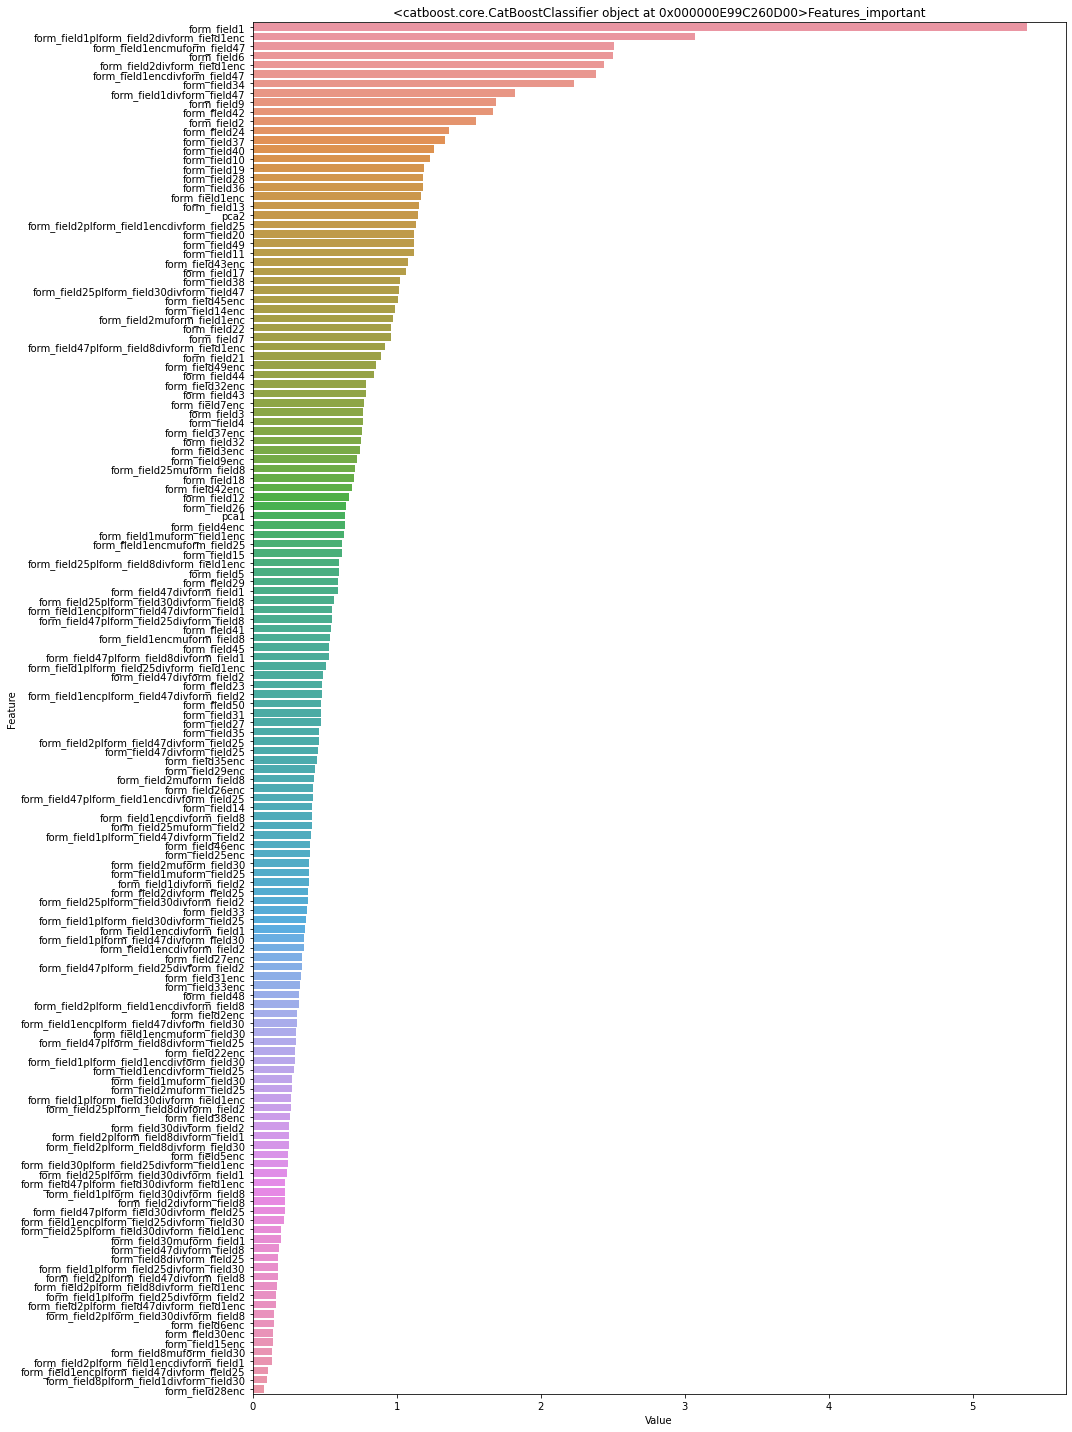

In [45]:
feat_imp_ploter(cat,new_train)

In [47]:
kf = StratifiedKFold(n_splits=10,random_state=43,shuffle=True)
scores1 = []
test_scores1 = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(kf.split(new,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    xgb= XGBClassifier(learning_rate = 0.1, max_depth = 7,objective="binary:logistic", random_state=42,eval_metric='auc')
# xgb_model.fit(X, y)
    xgb.fit(X,y,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500)
    scores1.append(np.sqrt(log_loss(y_test,xgb.predict(X_test))))
    print(np.sqrt(log_loss(y_test,cat.predict(X_test))))
    test_scores1 += xgb.predict_proba(test)[:,1]

================================Fold0====================================
[0]	validation_0-auc:0.82874	validation_1-auc:0.82774
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[1]	validation_0-auc:0.84067	validation_1-auc:0.84106
[2]	validation_0-auc:0.84431	validation_1-auc:0.84674
[3]	validation_0-auc:0.84747	validation_1-auc:0.84997
[4]	validation_0-auc:0.84940	validation_1-auc:0.85217
[5]	validation_0-auc:0.85150	validation_1-auc:0.85520
[6]	validation_0-auc:0.85318	validation_1-auc:0.85618
[7]	validation_0-auc:0.85474	validation_1-auc:0.85703
[8]	validation_0-auc:0.85645	validation_1-auc:0.85821
[9]	validation_0-auc:0.85801	validation_1-auc:0.85993
[10]	validation_0-auc:0.85958	validation_1-auc:0.86104
[11]	validation_0-auc:0.86086	validation_1-auc:0.86259
[12]	validation_0-auc:0.86184	validation_1-auc:0.86379
[13]	validation_0-auc:0.86311	validation_1-auc:0.86514
[14]	val

[41]	validation_0-auc:0.88771	validation_1-auc:0.88943
[42]	validation_0-auc:0.88843	validation_1-auc:0.88985
[43]	validation_0-auc:0.88935	validation_1-auc:0.89080
[44]	validation_0-auc:0.88978	validation_1-auc:0.89121
[45]	validation_0-auc:0.89043	validation_1-auc:0.89185
[46]	validation_0-auc:0.89151	validation_1-auc:0.89293
[47]	validation_0-auc:0.89226	validation_1-auc:0.89360
[48]	validation_0-auc:0.89268	validation_1-auc:0.89385
[49]	validation_0-auc:0.89347	validation_1-auc:0.89448
[50]	validation_0-auc:0.89400	validation_1-auc:0.89488
[51]	validation_0-auc:0.89487	validation_1-auc:0.89578
[52]	validation_0-auc:0.89533	validation_1-auc:0.89616
[53]	validation_0-auc:0.89596	validation_1-auc:0.89691
[54]	validation_0-auc:0.89727	validation_1-auc:0.89802
[55]	validation_0-auc:0.89807	validation_1-auc:0.89899
[56]	validation_0-auc:0.89849	validation_1-auc:0.89939
[57]	validation_0-auc:0.89906	validation_1-auc:0.89988
[58]	validation_0-auc:0.89959	validation_1-auc:0.90051
[59]	valid

[86]	validation_0-auc:0.91239	validation_1-auc:0.91393
[87]	validation_0-auc:0.91259	validation_1-auc:0.91415
[88]	validation_0-auc:0.91299	validation_1-auc:0.91461
[89]	validation_0-auc:0.91307	validation_1-auc:0.91469
[90]	validation_0-auc:0.91321	validation_1-auc:0.91485
[91]	validation_0-auc:0.91379	validation_1-auc:0.91544
[92]	validation_0-auc:0.91485	validation_1-auc:0.91654
[93]	validation_0-auc:0.91502	validation_1-auc:0.91672
[94]	validation_0-auc:0.91523	validation_1-auc:0.91685
[95]	validation_0-auc:0.91617	validation_1-auc:0.91778
[96]	validation_0-auc:0.91629	validation_1-auc:0.91792
[97]	validation_0-auc:0.91662	validation_1-auc:0.91825
[98]	validation_0-auc:0.91693	validation_1-auc:0.91850
[99]	validation_0-auc:0.91763	validation_1-auc:0.91922
2.274791502126941
================================Fold3====================================
[0]	validation_0-auc:0.82880	validation_1-auc:0.82735
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early st

[27]	validation_0-auc:0.87775	validation_1-auc:0.87307
[28]	validation_0-auc:0.87854	validation_1-auc:0.87386
[29]	validation_0-auc:0.87917	validation_1-auc:0.87480
[30]	validation_0-auc:0.88016	validation_1-auc:0.87568
[31]	validation_0-auc:0.88108	validation_1-auc:0.87683
[32]	validation_0-auc:0.88183	validation_1-auc:0.87752
[33]	validation_0-auc:0.88255	validation_1-auc:0.87816
[34]	validation_0-auc:0.88335	validation_1-auc:0.87911
[35]	validation_0-auc:0.88403	validation_1-auc:0.87973
[36]	validation_0-auc:0.88493	validation_1-auc:0.88065
[37]	validation_0-auc:0.88594	validation_1-auc:0.88149
[38]	validation_0-auc:0.88645	validation_1-auc:0.88223
[39]	validation_0-auc:0.88731	validation_1-auc:0.88291
[40]	validation_0-auc:0.88764	validation_1-auc:0.88321
[41]	validation_0-auc:0.88833	validation_1-auc:0.88381
[42]	validation_0-auc:0.88900	validation_1-auc:0.88468
[43]	validation_0-auc:0.88993	validation_1-auc:0.88550
[44]	validation_0-auc:0.89036	validation_1-auc:0.88582
[45]	valid

[72]	validation_0-auc:0.90686	validation_1-auc:0.90923
[73]	validation_0-auc:0.90716	validation_1-auc:0.90953
[74]	validation_0-auc:0.90733	validation_1-auc:0.90972
[75]	validation_0-auc:0.90757	validation_1-auc:0.90997
[76]	validation_0-auc:0.90786	validation_1-auc:0.91025
[77]	validation_0-auc:0.90809	validation_1-auc:0.91042
[78]	validation_0-auc:0.90868	validation_1-auc:0.91112
[79]	validation_0-auc:0.90951	validation_1-auc:0.91218
[80]	validation_0-auc:0.90986	validation_1-auc:0.91254
[81]	validation_0-auc:0.91049	validation_1-auc:0.91306
[82]	validation_0-auc:0.91096	validation_1-auc:0.91351
[83]	validation_0-auc:0.91110	validation_1-auc:0.91366
[84]	validation_0-auc:0.91151	validation_1-auc:0.91407
[85]	validation_0-auc:0.91167	validation_1-auc:0.91420
[86]	validation_0-auc:0.91230	validation_1-auc:0.91482
[87]	validation_0-auc:0.91249	validation_1-auc:0.91501
[88]	validation_0-auc:0.91290	validation_1-auc:0.91536
[89]	validation_0-auc:0.91299	validation_1-auc:0.91546
[90]	valid

[13]	validation_0-auc:0.86330	validation_1-auc:0.86328
[14]	validation_0-auc:0.86451	validation_1-auc:0.86438
[15]	validation_0-auc:0.86581	validation_1-auc:0.86556
[16]	validation_0-auc:0.86687	validation_1-auc:0.86708
[17]	validation_0-auc:0.86783	validation_1-auc:0.86819
[18]	validation_0-auc:0.86886	validation_1-auc:0.86935
[19]	validation_0-auc:0.86976	validation_1-auc:0.87066
[20]	validation_0-auc:0.87094	validation_1-auc:0.87157
[21]	validation_0-auc:0.87194	validation_1-auc:0.87268
[22]	validation_0-auc:0.87296	validation_1-auc:0.87402
[23]	validation_0-auc:0.87387	validation_1-auc:0.87505
[24]	validation_0-auc:0.87473	validation_1-auc:0.87602
[25]	validation_0-auc:0.87566	validation_1-auc:0.87687
[26]	validation_0-auc:0.87640	validation_1-auc:0.87776
[27]	validation_0-auc:0.87712	validation_1-auc:0.87878
[28]	validation_0-auc:0.87792	validation_1-auc:0.87941
[29]	validation_0-auc:0.87858	validation_1-auc:0.88011
[30]	validation_0-auc:0.87956	validation_1-auc:0.88116
[31]	valid

[58]	validation_0-auc:0.89870	validation_1-auc:0.90818
[59]	validation_0-auc:0.89914	validation_1-auc:0.90867
[60]	validation_0-auc:0.89967	validation_1-auc:0.90932
[61]	validation_0-auc:0.90044	validation_1-auc:0.90995
[62]	validation_0-auc:0.90144	validation_1-auc:0.91103
[63]	validation_0-auc:0.90191	validation_1-auc:0.91142
[64]	validation_0-auc:0.90226	validation_1-auc:0.91167
[65]	validation_0-auc:0.90290	validation_1-auc:0.91231
[66]	validation_0-auc:0.90380	validation_1-auc:0.91303
[67]	validation_0-auc:0.90391	validation_1-auc:0.91309
[68]	validation_0-auc:0.90465	validation_1-auc:0.91369
[69]	validation_0-auc:0.90506	validation_1-auc:0.91392
[70]	validation_0-auc:0.90546	validation_1-auc:0.91427
[71]	validation_0-auc:0.90569	validation_1-auc:0.91442
[72]	validation_0-auc:0.90621	validation_1-auc:0.91477
[73]	validation_0-auc:0.90651	validation_1-auc:0.91507
[74]	validation_0-auc:0.90668	validation_1-auc:0.91527
[75]	validation_0-auc:0.90692	validation_1-auc:0.91548
[76]	valid

## Blending

In [ ]:
submit(combo,1,'combo')

In [93]:
cat1=pd.read_csv('catdrop250modelnew')['default_status']

In [47]:
cat = pd.read_csv('blend5new6')['default_status']

In [48]:
cat2 = pd.read_csv('cat1+restart+lgb3')['default_status']

In [6]:
NN=pd.read_csv('nn_pred.csv')

In [49]:
LGB1=pd.read_csv('lgb3')['default_status']

In [8]:
LGB1=pd.read_csv('lgbmodel3new8')['default_status']

In [50]:
jj = pd.read_csv('jj')['default_status']

In [73]:
jes= pd.read_csv('Jesus take control3bc')['default_status']

In [70]:
jes.describe()

default_status
count    24000.000000
mean         0.103330
std          0.236902
min         -0.137243
25%         -0.092263
50%          0.026385
75%          0.229641
max          0.860286

In [101]:
___ = ((jes + b)/ 2) * 0.99 - cat1 * 0.01

In [103]:
submit(___,1,'hmmmm1')

In [52]:
b = pd.read_csv('blend5new6')['default_status']

In [53]:
j = pd.read_csv('Jesus take control3')['default_status']

In [54]:
rcf = pd.read_csv('blend5new3')['default_status']

In [65]:
Him = (j * 0.8 + jes * 0.2) * 0.7 + b * 0.3

In [67]:
submit(Him,1,'help')

In [58]:
__ = (rcf * 0.5 + b * 0.5)* 0.8 +cat1*0.2

In [59]:
submit(__,1,'combo3')

In [21]:
combo = (cat + jj + jes + j + rcf + cat) /5

In [64]:
avr = (cat*0.7 + LGB1* 0.3)

In [35]:
_ = cat2['default_status']*0.65+cat2["default_status"]*0.35

In [5]:
b=pd.read_csv('xgb2')

In [24]:
avr = (cat1*0.5+cat2*0.5)*0.7 + (cat*0.7 +LGB1 * 0.3)*0.3

In [104]:
avr = (cat1*0.2+rcf*0.8)*0.8 + LGB1 * 0.2#best

In [48]:
blend3 = (cat * 0.5 + cat2* 0.3 + LGB1 * 0.2)*0.1 +(agg*0.55) + (b * 0.35)

In [26]:
a =(avr+rcf['default_status'])/2

In [105]:
avr

0        0.316883
1        0.352991
2        0.314582
3        0.756665
4        0.142597
           ...   
23995    0.762391
23996    0.247107
23997    0.245028
23998    0.541318
23999    0.210106
Name: default_status, Length: 24000, dtype: float64

# STACKING

In [86]:
 X_train, X_test, y_train, y_test = train_test_split(new, y, test_size=0.33, random_state=30)

In [91]:
catmodel = CatBoostClassifier(iterations=1000, learning_rate=0.1, l2_leaf_reg=12, depth=4, loss_function= 'Logloss',
    border_count=100, eval_metric='AUC')

In [104]:
seed = 7
model1 = BaggingClassifier(base_estimator = catmodel, n_estimators =20,random_state =seed)
model1.fit(X_train, y_train)
preds = model1.predict_proba(X_test)
# Score
print(np.sqrt(log_loss(y_test,preds)))

0:	total: 84.7ms	remaining: 1m 24s
1:	total: 248ms	remaining: 2m 3s
2:	total: 451ms	remaining: 2m 29s
3:	total: 633ms	remaining: 2m 37s
4:	total: 804ms	remaining: 2m 40s
5:	total: 934ms	remaining: 2m 34s
6:	total: 1.01s	remaining: 2m 23s
7:	total: 1.09s	remaining: 2m 15s
8:	total: 1.28s	remaining: 2m 20s
9:	total: 1.44s	remaining: 2m 22s
10:	total: 1.66s	remaining: 2m 29s
11:	total: 1.82s	remaining: 2m 29s
12:	total: 2.05s	remaining: 2m 35s
13:	total: 2.19s	remaining: 2m 34s
14:	total: 2.37s	remaining: 2m 35s
15:	total: 2.55s	remaining: 2m 36s
16:	total: 2.75s	remaining: 2m 38s
17:	total: 2.87s	remaining: 2m 36s
18:	total: 3.02s	remaining: 2m 36s
19:	total: 3.18s	remaining: 2m 36s
20:	total: 3.38s	remaining: 2m 37s
21:	total: 3.52s	remaining: 2m 36s
22:	total: 3.7s	remaining: 2m 37s
23:	total: 3.85s	remaining: 2m 36s
24:	total: 4.05s	remaining: 2m 38s
25:	total: 4.19s	remaining: 2m 36s
26:	total: 4.39s	remaining: 2m 38s
27:	total: 4.54s	remaining: 2m 37s
28:	total: 4.72s	remaining: 2m 

233:	total: 28.7s	remaining: 1m 34s
234:	total: 28.9s	remaining: 1m 34s
235:	total: 29.1s	remaining: 1m 34s
236:	total: 29.1s	remaining: 1m 33s
237:	total: 29.2s	remaining: 1m 33s
238:	total: 29.2s	remaining: 1m 33s
239:	total: 29.3s	remaining: 1m 32s
240:	total: 29.4s	remaining: 1m 32s
241:	total: 29.4s	remaining: 1m 32s
242:	total: 29.5s	remaining: 1m 31s
243:	total: 29.6s	remaining: 1m 31s
244:	total: 29.6s	remaining: 1m 31s
245:	total: 29.7s	remaining: 1m 30s
246:	total: 29.8s	remaining: 1m 30s
247:	total: 29.8s	remaining: 1m 30s
248:	total: 29.9s	remaining: 1m 30s
249:	total: 30s	remaining: 1m 29s
250:	total: 30.1s	remaining: 1m 29s
251:	total: 30.2s	remaining: 1m 29s
252:	total: 30.4s	remaining: 1m 29s
253:	total: 30.5s	remaining: 1m 29s
254:	total: 30.7s	remaining: 1m 29s
255:	total: 30.8s	remaining: 1m 29s
256:	total: 31s	remaining: 1m 29s
257:	total: 31.1s	remaining: 1m 29s
258:	total: 31.3s	remaining: 1m 29s
259:	total: 31.4s	remaining: 1m 29s
260:	total: 31.6s	remaining: 1m 

464:	total: 55.8s	remaining: 1m 4s
465:	total: 55.9s	remaining: 1m 4s
466:	total: 55.9s	remaining: 1m 3s
467:	total: 56s	remaining: 1m 3s
468:	total: 56.1s	remaining: 1m 3s
469:	total: 56.2s	remaining: 1m 3s
470:	total: 56.3s	remaining: 1m 3s
471:	total: 56.4s	remaining: 1m 3s
472:	total: 56.4s	remaining: 1m 2s
473:	total: 56.5s	remaining: 1m 2s
474:	total: 56.6s	remaining: 1m 2s
475:	total: 56.7s	remaining: 1m 2s
476:	total: 56.8s	remaining: 1m 2s
477:	total: 56.9s	remaining: 1m 2s
478:	total: 56.9s	remaining: 1m 1s
479:	total: 57s	remaining: 1m 1s
480:	total: 57.1s	remaining: 1m 1s
481:	total: 57.2s	remaining: 1m 1s
482:	total: 57.3s	remaining: 1m 1s
483:	total: 57.3s	remaining: 1m 1s
484:	total: 57.4s	remaining: 1m
485:	total: 57.5s	remaining: 1m
486:	total: 57.6s	remaining: 1m
487:	total: 57.7s	remaining: 1m
488:	total: 57.7s	remaining: 1m
489:	total: 57.8s	remaining: 1m
490:	total: 57.9s	remaining: 1m
491:	total: 58s	remaining: 59.9s
492:	total: 58.1s	remaining: 59.7s
493:	total: 

700:	total: 1m 22s	remaining: 35.1s
701:	total: 1m 22s	remaining: 35s
702:	total: 1m 22s	remaining: 34.9s
703:	total: 1m 22s	remaining: 34.8s
704:	total: 1m 22s	remaining: 34.7s
705:	total: 1m 23s	remaining: 34.6s
706:	total: 1m 23s	remaining: 34.5s
707:	total: 1m 23s	remaining: 34.4s
708:	total: 1m 23s	remaining: 34.3s
709:	total: 1m 23s	remaining: 34.2s
710:	total: 1m 23s	remaining: 34.1s
711:	total: 1m 23s	remaining: 34s
712:	total: 1m 24s	remaining: 33.9s
713:	total: 1m 24s	remaining: 33.7s
714:	total: 1m 24s	remaining: 33.6s
715:	total: 1m 24s	remaining: 33.5s
716:	total: 1m 24s	remaining: 33.4s
717:	total: 1m 24s	remaining: 33.3s
718:	total: 1m 25s	remaining: 33.2s
719:	total: 1m 25s	remaining: 33.1s
720:	total: 1m 25s	remaining: 33s
721:	total: 1m 25s	remaining: 32.8s
722:	total: 1m 25s	remaining: 32.7s
723:	total: 1m 25s	remaining: 32.6s
724:	total: 1m 25s	remaining: 32.5s
725:	total: 1m 25s	remaining: 32.3s
726:	total: 1m 25s	remaining: 32.2s
727:	total: 1m 25s	remaining: 32.1

929:	total: 1m 49s	remaining: 8.22s
930:	total: 1m 49s	remaining: 8.1s
931:	total: 1m 49s	remaining: 7.98s
932:	total: 1m 49s	remaining: 7.86s
933:	total: 1m 49s	remaining: 7.74s
934:	total: 1m 49s	remaining: 7.62s
935:	total: 1m 49s	remaining: 7.5s
936:	total: 1m 49s	remaining: 7.38s
937:	total: 1m 49s	remaining: 7.26s
938:	total: 1m 50s	remaining: 7.14s
939:	total: 1m 50s	remaining: 7.03s
940:	total: 1m 50s	remaining: 6.91s
941:	total: 1m 50s	remaining: 6.79s
942:	total: 1m 50s	remaining: 6.67s
943:	total: 1m 50s	remaining: 6.55s
944:	total: 1m 50s	remaining: 6.43s
945:	total: 1m 50s	remaining: 6.31s
946:	total: 1m 50s	remaining: 6.19s
947:	total: 1m 50s	remaining: 6.07s
948:	total: 1m 50s	remaining: 5.95s
949:	total: 1m 50s	remaining: 5.83s
950:	total: 1m 50s	remaining: 5.72s
951:	total: 1m 51s	remaining: 5.6s
952:	total: 1m 51s	remaining: 5.49s
953:	total: 1m 51s	remaining: 5.37s
954:	total: 1m 51s	remaining: 5.26s
955:	total: 1m 51s	remaining: 5.14s
956:	total: 1m 51s	remaining: 5

162:	total: 19.3s	remaining: 1m 39s
163:	total: 19.4s	remaining: 1m 39s
164:	total: 19.6s	remaining: 1m 39s
165:	total: 19.7s	remaining: 1m 39s
166:	total: 19.9s	remaining: 1m 39s
167:	total: 19.9s	remaining: 1m 38s
168:	total: 20s	remaining: 1m 38s
169:	total: 20s	remaining: 1m 37s
170:	total: 20s	remaining: 1m 37s
171:	total: 20.1s	remaining: 1m 36s
172:	total: 20.2s	remaining: 1m 36s
173:	total: 20.2s	remaining: 1m 35s
174:	total: 20.3s	remaining: 1m 35s
175:	total: 20.3s	remaining: 1m 35s
176:	total: 20.4s	remaining: 1m 34s
177:	total: 20.5s	remaining: 1m 34s
178:	total: 20.5s	remaining: 1m 34s
179:	total: 20.6s	remaining: 1m 33s
180:	total: 20.7s	remaining: 1m 33s
181:	total: 20.8s	remaining: 1m 33s
182:	total: 20.8s	remaining: 1m 32s
183:	total: 20.9s	remaining: 1m 32s
184:	total: 21.1s	remaining: 1m 32s
185:	total: 21.3s	remaining: 1m 33s
186:	total: 21.4s	remaining: 1m 33s
187:	total: 21.6s	remaining: 1m 33s
188:	total: 21.7s	remaining: 1m 33s
189:	total: 21.9s	remaining: 1m 33

392:	total: 45.2s	remaining: 1m 9s
393:	total: 45.3s	remaining: 1m 9s
394:	total: 45.5s	remaining: 1m 9s
395:	total: 45.7s	remaining: 1m 9s
396:	total: 45.8s	remaining: 1m 9s
397:	total: 46s	remaining: 1m 9s
398:	total: 46.1s	remaining: 1m 9s
399:	total: 46.3s	remaining: 1m 9s
400:	total: 46.4s	remaining: 1m 9s
401:	total: 46.6s	remaining: 1m 9s
402:	total: 46.7s	remaining: 1m 9s
403:	total: 46.9s	remaining: 1m 9s
404:	total: 47s	remaining: 1m 9s
405:	total: 47.2s	remaining: 1m 9s
406:	total: 47.3s	remaining: 1m 8s
407:	total: 47.5s	remaining: 1m 8s
408:	total: 47.6s	remaining: 1m 8s
409:	total: 47.8s	remaining: 1m 8s
410:	total: 47.8s	remaining: 1m 8s
411:	total: 47.9s	remaining: 1m 8s
412:	total: 47.9s	remaining: 1m 8s
413:	total: 48s	remaining: 1m 7s
414:	total: 48s	remaining: 1m 7s
415:	total: 48.1s	remaining: 1m 7s
416:	total: 48.2s	remaining: 1m 7s
417:	total: 48.2s	remaining: 1m 7s
418:	total: 48.3s	remaining: 1m 6s
419:	total: 48.4s	remaining: 1m 6s
420:	total: 48.4s	remaining:

630:	total: 1m 13s	remaining: 42.7s
631:	total: 1m 13s	remaining: 42.6s
632:	total: 1m 13s	remaining: 42.6s
633:	total: 1m 13s	remaining: 42.5s
634:	total: 1m 13s	remaining: 42.4s
635:	total: 1m 13s	remaining: 42.3s
636:	total: 1m 14s	remaining: 42.2s
637:	total: 1m 14s	remaining: 42.1s
638:	total: 1m 14s	remaining: 42s
639:	total: 1m 14s	remaining: 41.9s
640:	total: 1m 14s	remaining: 41.8s
641:	total: 1m 14s	remaining: 41.7s
642:	total: 1m 14s	remaining: 41.6s
643:	total: 1m 15s	remaining: 41.5s
644:	total: 1m 15s	remaining: 41.4s
645:	total: 1m 15s	remaining: 41.3s
646:	total: 1m 15s	remaining: 41.2s
647:	total: 1m 15s	remaining: 41.1s
648:	total: 1m 15s	remaining: 40.9s
649:	total: 1m 15s	remaining: 40.8s
650:	total: 1m 15s	remaining: 40.7s
651:	total: 1m 15s	remaining: 40.5s
652:	total: 1m 15s	remaining: 40.4s
653:	total: 1m 16s	remaining: 40.2s
654:	total: 1m 16s	remaining: 40.1s
655:	total: 1m 16s	remaining: 39.9s
656:	total: 1m 16s	remaining: 39.8s
657:	total: 1m 16s	remaining: 

859:	total: 1m 38s	remaining: 16s
860:	total: 1m 38s	remaining: 15.9s
861:	total: 1m 38s	remaining: 15.8s
862:	total: 1m 38s	remaining: 15.7s
863:	total: 1m 39s	remaining: 15.6s
864:	total: 1m 39s	remaining: 15.5s
865:	total: 1m 39s	remaining: 15.4s
866:	total: 1m 39s	remaining: 15.3s
867:	total: 1m 39s	remaining: 15.2s
868:	total: 1m 39s	remaining: 15s
869:	total: 1m 39s	remaining: 14.9s
870:	total: 1m 40s	remaining: 14.8s
871:	total: 1m 40s	remaining: 14.7s
872:	total: 1m 40s	remaining: 14.6s
873:	total: 1m 40s	remaining: 14.5s
874:	total: 1m 40s	remaining: 14.4s
875:	total: 1m 40s	remaining: 14.3s
876:	total: 1m 40s	remaining: 14.1s
877:	total: 1m 40s	remaining: 14s
878:	total: 1m 40s	remaining: 13.9s
879:	total: 1m 41s	remaining: 13.8s
880:	total: 1m 41s	remaining: 13.7s
881:	total: 1m 41s	remaining: 13.6s
882:	total: 1m 41s	remaining: 13.4s
883:	total: 1m 41s	remaining: 13.3s
884:	total: 1m 41s	remaining: 13.2s
885:	total: 1m 41s	remaining: 13.1s
886:	total: 1m 41s	remaining: 13s


93:	total: 11s	remaining: 1m 45s
94:	total: 11s	remaining: 1m 45s
95:	total: 11.1s	remaining: 1m 44s
96:	total: 11.2s	remaining: 1m 44s
97:	total: 11.3s	remaining: 1m 44s
98:	total: 11.4s	remaining: 1m 43s
99:	total: 11.5s	remaining: 1m 43s
100:	total: 11.5s	remaining: 1m 42s
101:	total: 11.6s	remaining: 1m 42s
102:	total: 11.8s	remaining: 1m 42s
103:	total: 11.9s	remaining: 1m 42s
104:	total: 12.1s	remaining: 1m 42s
105:	total: 12.2s	remaining: 1m 42s
106:	total: 12.4s	remaining: 1m 43s
107:	total: 12.5s	remaining: 1m 43s
108:	total: 12.7s	remaining: 1m 43s
109:	total: 12.8s	remaining: 1m 43s
110:	total: 12.9s	remaining: 1m 43s
111:	total: 13.1s	remaining: 1m 43s
112:	total: 13.2s	remaining: 1m 43s
113:	total: 13.4s	remaining: 1m 43s
114:	total: 13.5s	remaining: 1m 44s
115:	total: 13.7s	remaining: 1m 44s
116:	total: 13.8s	remaining: 1m 44s
117:	total: 14s	remaining: 1m 44s
118:	total: 14.2s	remaining: 1m 44s
119:	total: 14.3s	remaining: 1m 45s
120:	total: 14.5s	remaining: 1m 45s
121:	

324:	total: 37.9s	remaining: 1m 18s
325:	total: 38s	remaining: 1m 18s
326:	total: 38s	remaining: 1m 18s
327:	total: 38.1s	remaining: 1m 18s
328:	total: 38.2s	remaining: 1m 17s
329:	total: 38.3s	remaining: 1m 17s
330:	total: 38.4s	remaining: 1m 17s
331:	total: 38.4s	remaining: 1m 17s
332:	total: 38.5s	remaining: 1m 17s
333:	total: 38.6s	remaining: 1m 16s
334:	total: 38.7s	remaining: 1m 16s
335:	total: 38.8s	remaining: 1m 16s
336:	total: 38.9s	remaining: 1m 16s
337:	total: 38.9s	remaining: 1m 16s
338:	total: 39s	remaining: 1m 16s
339:	total: 39.1s	remaining: 1m 15s
340:	total: 39.2s	remaining: 1m 15s
341:	total: 39.3s	remaining: 1m 15s
342:	total: 39.4s	remaining: 1m 15s
343:	total: 39.4s	remaining: 1m 15s
344:	total: 39.5s	remaining: 1m 15s
345:	total: 39.6s	remaining: 1m 14s
346:	total: 39.7s	remaining: 1m 14s
347:	total: 39.8s	remaining: 1m 14s
348:	total: 39.9s	remaining: 1m 14s
349:	total: 40s	remaining: 1m 14s
350:	total: 40.1s	remaining: 1m 14s
351:	total: 40.2s	remaining: 1m 13s


562:	total: 1m 5s	remaining: 51s
563:	total: 1m 5s	remaining: 50.8s
564:	total: 1m 5s	remaining: 50.7s
565:	total: 1m 5s	remaining: 50.6s
566:	total: 1m 6s	remaining: 50.4s
567:	total: 1m 6s	remaining: 50.3s
568:	total: 1m 6s	remaining: 50.1s
569:	total: 1m 6s	remaining: 50s
570:	total: 1m 6s	remaining: 49.8s
571:	total: 1m 6s	remaining: 49.7s
572:	total: 1m 6s	remaining: 49.5s
573:	total: 1m 6s	remaining: 49.4s
574:	total: 1m 6s	remaining: 49.3s
575:	total: 1m 6s	remaining: 49.1s
576:	total: 1m 6s	remaining: 49s
577:	total: 1m 6s	remaining: 48.8s
578:	total: 1m 6s	remaining: 48.7s
579:	total: 1m 7s	remaining: 48.5s
580:	total: 1m 7s	remaining: 48.4s
581:	total: 1m 7s	remaining: 48.3s
582:	total: 1m 7s	remaining: 48.1s
583:	total: 1m 7s	remaining: 48s
584:	total: 1m 7s	remaining: 47.9s
585:	total: 1m 7s	remaining: 47.7s
586:	total: 1m 7s	remaining: 47.6s
587:	total: 1m 7s	remaining: 47.4s
588:	total: 1m 7s	remaining: 47.3s
589:	total: 1m 7s	remaining: 47.2s
590:	total: 1m 7s	remaining:

793:	total: 1m 31s	remaining: 23.7s
794:	total: 1m 31s	remaining: 23.6s
795:	total: 1m 31s	remaining: 23.5s
796:	total: 1m 31s	remaining: 23.4s
797:	total: 1m 31s	remaining: 23.2s
798:	total: 1m 31s	remaining: 23.1s
799:	total: 1m 31s	remaining: 23s
800:	total: 1m 32s	remaining: 22.9s
801:	total: 1m 32s	remaining: 22.7s
802:	total: 1m 32s	remaining: 22.6s
803:	total: 1m 32s	remaining: 22.5s
804:	total: 1m 32s	remaining: 22.4s
805:	total: 1m 32s	remaining: 22.2s
806:	total: 1m 32s	remaining: 22.1s
807:	total: 1m 32s	remaining: 22s
808:	total: 1m 32s	remaining: 21.9s
809:	total: 1m 33s	remaining: 21.8s
810:	total: 1m 33s	remaining: 21.7s
811:	total: 1m 33s	remaining: 21.6s
812:	total: 1m 33s	remaining: 21.5s
813:	total: 1m 33s	remaining: 21.4s
814:	total: 1m 33s	remaining: 21.3s
815:	total: 1m 33s	remaining: 21.2s
816:	total: 1m 34s	remaining: 21.1s
817:	total: 1m 34s	remaining: 21s
818:	total: 1m 34s	remaining: 20.9s
819:	total: 1m 34s	remaining: 20.8s
820:	total: 1m 34s	remaining: 20.6

23:	total: 2.22s	remaining: 1m 30s
24:	total: 2.32s	remaining: 1m 30s
25:	total: 2.4s	remaining: 1m 29s
26:	total: 2.5s	remaining: 1m 30s
27:	total: 2.57s	remaining: 1m 29s
28:	total: 2.65s	remaining: 1m 28s
29:	total: 2.76s	remaining: 1m 29s
30:	total: 2.84s	remaining: 1m 28s
31:	total: 2.92s	remaining: 1m 28s
32:	total: 3.01s	remaining: 1m 28s
33:	total: 3.08s	remaining: 1m 27s
34:	total: 3.16s	remaining: 1m 27s
35:	total: 3.25s	remaining: 1m 26s
36:	total: 3.32s	remaining: 1m 26s
37:	total: 3.4s	remaining: 1m 25s
38:	total: 3.5s	remaining: 1m 26s
39:	total: 3.58s	remaining: 1m 25s
40:	total: 3.67s	remaining: 1m 25s
41:	total: 3.77s	remaining: 1m 26s
42:	total: 3.85s	remaining: 1m 25s
43:	total: 3.92s	remaining: 1m 25s
44:	total: 4.02s	remaining: 1m 25s
45:	total: 4.1s	remaining: 1m 25s
46:	total: 4.17s	remaining: 1m 24s
47:	total: 4.27s	remaining: 1m 24s
48:	total: 4.34s	remaining: 1m 24s
49:	total: 4.41s	remaining: 1m 23s
50:	total: 4.5s	remaining: 1m 23s
51:	total: 4.58s	remaining

255:	total: 28.5s	remaining: 1m 22s
256:	total: 28.7s	remaining: 1m 22s
257:	total: 28.8s	remaining: 1m 22s
258:	total: 29s	remaining: 1m 23s
259:	total: 29.2s	remaining: 1m 23s
260:	total: 29.4s	remaining: 1m 23s
261:	total: 29.5s	remaining: 1m 23s
262:	total: 29.7s	remaining: 1m 23s
263:	total: 29.8s	remaining: 1m 23s
264:	total: 30s	remaining: 1m 23s
265:	total: 30.1s	remaining: 1m 22s
266:	total: 30.2s	remaining: 1m 22s
267:	total: 30.3s	remaining: 1m 22s
268:	total: 30.5s	remaining: 1m 22s
269:	total: 30.6s	remaining: 1m 22s
270:	total: 30.8s	remaining: 1m 22s
271:	total: 30.9s	remaining: 1m 22s
272:	total: 31.1s	remaining: 1m 22s
273:	total: 31.2s	remaining: 1m 22s
274:	total: 31.2s	remaining: 1m 22s
275:	total: 31.3s	remaining: 1m 22s
276:	total: 31.3s	remaining: 1m 21s
277:	total: 31.4s	remaining: 1m 21s
278:	total: 31.5s	remaining: 1m 21s
279:	total: 31.5s	remaining: 1m 21s
280:	total: 31.6s	remaining: 1m 20s
281:	total: 31.6s	remaining: 1m 20s
282:	total: 31.7s	remaining: 1m 

489:	total: 54.7s	remaining: 56.9s
490:	total: 54.8s	remaining: 56.8s
491:	total: 54.9s	remaining: 56.7s
492:	total: 55s	remaining: 56.5s
493:	total: 55.1s	remaining: 56.4s
494:	total: 55.2s	remaining: 56.3s
495:	total: 55.3s	remaining: 56.2s
496:	total: 55.4s	remaining: 56.1s
497:	total: 55.6s	remaining: 56.1s
498:	total: 55.7s	remaining: 56s
499:	total: 55.9s	remaining: 55.9s
500:	total: 56s	remaining: 55.8s
501:	total: 56.2s	remaining: 55.7s
502:	total: 56.3s	remaining: 55.7s
503:	total: 56.5s	remaining: 55.6s
504:	total: 56.6s	remaining: 55.5s
505:	total: 56.8s	remaining: 55.4s
506:	total: 56.9s	remaining: 55.3s
507:	total: 57.1s	remaining: 55.3s
508:	total: 57.2s	remaining: 55.2s
509:	total: 57.4s	remaining: 55.2s
510:	total: 57.5s	remaining: 55.1s
511:	total: 57.7s	remaining: 55s
512:	total: 57.8s	remaining: 54.9s
513:	total: 58s	remaining: 54.9s
514:	total: 58.2s	remaining: 54.8s
515:	total: 58.3s	remaining: 54.7s
516:	total: 58.5s	remaining: 54.6s
517:	total: 58.6s	remaining: 5

723:	total: 1m 21s	remaining: 31.2s
724:	total: 1m 21s	remaining: 31.1s
725:	total: 1m 22s	remaining: 31s
726:	total: 1m 22s	remaining: 30.8s
727:	total: 1m 22s	remaining: 30.7s
728:	total: 1m 22s	remaining: 30.6s
729:	total: 1m 22s	remaining: 30.5s
730:	total: 1m 22s	remaining: 30.3s
731:	total: 1m 22s	remaining: 30.2s
732:	total: 1m 22s	remaining: 30.1s
733:	total: 1m 22s	remaining: 30s
734:	total: 1m 22s	remaining: 29.8s
735:	total: 1m 22s	remaining: 29.7s
736:	total: 1m 22s	remaining: 29.6s
737:	total: 1m 22s	remaining: 29.5s
738:	total: 1m 23s	remaining: 29.3s
739:	total: 1m 23s	remaining: 29.2s
740:	total: 1m 23s	remaining: 29.1s
741:	total: 1m 23s	remaining: 29s
742:	total: 1m 23s	remaining: 28.9s
743:	total: 1m 23s	remaining: 28.7s
744:	total: 1m 23s	remaining: 28.6s
745:	total: 1m 23s	remaining: 28.5s
746:	total: 1m 23s	remaining: 28.4s
747:	total: 1m 23s	remaining: 28.2s
748:	total: 1m 23s	remaining: 28.1s
749:	total: 1m 23s	remaining: 28s
750:	total: 1m 24s	remaining: 27.9s


953:	total: 1m 48s	remaining: 5.21s
954:	total: 1m 48s	remaining: 5.1s
955:	total: 1m 48s	remaining: 4.99s
956:	total: 1m 48s	remaining: 4.88s
957:	total: 1m 48s	remaining: 4.77s
958:	total: 1m 48s	remaining: 4.65s
959:	total: 1m 49s	remaining: 4.54s
960:	total: 1m 49s	remaining: 4.43s
961:	total: 1m 49s	remaining: 4.32s
962:	total: 1m 49s	remaining: 4.21s
963:	total: 1m 49s	remaining: 4.09s
964:	total: 1m 49s	remaining: 3.98s
965:	total: 1m 49s	remaining: 3.87s
966:	total: 1m 50s	remaining: 3.75s
967:	total: 1m 50s	remaining: 3.64s
968:	total: 1m 50s	remaining: 3.53s
969:	total: 1m 50s	remaining: 3.42s
970:	total: 1m 50s	remaining: 3.3s
971:	total: 1m 50s	remaining: 3.19s
972:	total: 1m 50s	remaining: 3.08s
973:	total: 1m 51s	remaining: 2.96s
974:	total: 1m 51s	remaining: 2.85s
975:	total: 1m 51s	remaining: 2.73s
976:	total: 1m 51s	remaining: 2.62s
977:	total: 1m 51s	remaining: 2.5s
978:	total: 1m 51s	remaining: 2.39s
979:	total: 1m 51s	remaining: 2.27s
980:	total: 1m 51s	remaining: 2

186:	total: 20.2s	remaining: 1m 27s
187:	total: 20.3s	remaining: 1m 27s
188:	total: 20.5s	remaining: 1m 27s
189:	total: 20.6s	remaining: 1m 27s
190:	total: 20.8s	remaining: 1m 27s
191:	total: 20.9s	remaining: 1m 27s
192:	total: 21.1s	remaining: 1m 28s
193:	total: 21.2s	remaining: 1m 28s
194:	total: 21.4s	remaining: 1m 28s
195:	total: 21.5s	remaining: 1m 28s
196:	total: 21.7s	remaining: 1m 28s
197:	total: 21.8s	remaining: 1m 28s
198:	total: 22s	remaining: 1m 28s
199:	total: 22.1s	remaining: 1m 28s
200:	total: 22.3s	remaining: 1m 28s
201:	total: 22.4s	remaining: 1m 28s
202:	total: 22.5s	remaining: 1m 28s
203:	total: 22.6s	remaining: 1m 28s
204:	total: 22.6s	remaining: 1m 27s
205:	total: 22.7s	remaining: 1m 27s
206:	total: 22.7s	remaining: 1m 27s
207:	total: 22.8s	remaining: 1m 26s
208:	total: 22.8s	remaining: 1m 26s
209:	total: 22.9s	remaining: 1m 26s
210:	total: 23s	remaining: 1m 25s
211:	total: 23s	remaining: 1m 25s
212:	total: 23.1s	remaining: 1m 25s
213:	total: 23.2s	remaining: 1m 25

417:	total: 46.8s	remaining: 1m 5s
418:	total: 46.9s	remaining: 1m 4s
419:	total: 46.9s	remaining: 1m 4s
420:	total: 47s	remaining: 1m 4s
421:	total: 47.1s	remaining: 1m 4s
422:	total: 47.2s	remaining: 1m 4s
423:	total: 47.3s	remaining: 1m 4s
424:	total: 47.4s	remaining: 1m 4s
425:	total: 47.4s	remaining: 1m 3s
426:	total: 47.5s	remaining: 1m 3s
427:	total: 47.6s	remaining: 1m 3s
428:	total: 47.7s	remaining: 1m 3s
429:	total: 47.8s	remaining: 1m 3s
430:	total: 47.8s	remaining: 1m 3s
431:	total: 47.9s	remaining: 1m 2s
432:	total: 48s	remaining: 1m 2s
433:	total: 48.1s	remaining: 1m 2s
434:	total: 48.1s	remaining: 1m 2s
435:	total: 48.2s	remaining: 1m 2s
436:	total: 48.3s	remaining: 1m 2s
437:	total: 48.4s	remaining: 1m 2s
438:	total: 48.5s	remaining: 1m 1s
439:	total: 48.6s	remaining: 1m 1s
440:	total: 48.7s	remaining: 1m 1s
441:	total: 48.8s	remaining: 1m 1s
442:	total: 48.8s	remaining: 1m 1s
443:	total: 48.9s	remaining: 1m 1s
444:	total: 49s	remaining: 1m 1s
445:	total: 49.1s	remainin

657:	total: 1m 13s	remaining: 38.1s
658:	total: 1m 13s	remaining: 38s
659:	total: 1m 13s	remaining: 37.9s
660:	total: 1m 13s	remaining: 37.8s
661:	total: 1m 13s	remaining: 37.7s
662:	total: 1m 14s	remaining: 37.6s
663:	total: 1m 14s	remaining: 37.5s
664:	total: 1m 14s	remaining: 37.4s
665:	total: 1m 14s	remaining: 37.3s
666:	total: 1m 14s	remaining: 37.2s
667:	total: 1m 14s	remaining: 37.1s
668:	total: 1m 14s	remaining: 37.1s
669:	total: 1m 15s	remaining: 37s
670:	total: 1m 15s	remaining: 36.9s
671:	total: 1m 15s	remaining: 36.8s
672:	total: 1m 15s	remaining: 36.7s
673:	total: 1m 15s	remaining: 36.6s
674:	total: 1m 15s	remaining: 36.5s
675:	total: 1m 15s	remaining: 36.4s
676:	total: 1m 16s	remaining: 36.3s
677:	total: 1m 16s	remaining: 36.2s
678:	total: 1m 16s	remaining: 36.1s
679:	total: 1m 16s	remaining: 36s
680:	total: 1m 16s	remaining: 35.9s
681:	total: 1m 16s	remaining: 35.8s
682:	total: 1m 16s	remaining: 35.7s
683:	total: 1m 17s	remaining: 35.6s
684:	total: 1m 17s	remaining: 35.5

889:	total: 1m 41s	remaining: 12.5s
890:	total: 1m 41s	remaining: 12.4s
891:	total: 1m 41s	remaining: 12.3s
892:	total: 1m 41s	remaining: 12.2s
893:	total: 1m 41s	remaining: 12.1s
894:	total: 1m 41s	remaining: 11.9s
895:	total: 1m 41s	remaining: 11.8s
896:	total: 1m 42s	remaining: 11.7s
897:	total: 1m 42s	remaining: 11.6s
898:	total: 1m 42s	remaining: 11.5s
899:	total: 1m 42s	remaining: 11.4s
900:	total: 1m 42s	remaining: 11.2s
901:	total: 1m 42s	remaining: 11.1s
902:	total: 1m 42s	remaining: 11s
903:	total: 1m 42s	remaining: 10.9s
904:	total: 1m 42s	remaining: 10.8s
905:	total: 1m 43s	remaining: 10.7s
906:	total: 1m 43s	remaining: 10.6s
907:	total: 1m 43s	remaining: 10.5s
908:	total: 1m 43s	remaining: 10.4s
909:	total: 1m 43s	remaining: 10.2s
910:	total: 1m 43s	remaining: 10.1s
911:	total: 1m 43s	remaining: 10s
912:	total: 1m 44s	remaining: 9.91s
913:	total: 1m 44s	remaining: 9.8s
914:	total: 1m 44s	remaining: 9.69s
915:	total: 1m 44s	remaining: 9.58s
916:	total: 1m 44s	remaining: 9.4

123:	total: 14.8s	remaining: 1m 44s
124:	total: 15s	remaining: 1m 44s
125:	total: 15.1s	remaining: 1m 44s
126:	total: 15.3s	remaining: 1m 44s
127:	total: 15.4s	remaining: 1m 45s
128:	total: 15.5s	remaining: 1m 44s
129:	total: 15.7s	remaining: 1m 45s
130:	total: 15.8s	remaining: 1m 44s
131:	total: 15.9s	remaining: 1m 44s
132:	total: 16s	remaining: 1m 44s
133:	total: 16.1s	remaining: 1m 43s
134:	total: 16.2s	remaining: 1m 43s
135:	total: 16.3s	remaining: 1m 43s
136:	total: 16.4s	remaining: 1m 43s
137:	total: 16.5s	remaining: 1m 42s
138:	total: 16.6s	remaining: 1m 42s
139:	total: 16.7s	remaining: 1m 42s
140:	total: 16.7s	remaining: 1m 42s
141:	total: 16.9s	remaining: 1m 41s
142:	total: 16.9s	remaining: 1m 41s
143:	total: 17.1s	remaining: 1m 41s
144:	total: 17.1s	remaining: 1m 41s
145:	total: 17.2s	remaining: 1m 40s
146:	total: 17.3s	remaining: 1m 40s
147:	total: 17.4s	remaining: 1m 40s
148:	total: 17.5s	remaining: 1m 40s
149:	total: 17.6s	remaining: 1m 39s
150:	total: 17.7s	remaining: 1m 

353:	total: 41s	remaining: 1m 14s
354:	total: 41.1s	remaining: 1m 14s
355:	total: 41.1s	remaining: 1m 14s
356:	total: 41.2s	remaining: 1m 14s
357:	total: 41.3s	remaining: 1m 14s
358:	total: 41.4s	remaining: 1m 13s
359:	total: 41.5s	remaining: 1m 13s
360:	total: 41.5s	remaining: 1m 13s
361:	total: 41.6s	remaining: 1m 13s
362:	total: 41.7s	remaining: 1m 13s
363:	total: 41.8s	remaining: 1m 13s
364:	total: 41.9s	remaining: 1m 12s
365:	total: 42s	remaining: 1m 12s
366:	total: 42s	remaining: 1m 12s
367:	total: 42.1s	remaining: 1m 12s
368:	total: 42.2s	remaining: 1m 12s
369:	total: 42.3s	remaining: 1m 11s
370:	total: 42.4s	remaining: 1m 11s
371:	total: 42.5s	remaining: 1m 11s
372:	total: 42.5s	remaining: 1m 11s
373:	total: 42.6s	remaining: 1m 11s
374:	total: 42.7s	remaining: 1m 11s
375:	total: 42.8s	remaining: 1m 10s
376:	total: 42.8s	remaining: 1m 10s
377:	total: 42.9s	remaining: 1m 10s
378:	total: 43s	remaining: 1m 10s
379:	total: 43.1s	remaining: 1m 10s
380:	total: 43.2s	remaining: 1m 10s


592:	total: 1m 9s	remaining: 47.5s
593:	total: 1m 9s	remaining: 47.4s
594:	total: 1m 9s	remaining: 47.3s
595:	total: 1m 9s	remaining: 47.1s
596:	total: 1m 9s	remaining: 47s
597:	total: 1m 9s	remaining: 46.9s
598:	total: 1m 9s	remaining: 46.7s
599:	total: 1m 9s	remaining: 46.6s
600:	total: 1m 10s	remaining: 46.5s
601:	total: 1m 10s	remaining: 46.4s
602:	total: 1m 10s	remaining: 46.2s
603:	total: 1m 10s	remaining: 46.1s
604:	total: 1m 10s	remaining: 46s
605:	total: 1m 10s	remaining: 45.9s
606:	total: 1m 10s	remaining: 45.7s
607:	total: 1m 10s	remaining: 45.6s
608:	total: 1m 10s	remaining: 45.5s
609:	total: 1m 10s	remaining: 45.4s
610:	total: 1m 11s	remaining: 45.2s
611:	total: 1m 11s	remaining: 45.1s
612:	total: 1m 11s	remaining: 45s
613:	total: 1m 11s	remaining: 44.9s
614:	total: 1m 11s	remaining: 44.7s
615:	total: 1m 11s	remaining: 44.6s
616:	total: 1m 11s	remaining: 44.5s
617:	total: 1m 11s	remaining: 44.3s
618:	total: 1m 11s	remaining: 44.2s
619:	total: 1m 11s	remaining: 44.1s
620:	t

823:	total: 1m 35s	remaining: 20.4s
824:	total: 1m 35s	remaining: 20.3s
825:	total: 1m 35s	remaining: 20.2s
826:	total: 1m 35s	remaining: 20.1s
827:	total: 1m 36s	remaining: 20s
828:	total: 1m 36s	remaining: 19.9s
829:	total: 1m 36s	remaining: 19.7s
830:	total: 1m 36s	remaining: 19.6s
831:	total: 1m 36s	remaining: 19.5s
832:	total: 1m 36s	remaining: 19.4s
833:	total: 1m 37s	remaining: 19.3s
834:	total: 1m 37s	remaining: 19.2s
835:	total: 1m 37s	remaining: 19.1s
836:	total: 1m 37s	remaining: 19s
837:	total: 1m 37s	remaining: 18.9s
838:	total: 1m 37s	remaining: 18.7s
839:	total: 1m 37s	remaining: 18.6s
840:	total: 1m 37s	remaining: 18.5s
841:	total: 1m 37s	remaining: 18.3s
842:	total: 1m 37s	remaining: 18.2s
843:	total: 1m 37s	remaining: 18.1s
844:	total: 1m 37s	remaining: 18s
845:	total: 1m 38s	remaining: 17.8s
846:	total: 1m 38s	remaining: 17.7s
847:	total: 1m 38s	remaining: 17.6s
848:	total: 1m 38s	remaining: 17.5s
849:	total: 1m 38s	remaining: 17.3s
850:	total: 1m 38s	remaining: 17.2

55:	total: 5.39s	remaining: 1m 30s
56:	total: 5.52s	remaining: 1m 31s
57:	total: 5.68s	remaining: 1m 32s
58:	total: 5.81s	remaining: 1m 32s
59:	total: 5.99s	remaining: 1m 33s
60:	total: 6.19s	remaining: 1m 35s
61:	total: 6.33s	remaining: 1m 35s
62:	total: 6.51s	remaining: 1m 36s
63:	total: 6.64s	remaining: 1m 37s
64:	total: 6.81s	remaining: 1m 37s
65:	total: 6.94s	remaining: 1m 38s
66:	total: 7.12s	remaining: 1m 39s
67:	total: 7.25s	remaining: 1m 39s
68:	total: 7.41s	remaining: 1m 39s
69:	total: 7.53s	remaining: 1m 40s
70:	total: 7.69s	remaining: 1m 40s
71:	total: 7.83s	remaining: 1m 40s
72:	total: 8s	remaining: 1m 41s
73:	total: 8.13s	remaining: 1m 41s
74:	total: 8.29s	remaining: 1m 42s
75:	total: 8.43s	remaining: 1m 42s
76:	total: 8.6s	remaining: 1m 43s
77:	total: 8.74s	remaining: 1m 43s
78:	total: 8.91s	remaining: 1m 43s
79:	total: 9.03s	remaining: 1m 43s
80:	total: 9.2s	remaining: 1m 44s
81:	total: 9.27s	remaining: 1m 43s
82:	total: 9.31s	remaining: 1m 42s
83:	total: 9.35s	remainin

285:	total: 32.6s	remaining: 1m 21s
286:	total: 32.7s	remaining: 1m 21s
287:	total: 32.9s	remaining: 1m 21s
288:	total: 33.1s	remaining: 1m 21s
289:	total: 33.2s	remaining: 1m 21s
290:	total: 33.4s	remaining: 1m 21s
291:	total: 33.6s	remaining: 1m 21s
292:	total: 33.7s	remaining: 1m 21s
293:	total: 33.8s	remaining: 1m 21s
294:	total: 34s	remaining: 1m 21s
295:	total: 34.1s	remaining: 1m 21s
296:	total: 34.3s	remaining: 1m 21s
297:	total: 34.4s	remaining: 1m 21s
298:	total: 34.5s	remaining: 1m 21s
299:	total: 34.7s	remaining: 1m 21s
300:	total: 34.9s	remaining: 1m 20s
301:	total: 35s	remaining: 1m 20s
302:	total: 35.1s	remaining: 1m 20s
303:	total: 35.2s	remaining: 1m 20s
304:	total: 35.2s	remaining: 1m 20s
305:	total: 35.3s	remaining: 1m 20s
306:	total: 35.3s	remaining: 1m 19s
307:	total: 35.4s	remaining: 1m 19s
308:	total: 35.5s	remaining: 1m 19s
309:	total: 35.5s	remaining: 1m 19s
310:	total: 35.6s	remaining: 1m 18s
311:	total: 35.7s	remaining: 1m 18s
312:	total: 35.8s	remaining: 1m 

520:	total: 59.1s	remaining: 54.3s
521:	total: 59.2s	remaining: 54.2s
522:	total: 59.4s	remaining: 54.2s
523:	total: 59.5s	remaining: 54.1s
524:	total: 59.7s	remaining: 54s
525:	total: 59.8s	remaining: 53.9s
526:	total: 60s	remaining: 53.8s
527:	total: 1m	remaining: 53.7s
528:	total: 1m	remaining: 53.6s
529:	total: 1m	remaining: 53.5s
530:	total: 1m	remaining: 53.3s
531:	total: 1m	remaining: 53.2s
532:	total: 1m	remaining: 53.1s
533:	total: 1m	remaining: 53s
534:	total: 1m	remaining: 52.8s
535:	total: 1m	remaining: 52.7s
536:	total: 1m	remaining: 52.6s
537:	total: 1m 1s	remaining: 52.5s
538:	total: 1m 1s	remaining: 52.3s
539:	total: 1m 1s	remaining: 52.2s
540:	total: 1m 1s	remaining: 52.1s
541:	total: 1m 1s	remaining: 51.9s
542:	total: 1m 1s	remaining: 51.8s
543:	total: 1m 1s	remaining: 51.7s
544:	total: 1m 1s	remaining: 51.6s
545:	total: 1m 1s	remaining: 51.5s
546:	total: 1m 1s	remaining: 51.3s
547:	total: 1m 2s	remaining: 51.2s
548:	total: 1m 2s	remaining: 51.1s
549:	total: 1m 2s	rem

755:	total: 1m 25s	remaining: 27.6s
756:	total: 1m 25s	remaining: 27.5s
757:	total: 1m 25s	remaining: 27.3s
758:	total: 1m 25s	remaining: 27.2s
759:	total: 1m 25s	remaining: 27.1s
760:	total: 1m 25s	remaining: 27s
761:	total: 1m 25s	remaining: 26.9s
762:	total: 1m 26s	remaining: 26.7s
763:	total: 1m 26s	remaining: 26.6s
764:	total: 1m 26s	remaining: 26.5s
765:	total: 1m 26s	remaining: 26.4s
766:	total: 1m 26s	remaining: 26.2s
767:	total: 1m 26s	remaining: 26.1s
768:	total: 1m 26s	remaining: 26s
769:	total: 1m 26s	remaining: 25.9s
770:	total: 1m 26s	remaining: 25.8s
771:	total: 1m 26s	remaining: 25.6s
772:	total: 1m 26s	remaining: 25.5s
773:	total: 1m 26s	remaining: 25.4s
774:	total: 1m 27s	remaining: 25.3s
775:	total: 1m 27s	remaining: 25.2s
776:	total: 1m 27s	remaining: 25.1s
777:	total: 1m 27s	remaining: 25s
778:	total: 1m 27s	remaining: 24.9s
779:	total: 1m 27s	remaining: 24.8s
780:	total: 1m 27s	remaining: 24.7s
781:	total: 1m 28s	remaining: 24.6s
782:	total: 1m 28s	remaining: 24.5

984:	total: 1m 51s	remaining: 1.69s
985:	total: 1m 51s	remaining: 1.58s
986:	total: 1m 51s	remaining: 1.47s
987:	total: 1m 51s	remaining: 1.35s
988:	total: 1m 51s	remaining: 1.24s
989:	total: 1m 51s	remaining: 1.13s
990:	total: 1m 51s	remaining: 1.02s
991:	total: 1m 52s	remaining: 903ms
992:	total: 1m 52s	remaining: 791ms
993:	total: 1m 52s	remaining: 678ms
994:	total: 1m 52s	remaining: 565ms
995:	total: 1m 52s	remaining: 452ms
996:	total: 1m 52s	remaining: 340ms
997:	total: 1m 52s	remaining: 226ms
998:	total: 1m 53s	remaining: 113ms
999:	total: 1m 53s	remaining: 0us
0:	total: 58.6ms	remaining: 58.5s
1:	total: 125ms	remaining: 1m 2s
2:	total: 187ms	remaining: 1m 2s
3:	total: 274ms	remaining: 1m 8s
4:	total: 345ms	remaining: 1m 8s
5:	total: 412ms	remaining: 1m 8s
6:	total: 542ms	remaining: 1m 16s
7:	total: 688ms	remaining: 1m 25s
8:	total: 875ms	remaining: 1m 36s
9:	total: 1.02s	remaining: 1m 41s
10:	total: 1.2s	remaining: 1m 47s
11:	total: 1.36s	remaining: 1m 52s
12:	total: 1.53s	remai

217:	total: 23.5s	remaining: 1m 24s
218:	total: 23.7s	remaining: 1m 24s
219:	total: 23.9s	remaining: 1m 24s
220:	total: 24s	remaining: 1m 24s
221:	total: 24.2s	remaining: 1m 24s
222:	total: 24.3s	remaining: 1m 24s
223:	total: 24.4s	remaining: 1m 24s
224:	total: 24.6s	remaining: 1m 24s
225:	total: 24.7s	remaining: 1m 24s
226:	total: 24.9s	remaining: 1m 24s
227:	total: 25.1s	remaining: 1m 24s
228:	total: 25.2s	remaining: 1m 24s
229:	total: 25.4s	remaining: 1m 24s
230:	total: 25.5s	remaining: 1m 24s
231:	total: 25.7s	remaining: 1m 24s
232:	total: 25.8s	remaining: 1m 24s
233:	total: 26s	remaining: 1m 24s
234:	total: 26.1s	remaining: 1m 24s
235:	total: 26.2s	remaining: 1m 24s
236:	total: 26.4s	remaining: 1m 24s
237:	total: 26.5s	remaining: 1m 24s
238:	total: 26.7s	remaining: 1m 24s
239:	total: 26.9s	remaining: 1m 25s
240:	total: 27s	remaining: 1m 25s
241:	total: 27.2s	remaining: 1m 25s
242:	total: 27.3s	remaining: 1m 25s
243:	total: 27.4s	remaining: 1m 24s
244:	total: 27.5s	remaining: 1m 24

448:	total: 51.4s	remaining: 1m 3s
449:	total: 51.5s	remaining: 1m 2s
450:	total: 51.7s	remaining: 1m 2s
451:	total: 51.8s	remaining: 1m 2s
452:	total: 52s	remaining: 1m 2s
453:	total: 52.1s	remaining: 1m 2s
454:	total: 52.3s	remaining: 1m 2s
455:	total: 52.4s	remaining: 1m 2s
456:	total: 52.4s	remaining: 1m 2s
457:	total: 52.5s	remaining: 1m 2s
458:	total: 52.6s	remaining: 1m 1s
459:	total: 52.7s	remaining: 1m 1s
460:	total: 52.7s	remaining: 1m 1s
461:	total: 52.8s	remaining: 1m 1s
462:	total: 52.9s	remaining: 1m 1s
463:	total: 53s	remaining: 1m 1s
464:	total: 53.1s	remaining: 1m 1s
465:	total: 53.2s	remaining: 1m
466:	total: 53.3s	remaining: 1m
467:	total: 53.3s	remaining: 1m
468:	total: 53.4s	remaining: 1m
469:	total: 53.5s	remaining: 1m
470:	total: 53.6s	remaining: 1m
471:	total: 53.7s	remaining: 1m
472:	total: 53.8s	remaining: 59.9s
473:	total: 53.8s	remaining: 59.7s
474:	total: 53.9s	remaining: 59.6s
475:	total: 54s	remaining: 59.4s
476:	total: 54.1s	remaining: 59.3s
477:	total: 

684:	total: 1m 18s	remaining: 36.1s
685:	total: 1m 18s	remaining: 36s
686:	total: 1m 18s	remaining: 35.9s
687:	total: 1m 18s	remaining: 35.8s
688:	total: 1m 19s	remaining: 35.7s
689:	total: 1m 19s	remaining: 35.6s
690:	total: 1m 19s	remaining: 35.5s
691:	total: 1m 19s	remaining: 35.4s
692:	total: 1m 19s	remaining: 35.3s
693:	total: 1m 19s	remaining: 35.2s
694:	total: 1m 20s	remaining: 35.2s
695:	total: 1m 20s	remaining: 35.1s
696:	total: 1m 20s	remaining: 34.9s
697:	total: 1m 20s	remaining: 34.8s
698:	total: 1m 20s	remaining: 34.6s
699:	total: 1m 20s	remaining: 34.5s
700:	total: 1m 20s	remaining: 34.4s
701:	total: 1m 20s	remaining: 34.2s
702:	total: 1m 20s	remaining: 34.1s
703:	total: 1m 20s	remaining: 34s
704:	total: 1m 20s	remaining: 33.9s
705:	total: 1m 21s	remaining: 33.8s
706:	total: 1m 21s	remaining: 33.6s
707:	total: 1m 21s	remaining: 33.6s
708:	total: 1m 21s	remaining: 33.5s
709:	total: 1m 21s	remaining: 33.4s
710:	total: 1m 21s	remaining: 33.3s
711:	total: 1m 22s	remaining: 33

915:	total: 1m 47s	remaining: 9.84s
916:	total: 1m 47s	remaining: 9.72s
917:	total: 1m 47s	remaining: 9.6s
918:	total: 1m 47s	remaining: 9.48s
919:	total: 1m 47s	remaining: 9.37s
920:	total: 1m 47s	remaining: 9.25s
921:	total: 1m 47s	remaining: 9.13s
922:	total: 1m 48s	remaining: 9.01s
923:	total: 1m 48s	remaining: 8.89s
924:	total: 1m 48s	remaining: 8.77s
925:	total: 1m 48s	remaining: 8.65s
926:	total: 1m 48s	remaining: 8.54s
927:	total: 1m 48s	remaining: 8.42s
928:	total: 1m 48s	remaining: 8.3s
929:	total: 1m 48s	remaining: 8.18s
930:	total: 1m 48s	remaining: 8.06s
931:	total: 1m 48s	remaining: 7.95s
932:	total: 1m 48s	remaining: 7.83s
933:	total: 1m 49s	remaining: 7.71s
934:	total: 1m 49s	remaining: 7.59s
935:	total: 1m 49s	remaining: 7.47s
936:	total: 1m 49s	remaining: 7.35s
937:	total: 1m 49s	remaining: 7.24s
938:	total: 1m 49s	remaining: 7.12s
939:	total: 1m 49s	remaining: 7s
940:	total: 1m 49s	remaining: 6.88s
941:	total: 1m 49s	remaining: 6.76s
942:	total: 1m 49s	remaining: 6.6

150:	total: 18.4s	remaining: 1m 43s
151:	total: 18.5s	remaining: 1m 43s
152:	total: 18.5s	remaining: 1m 42s
153:	total: 18.6s	remaining: 1m 42s
154:	total: 18.7s	remaining: 1m 42s
155:	total: 18.8s	remaining: 1m 41s
156:	total: 18.9s	remaining: 1m 41s
157:	total: 19s	remaining: 1m 41s
158:	total: 19.1s	remaining: 1m 40s
159:	total: 19.1s	remaining: 1m 40s
160:	total: 19.2s	remaining: 1m 40s
161:	total: 19.3s	remaining: 1m 39s
162:	total: 19.4s	remaining: 1m 39s
163:	total: 19.5s	remaining: 1m 39s
164:	total: 19.6s	remaining: 1m 38s
165:	total: 19.7s	remaining: 1m 38s
166:	total: 19.7s	remaining: 1m 38s
167:	total: 19.8s	remaining: 1m 38s
168:	total: 19.9s	remaining: 1m 37s
169:	total: 20s	remaining: 1m 37s
170:	total: 20.1s	remaining: 1m 37s
171:	total: 20.2s	remaining: 1m 37s
172:	total: 20.3s	remaining: 1m 36s
173:	total: 20.4s	remaining: 1m 36s
174:	total: 20.5s	remaining: 1m 36s
175:	total: 20.5s	remaining: 1m 36s
176:	total: 20.6s	remaining: 1m 35s
177:	total: 20.7s	remaining: 1m 

379:	total: 44.5s	remaining: 1m 12s
380:	total: 44.6s	remaining: 1m 12s
381:	total: 44.6s	remaining: 1m 12s
382:	total: 44.7s	remaining: 1m 12s
383:	total: 44.8s	remaining: 1m 11s
384:	total: 44.9s	remaining: 1m 11s
385:	total: 44.9s	remaining: 1m 11s
386:	total: 45s	remaining: 1m 11s
387:	total: 45.1s	remaining: 1m 11s
388:	total: 45.2s	remaining: 1m 10s
389:	total: 45.3s	remaining: 1m 10s
390:	total: 45.3s	remaining: 1m 10s
391:	total: 45.4s	remaining: 1m 10s
392:	total: 45.5s	remaining: 1m 10s
393:	total: 45.6s	remaining: 1m 10s
394:	total: 45.7s	remaining: 1m 9s
395:	total: 45.8s	remaining: 1m 9s
396:	total: 45.9s	remaining: 1m 9s
397:	total: 46s	remaining: 1m 9s
398:	total: 46s	remaining: 1m 9s
399:	total: 46.1s	remaining: 1m 9s
400:	total: 46.2s	remaining: 1m 9s
401:	total: 46.3s	remaining: 1m 8s
402:	total: 46.4s	remaining: 1m 8s
403:	total: 46.6s	remaining: 1m 8s
404:	total: 46.8s	remaining: 1m 8s
405:	total: 46.9s	remaining: 1m 8s
406:	total: 47.1s	remaining: 1m 8s
407:	total:

617:	total: 1m 13s	remaining: 45.5s
618:	total: 1m 13s	remaining: 45.4s
619:	total: 1m 13s	remaining: 45.2s
620:	total: 1m 13s	remaining: 45.1s
621:	total: 1m 13s	remaining: 45s
622:	total: 1m 14s	remaining: 44.8s
623:	total: 1m 14s	remaining: 44.7s
624:	total: 1m 14s	remaining: 44.5s
625:	total: 1m 14s	remaining: 44.4s
626:	total: 1m 14s	remaining: 44.3s
627:	total: 1m 14s	remaining: 44.1s
628:	total: 1m 14s	remaining: 44s
629:	total: 1m 14s	remaining: 43.8s
630:	total: 1m 14s	remaining: 43.7s
631:	total: 1m 14s	remaining: 43.5s
632:	total: 1m 14s	remaining: 43.4s
633:	total: 1m 14s	remaining: 43.3s
634:	total: 1m 15s	remaining: 43.1s
635:	total: 1m 15s	remaining: 43s
636:	total: 1m 15s	remaining: 42.9s
637:	total: 1m 15s	remaining: 42.7s
638:	total: 1m 15s	remaining: 42.6s
639:	total: 1m 15s	remaining: 42.5s
640:	total: 1m 15s	remaining: 42.3s
641:	total: 1m 15s	remaining: 42.2s
642:	total: 1m 15s	remaining: 42s
643:	total: 1m 15s	remaining: 41.9s
644:	total: 1m 15s	remaining: 41.8s


846:	total: 1m 38s	remaining: 17.9s
847:	total: 1m 39s	remaining: 17.8s
848:	total: 1m 39s	remaining: 17.7s
849:	total: 1m 39s	remaining: 17.5s
850:	total: 1m 39s	remaining: 17.4s
851:	total: 1m 39s	remaining: 17.3s
852:	total: 1m 39s	remaining: 17.2s
853:	total: 1m 40s	remaining: 17.1s
854:	total: 1m 40s	remaining: 17s
855:	total: 1m 40s	remaining: 16.9s
856:	total: 1m 40s	remaining: 16.8s
857:	total: 1m 40s	remaining: 16.7s
858:	total: 1m 40s	remaining: 16.6s
859:	total: 1m 41s	remaining: 16.5s
860:	total: 1m 41s	remaining: 16.3s
861:	total: 1m 41s	remaining: 16.2s
862:	total: 1m 41s	remaining: 16.1s
863:	total: 1m 41s	remaining: 16s
864:	total: 1m 41s	remaining: 15.8s
865:	total: 1m 41s	remaining: 15.7s
866:	total: 1m 41s	remaining: 15.6s
867:	total: 1m 41s	remaining: 15.5s
868:	total: 1m 41s	remaining: 15.3s
869:	total: 1m 41s	remaining: 15.2s
870:	total: 1m 41s	remaining: 15.1s
871:	total: 1m 41s	remaining: 15s
872:	total: 1m 42s	remaining: 14.8s
873:	total: 1m 42s	remaining: 14.7

79:	total: 10.1s	remaining: 1m 55s
80:	total: 10.1s	remaining: 1m 55s
81:	total: 10.2s	remaining: 1m 54s
82:	total: 10.3s	remaining: 1m 53s
83:	total: 10.4s	remaining: 1m 53s
84:	total: 10.5s	remaining: 1m 52s
85:	total: 10.6s	remaining: 1m 52s
86:	total: 10.6s	remaining: 1m 51s
87:	total: 10.7s	remaining: 1m 50s
88:	total: 10.8s	remaining: 1m 50s
89:	total: 10.9s	remaining: 1m 50s
90:	total: 11s	remaining: 1m 49s
91:	total: 11.1s	remaining: 1m 49s
92:	total: 11.1s	remaining: 1m 48s
93:	total: 11.3s	remaining: 1m 48s
94:	total: 11.4s	remaining: 1m 48s
95:	total: 11.4s	remaining: 1m 47s
96:	total: 11.5s	remaining: 1m 47s
97:	total: 11.6s	remaining: 1m 46s
98:	total: 11.7s	remaining: 1m 46s
99:	total: 11.8s	remaining: 1m 45s
100:	total: 11.9s	remaining: 1m 45s
101:	total: 11.9s	remaining: 1m 44s
102:	total: 12s	remaining: 1m 44s
103:	total: 12.1s	remaining: 1m 44s
104:	total: 12.2s	remaining: 1m 43s
105:	total: 12.2s	remaining: 1m 43s
106:	total: 12.3s	remaining: 1m 42s
107:	total: 12.4s

311:	total: 36.2s	remaining: 1m 19s
312:	total: 36.3s	remaining: 1m 19s
313:	total: 36.4s	remaining: 1m 19s
314:	total: 36.6s	remaining: 1m 19s
315:	total: 36.7s	remaining: 1m 19s
316:	total: 36.9s	remaining: 1m 19s
317:	total: 37s	remaining: 1m 19s
318:	total: 37.2s	remaining: 1m 19s
319:	total: 37.4s	remaining: 1m 19s
320:	total: 37.5s	remaining: 1m 19s
321:	total: 37.6s	remaining: 1m 19s
322:	total: 37.8s	remaining: 1m 19s
323:	total: 37.9s	remaining: 1m 19s
324:	total: 38.1s	remaining: 1m 19s
325:	total: 38.2s	remaining: 1m 19s
326:	total: 38.4s	remaining: 1m 18s
327:	total: 38.5s	remaining: 1m 18s
328:	total: 38.7s	remaining: 1m 18s
329:	total: 38.9s	remaining: 1m 18s
330:	total: 39s	remaining: 1m 18s
331:	total: 39.2s	remaining: 1m 18s
332:	total: 39.3s	remaining: 1m 18s
333:	total: 39.5s	remaining: 1m 18s
334:	total: 39.6s	remaining: 1m 18s
335:	total: 39.8s	remaining: 1m 18s
336:	total: 39.9s	remaining: 1m 18s
337:	total: 40.1s	remaining: 1m 18s
338:	total: 40.2s	remaining: 1m 

549:	total: 1m 3s	remaining: 52.2s
550:	total: 1m 3s	remaining: 52s
551:	total: 1m 3s	remaining: 51.9s
552:	total: 1m 3s	remaining: 51.7s
553:	total: 1m 4s	remaining: 51.6s
554:	total: 1m 4s	remaining: 51.4s
555:	total: 1m 4s	remaining: 51.3s
556:	total: 1m 4s	remaining: 51.2s
557:	total: 1m 4s	remaining: 51.1s
558:	total: 1m 4s	remaining: 51s
559:	total: 1m 4s	remaining: 50.9s
560:	total: 1m 4s	remaining: 50.8s
561:	total: 1m 5s	remaining: 50.7s
562:	total: 1m 5s	remaining: 50.6s
563:	total: 1m 5s	remaining: 50.6s
564:	total: 1m 5s	remaining: 50.4s
565:	total: 1m 5s	remaining: 50.4s
566:	total: 1m 5s	remaining: 50.3s
567:	total: 1m 5s	remaining: 50.2s
568:	total: 1m 6s	remaining: 50.1s
569:	total: 1m 6s	remaining: 50s
570:	total: 1m 6s	remaining: 49.9s
571:	total: 1m 6s	remaining: 49.8s
572:	total: 1m 6s	remaining: 49.7s
573:	total: 1m 6s	remaining: 49.7s
574:	total: 1m 7s	remaining: 49.6s
575:	total: 1m 7s	remaining: 49.5s
576:	total: 1m 7s	remaining: 49.4s
577:	total: 1m 7s	remainin

781:	total: 1m 32s	remaining: 25.7s
782:	total: 1m 32s	remaining: 25.6s
783:	total: 1m 32s	remaining: 25.5s
784:	total: 1m 32s	remaining: 25.4s
785:	total: 1m 32s	remaining: 25.3s
786:	total: 1m 33s	remaining: 25.2s
787:	total: 1m 33s	remaining: 25.1s
788:	total: 1m 33s	remaining: 25s
789:	total: 1m 33s	remaining: 24.9s
790:	total: 1m 33s	remaining: 24.7s
791:	total: 1m 33s	remaining: 24.6s
792:	total: 1m 33s	remaining: 24.5s
793:	total: 1m 34s	remaining: 24.4s
794:	total: 1m 34s	remaining: 24.3s
795:	total: 1m 34s	remaining: 24.2s
796:	total: 1m 34s	remaining: 24s
797:	total: 1m 34s	remaining: 23.9s
798:	total: 1m 34s	remaining: 23.8s
799:	total: 1m 34s	remaining: 23.6s
800:	total: 1m 34s	remaining: 23.5s
801:	total: 1m 34s	remaining: 23.4s
802:	total: 1m 34s	remaining: 23.3s
803:	total: 1m 34s	remaining: 23.1s
804:	total: 1m 35s	remaining: 23s
805:	total: 1m 35s	remaining: 22.9s
806:	total: 1m 35s	remaining: 22.8s
807:	total: 1m 35s	remaining: 22.6s
808:	total: 1m 35s	remaining: 22.5

11:	total: 1.27s	remaining: 1m 44s
12:	total: 1.45s	remaining: 1m 49s
13:	total: 1.61s	remaining: 1m 53s
14:	total: 1.78s	remaining: 1m 57s
15:	total: 1.91s	remaining: 1m 57s
16:	total: 2.09s	remaining: 2m
17:	total: 2.24s	remaining: 2m 2s
18:	total: 2.42s	remaining: 2m 4s
19:	total: 2.74s	remaining: 2m 14s
20:	total: 2.88s	remaining: 2m 14s
21:	total: 3.06s	remaining: 2m 16s
22:	total: 3.19s	remaining: 2m 15s
23:	total: 3.36s	remaining: 2m 16s
24:	total: 3.49s	remaining: 2m 16s
25:	total: 3.65s	remaining: 2m 16s
26:	total: 3.78s	remaining: 2m 16s
27:	total: 3.97s	remaining: 2m 17s
28:	total: 4.1s	remaining: 2m 17s
29:	total: 4.29s	remaining: 2m 18s
30:	total: 4.42s	remaining: 2m 18s
31:	total: 4.59s	remaining: 2m 18s
32:	total: 4.67s	remaining: 2m 16s
33:	total: 4.74s	remaining: 2m 14s
34:	total: 4.82s	remaining: 2m 12s
35:	total: 4.9s	remaining: 2m 11s
36:	total: 4.97s	remaining: 2m 9s
37:	total: 5.06s	remaining: 2m 8s
38:	total: 5.13s	remaining: 2m 6s
39:	total: 5.2s	remaining: 2m 4

245:	total: 29.1s	remaining: 1m 29s
246:	total: 29.2s	remaining: 1m 29s
247:	total: 29.3s	remaining: 1m 28s
248:	total: 29.4s	remaining: 1m 28s
249:	total: 29.4s	remaining: 1m 28s
250:	total: 29.5s	remaining: 1m 28s
251:	total: 29.6s	remaining: 1m 27s
252:	total: 29.7s	remaining: 1m 27s
253:	total: 29.8s	remaining: 1m 27s
254:	total: 29.9s	remaining: 1m 27s
255:	total: 29.9s	remaining: 1m 27s
256:	total: 30s	remaining: 1m 26s
257:	total: 30.1s	remaining: 1m 26s
258:	total: 30.2s	remaining: 1m 26s
259:	total: 30.2s	remaining: 1m 26s
260:	total: 30.3s	remaining: 1m 25s
261:	total: 30.4s	remaining: 1m 25s
262:	total: 30.5s	remaining: 1m 25s
263:	total: 30.6s	remaining: 1m 25s
264:	total: 30.8s	remaining: 1m 25s
265:	total: 30.9s	remaining: 1m 25s
266:	total: 31.1s	remaining: 1m 25s
267:	total: 31.3s	remaining: 1m 25s
268:	total: 31.4s	remaining: 1m 25s
269:	total: 31.6s	remaining: 1m 25s
270:	total: 31.7s	remaining: 1m 25s
271:	total: 31.9s	remaining: 1m 25s
272:	total: 32s	remaining: 1m 

476:	total: 57.4s	remaining: 1m 2s
477:	total: 57.5s	remaining: 1m 2s
478:	total: 57.6s	remaining: 1m 2s
479:	total: 57.6s	remaining: 1m 2s
480:	total: 57.7s	remaining: 1m 2s
481:	total: 57.7s	remaining: 1m 2s
482:	total: 57.8s	remaining: 1m 1s
483:	total: 57.9s	remaining: 1m 1s
484:	total: 57.9s	remaining: 1m 1s
485:	total: 58s	remaining: 1m 1s
486:	total: 58.1s	remaining: 1m 1s
487:	total: 58.1s	remaining: 1m
488:	total: 58.2s	remaining: 1m
489:	total: 58.3s	remaining: 1m
490:	total: 58.3s	remaining: 1m
491:	total: 58.4s	remaining: 1m
492:	total: 58.5s	remaining: 1m
493:	total: 58.6s	remaining: 1m
494:	total: 58.8s	remaining: 59.9s
495:	total: 58.9s	remaining: 59.9s
496:	total: 59.1s	remaining: 59.8s
497:	total: 59.2s	remaining: 59.7s
498:	total: 59.4s	remaining: 59.6s
499:	total: 59.5s	remaining: 59.5s
500:	total: 59.7s	remaining: 59.5s
501:	total: 59.9s	remaining: 59.4s
502:	total: 1m	remaining: 59.3s
503:	total: 1m	remaining: 59.2s
504:	total: 1m	remaining: 59.2s
505:	total: 1m	re

711:	total: 1m 26s	remaining: 35s
712:	total: 1m 26s	remaining: 34.9s
713:	total: 1m 26s	remaining: 34.8s
714:	total: 1m 27s	remaining: 34.7s
715:	total: 1m 27s	remaining: 34.6s
716:	total: 1m 27s	remaining: 34.5s
717:	total: 1m 27s	remaining: 34.4s
718:	total: 1m 27s	remaining: 34.3s
719:	total: 1m 27s	remaining: 34.2s
720:	total: 1m 28s	remaining: 34.1s
721:	total: 1m 28s	remaining: 34s
722:	total: 1m 28s	remaining: 33.9s
723:	total: 1m 28s	remaining: 33.8s
724:	total: 1m 28s	remaining: 33.6s
725:	total: 1m 28s	remaining: 33.5s
726:	total: 1m 28s	remaining: 33.4s
727:	total: 1m 29s	remaining: 33.3s
728:	total: 1m 29s	remaining: 33.2s
729:	total: 1m 29s	remaining: 33.1s
730:	total: 1m 29s	remaining: 33s
731:	total: 1m 29s	remaining: 32.9s
732:	total: 1m 29s	remaining: 32.7s
733:	total: 1m 30s	remaining: 32.6s
734:	total: 1m 30s	remaining: 32.5s
735:	total: 1m 30s	remaining: 32.4s
736:	total: 1m 30s	remaining: 32.3s
737:	total: 1m 30s	remaining: 32.1s
738:	total: 1m 30s	remaining: 32s


940:	total: 1m 55s	remaining: 7.24s
941:	total: 1m 55s	remaining: 7.11s
942:	total: 1m 55s	remaining: 6.99s
943:	total: 1m 55s	remaining: 6.86s
944:	total: 1m 55s	remaining: 6.74s
945:	total: 1m 55s	remaining: 6.61s
946:	total: 1m 55s	remaining: 6.49s
947:	total: 1m 56s	remaining: 6.36s
948:	total: 1m 56s	remaining: 6.24s
949:	total: 1m 56s	remaining: 6.12s
950:	total: 1m 56s	remaining: 5.99s
951:	total: 1m 56s	remaining: 5.87s
952:	total: 1m 56s	remaining: 5.74s
953:	total: 1m 56s	remaining: 5.62s
954:	total: 1m 56s	remaining: 5.5s
955:	total: 1m 56s	remaining: 5.37s
956:	total: 1m 56s	remaining: 5.25s
957:	total: 1m 56s	remaining: 5.12s
958:	total: 1m 56s	remaining: 5s
959:	total: 1m 57s	remaining: 4.88s
960:	total: 1m 57s	remaining: 4.75s
961:	total: 1m 57s	remaining: 4.63s
962:	total: 1m 57s	remaining: 4.5s
963:	total: 1m 57s	remaining: 4.38s
964:	total: 1m 57s	remaining: 4.26s
965:	total: 1m 57s	remaining: 4.14s
966:	total: 1m 57s	remaining: 4.01s
967:	total: 1m 57s	remaining: 3.8

173:	total: 20.2s	remaining: 1m 35s
174:	total: 20.3s	remaining: 1m 35s
175:	total: 20.5s	remaining: 1m 35s
176:	total: 20.6s	remaining: 1m 35s
177:	total: 20.8s	remaining: 1m 35s
178:	total: 20.9s	remaining: 1m 35s
179:	total: 21.1s	remaining: 1m 35s
180:	total: 21.2s	remaining: 1m 35s
181:	total: 21.4s	remaining: 1m 35s
182:	total: 21.5s	remaining: 1m 36s
183:	total: 21.7s	remaining: 1m 36s
184:	total: 21.8s	remaining: 1m 36s
185:	total: 22s	remaining: 1m 36s
186:	total: 22.1s	remaining: 1m 36s
187:	total: 22.3s	remaining: 1m 36s
188:	total: 22.4s	remaining: 1m 36s
189:	total: 22.6s	remaining: 1m 36s
190:	total: 22.7s	remaining: 1m 36s
191:	total: 22.9s	remaining: 1m 36s
192:	total: 23s	remaining: 1m 36s
193:	total: 23.2s	remaining: 1m 36s
194:	total: 23.3s	remaining: 1m 36s
195:	total: 23.5s	remaining: 1m 36s
196:	total: 23.6s	remaining: 1m 36s
197:	total: 23.8s	remaining: 1m 36s
198:	total: 23.9s	remaining: 1m 36s
199:	total: 24.1s	remaining: 1m 36s
200:	total: 24.1s	remaining: 1m 

402:	total: 47.7s	remaining: 1m 10s
403:	total: 47.8s	remaining: 1m 10s
404:	total: 47.9s	remaining: 1m 10s
405:	total: 48s	remaining: 1m 10s
406:	total: 48.1s	remaining: 1m 10s
407:	total: 48.2s	remaining: 1m 9s
408:	total: 48.3s	remaining: 1m 9s
409:	total: 48.4s	remaining: 1m 9s
410:	total: 48.5s	remaining: 1m 9s
411:	total: 48.6s	remaining: 1m 9s
412:	total: 48.7s	remaining: 1m 9s
413:	total: 48.8s	remaining: 1m 9s
414:	total: 48.9s	remaining: 1m 8s
415:	total: 49s	remaining: 1m 8s
416:	total: 49.1s	remaining: 1m 8s
417:	total: 49.2s	remaining: 1m 8s
418:	total: 49.3s	remaining: 1m 8s
419:	total: 49.4s	remaining: 1m 8s
420:	total: 49.5s	remaining: 1m 8s
421:	total: 49.6s	remaining: 1m 7s
422:	total: 49.7s	remaining: 1m 7s
423:	total: 49.8s	remaining: 1m 7s
424:	total: 49.8s	remaining: 1m 7s
425:	total: 49.9s	remaining: 1m 7s
426:	total: 50s	remaining: 1m 7s
427:	total: 50s	remaining: 1m 6s
428:	total: 50.1s	remaining: 1m 6s
429:	total: 50.2s	remaining: 1m 6s
430:	total: 50.3s	remai

640:	total: 1m 16s	remaining: 42.6s
641:	total: 1m 16s	remaining: 42.4s
642:	total: 1m 16s	remaining: 42.3s
643:	total: 1m 16s	remaining: 42.2s
644:	total: 1m 16s	remaining: 42s
645:	total: 1m 16s	remaining: 41.9s
646:	total: 1m 16s	remaining: 41.7s
647:	total: 1m 16s	remaining: 41.6s
648:	total: 1m 16s	remaining: 41.5s
649:	total: 1m 16s	remaining: 41.3s
650:	total: 1m 16s	remaining: 41.2s
651:	total: 1m 16s	remaining: 41s
652:	total: 1m 16s	remaining: 40.9s
653:	total: 1m 17s	remaining: 40.8s
654:	total: 1m 17s	remaining: 40.6s
655:	total: 1m 17s	remaining: 40.5s
656:	total: 1m 17s	remaining: 40.4s
657:	total: 1m 17s	remaining: 40.2s
658:	total: 1m 17s	remaining: 40.1s
659:	total: 1m 17s	remaining: 40s
660:	total: 1m 17s	remaining: 39.8s
661:	total: 1m 17s	remaining: 39.7s
662:	total: 1m 17s	remaining: 39.6s
663:	total: 1m 17s	remaining: 39.4s
664:	total: 1m 17s	remaining: 39.3s
665:	total: 1m 18s	remaining: 39.1s
666:	total: 1m 18s	remaining: 39s
667:	total: 1m 18s	remaining: 38.9s


869:	total: 1m 42s	remaining: 15.3s
870:	total: 1m 42s	remaining: 15.2s
871:	total: 1m 42s	remaining: 15s
872:	total: 1m 42s	remaining: 14.9s
873:	total: 1m 42s	remaining: 14.8s
874:	total: 1m 42s	remaining: 14.7s
875:	total: 1m 42s	remaining: 14.5s
876:	total: 1m 42s	remaining: 14.4s
877:	total: 1m 43s	remaining: 14.3s
878:	total: 1m 43s	remaining: 14.2s
879:	total: 1m 43s	remaining: 14.1s
880:	total: 1m 43s	remaining: 14s
881:	total: 1m 43s	remaining: 13.9s
882:	total: 1m 43s	remaining: 13.8s
883:	total: 1m 44s	remaining: 13.7s
884:	total: 1m 44s	remaining: 13.5s
885:	total: 1m 44s	remaining: 13.4s
886:	total: 1m 44s	remaining: 13.3s
887:	total: 1m 44s	remaining: 13.2s
888:	total: 1m 44s	remaining: 13.1s
889:	total: 1m 44s	remaining: 13s
890:	total: 1m 45s	remaining: 12.8s
891:	total: 1m 45s	remaining: 12.7s
892:	total: 1m 45s	remaining: 12.6s
893:	total: 1m 45s	remaining: 12.5s
894:	total: 1m 45s	remaining: 12.4s
895:	total: 1m 45s	remaining: 12.3s
896:	total: 1m 45s	remaining: 12.2

103:	total: 12.3s	remaining: 1m 45s
104:	total: 12.4s	remaining: 1m 45s
105:	total: 12.4s	remaining: 1m 44s
106:	total: 12.5s	remaining: 1m 44s
107:	total: 12.6s	remaining: 1m 44s
108:	total: 12.7s	remaining: 1m 43s
109:	total: 12.8s	remaining: 1m 43s
110:	total: 12.8s	remaining: 1m 42s
111:	total: 12.9s	remaining: 1m 42s
112:	total: 13s	remaining: 1m 42s
113:	total: 13.1s	remaining: 1m 41s
114:	total: 13.2s	remaining: 1m 41s
115:	total: 13.3s	remaining: 1m 41s
116:	total: 13.3s	remaining: 1m 40s
117:	total: 13.4s	remaining: 1m 40s
118:	total: 13.5s	remaining: 1m 39s
119:	total: 13.6s	remaining: 1m 39s
120:	total: 13.6s	remaining: 1m 39s
121:	total: 13.7s	remaining: 1m 38s
122:	total: 13.8s	remaining: 1m 38s
123:	total: 13.9s	remaining: 1m 37s
124:	total: 14s	remaining: 1m 37s
125:	total: 14s	remaining: 1m 37s
126:	total: 14.1s	remaining: 1m 37s
127:	total: 14.2s	remaining: 1m 36s
128:	total: 14.3s	remaining: 1m 36s
129:	total: 14.4s	remaining: 1m 36s
130:	total: 14.4s	remaining: 1m 35

332:	total: 38.5s	remaining: 1m 17s
333:	total: 38.6s	remaining: 1m 16s
334:	total: 38.6s	remaining: 1m 16s
335:	total: 38.7s	remaining: 1m 16s
336:	total: 38.8s	remaining: 1m 16s
337:	total: 38.9s	remaining: 1m 16s
338:	total: 39s	remaining: 1m 16s
339:	total: 39s	remaining: 1m 15s
340:	total: 39.2s	remaining: 1m 15s
341:	total: 39.3s	remaining: 1m 15s
342:	total: 39.5s	remaining: 1m 15s
343:	total: 39.6s	remaining: 1m 15s
344:	total: 39.8s	remaining: 1m 15s
345:	total: 39.9s	remaining: 1m 15s
346:	total: 40.1s	remaining: 1m 15s
347:	total: 40.2s	remaining: 1m 15s
348:	total: 40.4s	remaining: 1m 15s
349:	total: 40.5s	remaining: 1m 15s
350:	total: 40.7s	remaining: 1m 15s
351:	total: 40.8s	remaining: 1m 15s
352:	total: 41s	remaining: 1m 15s
353:	total: 41.1s	remaining: 1m 15s
354:	total: 41.3s	remaining: 1m 14s
355:	total: 41.4s	remaining: 1m 14s
356:	total: 41.6s	remaining: 1m 14s
357:	total: 42s	remaining: 1m 15s
358:	total: 42.3s	remaining: 1m 15s
359:	total: 42.7s	remaining: 1m 15s


569:	total: 1m 5s	remaining: 49.6s
570:	total: 1m 5s	remaining: 49.5s
571:	total: 1m 5s	remaining: 49.3s
572:	total: 1m 5s	remaining: 49.2s
573:	total: 1m 6s	remaining: 49s
574:	total: 1m 6s	remaining: 48.9s
575:	total: 1m 6s	remaining: 48.8s
576:	total: 1m 6s	remaining: 48.8s
577:	total: 1m 6s	remaining: 48.7s
578:	total: 1m 6s	remaining: 48.6s
579:	total: 1m 7s	remaining: 48.6s
580:	total: 1m 7s	remaining: 48.5s
581:	total: 1m 7s	remaining: 48.4s
582:	total: 1m 7s	remaining: 48.3s
583:	total: 1m 7s	remaining: 48.3s
584:	total: 1m 7s	remaining: 48.2s
585:	total: 1m 8s	remaining: 48.1s
586:	total: 1m 8s	remaining: 48s
587:	total: 1m 8s	remaining: 47.9s
588:	total: 1m 8s	remaining: 47.8s
589:	total: 1m 8s	remaining: 47.7s
590:	total: 1m 8s	remaining: 47.6s
591:	total: 1m 8s	remaining: 47.5s
592:	total: 1m 9s	remaining: 47.4s
593:	total: 1m 9s	remaining: 47.4s
594:	total: 1m 9s	remaining: 47.3s
595:	total: 1m 9s	remaining: 47.2s
596:	total: 1m 9s	remaining: 47.1s
597:	total: 1m 9s	remain

801:	total: 1m 33s	remaining: 23.1s
802:	total: 1m 33s	remaining: 23s
803:	total: 1m 33s	remaining: 22.9s
804:	total: 1m 33s	remaining: 22.8s
805:	total: 1m 33s	remaining: 22.6s
806:	total: 1m 34s	remaining: 22.5s
807:	total: 1m 34s	remaining: 22.4s
808:	total: 1m 34s	remaining: 22.3s
809:	total: 1m 34s	remaining: 22.2s
810:	total: 1m 34s	remaining: 22.1s
811:	total: 1m 34s	remaining: 21.9s
812:	total: 1m 34s	remaining: 21.8s
813:	total: 1m 35s	remaining: 21.7s
814:	total: 1m 35s	remaining: 21.6s
815:	total: 1m 35s	remaining: 21.5s
816:	total: 1m 35s	remaining: 21.4s
817:	total: 1m 35s	remaining: 21.3s
818:	total: 1m 35s	remaining: 21.2s
819:	total: 1m 35s	remaining: 21.1s
820:	total: 1m 36s	remaining: 21s
821:	total: 1m 36s	remaining: 20.8s
822:	total: 1m 36s	remaining: 20.8s
823:	total: 1m 36s	remaining: 20.6s
824:	total: 1m 36s	remaining: 20.5s
825:	total: 1m 36s	remaining: 20.4s
826:	total: 1m 37s	remaining: 20.3s
827:	total: 1m 37s	remaining: 20.2s
828:	total: 1m 37s	remaining: 20

32:	total: 4.23s	remaining: 2m 4s
33:	total: 4.37s	remaining: 2m 4s
34:	total: 4.55s	remaining: 2m 5s
35:	total: 4.67s	remaining: 2m 5s
36:	total: 4.86s	remaining: 2m 6s
37:	total: 4.99s	remaining: 2m 6s
38:	total: 5.16s	remaining: 2m 7s
39:	total: 5.3s	remaining: 2m 7s
40:	total: 5.48s	remaining: 2m 8s
41:	total: 5.6s	remaining: 2m 7s
42:	total: 5.78s	remaining: 2m 8s
43:	total: 5.91s	remaining: 2m 8s
44:	total: 6.08s	remaining: 2m 9s
45:	total: 6.21s	remaining: 2m 8s
46:	total: 6.35s	remaining: 2m 8s
47:	total: 6.5s	remaining: 2m 9s
48:	total: 6.67s	remaining: 2m 9s
49:	total: 6.79s	remaining: 2m 9s
50:	total: 6.97s	remaining: 2m 9s
51:	total: 7.1s	remaining: 2m 9s
52:	total: 7.28s	remaining: 2m 10s
53:	total: 7.41s	remaining: 2m 9s
54:	total: 7.55s	remaining: 2m 9s
55:	total: 7.68s	remaining: 2m 9s
56:	total: 7.74s	remaining: 2m 7s
57:	total: 7.8s	remaining: 2m 6s
58:	total: 7.86s	remaining: 2m 5s
59:	total: 7.91s	remaining: 2m 3s
60:	total: 7.98s	remaining: 2m 2s
61:	total: 8.04s	r

266:	total: 31.2s	remaining: 1m 25s
267:	total: 31.3s	remaining: 1m 25s
268:	total: 31.4s	remaining: 1m 25s
269:	total: 31.4s	remaining: 1m 25s
270:	total: 31.5s	remaining: 1m 24s
271:	total: 31.6s	remaining: 1m 24s
272:	total: 31.7s	remaining: 1m 24s
273:	total: 31.9s	remaining: 1m 24s
274:	total: 32s	remaining: 1m 24s
275:	total: 32.2s	remaining: 1m 24s
276:	total: 32.3s	remaining: 1m 24s
277:	total: 32.5s	remaining: 1m 24s
278:	total: 32.7s	remaining: 1m 24s
279:	total: 32.8s	remaining: 1m 24s
280:	total: 33s	remaining: 1m 24s
281:	total: 33.1s	remaining: 1m 24s
282:	total: 33.3s	remaining: 1m 24s
283:	total: 33.4s	remaining: 1m 24s
284:	total: 33.6s	remaining: 1m 24s
285:	total: 33.7s	remaining: 1m 24s
286:	total: 33.9s	remaining: 1m 24s
287:	total: 34s	remaining: 1m 24s
288:	total: 34.2s	remaining: 1m 24s
289:	total: 34.4s	remaining: 1m 24s
290:	total: 34.5s	remaining: 1m 24s
291:	total: 34.7s	remaining: 1m 24s
292:	total: 34.8s	remaining: 1m 24s
293:	total: 35s	remaining: 1m 23s


500:	total: 57.9s	remaining: 57.7s
501:	total: 58s	remaining: 57.5s
502:	total: 58.1s	remaining: 57.4s
503:	total: 58.2s	remaining: 57.2s
504:	total: 58.2s	remaining: 57.1s
505:	total: 58.3s	remaining: 56.9s
506:	total: 58.4s	remaining: 56.8s
507:	total: 58.5s	remaining: 56.6s
508:	total: 58.5s	remaining: 56.5s
509:	total: 58.7s	remaining: 56.4s
510:	total: 58.8s	remaining: 56.3s
511:	total: 59s	remaining: 56.2s
512:	total: 59.2s	remaining: 56.2s
513:	total: 59.3s	remaining: 56.1s
514:	total: 59.5s	remaining: 56s
515:	total: 59.6s	remaining: 55.9s
516:	total: 59.8s	remaining: 55.9s
517:	total: 59.9s	remaining: 55.8s
518:	total: 1m	remaining: 55.7s
519:	total: 1m	remaining: 55.6s
520:	total: 1m	remaining: 55.5s
521:	total: 1m	remaining: 55.4s
522:	total: 1m	remaining: 55.4s
523:	total: 1m	remaining: 55.2s
524:	total: 1m	remaining: 55.2s
525:	total: 1m 1s	remaining: 55.1s
526:	total: 1m 1s	remaining: 55s
527:	total: 1m 1s	remaining: 54.9s
528:	total: 1m 1s	remaining: 54.8s
529:	total: 1m

734:	total: 1m 25s	remaining: 31s
735:	total: 1m 26s	remaining: 30.9s
736:	total: 1m 26s	remaining: 30.7s
737:	total: 1m 26s	remaining: 30.6s
738:	total: 1m 26s	remaining: 30.5s
739:	total: 1m 26s	remaining: 30.3s
740:	total: 1m 26s	remaining: 30.2s
741:	total: 1m 26s	remaining: 30.1s
742:	total: 1m 26s	remaining: 30s
743:	total: 1m 26s	remaining: 29.9s
744:	total: 1m 26s	remaining: 29.8s
745:	total: 1m 27s	remaining: 29.7s
746:	total: 1m 27s	remaining: 29.6s
747:	total: 1m 27s	remaining: 29.5s
748:	total: 1m 27s	remaining: 29.4s
749:	total: 1m 27s	remaining: 29.2s
750:	total: 1m 27s	remaining: 29.1s
751:	total: 1m 28s	remaining: 29s
752:	total: 1m 28s	remaining: 28.9s
753:	total: 1m 28s	remaining: 28.8s
754:	total: 1m 28s	remaining: 28.7s
755:	total: 1m 28s	remaining: 28.6s
756:	total: 1m 28s	remaining: 28.5s
757:	total: 1m 28s	remaining: 28.4s
758:	total: 1m 29s	remaining: 28.3s
759:	total: 1m 29s	remaining: 28.2s
760:	total: 1m 29s	remaining: 28.1s
761:	total: 1m 29s	remaining: 28s


964:	total: 1m 52s	remaining: 4.07s
965:	total: 1m 52s	remaining: 3.95s
966:	total: 1m 52s	remaining: 3.84s
967:	total: 1m 52s	remaining: 3.72s
968:	total: 1m 52s	remaining: 3.6s
969:	total: 1m 52s	remaining: 3.49s
970:	total: 1m 52s	remaining: 3.37s
971:	total: 1m 52s	remaining: 3.25s
972:	total: 1m 52s	remaining: 3.13s
973:	total: 1m 53s	remaining: 3.02s
974:	total: 1m 53s	remaining: 2.9s
975:	total: 1m 53s	remaining: 2.78s
976:	total: 1m 53s	remaining: 2.67s
977:	total: 1m 53s	remaining: 2.55s
978:	total: 1m 53s	remaining: 2.43s
979:	total: 1m 53s	remaining: 2.32s
980:	total: 1m 53s	remaining: 2.2s
981:	total: 1m 53s	remaining: 2.09s
982:	total: 1m 54s	remaining: 1.97s
983:	total: 1m 54s	remaining: 1.86s
984:	total: 1m 54s	remaining: 1.74s
985:	total: 1m 54s	remaining: 1.63s
986:	total: 1m 54s	remaining: 1.51s
987:	total: 1m 54s	remaining: 1.4s
988:	total: 1m 55s	remaining: 1.28s
989:	total: 1m 55s	remaining: 1.16s
990:	total: 1m 55s	remaining: 1.05s
991:	total: 1m 55s	remaining: 93

200:	total: 24s	remaining: 1m 35s
201:	total: 24.1s	remaining: 1m 35s
202:	total: 24.2s	remaining: 1m 34s
203:	total: 24.3s	remaining: 1m 34s
204:	total: 24.4s	remaining: 1m 34s
205:	total: 24.4s	remaining: 1m 34s
206:	total: 24.5s	remaining: 1m 33s
207:	total: 24.6s	remaining: 1m 33s
208:	total: 24.7s	remaining: 1m 33s
209:	total: 24.8s	remaining: 1m 33s
210:	total: 24.8s	remaining: 1m 32s
211:	total: 24.9s	remaining: 1m 32s
212:	total: 25s	remaining: 1m 32s
213:	total: 25.1s	remaining: 1m 32s
214:	total: 25.2s	remaining: 1m 31s
215:	total: 25.2s	remaining: 1m 31s
216:	total: 25.3s	remaining: 1m 31s
217:	total: 25.4s	remaining: 1m 31s
218:	total: 25.5s	remaining: 1m 30s
219:	total: 25.6s	remaining: 1m 30s
220:	total: 25.7s	remaining: 1m 30s
221:	total: 25.8s	remaining: 1m 30s
222:	total: 25.8s	remaining: 1m 30s
223:	total: 25.9s	remaining: 1m 29s
224:	total: 26s	remaining: 1m 29s
225:	total: 26.1s	remaining: 1m 29s
226:	total: 26.2s	remaining: 1m 29s
227:	total: 26.3s	remaining: 1m 28

431:	total: 50s	remaining: 1m 5s
432:	total: 50.1s	remaining: 1m 5s
433:	total: 50.1s	remaining: 1m 5s
434:	total: 50.2s	remaining: 1m 5s
435:	total: 50.3s	remaining: 1m 5s
436:	total: 50.4s	remaining: 1m 4s
437:	total: 50.5s	remaining: 1m 4s
438:	total: 50.6s	remaining: 1m 4s
439:	total: 50.6s	remaining: 1m 4s
440:	total: 50.8s	remaining: 1m 4s
441:	total: 50.8s	remaining: 1m 4s
442:	total: 50.9s	remaining: 1m 4s
443:	total: 51s	remaining: 1m 3s
444:	total: 51.1s	remaining: 1m 3s
445:	total: 51.2s	remaining: 1m 3s
446:	total: 51.3s	remaining: 1m 3s
447:	total: 51.3s	remaining: 1m 3s
448:	total: 51.4s	remaining: 1m 3s
449:	total: 51.6s	remaining: 1m 3s
450:	total: 51.8s	remaining: 1m 3s
451:	total: 51.9s	remaining: 1m 2s
452:	total: 52.1s	remaining: 1m 2s
453:	total: 52.2s	remaining: 1m 2s
454:	total: 52.4s	remaining: 1m 2s
455:	total: 52.5s	remaining: 1m 2s
456:	total: 52.7s	remaining: 1m 2s
457:	total: 52.8s	remaining: 1m 2s
458:	total: 53s	remaining: 1m 2s
459:	total: 53.2s	remainin

667:	total: 1m 19s	remaining: 39.3s
668:	total: 1m 19s	remaining: 39.2s
669:	total: 1m 19s	remaining: 39s
670:	total: 1m 19s	remaining: 38.9s
671:	total: 1m 19s	remaining: 38.8s
672:	total: 1m 19s	remaining: 38.6s
673:	total: 1m 19s	remaining: 38.5s
674:	total: 1m 19s	remaining: 38.3s
675:	total: 1m 19s	remaining: 38.2s
676:	total: 1m 19s	remaining: 38.1s
677:	total: 1m 19s	remaining: 37.9s
678:	total: 1m 19s	remaining: 37.8s
679:	total: 1m 20s	remaining: 37.7s
680:	total: 1m 20s	remaining: 37.5s
681:	total: 1m 20s	remaining: 37.4s
682:	total: 1m 20s	remaining: 37.3s
683:	total: 1m 20s	remaining: 37.1s
684:	total: 1m 20s	remaining: 37s
685:	total: 1m 20s	remaining: 36.9s
686:	total: 1m 20s	remaining: 36.8s
687:	total: 1m 20s	remaining: 36.6s
688:	total: 1m 20s	remaining: 36.5s
689:	total: 1m 20s	remaining: 36.4s
690:	total: 1m 21s	remaining: 36.2s
691:	total: 1m 21s	remaining: 36.1s
692:	total: 1m 21s	remaining: 36s
693:	total: 1m 21s	remaining: 35.8s
694:	total: 1m 21s	remaining: 35.7

896:	total: 1m 45s	remaining: 12.1s
897:	total: 1m 45s	remaining: 12s
898:	total: 1m 45s	remaining: 11.8s
899:	total: 1m 45s	remaining: 11.7s
900:	total: 1m 45s	remaining: 11.6s
901:	total: 1m 45s	remaining: 11.5s
902:	total: 1m 46s	remaining: 11.4s
903:	total: 1m 46s	remaining: 11.3s
904:	total: 1m 46s	remaining: 11.2s
905:	total: 1m 46s	remaining: 11.1s
906:	total: 1m 46s	remaining: 10.9s
907:	total: 1m 46s	remaining: 10.8s
908:	total: 1m 46s	remaining: 10.7s
909:	total: 1m 47s	remaining: 10.6s
910:	total: 1m 47s	remaining: 10.5s
911:	total: 1m 47s	remaining: 10.4s
912:	total: 1m 47s	remaining: 10.3s
913:	total: 1m 47s	remaining: 10.1s
914:	total: 1m 47s	remaining: 10s
915:	total: 1m 48s	remaining: 9.91s
916:	total: 1m 48s	remaining: 9.79s
917:	total: 1m 48s	remaining: 9.68s
918:	total: 1m 48s	remaining: 9.56s
919:	total: 1m 48s	remaining: 9.45s
920:	total: 1m 48s	remaining: 9.33s
921:	total: 1m 48s	remaining: 9.21s
922:	total: 1m 49s	remaining: 9.1s
923:	total: 1m 49s	remaining: 8.9

129:	total: 16s	remaining: 1m 47s
130:	total: 16.1s	remaining: 1m 46s
131:	total: 16.2s	remaining: 1m 46s
132:	total: 16.3s	remaining: 1m 46s
133:	total: 16.3s	remaining: 1m 45s
134:	total: 16.4s	remaining: 1m 45s
135:	total: 16.6s	remaining: 1m 45s
136:	total: 16.7s	remaining: 1m 45s
137:	total: 16.9s	remaining: 1m 45s
138:	total: 17.1s	remaining: 1m 45s
139:	total: 17.2s	remaining: 1m 45s
140:	total: 17.4s	remaining: 1m 45s
141:	total: 17.5s	remaining: 1m 45s
142:	total: 17.6s	remaining: 1m 45s
143:	total: 17.8s	remaining: 1m 45s
144:	total: 17.9s	remaining: 1m 45s
145:	total: 18.1s	remaining: 1m 45s
146:	total: 18.3s	remaining: 1m 45s
147:	total: 18.4s	remaining: 1m 46s
148:	total: 18.6s	remaining: 1m 46s
149:	total: 18.7s	remaining: 1m 46s
150:	total: 18.8s	remaining: 1m 45s
151:	total: 19s	remaining: 1m 46s
152:	total: 19.1s	remaining: 1m 45s
153:	total: 19.3s	remaining: 1m 45s
154:	total: 19.4s	remaining: 1m 45s
155:	total: 19.6s	remaining: 1m 46s
156:	total: 19.7s	remaining: 1m 

360:	total: 43.9s	remaining: 1m 17s
361:	total: 44s	remaining: 1m 17s
362:	total: 44.1s	remaining: 1m 17s
363:	total: 44.1s	remaining: 1m 17s
364:	total: 44.2s	remaining: 1m 16s
365:	total: 44.3s	remaining: 1m 16s
366:	total: 44.4s	remaining: 1m 16s
367:	total: 44.6s	remaining: 1m 16s
368:	total: 44.7s	remaining: 1m 16s
369:	total: 44.9s	remaining: 1m 16s
370:	total: 45s	remaining: 1m 16s
371:	total: 45.2s	remaining: 1m 16s
372:	total: 45.3s	remaining: 1m 16s
373:	total: 45.5s	remaining: 1m 16s
374:	total: 45.7s	remaining: 1m 16s
375:	total: 45.8s	remaining: 1m 16s
376:	total: 46s	remaining: 1m 15s
377:	total: 46.1s	remaining: 1m 15s
378:	total: 46.3s	remaining: 1m 15s
379:	total: 46.5s	remaining: 1m 15s
380:	total: 46.6s	remaining: 1m 15s
381:	total: 46.8s	remaining: 1m 15s
382:	total: 46.9s	remaining: 1m 15s
383:	total: 47.1s	remaining: 1m 15s
384:	total: 47.2s	remaining: 1m 15s
385:	total: 47.4s	remaining: 1m 15s
386:	total: 47.5s	remaining: 1m 15s
387:	total: 47.7s	remaining: 1m 15

596:	total: 1m 13s	remaining: 49.4s
597:	total: 1m 13s	remaining: 49.2s
598:	total: 1m 13s	remaining: 49.1s
599:	total: 1m 13s	remaining: 48.9s
600:	total: 1m 13s	remaining: 48.8s
601:	total: 1m 13s	remaining: 48.6s
602:	total: 1m 13s	remaining: 48.5s
603:	total: 1m 13s	remaining: 48.3s
604:	total: 1m 13s	remaining: 48.2s
605:	total: 1m 13s	remaining: 48s
606:	total: 1m 13s	remaining: 47.9s
607:	total: 1m 14s	remaining: 47.7s
608:	total: 1m 14s	remaining: 47.6s
609:	total: 1m 14s	remaining: 47.4s
610:	total: 1m 14s	remaining: 47.3s
611:	total: 1m 14s	remaining: 47.2s
612:	total: 1m 14s	remaining: 47s
613:	total: 1m 14s	remaining: 46.8s
614:	total: 1m 14s	remaining: 46.7s
615:	total: 1m 14s	remaining: 46.6s
616:	total: 1m 14s	remaining: 46.4s
617:	total: 1m 14s	remaining: 46.3s
618:	total: 1m 14s	remaining: 46.1s
619:	total: 1m 15s	remaining: 46s
620:	total: 1m 15s	remaining: 45.9s
621:	total: 1m 15s	remaining: 45.7s
622:	total: 1m 15s	remaining: 45.6s
623:	total: 1m 15s	remaining: 45.4

826:	total: 1m 40s	remaining: 21.1s
827:	total: 1m 40s	remaining: 21s
828:	total: 1m 41s	remaining: 20.9s
829:	total: 1m 41s	remaining: 20.7s
830:	total: 1m 41s	remaining: 20.6s
831:	total: 1m 41s	remaining: 20.5s
832:	total: 1m 41s	remaining: 20.4s
833:	total: 1m 41s	remaining: 20.3s
834:	total: 1m 42s	remaining: 20.2s
835:	total: 1m 42s	remaining: 20s
836:	total: 1m 42s	remaining: 19.9s
837:	total: 1m 42s	remaining: 19.8s
838:	total: 1m 42s	remaining: 19.7s
839:	total: 1m 42s	remaining: 19.6s
840:	total: 1m 43s	remaining: 19.5s
841:	total: 1m 43s	remaining: 19.4s
842:	total: 1m 43s	remaining: 19.2s
843:	total: 1m 43s	remaining: 19.1s
844:	total: 1m 43s	remaining: 19s
845:	total: 1m 43s	remaining: 18.9s
846:	total: 1m 43s	remaining: 18.7s
847:	total: 1m 43s	remaining: 18.6s
848:	total: 1m 43s	remaining: 18.5s
849:	total: 1m 43s	remaining: 18.3s
850:	total: 1m 43s	remaining: 18.2s
851:	total: 1m 44s	remaining: 18.1s
852:	total: 1m 44s	remaining: 17.9s
853:	total: 1m 44s	remaining: 17.8

60:	total: 7.98s	remaining: 2m 2s
61:	total: 8.11s	remaining: 2m 2s
62:	total: 8.3s	remaining: 2m 3s
63:	total: 8.42s	remaining: 2m 3s
64:	total: 8.62s	remaining: 2m 3s
65:	total: 8.74s	remaining: 2m 3s
66:	total: 8.92s	remaining: 2m 4s
67:	total: 9.06s	remaining: 2m 4s
68:	total: 9.24s	remaining: 2m 4s
69:	total: 9.36s	remaining: 2m 4s
70:	total: 9.54s	remaining: 2m 4s
71:	total: 9.73s	remaining: 2m 5s
72:	total: 9.91s	remaining: 2m 5s
73:	total: 10.1s	remaining: 2m 6s
74:	total: 10.3s	remaining: 2m 6s
75:	total: 10.4s	remaining: 2m 6s
76:	total: 10.6s	remaining: 2m 6s
77:	total: 10.7s	remaining: 2m 6s
78:	total: 10.8s	remaining: 2m 5s
79:	total: 10.9s	remaining: 2m 4s
80:	total: 10.9s	remaining: 2m 4s
81:	total: 11s	remaining: 2m 3s
82:	total: 11.1s	remaining: 2m 2s
83:	total: 11.2s	remaining: 2m 2s
84:	total: 11.3s	remaining: 2m 1s
85:	total: 11.4s	remaining: 2m
86:	total: 11.4s	remaining: 2m
87:	total: 11.5s	remaining: 1m 59s
88:	total: 11.6s	remaining: 1m 58s
89:	total: 11.7s	rema

292:	total: 35.6s	remaining: 1m 25s
293:	total: 35.7s	remaining: 1m 25s
294:	total: 35.8s	remaining: 1m 25s
295:	total: 35.9s	remaining: 1m 25s
296:	total: 36s	remaining: 1m 25s
297:	total: 36s	remaining: 1m 24s
298:	total: 36.1s	remaining: 1m 24s
299:	total: 36.2s	remaining: 1m 24s
300:	total: 36.2s	remaining: 1m 24s
301:	total: 36.3s	remaining: 1m 23s
302:	total: 36.4s	remaining: 1m 23s
303:	total: 36.5s	remaining: 1m 23s
304:	total: 36.5s	remaining: 1m 23s
305:	total: 36.6s	remaining: 1m 23s
306:	total: 36.7s	remaining: 1m 22s
307:	total: 36.8s	remaining: 1m 22s
308:	total: 36.8s	remaining: 1m 22s
309:	total: 36.9s	remaining: 1m 22s
310:	total: 37s	remaining: 1m 21s
311:	total: 37.1s	remaining: 1m 21s
312:	total: 37.2s	remaining: 1m 21s
313:	total: 37.3s	remaining: 1m 21s
314:	total: 37.5s	remaining: 1m 21s
315:	total: 37.6s	remaining: 1m 21s
316:	total: 37.8s	remaining: 1m 21s
317:	total: 37.9s	remaining: 1m 21s
318:	total: 38.1s	remaining: 1m 21s
319:	total: 38.2s	remaining: 1m 21

526:	total: 1m 4s	remaining: 57.6s
527:	total: 1m 4s	remaining: 57.5s
528:	total: 1m 4s	remaining: 57.3s
529:	total: 1m 4s	remaining: 57.1s
530:	total: 1m 4s	remaining: 57s
531:	total: 1m 4s	remaining: 56.8s
532:	total: 1m 4s	remaining: 56.6s
533:	total: 1m 4s	remaining: 56.5s
534:	total: 1m 4s	remaining: 56.3s
535:	total: 1m 4s	remaining: 56.1s
536:	total: 1m 4s	remaining: 56s
537:	total: 1m 5s	remaining: 55.9s
538:	total: 1m 5s	remaining: 55.8s
539:	total: 1m 5s	remaining: 55.7s
540:	total: 1m 5s	remaining: 55.7s
541:	total: 1m 5s	remaining: 55.6s
542:	total: 1m 5s	remaining: 55.5s
543:	total: 1m 6s	remaining: 55.4s
544:	total: 1m 6s	remaining: 55.3s
545:	total: 1m 6s	remaining: 55.2s
546:	total: 1m 6s	remaining: 55.1s
547:	total: 1m 6s	remaining: 55s
548:	total: 1m 6s	remaining: 54.9s
549:	total: 1m 7s	remaining: 54.8s
550:	total: 1m 7s	remaining: 54.7s
551:	total: 1m 7s	remaining: 54.7s
552:	total: 1m 7s	remaining: 54.6s
553:	total: 1m 7s	remaining: 54.5s
554:	total: 1m 7s	remainin

758:	total: 1m 32s	remaining: 29.4s
759:	total: 1m 32s	remaining: 29.3s
760:	total: 1m 32s	remaining: 29.1s
761:	total: 1m 32s	remaining: 29s
762:	total: 1m 32s	remaining: 28.9s
763:	total: 1m 33s	remaining: 28.8s
764:	total: 1m 33s	remaining: 28.6s
765:	total: 1m 33s	remaining: 28.5s
766:	total: 1m 33s	remaining: 28.4s
767:	total: 1m 33s	remaining: 28.3s
768:	total: 1m 33s	remaining: 28.2s
769:	total: 1m 34s	remaining: 28.1s
770:	total: 1m 34s	remaining: 28s
771:	total: 1m 34s	remaining: 27.9s
772:	total: 1m 34s	remaining: 27.8s
773:	total: 1m 34s	remaining: 27.6s
774:	total: 1m 34s	remaining: 27.5s
775:	total: 1m 35s	remaining: 27.4s
776:	total: 1m 35s	remaining: 27.3s
777:	total: 1m 35s	remaining: 27.2s
778:	total: 1m 35s	remaining: 27.1s
779:	total: 1m 35s	remaining: 27s
780:	total: 1m 35s	remaining: 26.9s
781:	total: 1m 35s	remaining: 26.7s
782:	total: 1m 36s	remaining: 26.6s
783:	total: 1m 36s	remaining: 26.5s
784:	total: 1m 36s	remaining: 26.4s
785:	total: 1m 36s	remaining: 26.3

989:	total: 1m 59s	remaining: 1.21s
990:	total: 1m 59s	remaining: 1.08s
991:	total: 1m 59s	remaining: 964ms
992:	total: 1m 59s	remaining: 843ms
993:	total: 1m 59s	remaining: 722ms
994:	total: 1m 59s	remaining: 602ms
995:	total: 1m 59s	remaining: 481ms
996:	total: 1m 59s	remaining: 361ms
997:	total: 2m	remaining: 241ms
998:	total: 2m	remaining: 120ms
999:	total: 2m	remaining: 0us
0:	total: 147ms	remaining: 2m 26s
1:	total: 289ms	remaining: 2m 24s
2:	total: 513ms	remaining: 2m 50s
3:	total: 670ms	remaining: 2m 46s
4:	total: 858ms	remaining: 2m 50s
5:	total: 964ms	remaining: 2m 39s
6:	total: 1.02s	remaining: 2m 24s
7:	total: 1.08s	remaining: 2m 14s
8:	total: 1.14s	remaining: 2m 5s
9:	total: 1.19s	remaining: 1m 57s
10:	total: 1.25s	remaining: 1m 52s
11:	total: 1.33s	remaining: 1m 49s
12:	total: 1.4s	remaining: 1m 46s
13:	total: 1.47s	remaining: 1m 43s
14:	total: 1.54s	remaining: 1m 40s
15:	total: 1.69s	remaining: 1m 43s
16:	total: 1.79s	remaining: 1m 43s
17:	total: 1.86s	remaining: 1m 41s


222:	total: 27.1s	remaining: 1m 34s
223:	total: 27.3s	remaining: 1m 34s
224:	total: 27.5s	remaining: 1m 34s
225:	total: 27.6s	remaining: 1m 34s
226:	total: 27.8s	remaining: 1m 34s
227:	total: 27.9s	remaining: 1m 34s
228:	total: 28.1s	remaining: 1m 34s
229:	total: 28.2s	remaining: 1m 34s
230:	total: 28.4s	remaining: 1m 34s
231:	total: 28.5s	remaining: 1m 34s
232:	total: 28.7s	remaining: 1m 34s
233:	total: 28.8s	remaining: 1m 34s
234:	total: 28.9s	remaining: 1m 34s
235:	total: 29s	remaining: 1m 33s
236:	total: 29.1s	remaining: 1m 33s
237:	total: 29.2s	remaining: 1m 33s
238:	total: 29.3s	remaining: 1m 33s
239:	total: 29.3s	remaining: 1m 32s
240:	total: 29.4s	remaining: 1m 32s
241:	total: 29.5s	remaining: 1m 32s
242:	total: 29.6s	remaining: 1m 32s
243:	total: 29.7s	remaining: 1m 31s
244:	total: 29.8s	remaining: 1m 31s
245:	total: 29.8s	remaining: 1m 31s
246:	total: 29.9s	remaining: 1m 31s
247:	total: 30s	remaining: 1m 30s
248:	total: 30.1s	remaining: 1m 30s
249:	total: 30.2s	remaining: 1m 

452:	total: 55.3s	remaining: 1m 6s
453:	total: 55.4s	remaining: 1m 6s
454:	total: 55.5s	remaining: 1m 6s
455:	total: 55.6s	remaining: 1m 6s
456:	total: 55.7s	remaining: 1m 6s
457:	total: 55.7s	remaining: 1m 5s
458:	total: 55.9s	remaining: 1m 5s
459:	total: 55.9s	remaining: 1m 5s
460:	total: 56s	remaining: 1m 5s
461:	total: 56.1s	remaining: 1m 5s
462:	total: 56.2s	remaining: 1m 5s
463:	total: 56.3s	remaining: 1m 4s
464:	total: 56.4s	remaining: 1m 4s
465:	total: 56.4s	remaining: 1m 4s
466:	total: 56.5s	remaining: 1m 4s
467:	total: 56.6s	remaining: 1m 4s
468:	total: 56.7s	remaining: 1m 4s
469:	total: 56.7s	remaining: 1m 3s
470:	total: 56.8s	remaining: 1m 3s
471:	total: 56.9s	remaining: 1m 3s
472:	total: 57s	remaining: 1m 3s
473:	total: 57.1s	remaining: 1m 3s
474:	total: 57.2s	remaining: 1m 3s
475:	total: 57.3s	remaining: 1m 3s
476:	total: 57.4s	remaining: 1m 2s
477:	total: 57.4s	remaining: 1m 2s
478:	total: 57.5s	remaining: 1m 2s
479:	total: 57.6s	remaining: 1m 2s
480:	total: 57.7s	remain

688:	total: 1m 24s	remaining: 38.1s
689:	total: 1m 24s	remaining: 38s
690:	total: 1m 24s	remaining: 37.8s
691:	total: 1m 24s	remaining: 37.7s
692:	total: 1m 24s	remaining: 37.6s
693:	total: 1m 24s	remaining: 37.4s
694:	total: 1m 24s	remaining: 37.3s
695:	total: 1m 25s	remaining: 37.1s
696:	total: 1m 25s	remaining: 37s
697:	total: 1m 25s	remaining: 36.9s
698:	total: 1m 25s	remaining: 36.7s
699:	total: 1m 25s	remaining: 36.6s
700:	total: 1m 25s	remaining: 36.5s
701:	total: 1m 25s	remaining: 36.3s
702:	total: 1m 25s	remaining: 36.2s
703:	total: 1m 25s	remaining: 36s
704:	total: 1m 25s	remaining: 35.9s
705:	total: 1m 25s	remaining: 35.8s
706:	total: 1m 25s	remaining: 35.6s
707:	total: 1m 26s	remaining: 35.5s
708:	total: 1m 26s	remaining: 35.4s
709:	total: 1m 26s	remaining: 35.2s
710:	total: 1m 26s	remaining: 35.1s
711:	total: 1m 26s	remaining: 34.9s
712:	total: 1m 26s	remaining: 34.8s
713:	total: 1m 26s	remaining: 34.7s
714:	total: 1m 26s	remaining: 34.5s
715:	total: 1m 26s	remaining: 34.4

917:	total: 1m 51s	remaining: 9.94s
918:	total: 1m 51s	remaining: 9.82s
919:	total: 1m 51s	remaining: 9.71s
920:	total: 1m 51s	remaining: 9.59s
921:	total: 1m 51s	remaining: 9.47s
922:	total: 1m 52s	remaining: 9.36s
923:	total: 1m 52s	remaining: 9.24s
924:	total: 1m 52s	remaining: 9.12s
925:	total: 1m 52s	remaining: 9s
926:	total: 1m 52s	remaining: 8.88s
927:	total: 1m 52s	remaining: 8.76s
928:	total: 1m 53s	remaining: 8.64s
929:	total: 1m 53s	remaining: 8.52s
930:	total: 1m 53s	remaining: 8.4s
931:	total: 1m 53s	remaining: 8.29s
932:	total: 1m 53s	remaining: 8.16s
933:	total: 1m 53s	remaining: 8.04s
934:	total: 1m 53s	remaining: 7.92s
935:	total: 1m 54s	remaining: 7.81s
936:	total: 1m 54s	remaining: 7.69s
937:	total: 1m 54s	remaining: 7.57s
938:	total: 1m 54s	remaining: 7.44s
939:	total: 1m 54s	remaining: 7.31s
940:	total: 1m 54s	remaining: 7.19s
941:	total: 1m 54s	remaining: 7.06s
942:	total: 1m 54s	remaining: 6.94s
943:	total: 1m 54s	remaining: 6.81s
944:	total: 1m 54s	remaining: 6.

153:	total: 18.8s	remaining: 1m 43s
154:	total: 18.9s	remaining: 1m 42s
155:	total: 18.9s	remaining: 1m 42s
156:	total: 19s	remaining: 1m 41s
157:	total: 19.1s	remaining: 1m 41s
158:	total: 19.1s	remaining: 1m 41s
159:	total: 19.2s	remaining: 1m 40s
160:	total: 19.2s	remaining: 1m 40s
161:	total: 19.3s	remaining: 1m 40s
162:	total: 19.4s	remaining: 1m 39s
163:	total: 19.5s	remaining: 1m 39s
164:	total: 19.6s	remaining: 1m 38s
165:	total: 19.6s	remaining: 1m 38s
166:	total: 19.7s	remaining: 1m 38s
167:	total: 19.9s	remaining: 1m 38s
168:	total: 20.1s	remaining: 1m 38s
169:	total: 20.2s	remaining: 1m 38s
170:	total: 20.4s	remaining: 1m 38s
171:	total: 20.6s	remaining: 1m 38s
172:	total: 20.8s	remaining: 1m 39s
173:	total: 20.9s	remaining: 1m 39s
174:	total: 21.1s	remaining: 1m 39s
175:	total: 21.3s	remaining: 1m 39s
176:	total: 21.5s	remaining: 1m 39s
177:	total: 21.6s	remaining: 1m 39s
178:	total: 21.8s	remaining: 1m 40s
179:	total: 21.9s	remaining: 1m 39s
180:	total: 22.1s	remaining: 1

383:	total: 45s	remaining: 1m 12s
384:	total: 45.2s	remaining: 1m 12s
385:	total: 45.4s	remaining: 1m 12s
386:	total: 45.5s	remaining: 1m 12s
387:	total: 45.7s	remaining: 1m 12s
388:	total: 45.8s	remaining: 1m 11s
389:	total: 46s	remaining: 1m 11s
390:	total: 46.1s	remaining: 1m 11s
391:	total: 46.3s	remaining: 1m 11s
392:	total: 46.4s	remaining: 1m 11s
393:	total: 46.6s	remaining: 1m 11s
394:	total: 46.7s	remaining: 1m 11s
395:	total: 46.9s	remaining: 1m 11s
396:	total: 47.1s	remaining: 1m 11s
397:	total: 47.3s	remaining: 1m 11s
398:	total: 47.4s	remaining: 1m 11s
399:	total: 47.6s	remaining: 1m 11s
400:	total: 47.7s	remaining: 1m 11s
401:	total: 47.8s	remaining: 1m 11s
402:	total: 47.9s	remaining: 1m 10s
403:	total: 48s	remaining: 1m 10s
404:	total: 48.1s	remaining: 1m 10s
405:	total: 48.2s	remaining: 1m 10s
406:	total: 48.3s	remaining: 1m 10s
407:	total: 48.4s	remaining: 1m 10s
408:	total: 48.5s	remaining: 1m 10s
409:	total: 48.6s	remaining: 1m 9s
410:	total: 48.7s	remaining: 1m 9s


619:	total: 1m 13s	remaining: 44.9s
620:	total: 1m 13s	remaining: 44.8s
621:	total: 1m 13s	remaining: 44.6s
622:	total: 1m 13s	remaining: 44.5s
623:	total: 1m 13s	remaining: 44.4s
624:	total: 1m 13s	remaining: 44.2s
625:	total: 1m 13s	remaining: 44.1s
626:	total: 1m 13s	remaining: 44s
627:	total: 1m 14s	remaining: 43.8s
628:	total: 1m 14s	remaining: 43.7s
629:	total: 1m 14s	remaining: 43.6s
630:	total: 1m 14s	remaining: 43.4s
631:	total: 1m 14s	remaining: 43.3s
632:	total: 1m 14s	remaining: 43.2s
633:	total: 1m 14s	remaining: 43.1s
634:	total: 1m 14s	remaining: 42.9s
635:	total: 1m 14s	remaining: 42.9s
636:	total: 1m 15s	remaining: 42.8s
637:	total: 1m 15s	remaining: 42.7s
638:	total: 1m 15s	remaining: 42.6s
639:	total: 1m 15s	remaining: 42.5s
640:	total: 1m 15s	remaining: 42.4s
641:	total: 1m 15s	remaining: 42.3s
642:	total: 1m 16s	remaining: 42.2s
643:	total: 1m 16s	remaining: 42.1s
644:	total: 1m 16s	remaining: 42s
645:	total: 1m 16s	remaining: 41.9s
646:	total: 1m 16s	remaining: 41

848:	total: 1m 42s	remaining: 18.2s
849:	total: 1m 42s	remaining: 18.1s
850:	total: 1m 42s	remaining: 17.9s
851:	total: 1m 42s	remaining: 17.8s
852:	total: 1m 42s	remaining: 17.7s
853:	total: 1m 42s	remaining: 17.6s
854:	total: 1m 42s	remaining: 17.4s
855:	total: 1m 42s	remaining: 17.3s
856:	total: 1m 43s	remaining: 17.2s
857:	total: 1m 43s	remaining: 17.1s
858:	total: 1m 43s	remaining: 16.9s
859:	total: 1m 43s	remaining: 16.8s
860:	total: 1m 43s	remaining: 16.7s
861:	total: 1m 43s	remaining: 16.6s
862:	total: 1m 43s	remaining: 16.4s
863:	total: 1m 43s	remaining: 16.3s
864:	total: 1m 43s	remaining: 16.2s
865:	total: 1m 43s	remaining: 16.1s
866:	total: 1m 43s	remaining: 15.9s
867:	total: 1m 43s	remaining: 15.8s
868:	total: 1m 44s	remaining: 15.7s
869:	total: 1m 44s	remaining: 15.6s
870:	total: 1m 44s	remaining: 15.4s
871:	total: 1m 44s	remaining: 15.3s
872:	total: 1m 44s	remaining: 15.2s
873:	total: 1m 44s	remaining: 15.1s
874:	total: 1m 44s	remaining: 14.9s
875:	total: 1m 44s	remaining

80:	total: 9.02s	remaining: 1m 42s
81:	total: 9.17s	remaining: 1m 42s
82:	total: 9.35s	remaining: 1m 43s
83:	total: 9.47s	remaining: 1m 43s
84:	total: 9.66s	remaining: 1m 43s
85:	total: 9.8s	remaining: 1m 44s
86:	total: 9.98s	remaining: 1m 44s
87:	total: 10.1s	remaining: 1m 44s
88:	total: 10.3s	remaining: 1m 45s
89:	total: 10.4s	remaining: 1m 45s
90:	total: 10.6s	remaining: 1m 45s
91:	total: 10.7s	remaining: 1m 46s
92:	total: 10.9s	remaining: 1m 46s
93:	total: 11.1s	remaining: 1m 46s
94:	total: 11.2s	remaining: 1m 47s
95:	total: 11.4s	remaining: 1m 46s
96:	total: 11.5s	remaining: 1m 47s
97:	total: 11.7s	remaining: 1m 47s
98:	total: 11.9s	remaining: 1m 47s
99:	total: 12s	remaining: 1m 47s
100:	total: 12.2s	remaining: 1m 48s
101:	total: 12.3s	remaining: 1m 48s
102:	total: 12.5s	remaining: 1m 48s
103:	total: 12.6s	remaining: 1m 48s
104:	total: 12.8s	remaining: 1m 49s
105:	total: 12.9s	remaining: 1m 49s
106:	total: 13.1s	remaining: 1m 49s
107:	total: 13.2s	remaining: 1m 48s
108:	total: 13.

311:	total: 39.2s	remaining: 1m 26s
312:	total: 39.4s	remaining: 1m 26s
313:	total: 39.5s	remaining: 1m 26s
314:	total: 39.7s	remaining: 1m 26s
315:	total: 39.8s	remaining: 1m 26s
316:	total: 40s	remaining: 1m 26s
317:	total: 40.2s	remaining: 1m 26s
318:	total: 40.3s	remaining: 1m 26s
319:	total: 40.5s	remaining: 1m 26s
320:	total: 40.6s	remaining: 1m 25s
321:	total: 40.8s	remaining: 1m 25s
322:	total: 41s	remaining: 1m 25s
323:	total: 41.1s	remaining: 1m 25s
324:	total: 41.3s	remaining: 1m 25s
325:	total: 41.4s	remaining: 1m 25s
326:	total: 41.6s	remaining: 1m 25s
327:	total: 41.7s	remaining: 1m 25s
328:	total: 41.9s	remaining: 1m 25s
329:	total: 42s	remaining: 1m 25s
330:	total: 42.1s	remaining: 1m 25s
331:	total: 42.2s	remaining: 1m 24s
332:	total: 42.3s	remaining: 1m 24s
333:	total: 42.4s	remaining: 1m 24s
334:	total: 42.5s	remaining: 1m 24s
335:	total: 42.6s	remaining: 1m 24s
336:	total: 42.8s	remaining: 1m 24s
337:	total: 42.9s	remaining: 1m 24s
338:	total: 43s	remaining: 1m 23s


545:	total: 1m 7s	remaining: 56.2s
546:	total: 1m 7s	remaining: 56s
547:	total: 1m 7s	remaining: 55.9s
548:	total: 1m 7s	remaining: 55.7s
549:	total: 1m 7s	remaining: 55.6s
550:	total: 1m 8s	remaining: 55.4s
551:	total: 1m 8s	remaining: 55.3s
552:	total: 1m 8s	remaining: 55.2s
553:	total: 1m 8s	remaining: 55.1s
554:	total: 1m 8s	remaining: 55s
555:	total: 1m 8s	remaining: 54.9s
556:	total: 1m 8s	remaining: 54.8s
557:	total: 1m 9s	remaining: 54.7s
558:	total: 1m 9s	remaining: 54.6s
559:	total: 1m 9s	remaining: 54.5s
560:	total: 1m 9s	remaining: 54.4s
561:	total: 1m 9s	remaining: 54.4s
562:	total: 1m 9s	remaining: 54.2s
563:	total: 1m 10s	remaining: 54.2s
564:	total: 1m 10s	remaining: 54s
565:	total: 1m 10s	remaining: 54s
566:	total: 1m 10s	remaining: 53.8s
567:	total: 1m 10s	remaining: 53.7s
568:	total: 1m 10s	remaining: 53.6s
569:	total: 1m 10s	remaining: 53.5s
570:	total: 1m 11s	remaining: 53.4s
571:	total: 1m 11s	remaining: 53.3s
572:	total: 1m 11s	remaining: 53.2s
573:	total: 1m 11s

776:	total: 1m 36s	remaining: 27.7s
777:	total: 1m 36s	remaining: 27.6s
778:	total: 1m 36s	remaining: 27.5s
779:	total: 1m 37s	remaining: 27.4s
780:	total: 1m 37s	remaining: 27.2s
781:	total: 1m 37s	remaining: 27.1s
782:	total: 1m 37s	remaining: 27s
783:	total: 1m 37s	remaining: 26.8s
784:	total: 1m 37s	remaining: 26.7s
785:	total: 1m 37s	remaining: 26.5s
786:	total: 1m 37s	remaining: 26.4s
787:	total: 1m 37s	remaining: 26.3s
788:	total: 1m 37s	remaining: 26.1s
789:	total: 1m 37s	remaining: 26s
790:	total: 1m 37s	remaining: 25.9s
791:	total: 1m 38s	remaining: 25.7s
792:	total: 1m 38s	remaining: 25.6s
793:	total: 1m 38s	remaining: 25.5s
794:	total: 1m 38s	remaining: 25.3s
795:	total: 1m 38s	remaining: 25.2s
796:	total: 1m 38s	remaining: 25.1s
797:	total: 1m 38s	remaining: 24.9s
798:	total: 1m 38s	remaining: 24.8s
799:	total: 1m 38s	remaining: 24.7s
800:	total: 1m 38s	remaining: 24.5s
801:	total: 1m 38s	remaining: 24.4s
802:	total: 1m 38s	remaining: 24.3s
803:	total: 1m 39s	remaining: 24

In [106]:
lgbmodel = LGBMClassifier(n_estimators=500, learning_rate=0.1, subsample=0.5,
                           colsample_bytree=0.6, max_depth=3,random_state = 7,
                        min_child_weight = 12,silent = True, num_leaves = 32)#10,

In [107]:
model2 = BaggingClassifier(base_estimator = lgbmodel, n_estimators =20,random_state =seed)
model2.fit(X_train, y_train)
preds2 = model2.predict_proba(X_test)
# Score
print(np.sqrt(log_loss(y_test,preds2)))

0.6420934228153463


In [109]:
xgbmodel= XGBClassifier(learning_rate = 0.05, max_depth = 10,objective="binary:logistic", random_state=42,
                        subsample = 0.8,colsamplebytree= 0.8,reg_lambda= 100)

In [110]:
seed = 7
model3 = BaggingClassifier(base_estimator = xgbmodel, n_estimators = 20,random_state =seed)
model3.fit(X_train, y_train)
preds3 = model3.predict_proba(X_test)
# Score
print(np.sqrt(log_loss(y_test,preds3)))

[02:36:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsamplebytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:39:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsamplebytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:43:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsamplebytree } might not be used.

  This may not be accurate due to some parameters are only u

In [116]:
estimators = []
estimators.append(('catboost',catmodel))
estimators.append(('lgb',lgbmodel))
# estimators.append(('xgb',xgbmodel))
ensemble = VotingClassifier(estimators,voting='soft')
ensemble.fit(X_train, y_train)
preds_en = ensemble.predict_proba(X_test)
# Score
print(np.sqrt(log_loss(y_test,preds_en)))

0:	total: 66.3ms	remaining: 1m 6s
1:	total: 122ms	remaining: 1m 1s
2:	total: 179ms	remaining: 59.4s
3:	total: 242ms	remaining: 1m
4:	total: 357ms	remaining: 1m 11s
5:	total: 421ms	remaining: 1m 9s
6:	total: 491ms	remaining: 1m 9s
7:	total: 554ms	remaining: 1m 8s
8:	total: 668ms	remaining: 1m 13s
9:	total: 878ms	remaining: 1m 26s
10:	total: 1.14s	remaining: 1m 42s
11:	total: 1.31s	remaining: 1m 48s
12:	total: 1.54s	remaining: 1m 57s
13:	total: 1.69s	remaining: 1m 59s
14:	total: 1.92s	remaining: 2m 5s
15:	total: 2.06s	remaining: 2m 6s
16:	total: 2.26s	remaining: 2m 10s
17:	total: 2.42s	remaining: 2m 11s
18:	total: 2.62s	remaining: 2m 15s
19:	total: 2.71s	remaining: 2m 13s
20:	total: 2.79s	remaining: 2m 10s
21:	total: 2.89s	remaining: 2m 8s
22:	total: 2.96s	remaining: 2m 5s
23:	total: 3.03s	remaining: 2m 3s
24:	total: 3.13s	remaining: 2m 1s
25:	total: 3.24s	remaining: 2m 1s
26:	total: 3.31s	remaining: 1m 59s
27:	total: 3.42s	remaining: 1m 58s
28:	total: 3.49s	remaining: 1m 56s
29:	total: 

236:	total: 27.1s	remaining: 1m 27s
237:	total: 27.1s	remaining: 1m 26s
238:	total: 27.2s	remaining: 1m 26s
239:	total: 27.3s	remaining: 1m 26s
240:	total: 27.4s	remaining: 1m 26s
241:	total: 27.5s	remaining: 1m 26s
242:	total: 27.5s	remaining: 1m 25s
243:	total: 27.6s	remaining: 1m 25s
244:	total: 27.8s	remaining: 1m 25s
245:	total: 27.9s	remaining: 1m 25s
246:	total: 28.1s	remaining: 1m 25s
247:	total: 28.2s	remaining: 1m 25s
248:	total: 28.4s	remaining: 1m 25s
249:	total: 28.6s	remaining: 1m 25s
250:	total: 28.8s	remaining: 1m 25s
251:	total: 28.9s	remaining: 1m 25s
252:	total: 29.1s	remaining: 1m 25s
253:	total: 29.2s	remaining: 1m 25s
254:	total: 29.4s	remaining: 1m 25s
255:	total: 29.5s	remaining: 1m 25s
256:	total: 29.7s	remaining: 1m 25s
257:	total: 29.8s	remaining: 1m 25s
258:	total: 30s	remaining: 1m 25s
259:	total: 30.2s	remaining: 1m 25s
260:	total: 30.3s	remaining: 1m 25s
261:	total: 30.5s	remaining: 1m 25s
262:	total: 30.6s	remaining: 1m 25s
263:	total: 30.7s	remaining: 1

467:	total: 54.1s	remaining: 1m 1s
468:	total: 54.2s	remaining: 1m 1s
469:	total: 54.3s	remaining: 1m 1s
470:	total: 54.4s	remaining: 1m 1s
471:	total: 54.5s	remaining: 1m
472:	total: 54.5s	remaining: 1m
473:	total: 54.6s	remaining: 1m
474:	total: 54.7s	remaining: 1m
475:	total: 54.8s	remaining: 1m
476:	total: 54.9s	remaining: 1m
477:	total: 55s	remaining: 1m
478:	total: 55s	remaining: 59.8s
479:	total: 55.1s	remaining: 59.7s
480:	total: 55.2s	remaining: 59.6s
481:	total: 55.3s	remaining: 59.4s
482:	total: 55.4s	remaining: 59.3s
483:	total: 55.4s	remaining: 59.1s
484:	total: 55.5s	remaining: 58.9s
485:	total: 55.6s	remaining: 58.8s
486:	total: 55.8s	remaining: 58.8s
487:	total: 55.9s	remaining: 58.7s
488:	total: 56.1s	remaining: 58.6s
489:	total: 56.2s	remaining: 58.5s
490:	total: 56.4s	remaining: 58.4s
491:	total: 56.5s	remaining: 58.3s
492:	total: 56.7s	remaining: 58.3s
493:	total: 56.9s	remaining: 58.2s
494:	total: 57s	remaining: 58.1s
495:	total: 57.2s	remaining: 58.1s
496:	total: 

702:	total: 1m 22s	remaining: 34.8s
703:	total: 1m 22s	remaining: 34.7s
704:	total: 1m 22s	remaining: 34.5s
705:	total: 1m 22s	remaining: 34.4s
706:	total: 1m 22s	remaining: 34.2s
707:	total: 1m 22s	remaining: 34.1s
708:	total: 1m 22s	remaining: 34s
709:	total: 1m 22s	remaining: 33.8s
710:	total: 1m 22s	remaining: 33.7s
711:	total: 1m 23s	remaining: 33.6s
712:	total: 1m 23s	remaining: 33.5s
713:	total: 1m 23s	remaining: 33.3s
714:	total: 1m 23s	remaining: 33.2s
715:	total: 1m 23s	remaining: 33s
716:	total: 1m 23s	remaining: 32.9s
717:	total: 1m 23s	remaining: 32.8s
718:	total: 1m 23s	remaining: 32.7s
719:	total: 1m 23s	remaining: 32.5s
720:	total: 1m 23s	remaining: 32.5s
721:	total: 1m 24s	remaining: 32.3s
722:	total: 1m 24s	remaining: 32.2s
723:	total: 1m 24s	remaining: 32.1s
724:	total: 1m 24s	remaining: 32s
725:	total: 1m 24s	remaining: 31.9s
726:	total: 1m 24s	remaining: 31.8s
727:	total: 1m 24s	remaining: 31.7s
728:	total: 1m 25s	remaining: 31.6s
729:	total: 1m 25s	remaining: 31.5

932:	total: 1m 48s	remaining: 7.78s
933:	total: 1m 48s	remaining: 7.66s
934:	total: 1m 48s	remaining: 7.54s
935:	total: 1m 48s	remaining: 7.42s
936:	total: 1m 48s	remaining: 7.31s
937:	total: 1m 48s	remaining: 7.2s
938:	total: 1m 49s	remaining: 7.08s
939:	total: 1m 49s	remaining: 6.97s
940:	total: 1m 49s	remaining: 6.86s
941:	total: 1m 49s	remaining: 6.74s
942:	total: 1m 49s	remaining: 6.63s
943:	total: 1m 49s	remaining: 6.51s
944:	total: 1m 49s	remaining: 6.4s
945:	total: 1m 50s	remaining: 6.28s
946:	total: 1m 50s	remaining: 6.17s
947:	total: 1m 50s	remaining: 6.05s
948:	total: 1m 50s	remaining: 5.94s
949:	total: 1m 50s	remaining: 5.83s
950:	total: 1m 50s	remaining: 5.71s
951:	total: 1m 51s	remaining: 5.6s
952:	total: 1m 51s	remaining: 5.48s
953:	total: 1m 51s	remaining: 5.37s
954:	total: 1m 51s	remaining: 5.25s
955:	total: 1m 51s	remaining: 5.14s
956:	total: 1m 51s	remaining: 5.02s
957:	total: 1m 51s	remaining: 4.91s
958:	total: 1m 52s	remaining: 4.79s
959:	total: 1m 52s	remaining: 4

In [126]:
stacked_predictions = np.column_stack((preds,preds2,preds3,preds_en))
meta_model = LogisticRegression()
meta_model.fit(stacked_predictions,y_test)
final = meta_model.predict_proba(stacked_predictions)
print(np.sqrt(log_loss(y_test,final)))#0.65024855

0.6502485595810952


In [128]:
testnew= test[new.columns]

In [136]:
stacked_predictions = np.column_stack((preds,preds2))#,preds3,preds_en))

testpredcbt = model1.predict_proba(testnew)
testpredlgm = model2.predict_proba(testnew)
# testpredxgb = model3.predict_proba(testnew)
# testensemble = ensemble.predict_proba(testnew)

test_stacked = np.column_stack((testpredcbt,testpredlgm))#,testpredxgb,testensemble,))
meta_model = LogisticRegression()
meta_model.fit(stacked_predictions,y_test)
predictions = meta_model.predict_proba(test_stacked)

In [137]:
pred = predictions[:,1]

array([0.32477523, 0.37115641, 0.3931779 , ..., 0.19906209, 0.53968008,
       0.26683677])

In [138]:
submit(pred,1,'stacking1')